In [1]:
import joblib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import uuid

2026-01-16 15:08:21.803345: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 15:08:21.826052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768572501.837775   35986 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768572501.841171   35986 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768572501.895390   35986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def display_array_as_image(array, title="Preprocessed Image"):
    reshaped_array = array.reshape(28, 28)

    plt.imshow(reshaped_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def class_to_char_emnist_bymerge(class_idx):
    """
    Convert EMNIST bymerge class index to character.
    The mapping is based on the dataset's official character set.
    """
    # EMNIST bymerge mapping (A-Z, then a-z, then 0-9) with merged cases
    # This is the official mapping from the EMNIST documentation
    mapping = {
        0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
        10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I',
        19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
        28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
        36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q',
        45: 'r', 46: 't'
    }
    
    # Check if the index is valid
    if class_idx in mapping:
        return mapping[class_idx]
    else:
        return "?" # Return a placeholder for an unknown index

def class_to_char(class_idx):
    """Convert class index to character (A-Z: 0-25, 0-9: 26-35)"""
    if class_idx < 10:
        return str(class_idx)
    else:
        return chr(class_idx + 55)
        
def class_to_char_alpha(class_idx):
    """Convert class index to character (A-Z: 0-25, 0-9: 26-35)"""
    return chr(class_idx+65)

In [5]:
scaler = joblib.load('scalers/min_max/scaler_emnist_a-z_reduced.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'scalers/min_max/scaler_emnist_a-z_reduced.joblib'

In [7]:
model = joblib.load('models/sklearn_logistic_regression/model.joblib')

In [9]:
base_dir_cnn = "models/cnn/"
alpha = "alpha_cnn.h5"
alpha2 = "alpha_recognition_cnn2.h5"
alpha3 = "alpha_recognition_cnn3.h5"
alpha4 = "alpha_test_50_cnn.keras"
alphanum = "alphanum_cnn.h5"
alphanum2 = "alphanum_recognition_cnn.h5"
alphanum3 = "alphanum_regularized_cnn.h5"
alphanum4 = "alpha_recognition_cnn2.h5"
emnist = "emnist_cnn.h5"
emnist_az = ""
emnist_az_reduced = "eminst_a-z_reduced_cnn.h5"


cnn_model = tf.keras.models.load_model(base_dir_cnn + alpha4)

2026-01-16 15:09:09.477020: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
from PIL import Image, ImageOps

def preprocess_image_for_cnn(image_path):
    """
    Loads an image from a given path, preprocesses it, and converts it
    to a NumPy array suitable for CNN model prediction.
    """
    try:
        img = Image.open(image_path)
        img = img.convert('L')
        img = img.resize((28, 28), Image.LANCZOS)
        img_array = np.array(img, dtype=np.float32) / 255.0
        # Invert the pixel values to match the dataset (white on black)
        img_array = 1.0 - img_array
        
        # --- Display the 2D array as an image (if function exists) ---
        #display_array_as_image(img_array) 
        
        # Reshape for CNN: (1, 28, 28, 1) instead of flattening
        cnn_array = img_array.reshape(1, 28, 28, 1)
        return cnn_array
        
    except FileNotFoundError:
        print(f"Error: The file at {image_path} was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def preprocess_image_for_cnn2(image_path):
    try:
        img = Image.open(image_path)
        img = img.convert('L')
        
        img_np = np.array(img, dtype=np.uint8)

        _, img_binary = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        kernel = np.ones((3, 3), np.uint8)
        img_dilated_binary = cv2.dilate(img_binary, kernel, iterations=3)
        
        img_pil_dilated = Image.fromarray(img_dilated_binary)

        img = img_pil_dilated.resize((28, 28), Image.LANCZOS)
        img_array = np.array(img, dtype=np.float32) / 255.0
        
        display_array_as_image(img_array) 
        
        cnn_array = img_array.reshape(1, 28, 28, 1)
        return cnn_array
        
    except FileNotFoundError:
        print(f"Error: The file at {image_path} was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def preprocess_image_for_cnn3(image_path):
    """
    Loads an image from a given path, preprocesses it, and converts it
    to a NumPy array suitable for CNN model prediction.
    Applies EMNIST-specific transformations: 90° clockwise rotation and vertical flip.
    """
    try:
        img = Image.open(image_path)
        img = img.convert('L')
        img = img.resize((28, 28), Image.LANCZOS)

        """
        img_array1 = np.array(img, dtype=np.float32) / 255.0
        # Invert the pixel values to match the dataset (white on black)
        img_array1 = 1.0 - img_array1
        
        # --- Display the 2D array as an image (if function exists) ---
        display_array_as_image(img_array1)
        """
        
        # Apply EMNIST transformations
        img = img.rotate(90, expand=False)  # Rotate 90° clockwise (-90)
        img = img.transpose(Image.FLIP_TOP_BOTTOM)  # Flip vertically
        
        img_array = np.array(img, dtype=np.float32) / 255.0
        # Invert the pixel values to match the dataset (white on black)
        img_array = 1.0 - img_array
        
        # --- Display the 2D array as an image (if function exists) ---
        # display_array_as_image(img_array) 
        
        # Reshape for CNN: (1, 28, 28, 1) instead of flattening
        cnn_array = img_array.reshape(1, 28, 28, 1)
        return cnn_array
        
    except FileNotFoundError:
        print(f"Error: The file at {image_path} was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- Main Prediction Script for CNN ---
for i in range(670):
    image_location = f"extracted_chars/char_{i}.png"
    preprocessed_image = preprocess_image_for_cnn(image_location)
    
    if preprocessed_image is not None:
        # Get prediction probabilities for all classes
        prediction_proba = cnn_model.predict(preprocessed_image, verbose=0)
        
        # Get the predicted class (highest probability)
        predicted_class_id = np.argmax(prediction_proba[0])
        
        # CORRECTED: Use the class_to_char function for proper conversion
        predicted_char = class_to_char_alpha(predicted_class_id)
        confidence = np.max(prediction_proba[0])
        
        print(f"\nImage {i} - Prediction complete!")
        print(f"The model predicts the character is: {predicted_char}")
        print(f"Confidence: {confidence:.4f}")
        
        # Optional: Show top 3 predictions
        top_3_indices = np.argsort(prediction_proba[0])[-3:][::-1]
        print("Top 3 predictions:")
        for j, idx in enumerate(top_3_indices, 1):
            char = class_to_char_alpha(idx)  # CORRECTED: Use class_to_char instead of chr(idx + 65)
            prob = prediction_proba[0][idx]
            print(f"  {j}. {char}: {prob:.4f}")

Error: The file at extracted_chars/char_0.png was not found.
Error: The file at extracted_chars/char_1.png was not found.
Error: The file at extracted_chars/char_2.png was not found.
Error: The file at extracted_chars/char_3.png was not found.
Error: The file at extracted_chars/char_4.png was not found.
Error: The file at extracted_chars/char_5.png was not found.
Error: The file at extracted_chars/char_6.png was not found.
Error: The file at extracted_chars/char_7.png was not found.
Error: The file at extracted_chars/char_8.png was not found.
Error: The file at extracted_chars/char_9.png was not found.
Error: The file at extracted_chars/char_10.png was not found.
Error: The file at extracted_chars/char_11.png was not found.
Error: The file at extracted_chars/char_12.png was not found.
Error: The file at extracted_chars/char_13.png was not found.
Error: The file at extracted_chars/char_14.png was not found.
Error: The file at extracted_chars/char_15.png was not found.
Error: The file at

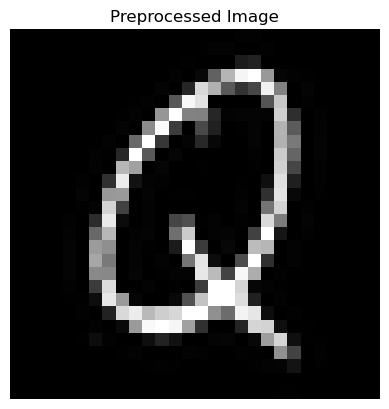

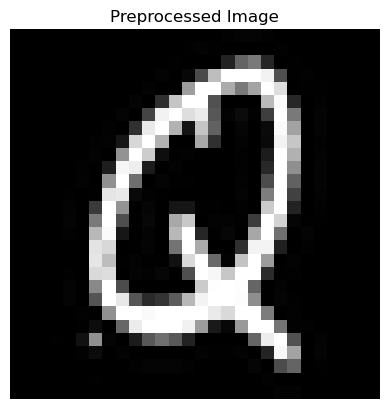

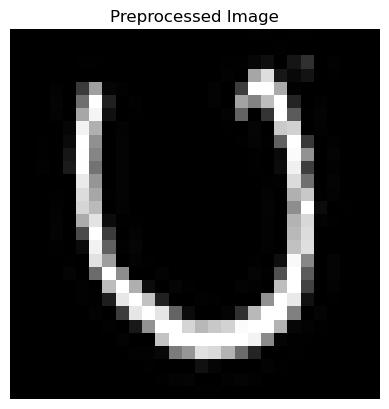

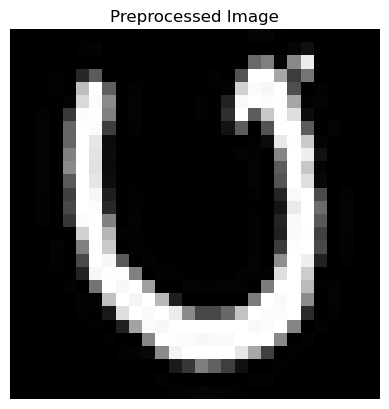

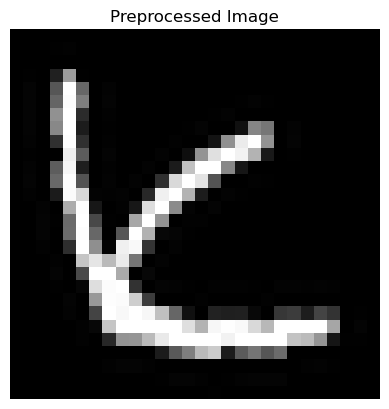

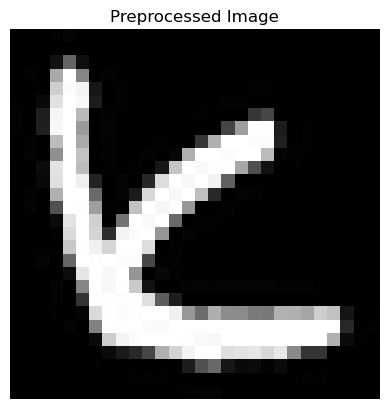

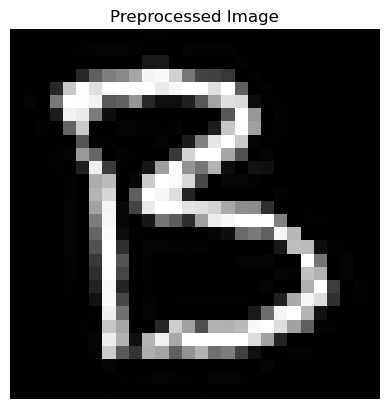

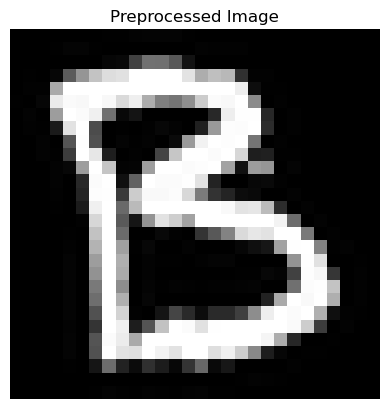

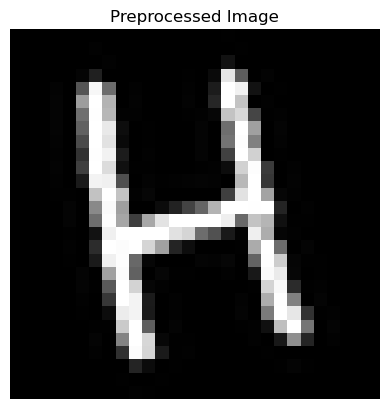

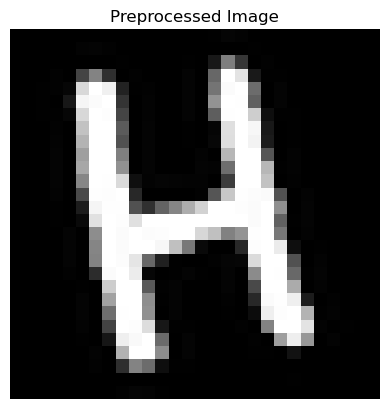

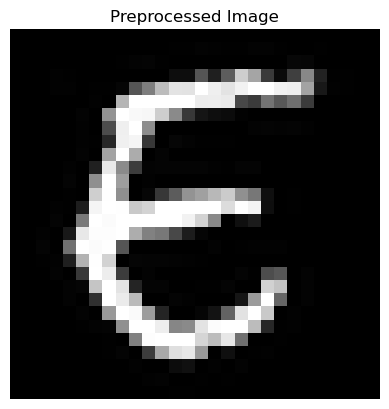

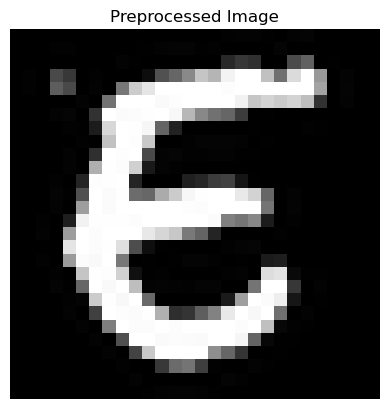

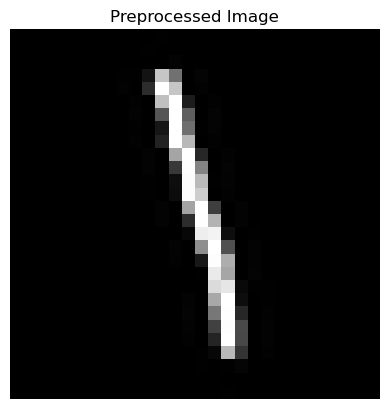

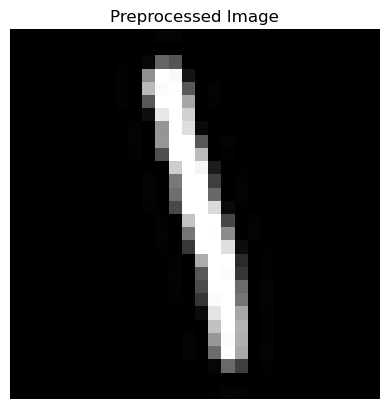

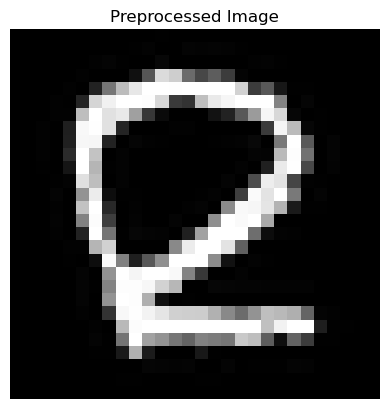

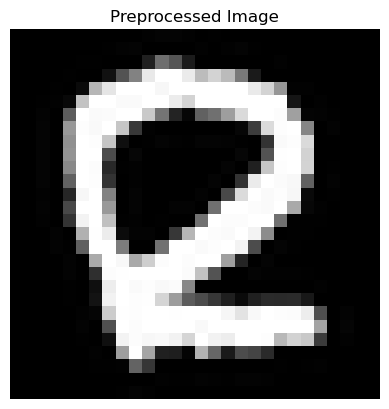

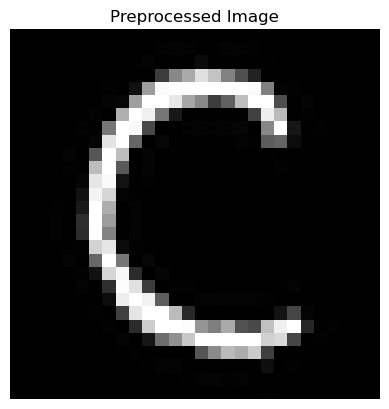

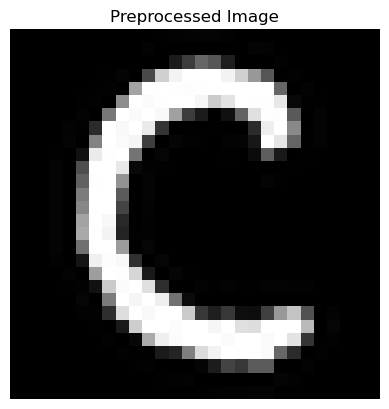

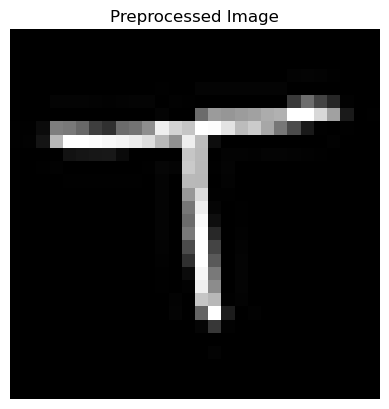

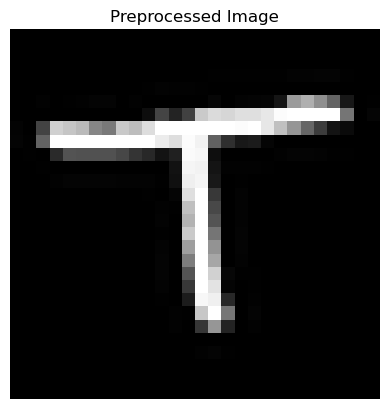

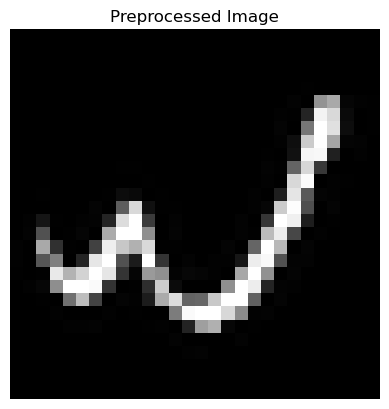

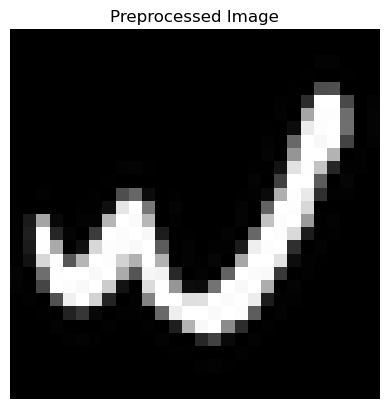

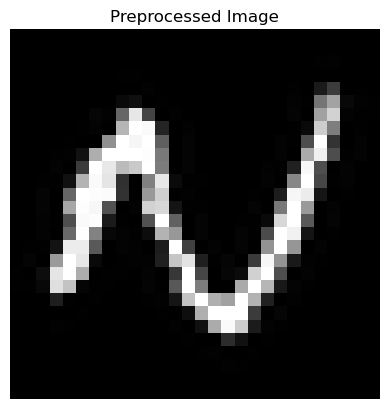

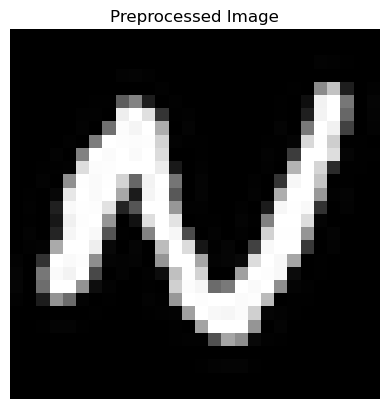

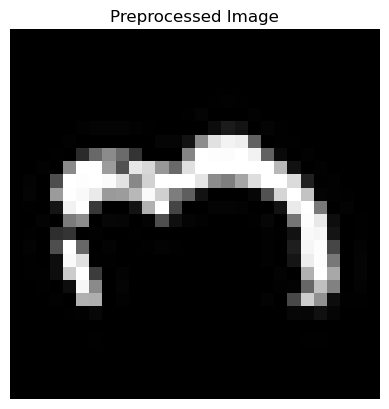

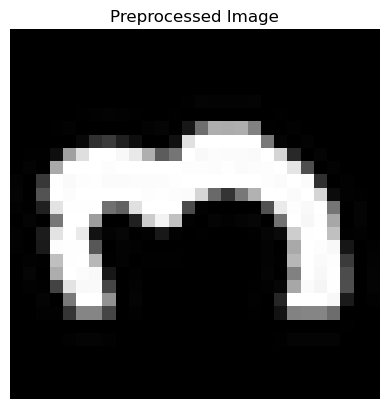

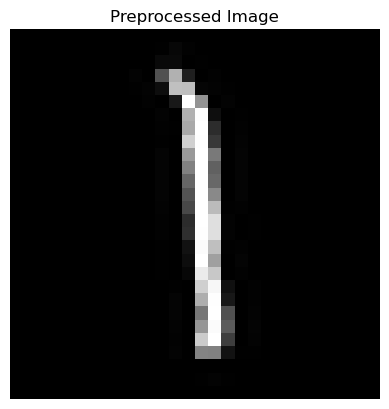

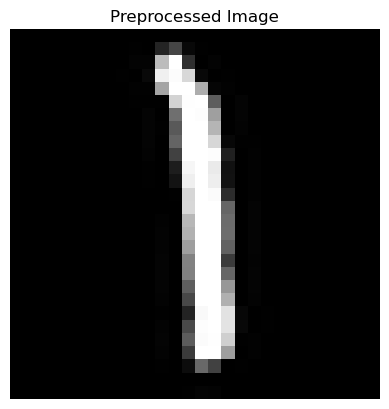

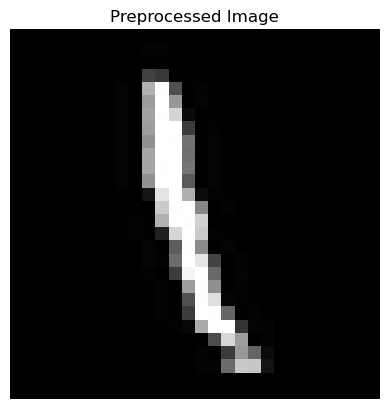

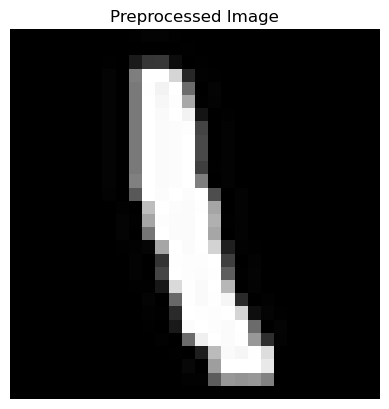

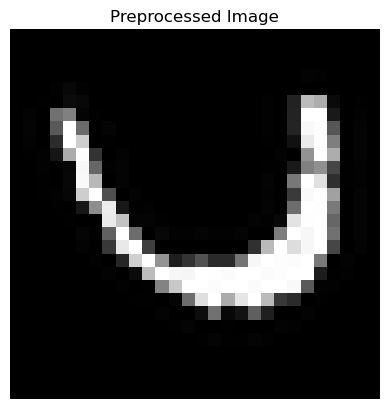

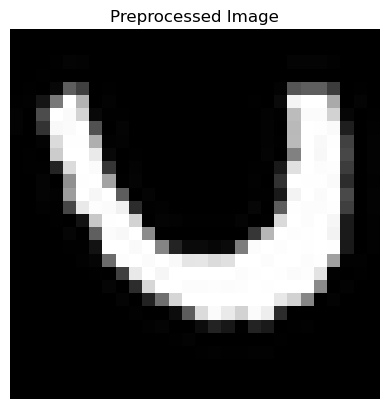

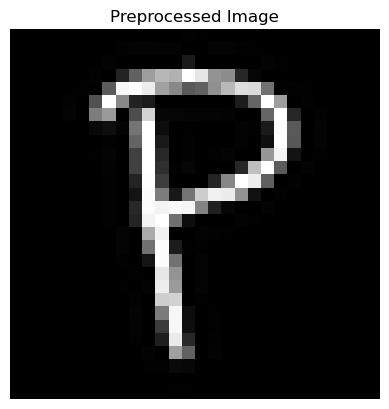

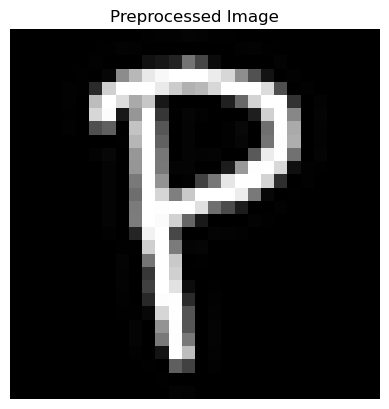

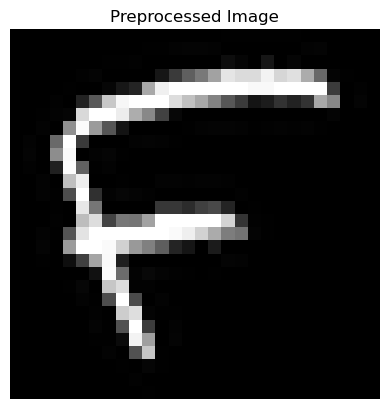

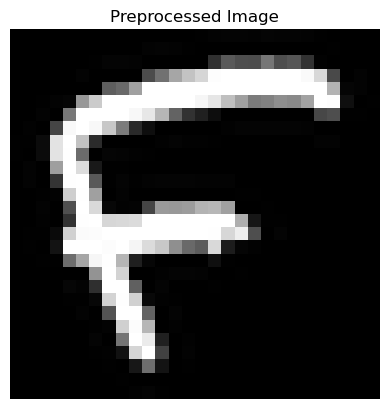

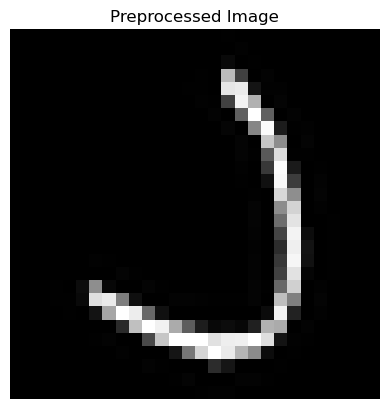

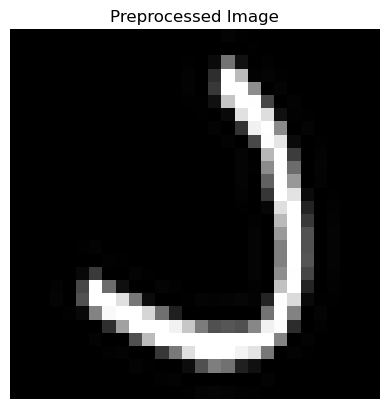

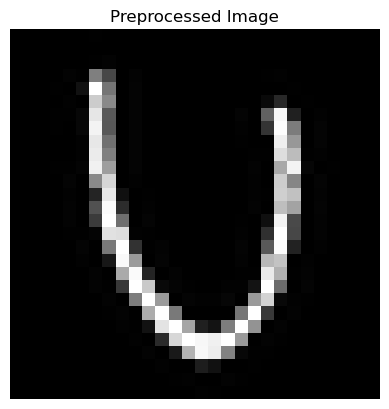

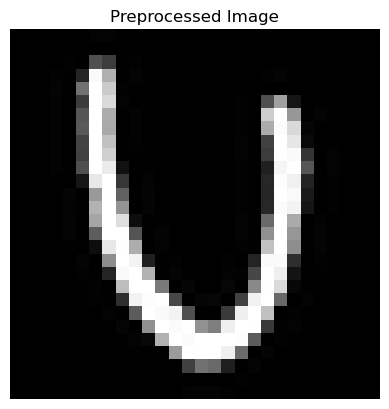

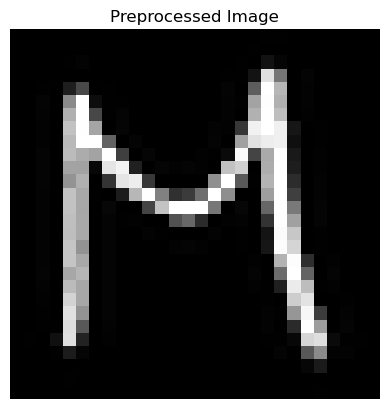

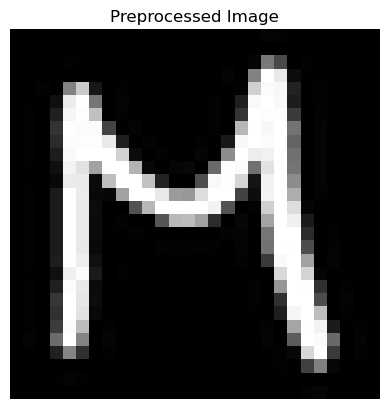

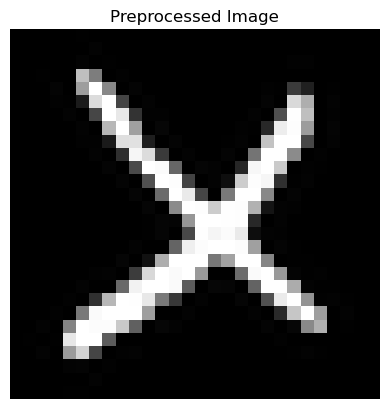

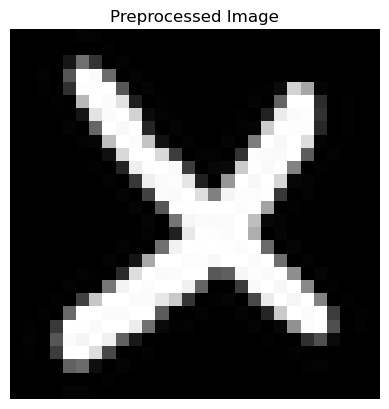

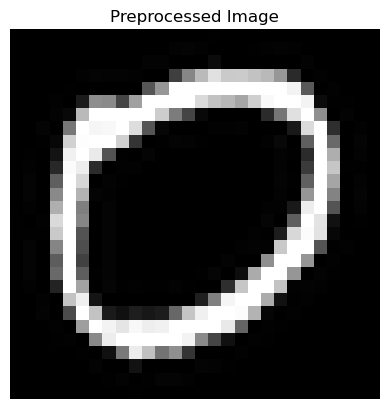

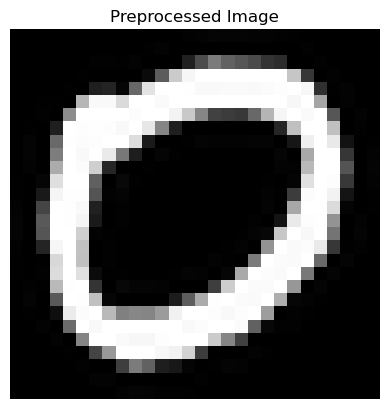

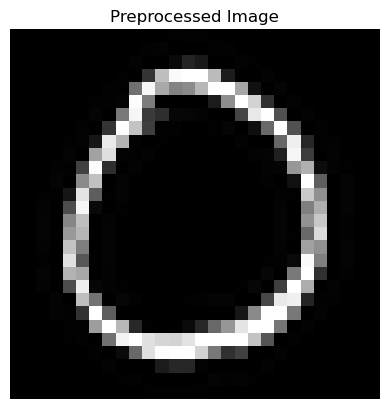

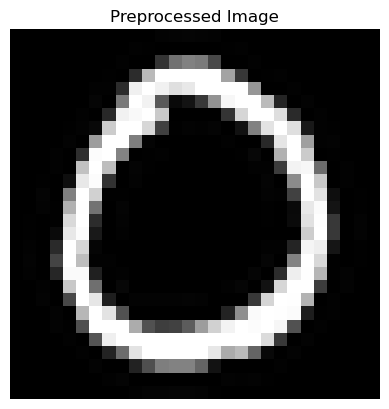

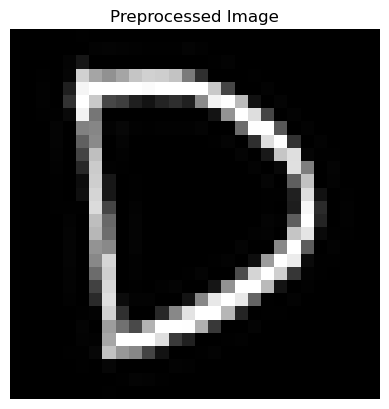

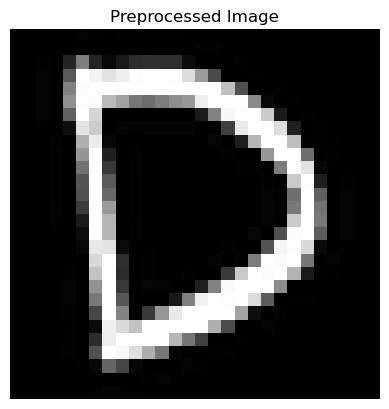

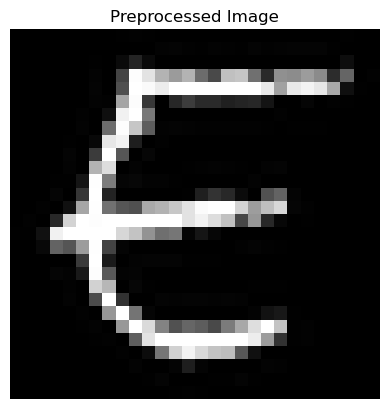

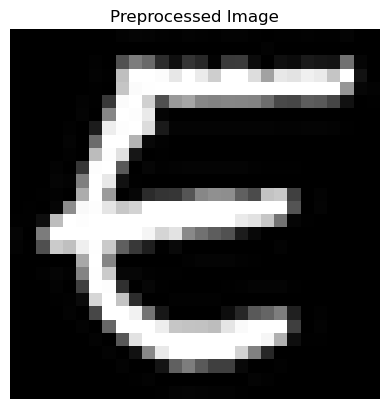

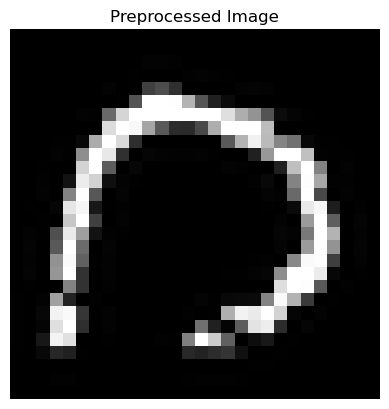

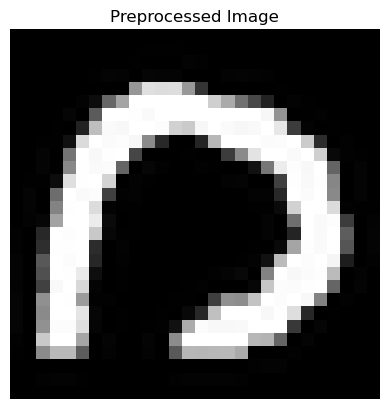

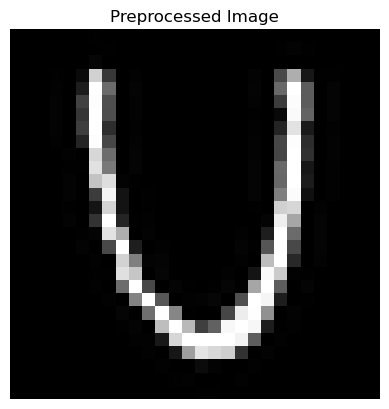

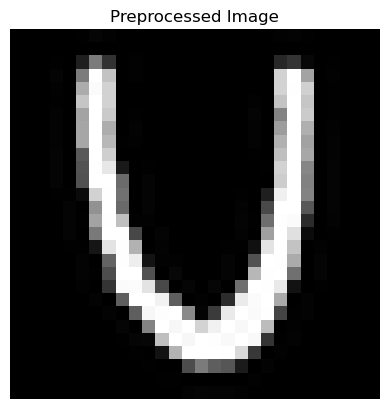

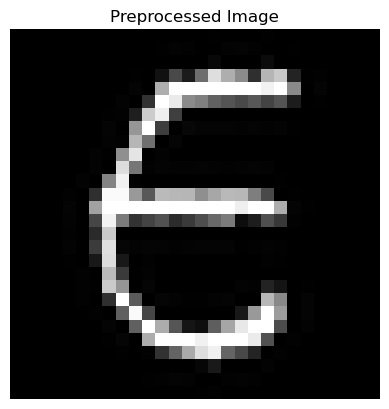

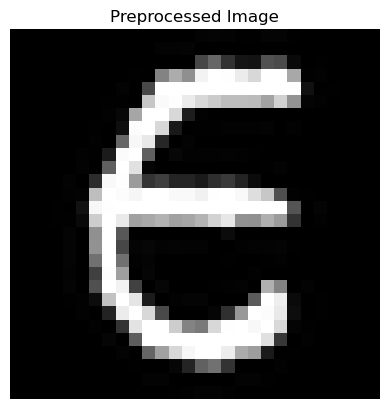

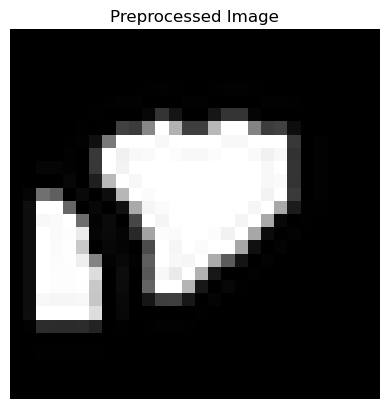

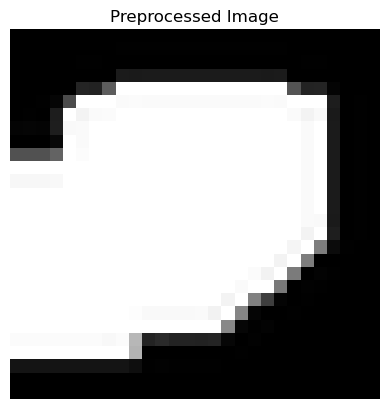

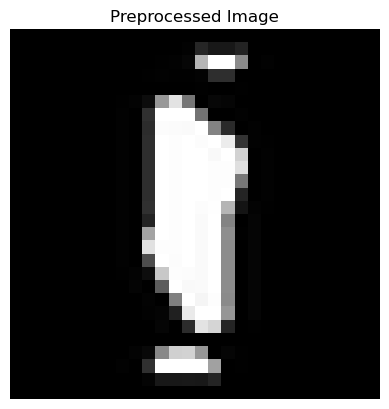

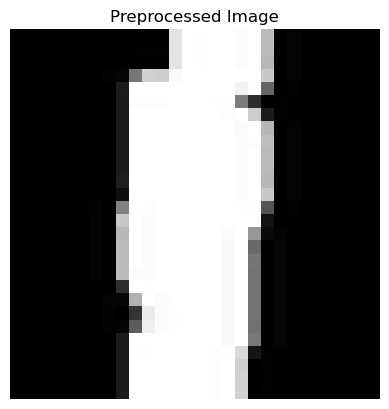

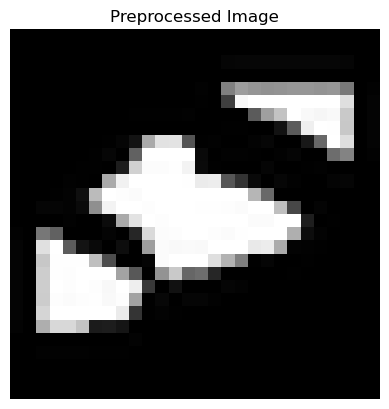

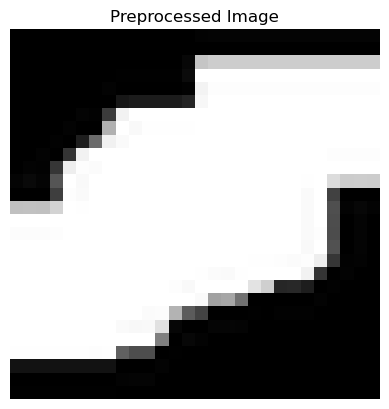

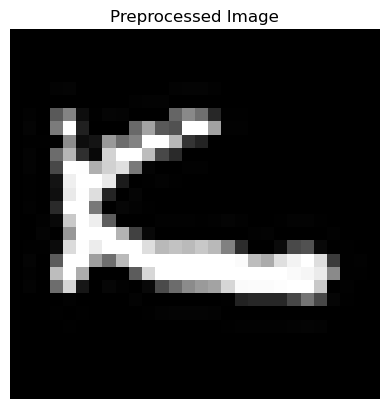

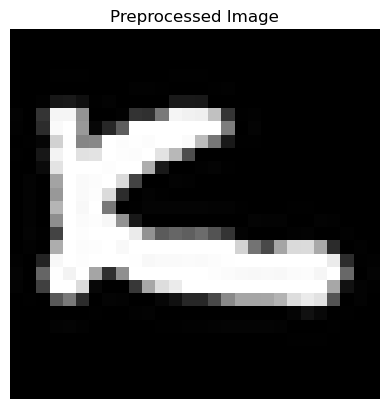

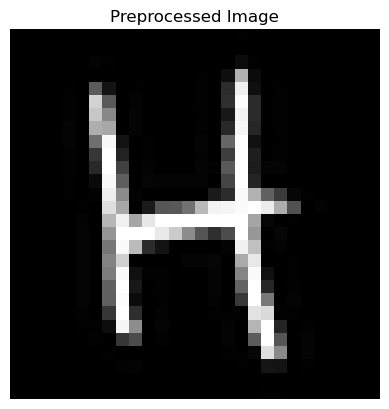

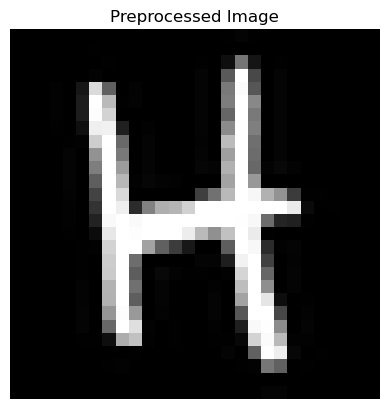

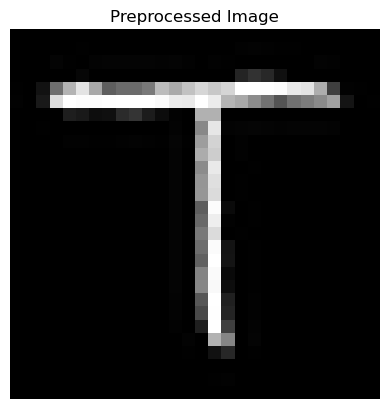

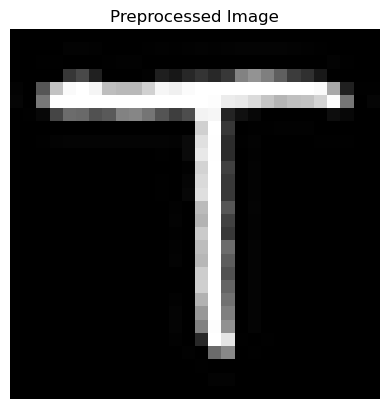

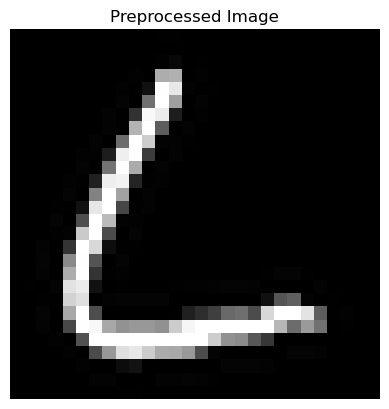

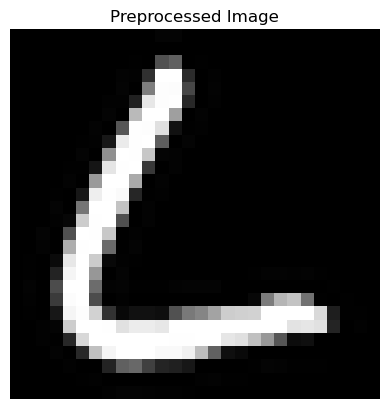

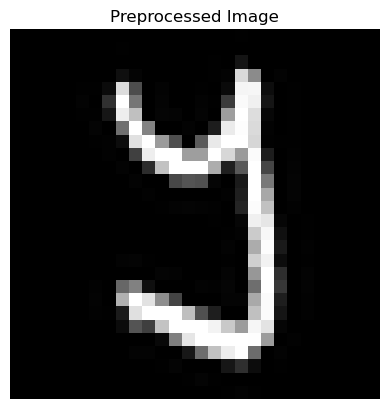

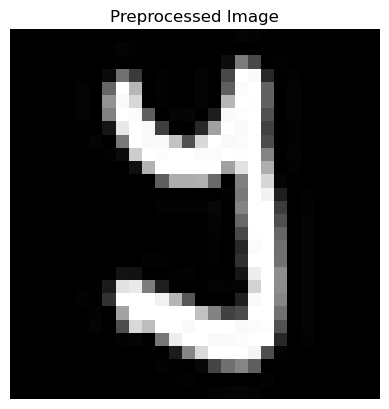

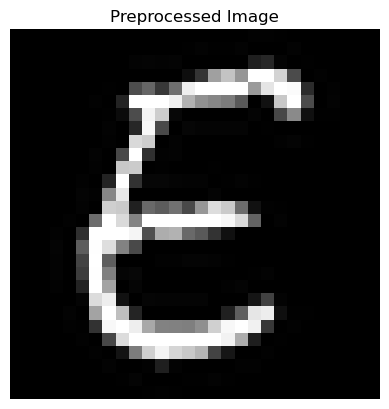

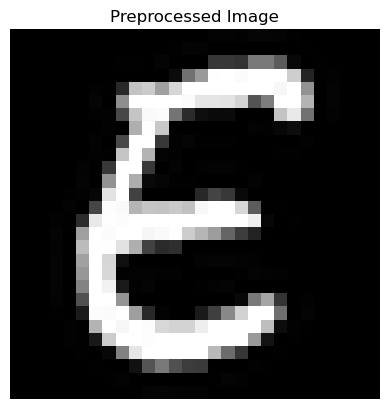

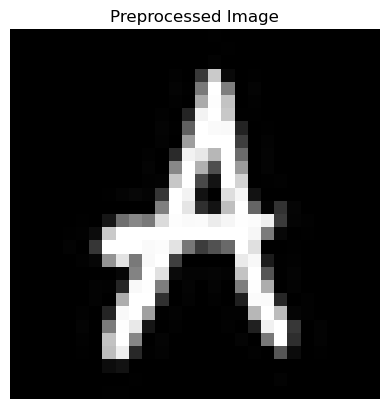

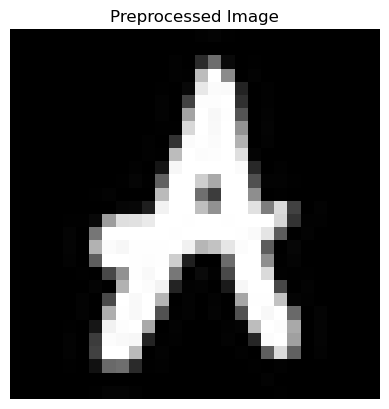

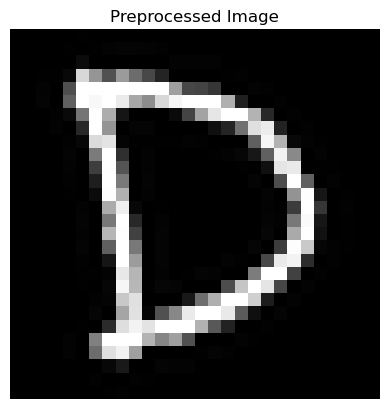

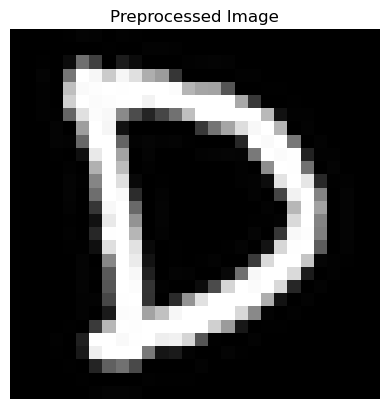

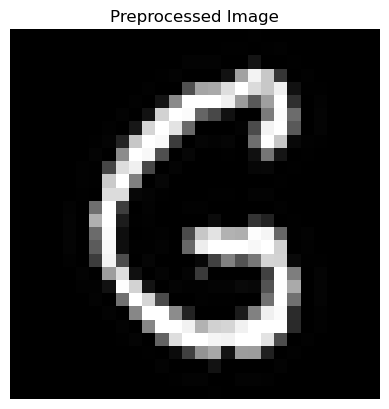

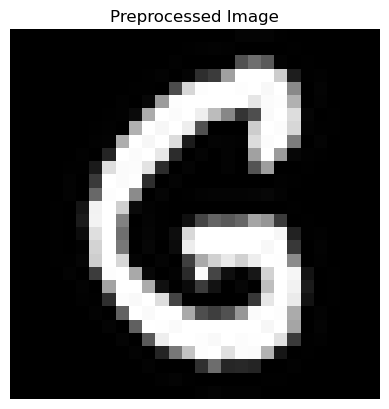

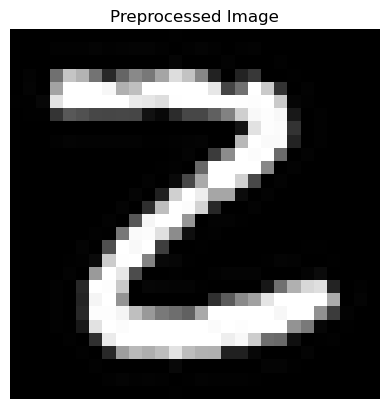

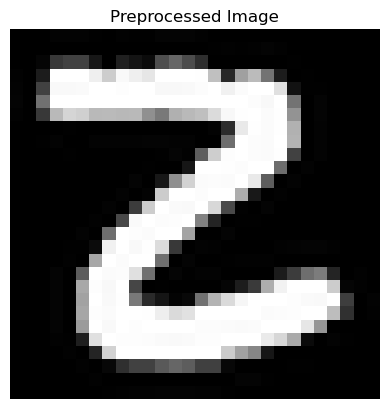

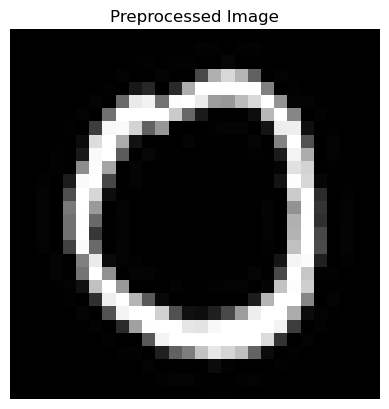

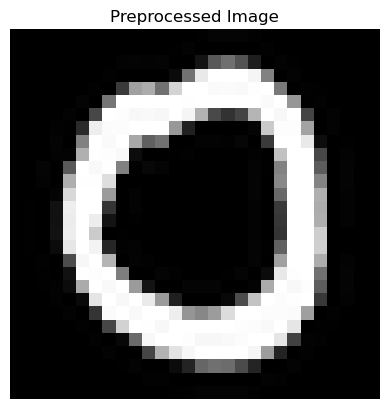

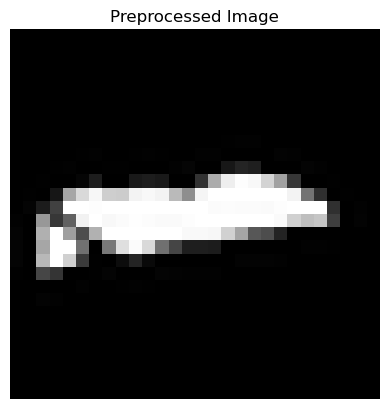

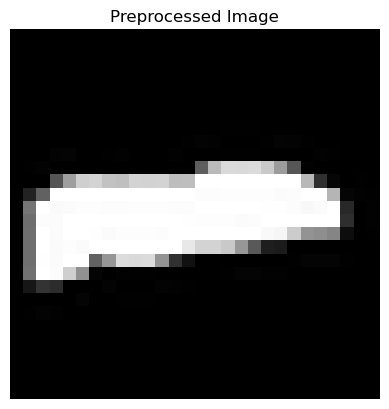

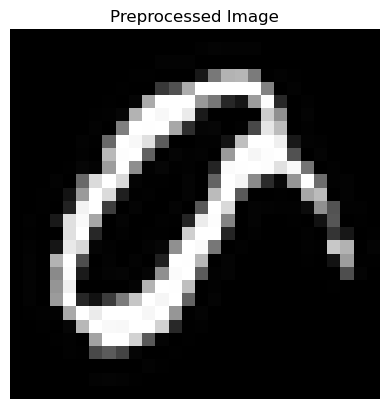

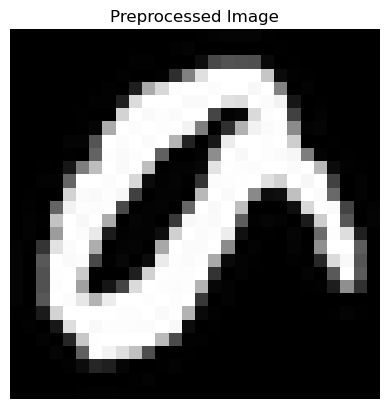

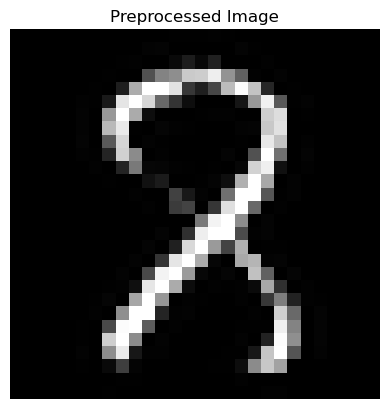

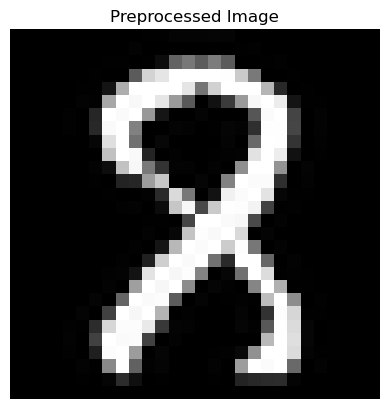

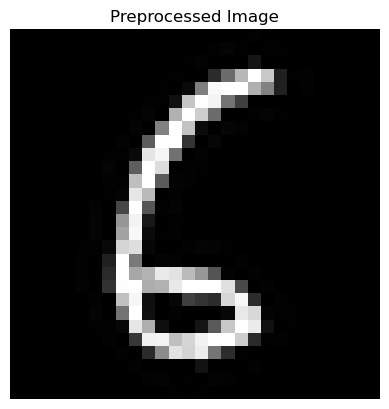

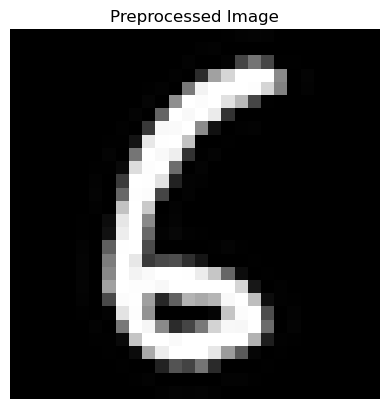

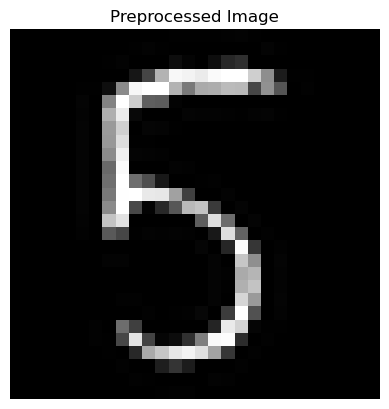

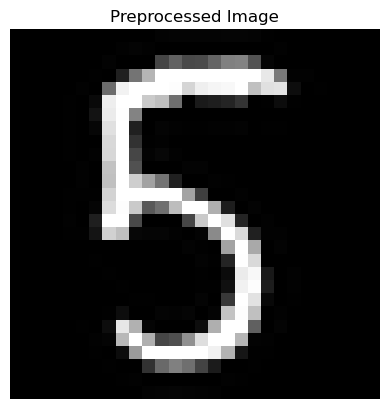

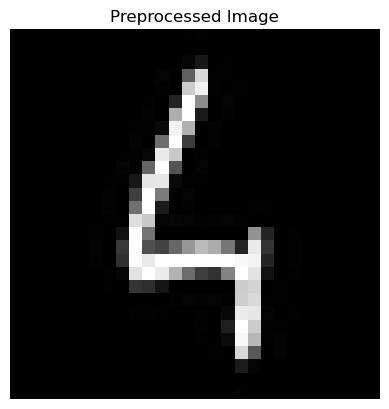

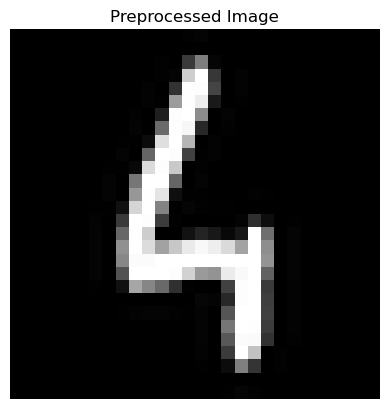

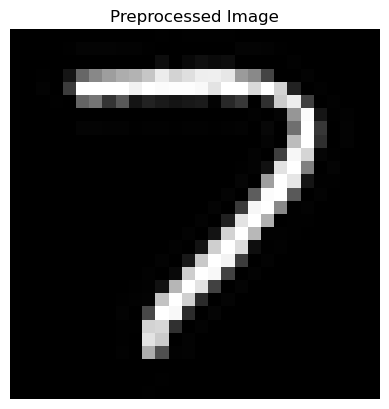

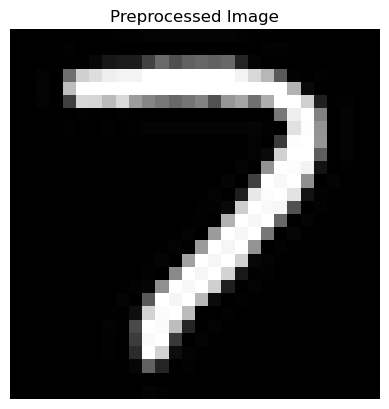

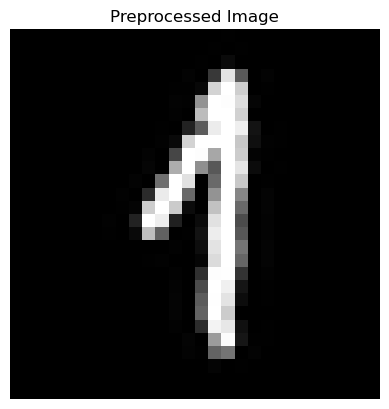

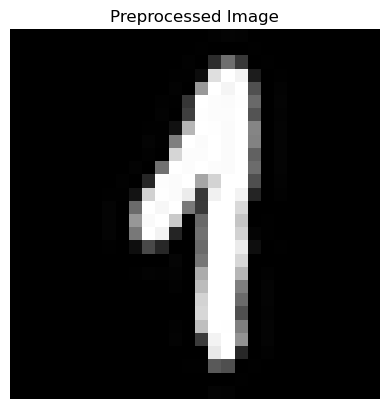

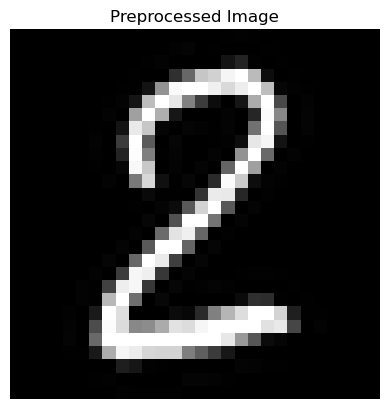

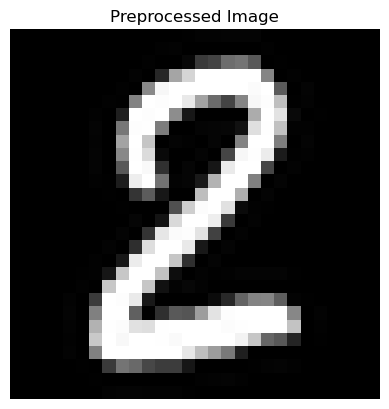

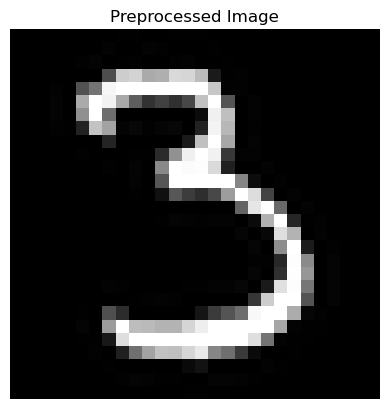

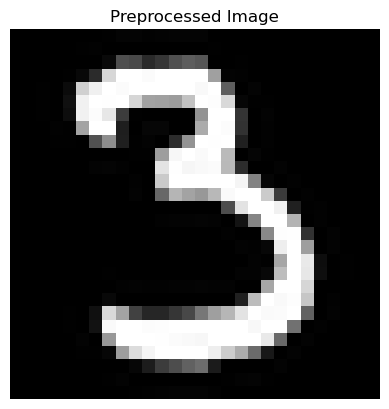

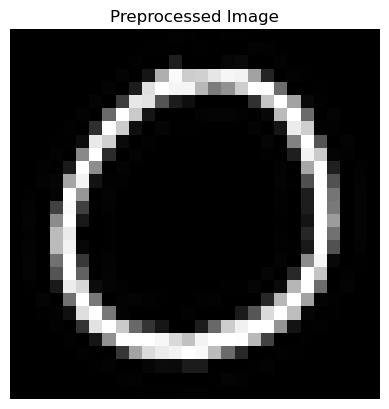

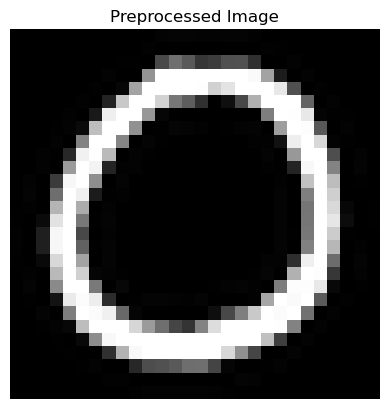

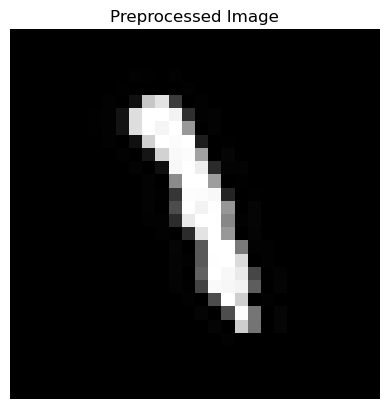

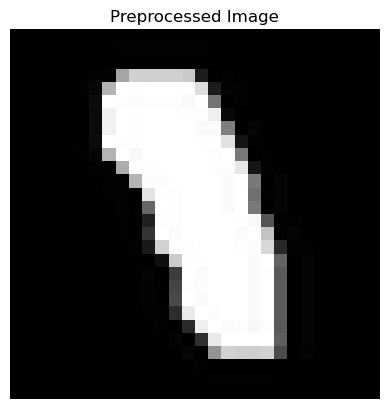

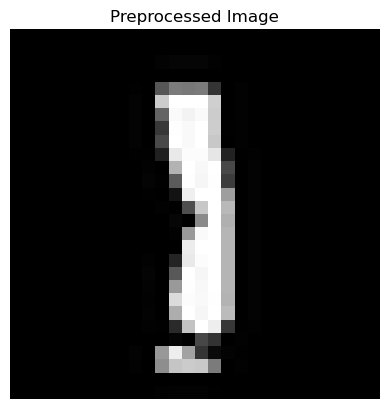

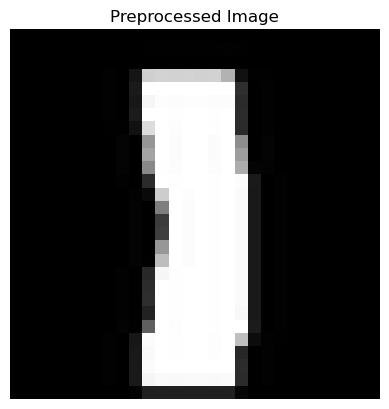

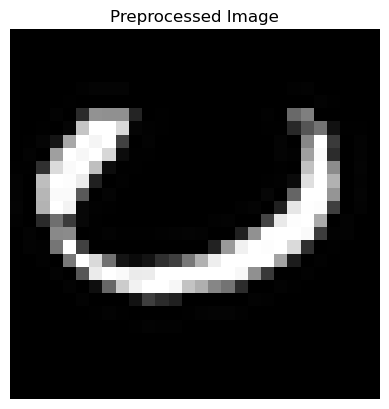

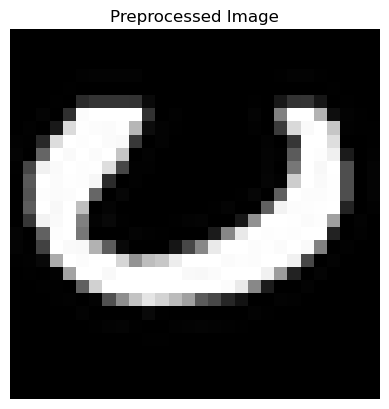

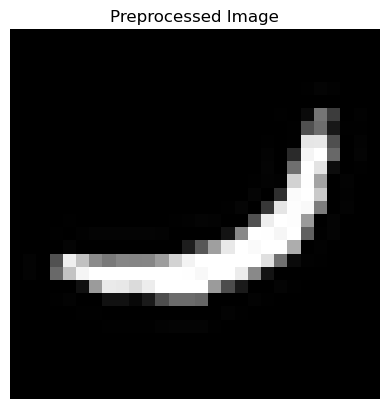

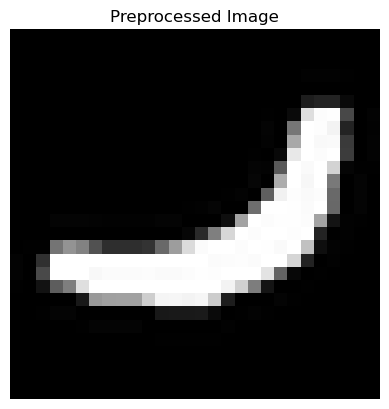

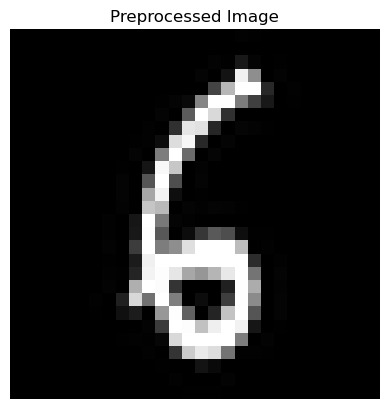

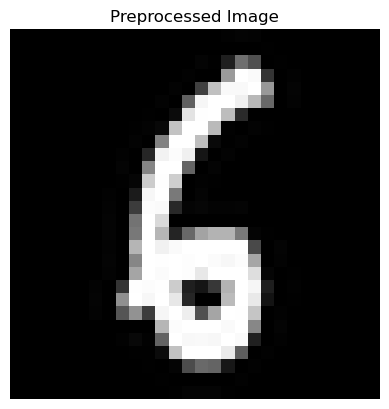

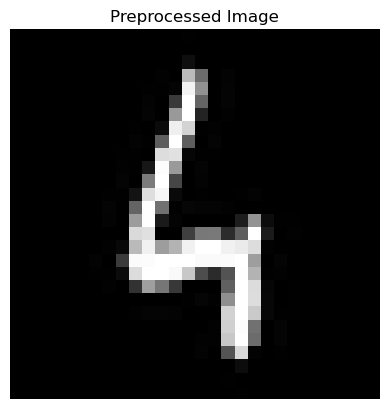

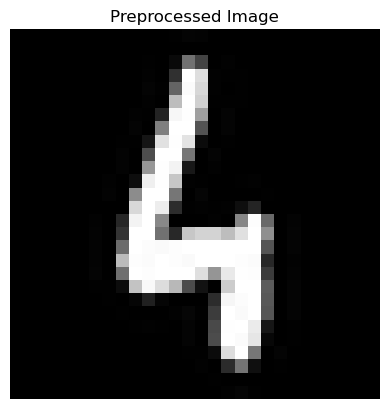

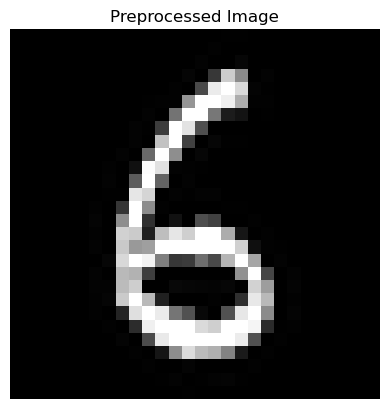

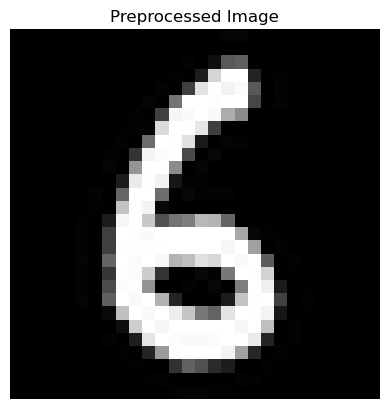

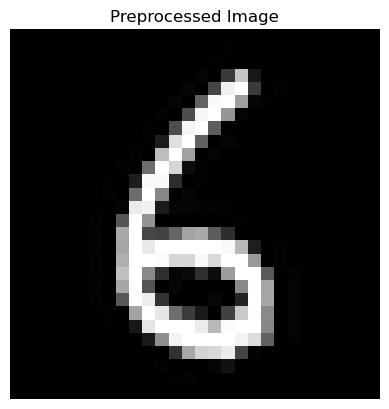

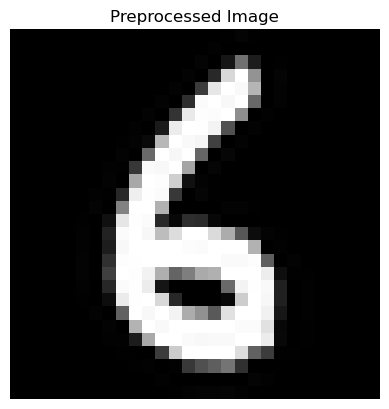

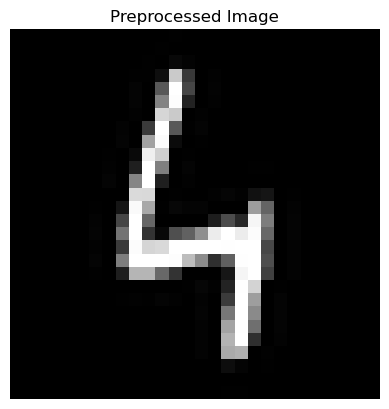

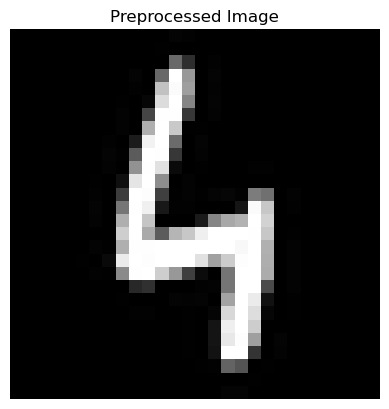

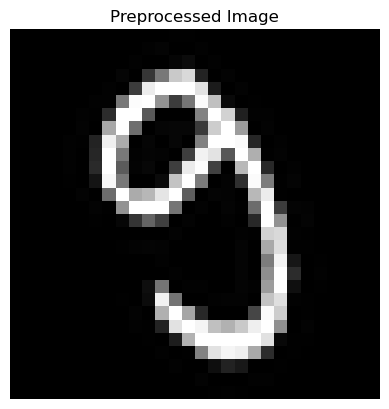

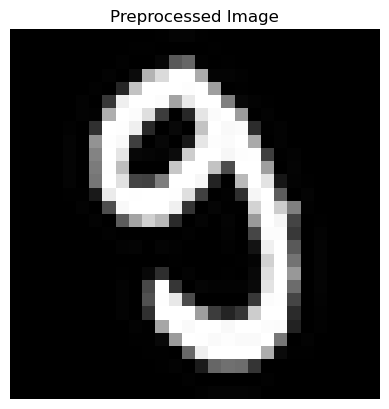

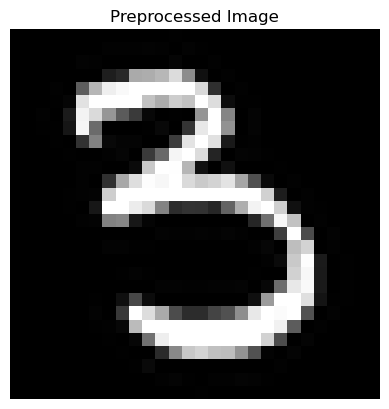

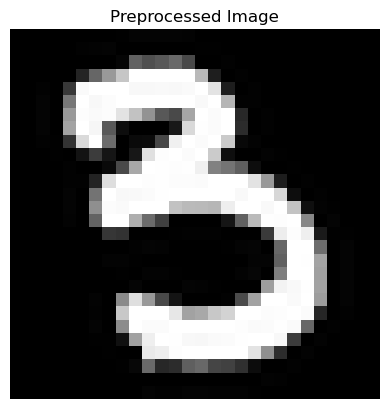

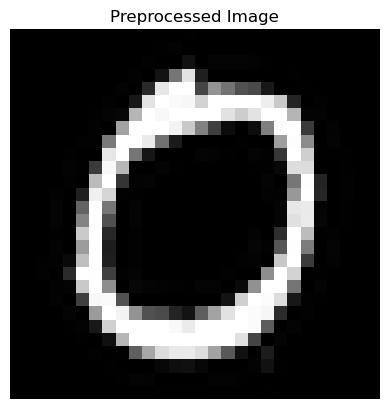

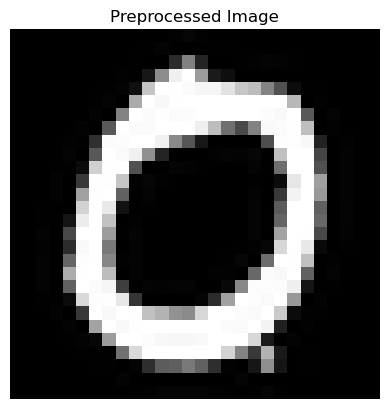

In [119]:
for i in range(66):
    image_location = f"extracted_chars/char_{i}.png"
    preprocessed_image = preprocess_image_for_cnn(image_location)
    preprocessed_image = preprocess_image_for_cnn2(image_location)


In [19]:
def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")


In [26]:
def move_image_to_sorted_folder(source_path, predicted_char, filename):
    # Create base directory structure
    base_dir = "testing_data/data"
    target_dir = os.path.join(base_dir, str(predicted_char))
    
    # Create directories if they don't exist
    create_directory_if_not_exists(base_dir)
    create_directory_if_not_exists(target_dir)
    
    # Generate new filename with predicted character and UUID
    _, ext = os.path.splitext(filename)
    unique_id = str(uuid.uuid4())
    new_filename = f"{predicted_char}_{unique_id}{ext}"
    
    target_path = os.path.join(target_dir, new_filename)
    
    try:
        # Move the file
        shutil.move(source_path, target_path)
        print(f"Moved {filename} to {new_filename}")
        return True
    except Exception as e:
        print(f"Error moving file {filename}: {e}")
        return False
        
def sort_images_by_prediction(source_directory="extracted_chars", confidence_threshold=0.5):
    moved_count = 0
    failed_count = 0
    low_confidence_count = 0
    
    # Get all image files in the source directory
    if not os.path.exists(source_directory):
        print(f"Error: Source directory '{source_directory}' not found!")
        return
    
    image_files = []
    
    for filename in os.listdir(source_directory):
        file_path = os.path.join(source_directory, filename)
        if os.path.isfile(file_path):
            image_files.append(filename)
    
    print(f"Found {len(image_files)} image files in '{source_directory}'")
    
    if not image_files:
        print("No image files found to process!")
        return
    
    # Sort files for consistent processing order
    image_files.sort()
    
    for i, filename in enumerate(image_files):
        image_location = os.path.join(source_directory, filename)
        
        print(f"Processing {i+1}/{len(image_files)}: {filename}")
            
        preprocessed_image = preprocess_image_for_cnn(image_location)
        
        if preprocessed_image is not None:
            # Get prediction probabilities for all classes
            prediction_proba = cnn_model.predict(preprocessed_image, verbose=0)
            
            # Get the predicted class (highest probability)
            predicted_class_id = np.argmax(prediction_proba[0])
            
            # Use the class_to_char function for proper conversion
            predicted_char = class_to_char_alpha(predicted_class_id)
            confidence = np.max(prediction_proba[0])
            
            print(f"Prediction: {predicted_char}, Confidence: {confidence:.4f}")
            
            # Optional: Show top 3 predictions for verification
            top_3_indices = np.argsort(prediction_proba[0])[-3:][::-1]
            print("Top 3 predictions:")
            for j, idx in enumerate(top_3_indices, 1):
                char = class_to_char_alpha(idx)
                prob = prediction_proba[0][idx]
                print(f"  {j}. {char}: {prob:.4f}")
            
            # Move image if confidence is above threshold
            if confidence >= confidence_threshold:
                if move_image_to_sorted_folder(image_location, predicted_char, filename):
                    moved_count += 1
                else:
                    failed_count += 1
            else:
                print(f"Skipping {filename} - confidence {confidence:.4f} below threshold {confidence_threshold}")
                low_confidence_count += 1
        else:
            failed_count += 1

In [30]:
sort_images_by_prediction(source_directory="extracted_chars", confidence_threshold=0.3)


Found 510 image files in 'extracted_chars'
Processing 1/510: char_0.png
Prediction: B, Confidence: 1.0000
Top 3 predictions:
  1. B: 1.0000
  2. G: 0.0000
  3. D: 0.0000
Created directory: testing_data/data/B
Moved char_0.png to B_3b942abe-54f6-44f1-8b78-cf11704d85bc.png
Processing 2/510: char_1.png
Prediction: B, Confidence: 1.0000
Top 3 predictions:
  1. B: 1.0000
  2. G: 0.0000
  3. D: 0.0000
Moved char_1.png to B_e2ea06dc-2f00-4a06-b672-6504b7508e8d.png
Processing 3/510: char_10.png
Prediction: B, Confidence: 0.9996
Top 3 predictions:
  1. B: 0.9996
  2. G: 0.0002
  3. E: 0.0001
Moved char_10.png to B_a234ae8c-d289-425f-b980-7eac5d8831fc.png
Processing 4/510: char_100.png
Prediction: D, Confidence: 0.9999
Top 3 predictions:
  1. D: 0.9999
  2. O: 0.0000
  3. P: 0.0000
Created directory: testing_data/data/D
Moved char_100.png to D_ad79a9e0-9fad-4edc-b5cf-fdfd0d508727.png
Processing 5/510: char_101.png
Prediction: D, Confidence: 0.9999
Top 3 predictions:
  1. D: 0.9999
  2. O: 0.0001

Found 239 image files in 'testing_data/dniel'
Processing 1/239: char_100.png


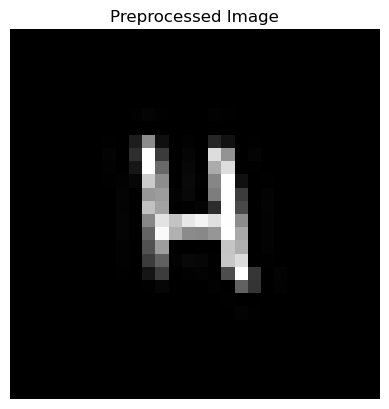

Prediction: 4, Confidence: 0.9643
Top 3 predictions:
  1. 4: 0.9643
  2. H: 0.0097
  3. Y: 0.0095
Moved char_100.png to 4_082b017f-3a1d-4fd8-bd93-9d71153d1b4d.png
Processing 2/239: char_101.png


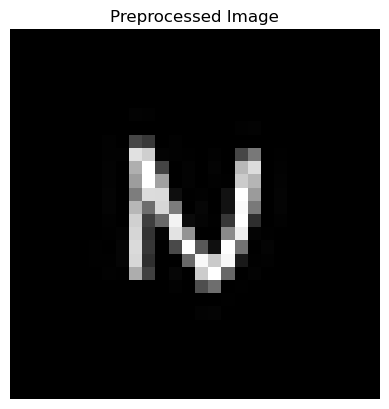

Prediction: N, Confidence: 0.9988
Top 3 predictions:
  1. N: 0.9988
  2. W: 0.0011
  3. H: 0.0000
Moved char_101.png to N_ccc8383c-91ff-4ec8-b0bf-388502d92c40.png
Processing 3/239: char_102.png


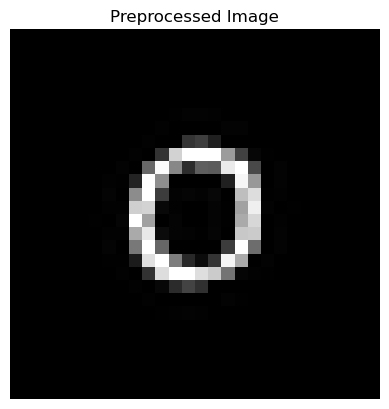

Prediction: 0, Confidence: 0.9311
Top 3 predictions:
  1. 0: 0.9311
  2. O: 0.0575
  3. 8: 0.0082
Moved char_102.png to 0_94ce7285-9f86-412b-8a20-99a8e245c219.png
Processing 4/239: char_103.png


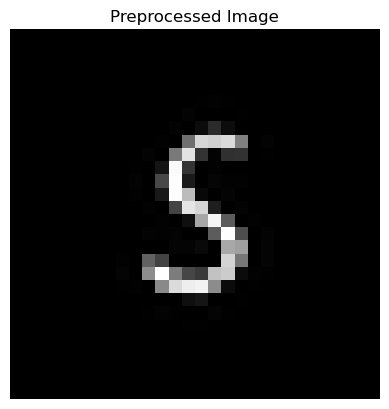

Prediction: 5, Confidence: 0.6248
Top 3 predictions:
  1. 5: 0.6248
  2. S: 0.3737
  3. 3: 0.0007
Moved char_103.png to 5_0a949b72-b01e-4167-94a9-19abd32a0c7d.png
Processing 5/239: char_104.png


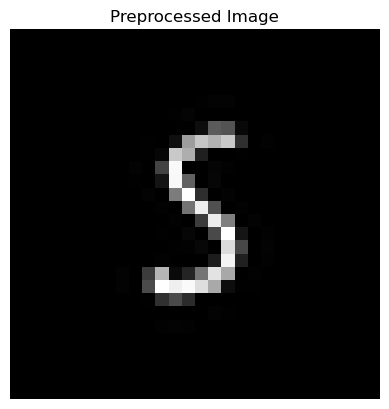

Prediction: 5, Confidence: 0.9217
Top 3 predictions:
  1. 5: 0.9217
  2. S: 0.0767
  3. 3: 0.0011
Moved char_104.png to 5_2bb39193-1e8b-4957-8f33-0004b7cbc872.png
Processing 6/239: char_105.png


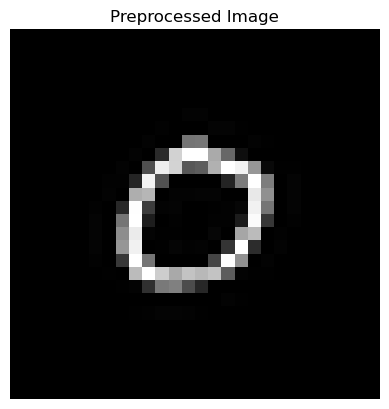

Prediction: 0, Confidence: 0.9867
Top 3 predictions:
  1. 0: 0.9867
  2. O: 0.0115
  3. 8: 0.0009
Moved char_105.png to 0_a0b7143a-381a-4445-8c23-f6ad6d7605cf.png
Processing 7/239: char_106.png


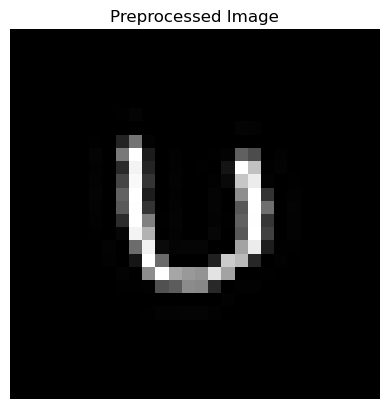

Prediction: U, Confidence: 0.5946
Top 3 predictions:
  1. U: 0.5946
  2. 4: 0.1435
  3. 0: 0.1319
Moved char_106.png to U_9596a1ce-1012-44eb-887f-722ab4545260.png
Processing 8/239: char_107.png


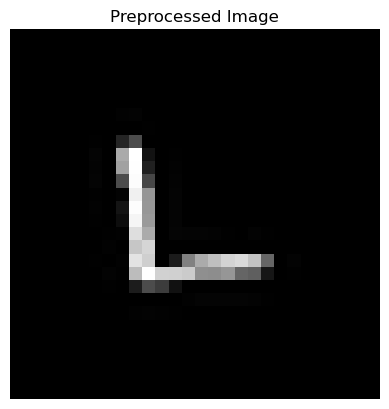

Prediction: L, Confidence: 0.9993
Top 3 predictions:
  1. L: 0.9993
  2. C: 0.0004
  3. Z: 0.0001
Moved char_107.png to L_a4580f87-bbbc-45d1-a181-c807c1e619d8.png
Processing 9/239: char_108.png


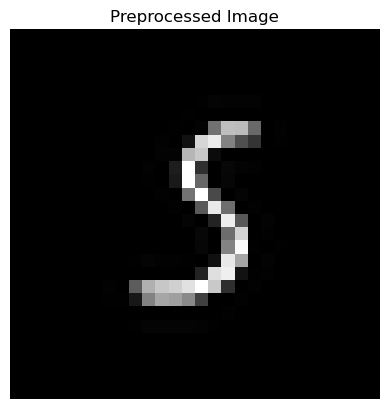

Prediction: S, Confidence: 0.8005
Top 3 predictions:
  1. S: 0.8005
  2. 5: 0.1992
  3. 3: 0.0002
Moved char_108.png to S_15f404e0-7594-40bd-b73c-9e7c11d04b62.png
Processing 10/239: char_109.png


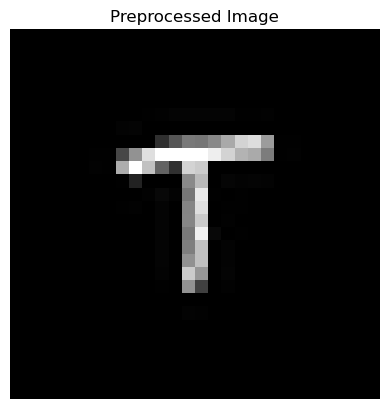

Prediction: T, Confidence: 0.9998
Top 3 predictions:
  1. T: 0.9998
  2. J: 0.0001
  3. U: 0.0000
Moved char_109.png to T_069f9da3-390f-4e67-9d4b-8d0e8db1f34d.png
Processing 11/239: char_11.png


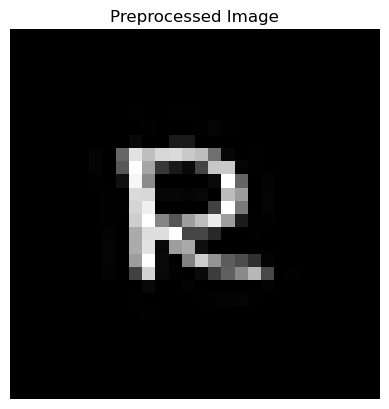

Prediction: R, Confidence: 0.9983
Top 3 predictions:
  1. R: 0.9983
  2. P: 0.0016
  3. B: 0.0001
Moved char_11.png to R_3a9a2c0f-28a6-4f62-ae9f-dc1c422c59f2.png
Processing 12/239: char_110.png


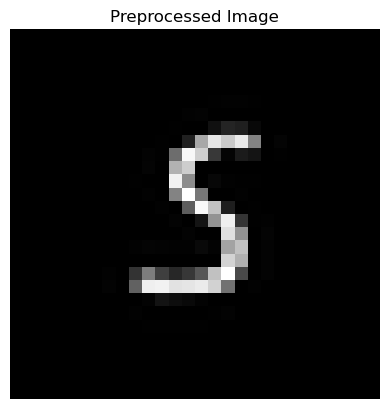

Prediction: 5, Confidence: 0.9685
Top 3 predictions:
  1. 5: 0.9685
  2. S: 0.0295
  3. 3: 0.0018
Moved char_110.png to 5_8ad2d96d-22c8-4bda-8cdb-dc11fbf135fa.png
Processing 13/239: char_111.png


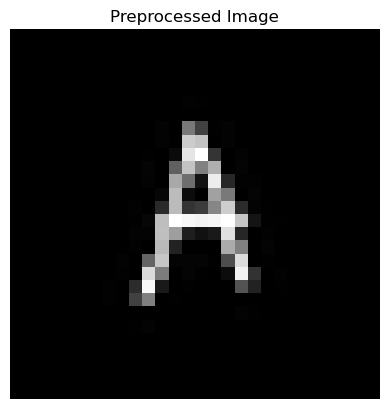

Prediction: A, Confidence: 0.9999
Top 3 predictions:
  1. A: 0.9999
  2. 4: 0.0001
  3. H: 0.0000
Moved char_111.png to A_00c8a3c4-5eeb-473e-8acd-a9d3066705a3.png
Processing 14/239: char_112.png


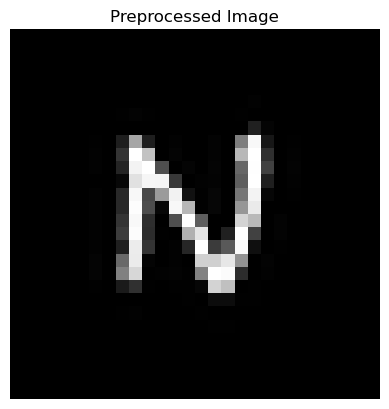

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. H: 0.0000
Moved char_112.png to N_0ee99d09-9870-4b14-b197-cc4ae583a218.png
Processing 15/239: char_113.png


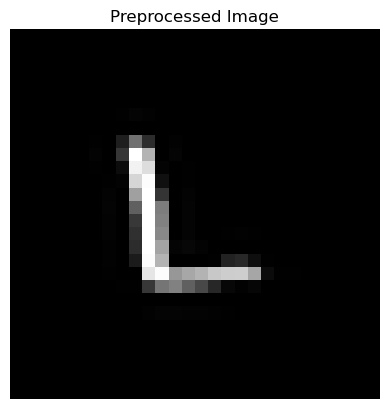

Prediction: L, Confidence: 0.9556
Top 3 predictions:
  1. L: 0.9556
  2. 1: 0.0173
  3. 2: 0.0066
Moved char_113.png to L_9ed7eeea-92ab-49bd-a0c7-50025716afe3.png
Processing 16/239: char_114.png


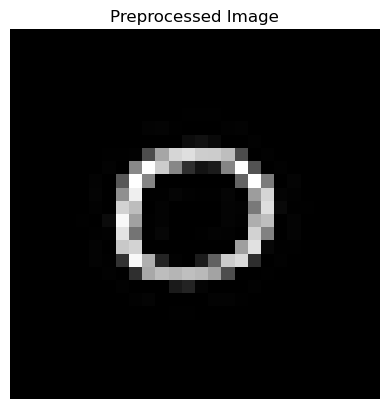

Prediction: 0, Confidence: 0.9944
Top 3 predictions:
  1. 0: 0.9944
  2. O: 0.0053
  3. 8: 0.0002
Moved char_114.png to 0_e6bcd6fc-5fb5-4314-961a-e98101e1933d.png
Processing 17/239: char_115.png


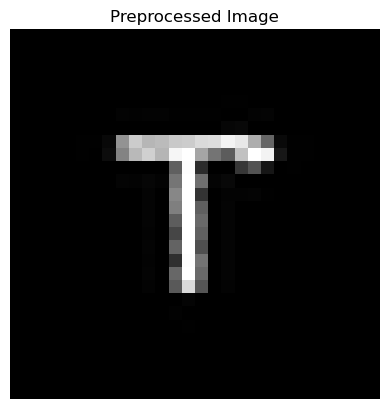

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_115.png to T_3d3dc7c6-833f-4044-896f-ab372788b011.png
Processing 18/239: char_116.png


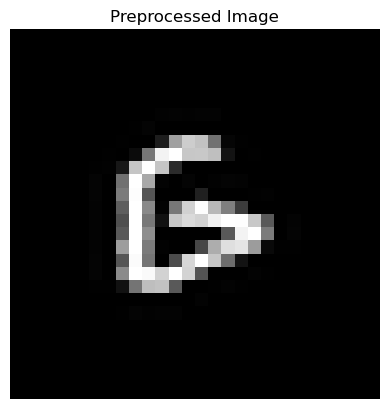

Prediction: 6, Confidence: 0.9005
Top 3 predictions:
  1. 6: 0.9005
  2. 5: 0.0366
  3. G: 0.0305
Moved char_116.png to 6_cddebd1f-b8f6-48de-8086-1fdabed729b1.png
Processing 19/239: char_117.png


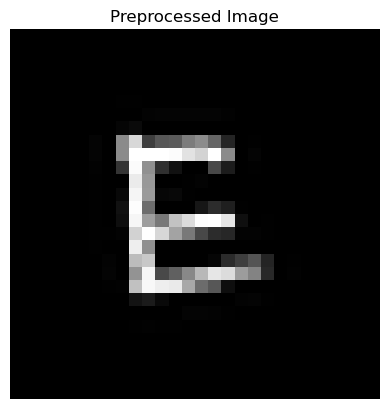

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_117.png to E_ea08bbc5-c75a-40ee-9912-01b0b9276273.png
Processing 20/239: char_118.png


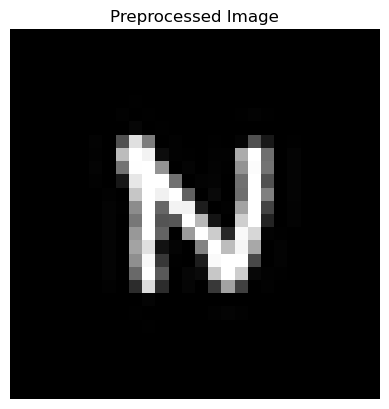

Prediction: N, Confidence: 0.9999
Top 3 predictions:
  1. N: 0.9999
  2. W: 0.0001
  3. H: 0.0000
Moved char_118.png to N_e4d45dab-19d0-44a7-b54b-e24a381b3095.png
Processing 21/239: char_119.png


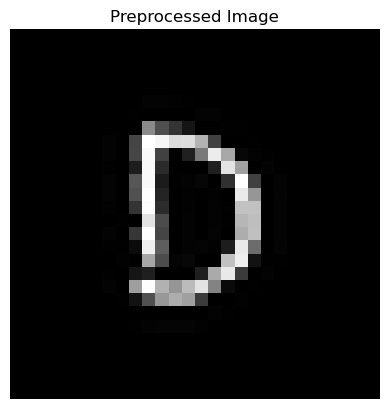

Prediction: D, Confidence: 0.9963
Top 3 predictions:
  1. D: 0.9963
  2. P: 0.0022
  3. 0: 0.0012
Moved char_119.png to D_0b4f2cf7-87e3-453e-8797-8657b71e1b9e.png
Processing 22/239: char_12.png


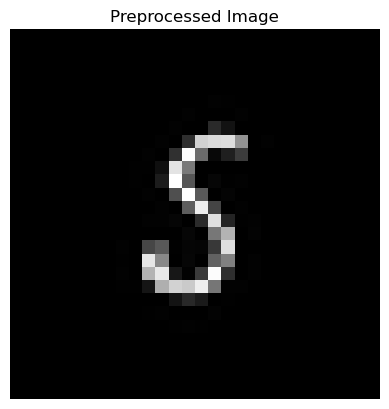

Prediction: S, Confidence: 0.5706
Top 3 predictions:
  1. S: 0.5706
  2. 5: 0.4101
  3. 3: 0.0074
Moved char_12.png to S_98f2fddb-9bd0-4e33-8761-552d62cf4df7.png
Processing 23/239: char_120.png


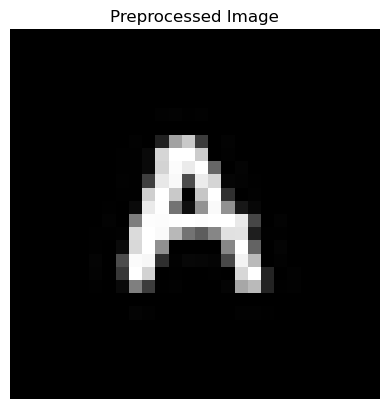

Prediction: A, Confidence: 1.0000
Top 3 predictions:
  1. A: 1.0000
  2. M: 0.0000
  3. 4: 0.0000
Moved char_120.png to A_b8be94e5-d2b2-421c-8366-7c44e8cc6ae2.png
Processing 24/239: char_121.png


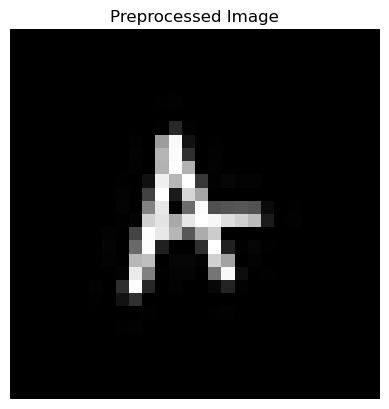

Prediction: A, Confidence: 0.9978
Top 3 predictions:
  1. A: 0.9978
  2. M: 0.0016
  3. H: 0.0005
Moved char_121.png to A_a8201e89-fac3-4b61-9b15-d6292d8723cd.png
Processing 25/239: char_122.png


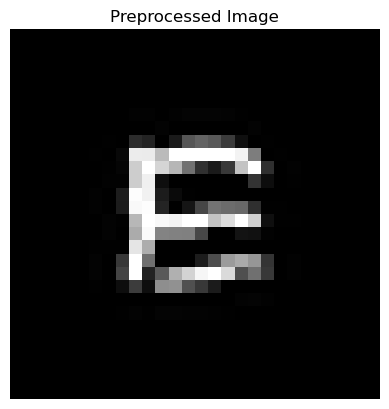

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_122.png to E_d4ae1029-cb47-4c26-b132-89208e1bec5c.png
Processing 26/239: char_123.png


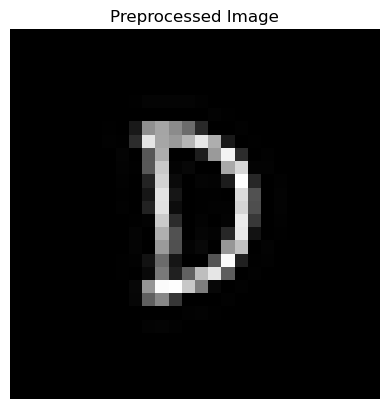

Prediction: D, Confidence: 0.9891
Top 3 predictions:
  1. D: 0.9891
  2. P: 0.0102
  3. O: 0.0005
Moved char_123.png to D_99df9a9d-7e8a-4bed-964a-02eff4924ec5.png
Processing 27/239: char_124.png


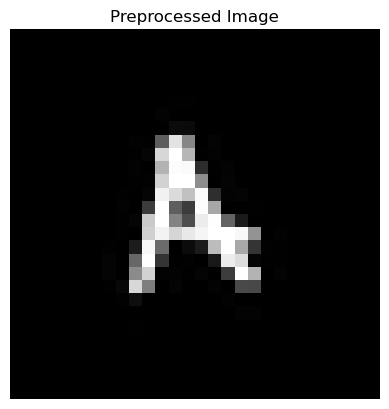

Prediction: M, Confidence: 0.7251
Top 3 predictions:
  1. M: 0.7251
  2. A: 0.1768
  3. N: 0.0842
Moved char_124.png to M_428109f2-2971-439b-9e2f-c7771ac5a19e.png
Processing 28/239: char_125.png


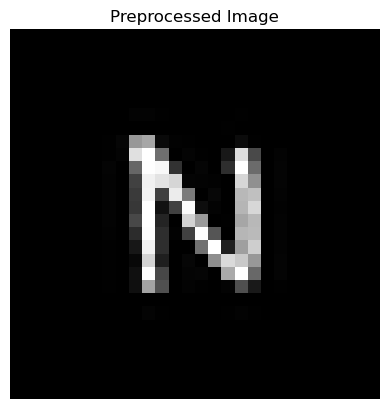

Prediction: N, Confidence: 0.9994
Top 3 predictions:
  1. N: 0.9994
  2. W: 0.0006
  3. H: 0.0000
Moved char_125.png to N_641ad3fc-2e18-42b9-959a-c69689e0d8af.png
Processing 29/239: char_126.png


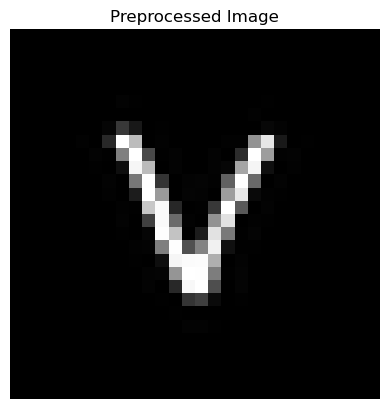

Prediction: Y, Confidence: 0.9544
Top 3 predictions:
  1. Y: 0.9544
  2. V: 0.0229
  3. X: 0.0139
Moved char_126.png to Y_efcde55f-c984-4019-bacb-f5ec7a3e5a4c.png
Processing 30/239: char_127.png


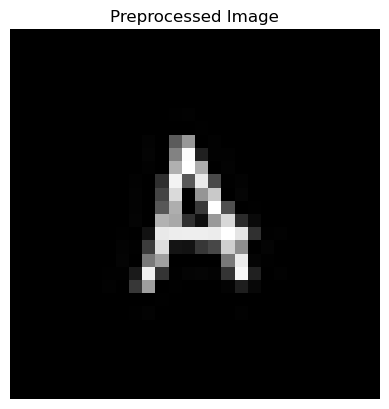

Prediction: A, Confidence: 0.9703
Top 3 predictions:
  1. A: 0.9703
  2. N: 0.0071
  3. M: 0.0059
Moved char_127.png to A_ad5328a6-7fb6-4b10-917e-c3bbb1204bc2.png
Processing 31/239: char_128.png


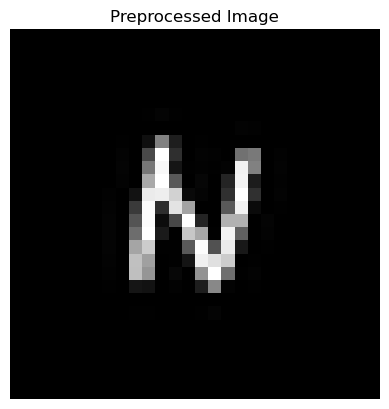

Prediction: N, Confidence: 0.9995
Top 3 predictions:
  1. N: 0.9995
  2. W: 0.0005
  3. H: 0.0000
Moved char_128.png to N_1e429f2a-4688-4159-bc26-516a0f5c44aa.png
Processing 32/239: char_129.png


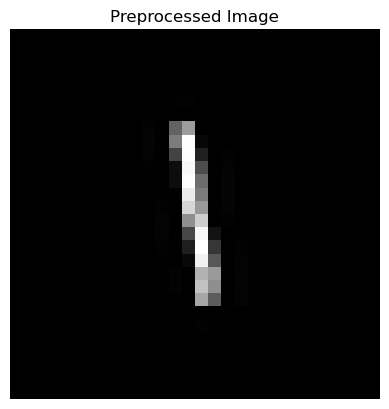

Prediction: 1, Confidence: 0.9934
Top 3 predictions:
  1. 1: 0.9934
  2. T: 0.0022
  3. J: 0.0017
Moved char_129.png to 1_0282266a-d57b-4189-b456-e673d10e2988.png
Processing 33/239: char_13.png


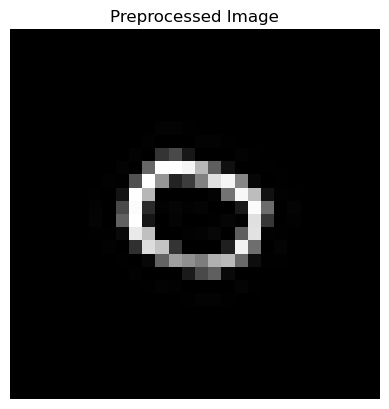

Prediction: 0, Confidence: 0.9888
Top 3 predictions:
  1. 0: 0.9888
  2. O: 0.0074
  3. 8: 0.0018
Moved char_13.png to 0_b68e3257-0cf1-4336-81f0-43d01e0545d3.png
Processing 34/239: char_130.png


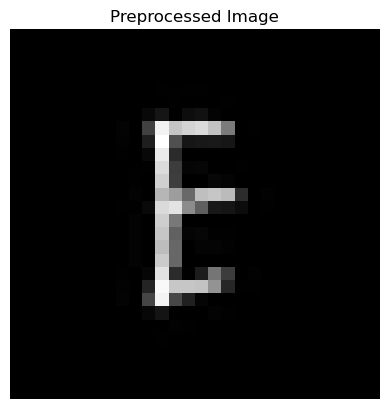

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. 5: 0.0000
  3. B: 0.0000
Moved char_130.png to E_aa3d541f-a2be-4a47-9894-56aed31bdb35.png
Processing 35/239: char_131.png


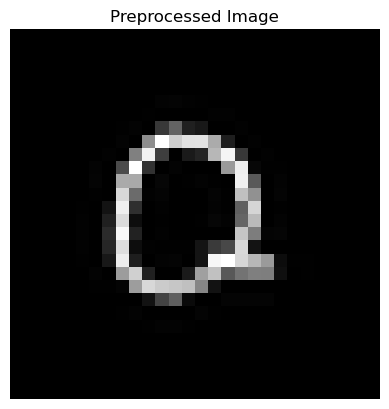

Prediction: 9, Confidence: 0.9043
Top 3 predictions:
  1. 9: 0.9043
  2. 0: 0.0465
  3. 8: 0.0218
Moved char_131.png to 9_28dc956d-1d19-480b-8ff5-bc9c4ad04e7e.png
Processing 36/239: char_132.png


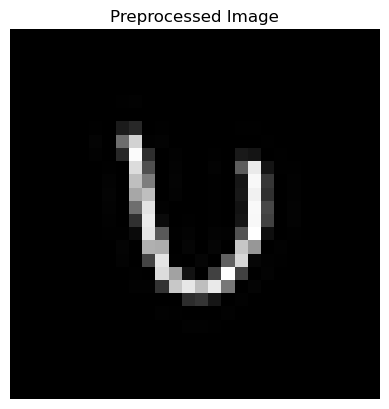

Prediction: U, Confidence: 0.3026
Top 3 predictions:
  1. U: 0.3026
  2. 4: 0.2196
  3. 0: 0.1577
Moved char_132.png to U_4204fe33-902f-4adc-8fb6-e911ede2591d.png
Processing 37/239: char_133.png


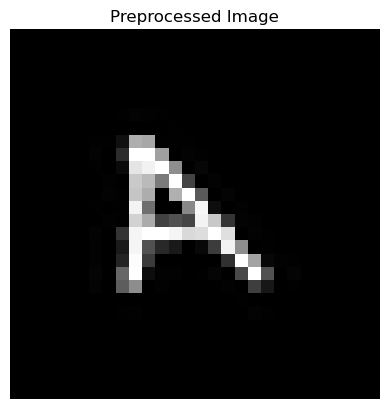

Prediction: A, Confidence: 0.9826
Top 3 predictions:
  1. A: 0.9826
  2. M: 0.0118
  3. H: 0.0015
Moved char_133.png to A_e472f225-0cbf-41f7-853e-9b90a28764bf.png
Processing 38/239: char_134.png


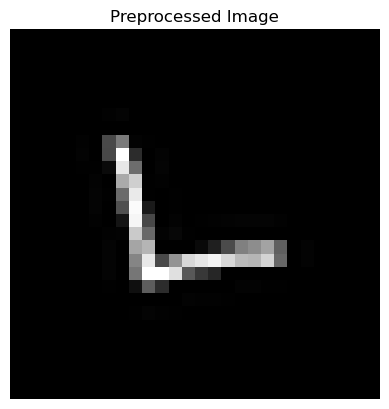

Prediction: L, Confidence: 0.9954
Top 3 predictions:
  1. L: 0.9954
  2. C: 0.0016
  3. Z: 0.0014
Moved char_134.png to L_44457f15-9a9d-45bd-9ef6-3d5bf63d10aa.png
Processing 39/239: char_135.png


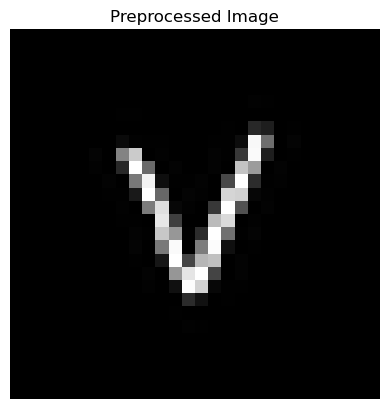

Prediction: Y, Confidence: 0.8179
Top 3 predictions:
  1. Y: 0.8179
  2. V: 0.0861
  3. X: 0.0254
Moved char_135.png to Y_2ff0d9ba-3989-4af4-9cc9-6828d864ccd6.png
Processing 40/239: char_136.png


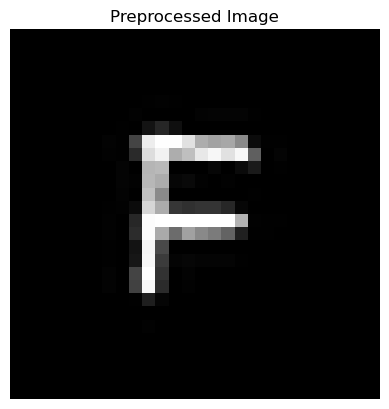

Prediction: E, Confidence: 0.7206
Top 3 predictions:
  1. E: 0.7206
  2. F: 0.2722
  3. 5: 0.0060
Moved char_136.png to E_5a928e57-e6e6-43a2-a6f0-2890b48a4c22.png
Processing 41/239: char_137.png


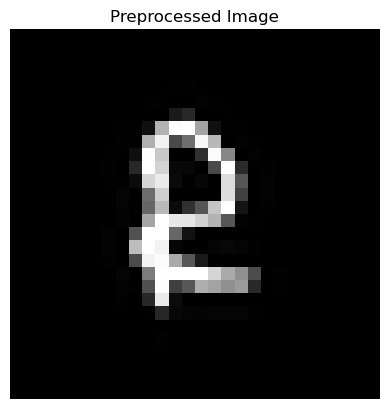

Prediction: R, Confidence: 0.9993
Top 3 predictions:
  1. R: 0.9993
  2. B: 0.0002
  3. 8: 0.0001
Moved char_137.png to R_e63b42b2-1ada-4a2d-823e-449fec557e36.png
Processing 42/239: char_138.png


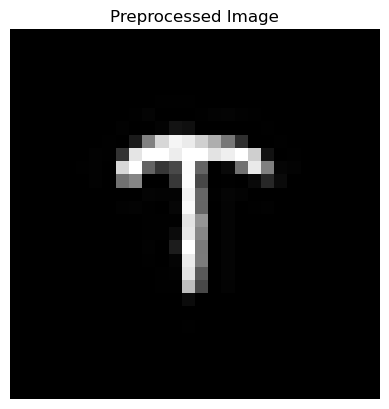

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_138.png to T_8f6cc764-0d66-4ee3-b3f4-c62e07d3e1a1.png
Processing 43/239: char_139.png


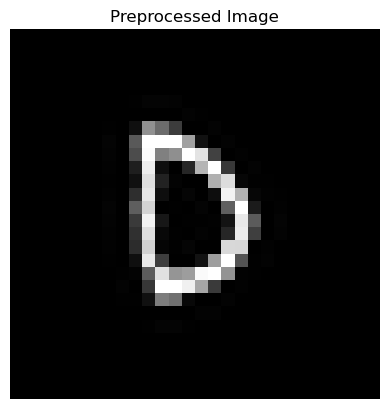

Prediction: D, Confidence: 0.9287
Top 3 predictions:
  1. D: 0.9287
  2. 0: 0.0244
  3. P: 0.0236
Moved char_139.png to D_5ce5aade-9f32-4ae4-a9f9-8ebd7c2abe4f.png
Processing 44/239: char_14.png


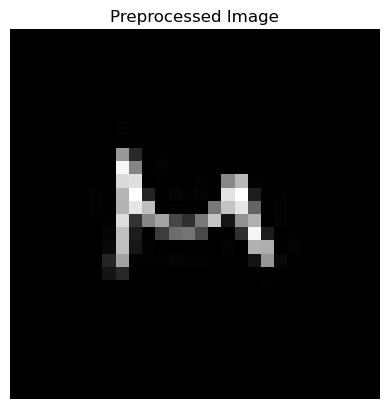

Prediction: M, Confidence: 0.9998
Top 3 predictions:
  1. M: 0.9998
  2. N: 0.0001
  3. U: 0.0000
Moved char_14.png to M_413760db-c8fb-4c12-a33f-5dc1dc8c7654.png
Processing 45/239: char_140.png


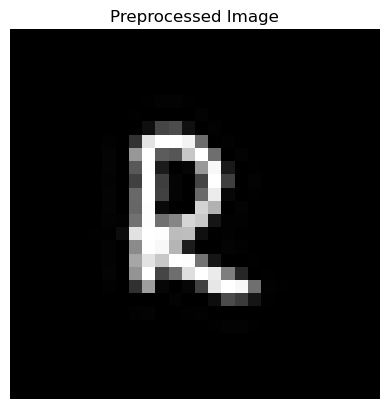

Prediction: R, Confidence: 1.0000
Top 3 predictions:
  1. R: 1.0000
  2. P: 0.0000
  3. B: 0.0000
Moved char_140.png to R_4ff95fad-2037-4ec1-a748-c16a984b13f2.png
Processing 46/239: char_141.png


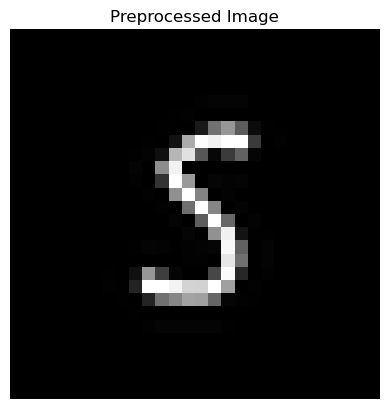

Prediction: 5, Confidence: 0.9809
Top 3 predictions:
  1. 5: 0.9809
  2. S: 0.0186
  3. 3: 0.0004
Moved char_141.png to 5_06247e8c-3932-4638-8fe8-ee2798953412.png
Processing 47/239: char_142.png


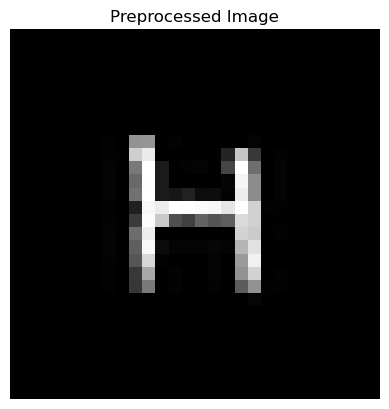

Prediction: H, Confidence: 0.9938
Top 3 predictions:
  1. H: 0.9938
  2. 4: 0.0028
  3. W: 0.0012
Moved char_142.png to H_6d76379d-f793-449e-a33b-49b09e5bd643.png
Processing 48/239: char_143.png


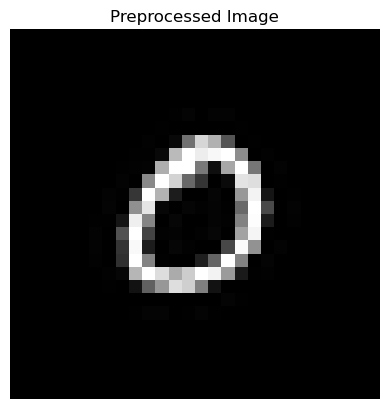

Prediction: 0, Confidence: 0.9818
Top 3 predictions:
  1. 0: 0.9818
  2. O: 0.0151
  3. 8: 0.0027
Moved char_143.png to 0_a7b5dfba-6890-42a1-8ee0-15d3892b8272.png
Processing 49/239: char_144.png


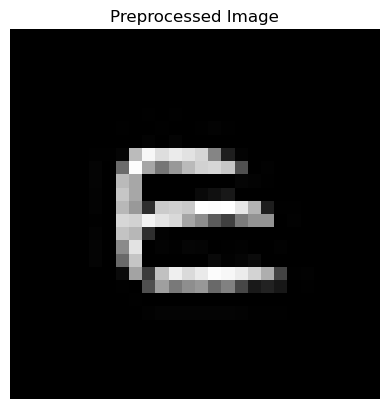

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_144.png to E_3ff78529-f167-4055-8ad0-347df95377fd.png
Processing 50/239: char_145.png


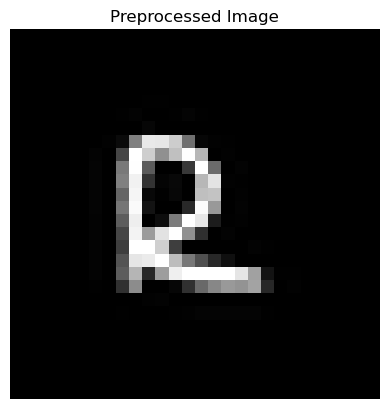

Prediction: R, Confidence: 1.0000
Top 3 predictions:
  1. R: 1.0000
  2. Q: 0.0000
  3. B: 0.0000
Moved char_145.png to R_a6c169d6-e581-4402-8ae3-0139a8fbe52c.png
Processing 51/239: char_146.png


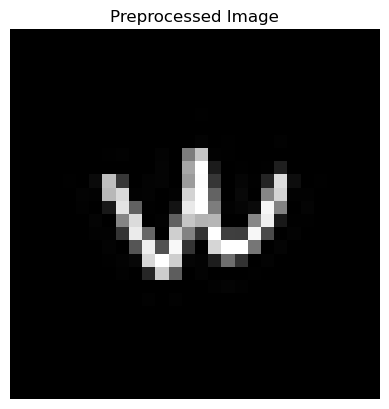

Prediction: W, Confidence: 0.9999
Top 3 predictions:
  1. W: 0.9999
  2. N: 0.0000
  3. M: 0.0000
Created directory: testing_data/data/W
Moved char_146.png to W_3b189c8d-1062-42d9-a6f4-cd0578cfd8f8.png
Processing 52/239: char_147.png


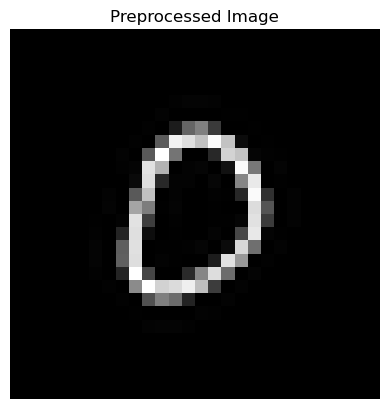

Prediction: 0, Confidence: 0.9948
Top 3 predictions:
  1. 0: 0.9948
  2. O: 0.0050
  3. 8: 0.0001
Moved char_147.png to 0_bd140600-8b31-4e11-8838-a704f72aaba0.png
Processing 53/239: char_148.png


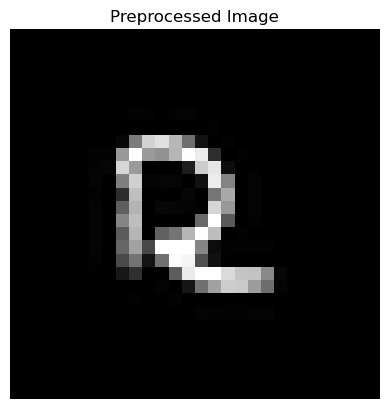

Prediction: R, Confidence: 0.9979
Top 3 predictions:
  1. R: 0.9979
  2. Q: 0.0007
  3. P: 0.0005
Moved char_148.png to R_0b0fcb34-c72a-43de-bbc8-3bad0f6b9917.png
Processing 54/239: char_149.png


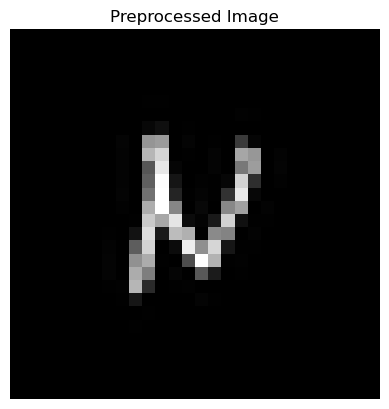

Prediction: N, Confidence: 0.9994
Top 3 predictions:
  1. N: 0.9994
  2. W: 0.0006
  3. H: 0.0000
Moved char_149.png to N_6cc094b3-f4ba-4dc9-9c64-c378b821b87a.png
Processing 55/239: char_15.png


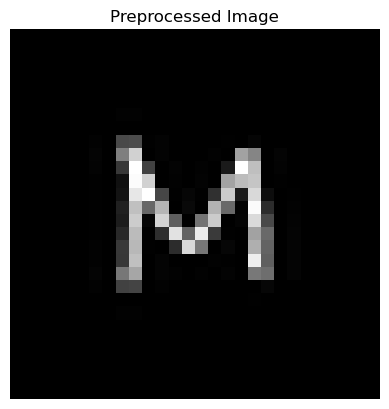

Prediction: M, Confidence: 0.9997
Top 3 predictions:
  1. M: 0.9997
  2. N: 0.0003
  3. W: 0.0000
Moved char_15.png to M_adf6fcc8-59f0-45d7-8665-13b57c72ee74.png
Processing 56/239: char_150.png


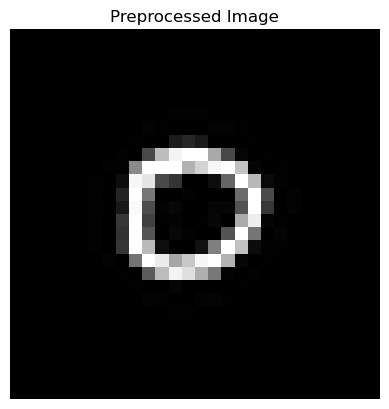

Prediction: 0, Confidence: 0.9460
Top 3 predictions:
  1. 0: 0.9460
  2. O: 0.0286
  3. 8: 0.0222
Moved char_150.png to 0_80db10a1-a693-4b35-adfb-e3dc2819bb5c.png
Processing 57/239: char_151.png


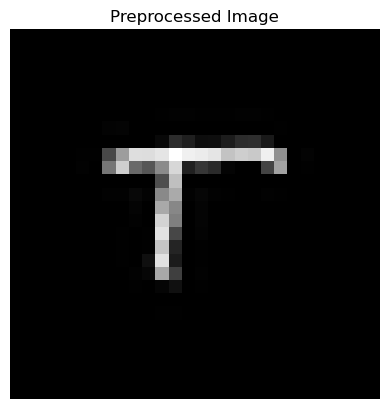

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_151.png to T_78db1688-a775-4948-9258-18de1ce4f39d.png
Processing 58/239: char_152.png


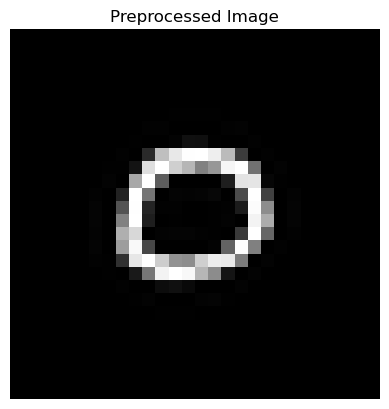

Prediction: 0, Confidence: 0.9702
Top 3 predictions:
  1. 0: 0.9702
  2. O: 0.0242
  3. 8: 0.0037
Moved char_152.png to 0_b4c90e7f-d3c6-4d91-af2e-ff5c03ae8cef.png
Processing 59/239: char_153.png


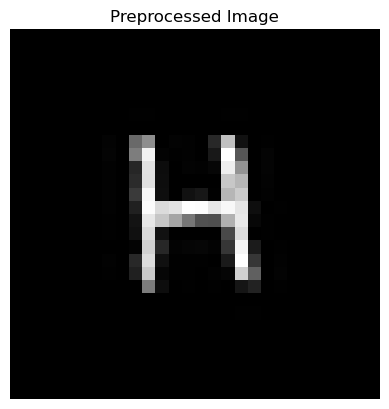

Prediction: H, Confidence: 0.9824
Top 3 predictions:
  1. H: 0.9824
  2. W: 0.0094
  3. N: 0.0037
Moved char_153.png to H_80418c79-0e27-4990-b771-de1d95e167c9.png
Processing 60/239: char_154.png


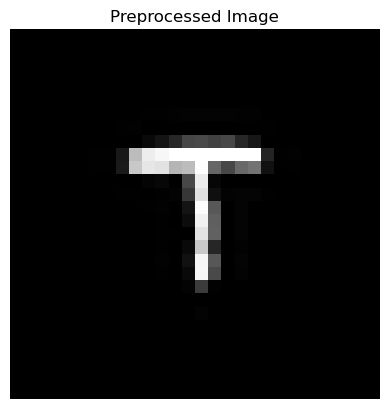

Prediction: T, Confidence: 0.9981
Top 3 predictions:
  1. T: 0.9981
  2. J: 0.0018
  3. O: 0.0000
Moved char_154.png to T_7d916050-24d4-4c27-9bca-f20eb29abf89.png
Processing 61/239: char_155.png


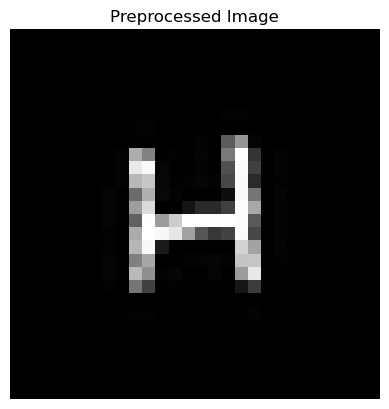

Prediction: H, Confidence: 0.8451
Top 3 predictions:
  1. H: 0.8451
  2. 4: 0.1379
  3. W: 0.0120
Moved char_155.png to H_2bbbce31-7267-41b7-b2c6-f8fd3cace0f1.png
Processing 62/239: char_156.png


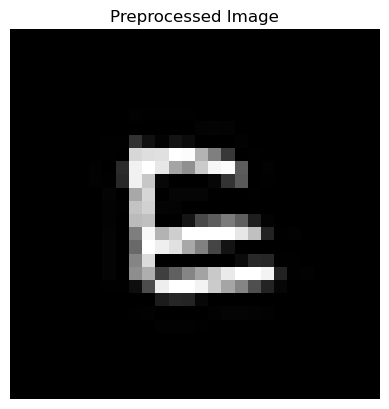

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_156.png to E_d7acff66-4297-419f-ace1-0ba053aa660b.png
Processing 63/239: char_157.png


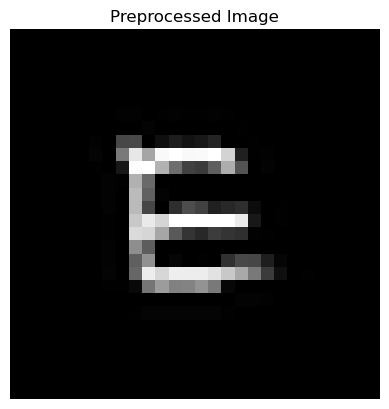

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_157.png to E_86e9f8e4-1c19-4519-bf79-efe9b57fc692.png
Processing 64/239: char_158.png


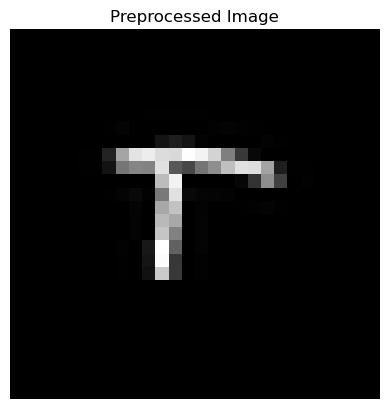

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_158.png to T_a6fe5862-3f3d-4d04-914a-a35ea3ba0468.png
Processing 65/239: char_159.png


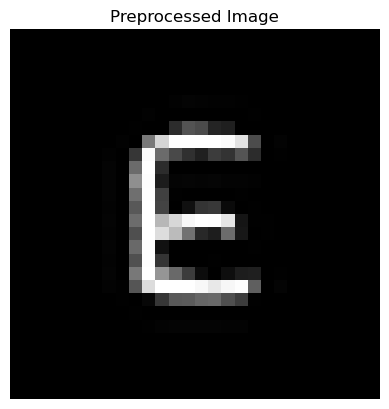

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_159.png to E_f31efad2-0717-437c-bd15-e3e6ad582256.png
Processing 66/239: char_16.png


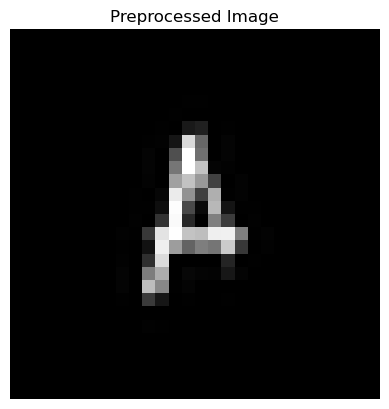

Prediction: A, Confidence: 0.9363
Top 3 predictions:
  1. A: 0.9363
  2. 4: 0.0220
  3. 1: 0.0216
Moved char_16.png to A_a4fd5d6c-0ed8-4e5e-a936-ee11b7f2422e.png
Processing 67/239: char_160.png


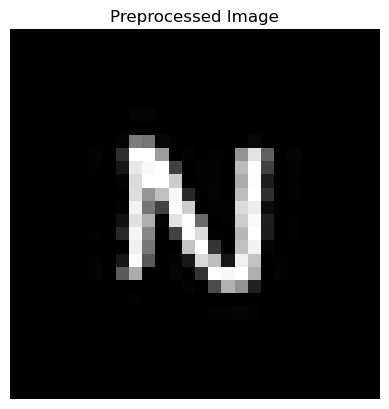

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. H: 0.0000
Moved char_160.png to N_9c123c62-705d-48cb-b92b-53bb648fa962.png
Processing 68/239: char_161.png


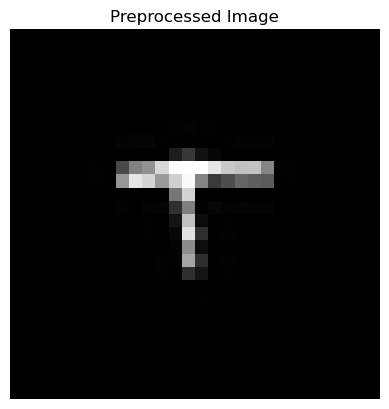

Prediction: T, Confidence: 0.9950
Top 3 predictions:
  1. T: 0.9950
  2. J: 0.0045
  3. O: 0.0004
Moved char_161.png to T_9ce87a5e-db38-4944-bb09-f0c39a9f235e.png
Processing 69/239: char_162.png


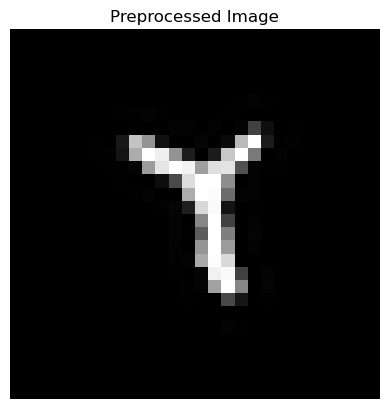

Prediction: Y, Confidence: 0.9992
Top 3 predictions:
  1. Y: 0.9992
  2. X: 0.0003
  3. P: 0.0003
Moved char_162.png to Y_54d45fae-7720-4fdd-8c39-da85c60ccb58.png
Processing 70/239: char_163.png


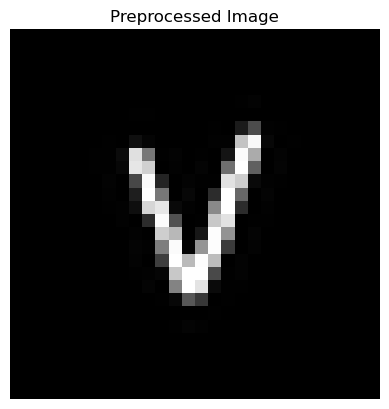

Prediction: Y, Confidence: 0.5342
Top 3 predictions:
  1. Y: 0.5342
  2. 4: 0.1364
  3. V: 0.1230
Moved char_163.png to Y_b6ba90f9-1496-414c-88bb-c897f7b6bac5.png
Processing 71/239: char_164.png


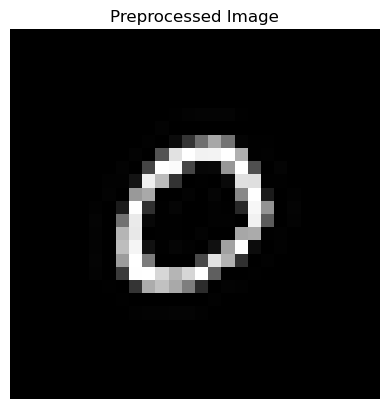

Prediction: 0, Confidence: 0.9406
Top 3 predictions:
  1. 0: 0.9406
  2. O: 0.0579
  3. 8: 0.0010
Moved char_164.png to 0_95627368-fea6-4425-9377-870aa4ee0f64.png
Processing 72/239: char_165.png


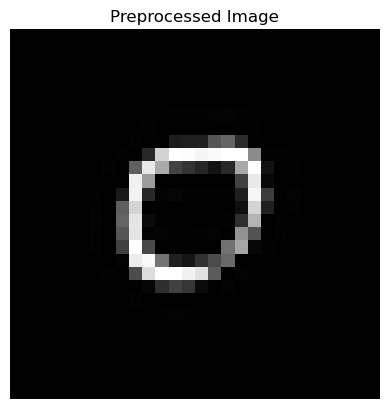

Prediction: 0, Confidence: 0.9102
Top 3 predictions:
  1. 0: 0.9102
  2. O: 0.0848
  3. 9: 0.0024
Moved char_165.png to 0_22b11c93-2491-4c98-85a5-6d5cb77a981a.png
Processing 73/239: char_166.png


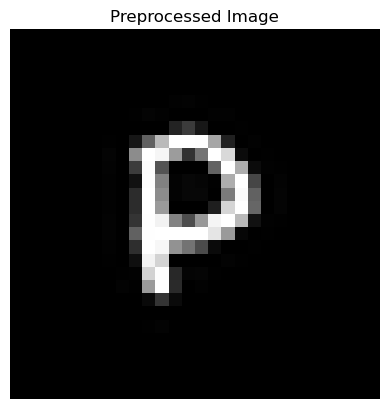

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. 8: 0.0000
Moved char_166.png to P_7cd93896-6fbe-49ed-a109-7cd0ea96e8e6.png
Processing 74/239: char_167.png


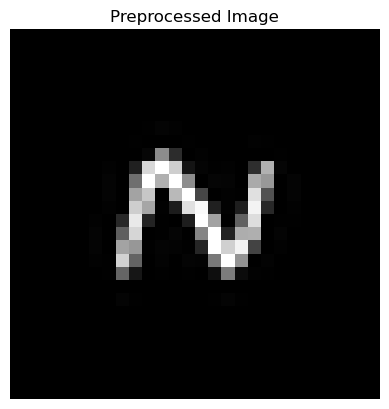

Prediction: N, Confidence: 0.9999
Top 3 predictions:
  1. N: 0.9999
  2. W: 0.0001
  3. M: 0.0000
Moved char_167.png to N_6da3db69-6090-4aa4-9a7f-7f6d4d198936.png
Processing 75/239: char_168.png


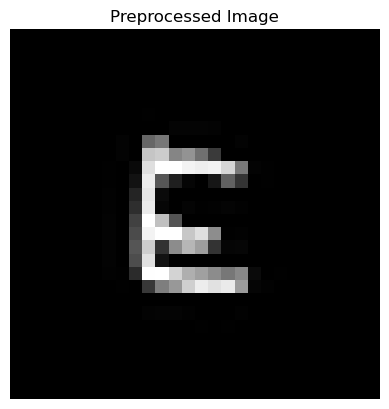

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. C: 0.0000
Moved char_168.png to E_ea75d0f8-b572-4749-ac3b-4b9001e9d400.png
Processing 76/239: char_169.png


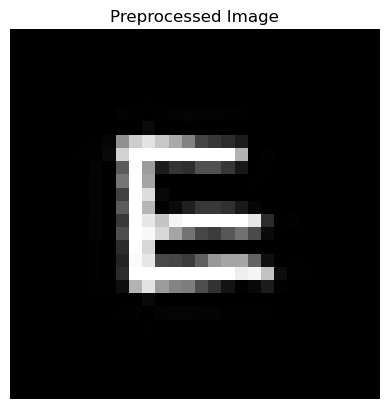

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_169.png to E_c1e7f0c2-1d37-4d56-bfd7-d005b779625a.png
Processing 77/239: char_17.png


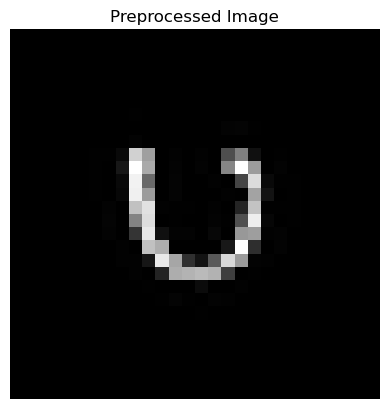

Prediction: 0, Confidence: 0.8074
Top 3 predictions:
  1. 0: 0.8074
  2. 4: 0.0488
  3. 5: 0.0443
Moved char_17.png to 0_314d85cb-2a75-454d-802b-8de2468289ae.png
Processing 78/239: char_170.png


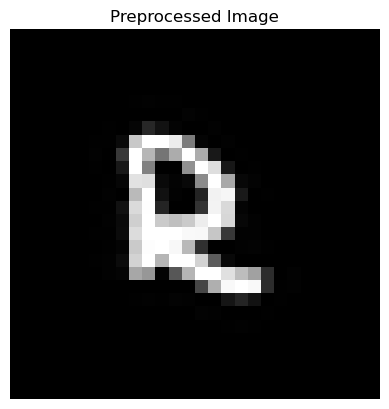

Prediction: R, Confidence: 0.9999
Top 3 predictions:
  1. R: 0.9999
  2. P: 0.0000
  3. 2: 0.0000
Moved char_170.png to R_44591182-80a8-4293-a613-55bf724a7961.png
Processing 79/239: char_171.png


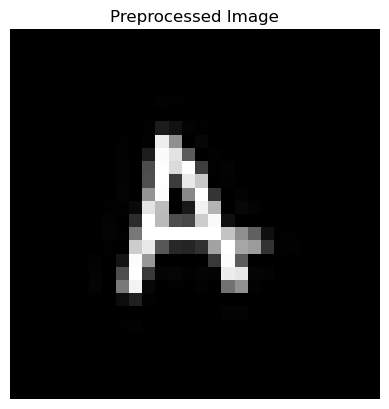

Prediction: A, Confidence: 1.0000
Top 3 predictions:
  1. A: 1.0000
  2. M: 0.0000
  3. H: 0.0000
Moved char_171.png to A_d39a83a1-3724-44ce-80e2-bcb67463eab1.png
Processing 80/239: char_172.png


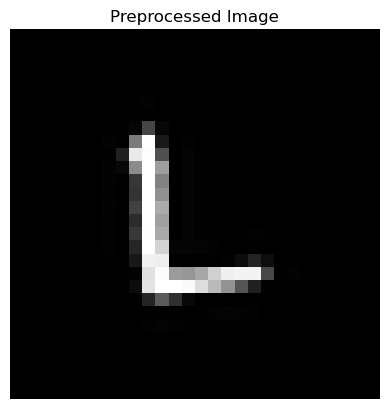

Prediction: L, Confidence: 0.9999
Top 3 predictions:
  1. L: 0.9999
  2. C: 0.0001
  3. 1: 0.0000
Moved char_172.png to L_afae6c32-403c-4c19-867e-897b29e90b64.png
Processing 81/239: char_173.png


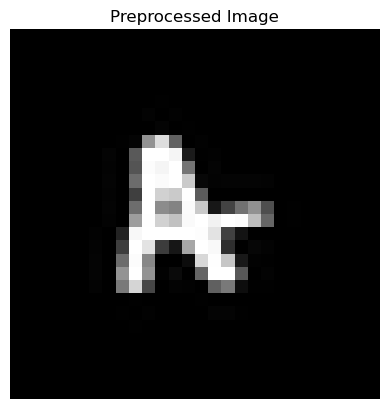

Prediction: A, Confidence: 0.8680
Top 3 predictions:
  1. A: 0.8680
  2. M: 0.1240
  3. H: 0.0054
Moved char_173.png to A_1ef05a61-beb0-40ed-9856-a2fadc52d354.png
Processing 82/239: char_174.png


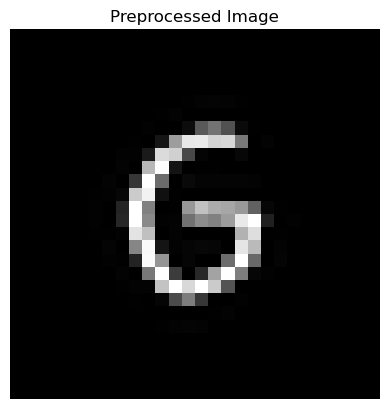

Prediction: 6, Confidence: 0.9961
Top 3 predictions:
  1. 6: 0.9961
  2. 5: 0.0020
  3. 8: 0.0014
Moved char_174.png to 6_f90bb851-637c-464c-8f4b-221f3bc5b4fe.png
Processing 83/239: char_175.png


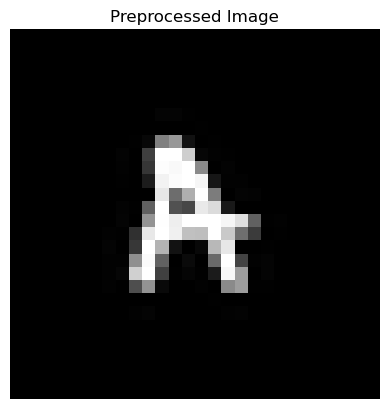

Prediction: A, Confidence: 0.9996
Top 3 predictions:
  1. A: 0.9996
  2. M: 0.0003
  3. H: 0.0001
Moved char_175.png to A_e76049f6-49a1-4cc6-a7fc-2c2a0357b383.png
Processing 84/239: char_176.png


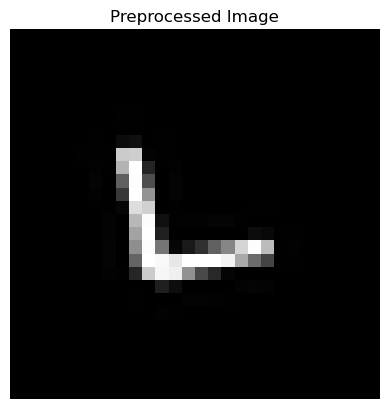

Prediction: L, Confidence: 0.9740
Top 3 predictions:
  1. L: 0.9740
  2. C: 0.0068
  3. 2: 0.0057
Moved char_176.png to L_29b2f1df-25d3-42eb-8a5b-945d97406fe7.png
Processing 85/239: char_177.png


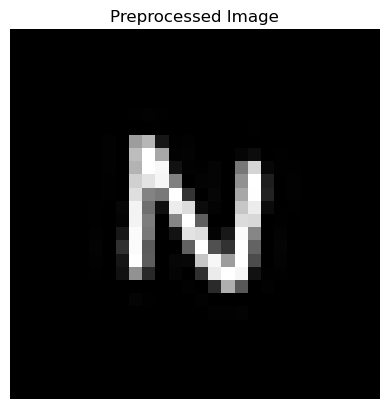

Prediction: N, Confidence: 0.9992
Top 3 predictions:
  1. N: 0.9992
  2. W: 0.0008
  3. H: 0.0000
Moved char_177.png to N_c36c791e-f8c0-44ac-8b1c-8cc1560bc889.png
Processing 86/239: char_178.png


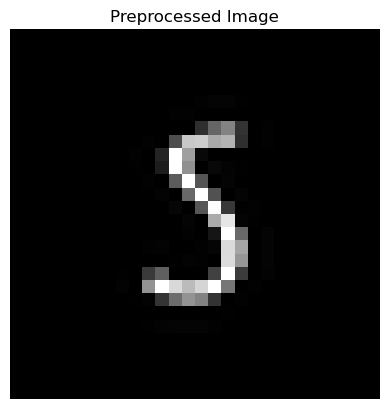

Prediction: 5, Confidence: 0.8514
Top 3 predictions:
  1. 5: 0.8514
  2. S: 0.1472
  3. 3: 0.0009
Moved char_178.png to 5_43bb27d6-2837-40bc-a825-0f8301f2346b.png
Processing 87/239: char_179.png


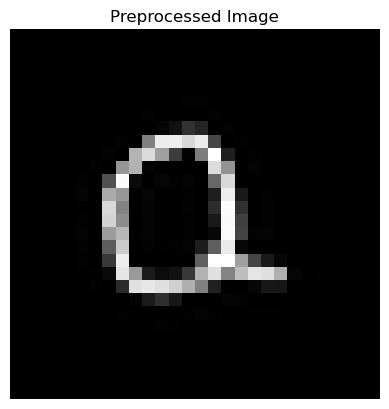

Prediction: Q, Confidence: 0.6878
Top 3 predictions:
  1. Q: 0.6878
  2. 9: 0.2282
  3. G: 0.0537
Moved char_179.png to Q_f92320fe-f685-4cfa-94a5-092ee36e01e7.png
Processing 88/239: char_18.png


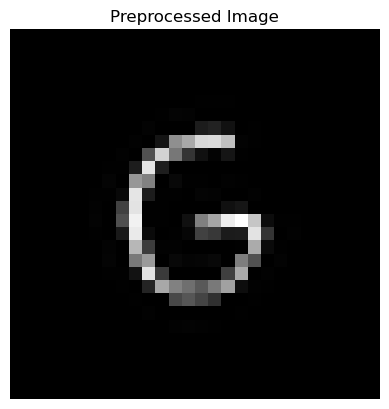

Prediction: 6, Confidence: 0.8485
Top 3 predictions:
  1. 6: 0.8485
  2. 5: 0.0807
  3. 8: 0.0385
Moved char_18.png to 6_aae11291-111c-4758-a266-73afbdc53917.png
Processing 89/239: char_180.png


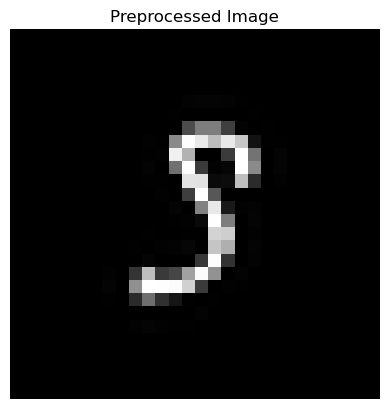

Prediction: 5, Confidence: 0.8141
Top 3 predictions:
  1. 5: 0.8141
  2. S: 0.1776
  3. 8: 0.0035
Moved char_180.png to 5_9edce78f-fa6d-408d-9414-90df71d02ade.png
Processing 90/239: char_181.png


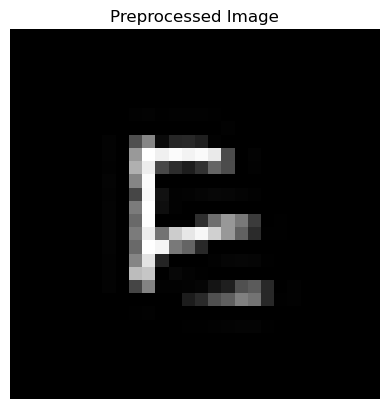

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. F: 0.0000
  3. B: 0.0000
Moved char_181.png to E_d36b635e-ab82-4b23-919a-0446a63ed958.png
Processing 91/239: char_182.png


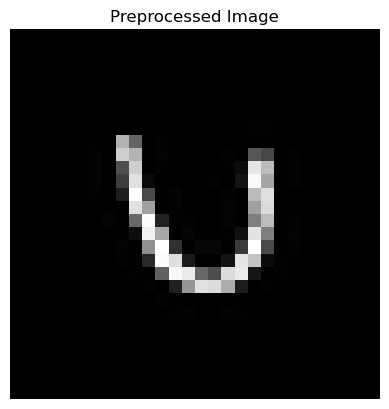

Prediction: U, Confidence: 0.7102
Top 3 predictions:
  1. U: 0.7102
  2. Y: 0.0504
  3. J: 0.0455
Moved char_182.png to U_61b2983e-ce7b-47d2-887c-8bc055ec7723.png
Processing 92/239: char_183.png


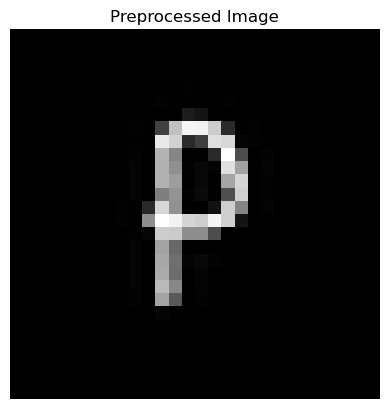

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. B: 0.0000
Moved char_183.png to P_46ea604d-a8fa-4c37-bf54-f5c7e1fc8aa9.png
Processing 93/239: char_184.png


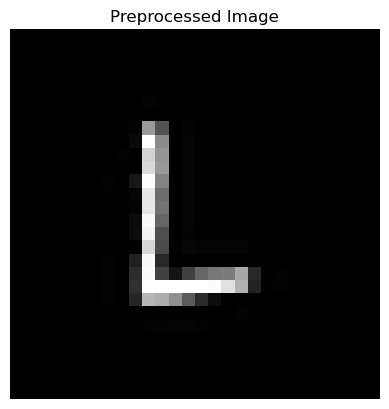

Prediction: L, Confidence: 1.0000
Top 3 predictions:
  1. L: 1.0000
  2. C: 0.0000
  3. U: 0.0000
Moved char_184.png to L_62b03463-1c17-4e79-84df-24a3fcccbaa8.png
Processing 94/239: char_185.png


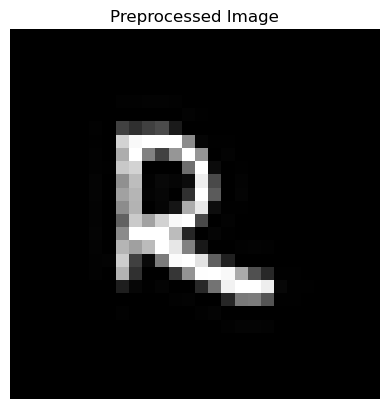

Prediction: R, Confidence: 1.0000
Top 3 predictions:
  1. R: 1.0000
  2. B: 0.0000
  3. P: 0.0000
Moved char_185.png to R_bf858cdb-0925-4365-b55d-e8b9c1a6b5c4.png
Processing 95/239: char_186.png


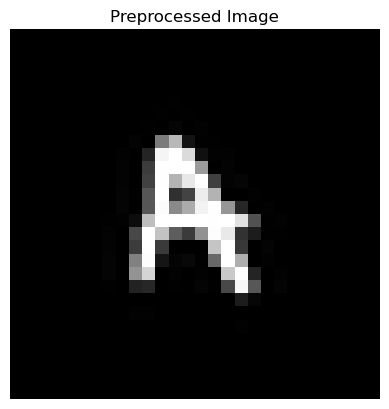

Prediction: A, Confidence: 0.9996
Top 3 predictions:
  1. A: 0.9996
  2. M: 0.0003
  3. H: 0.0000
Moved char_186.png to A_8a8da6e5-0b36-492e-a5d6-459b4493aba2.png
Processing 96/239: char_187.png


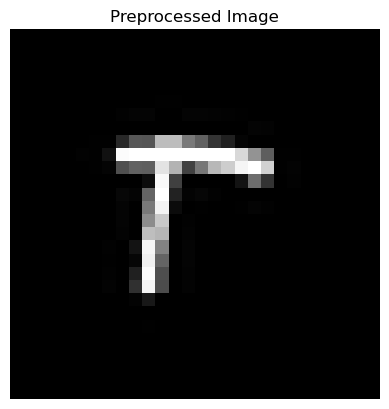

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_187.png to T_7a4a4456-b9ec-4eca-8c66-f787ac116c83.png
Processing 97/239: char_188.png


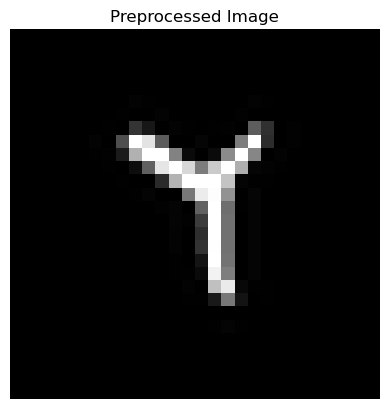

Prediction: Y, Confidence: 1.0000
Top 3 predictions:
  1. Y: 1.0000
  2. P: 0.0000
  3. X: 0.0000
Moved char_188.png to Y_e03e0980-ec0c-4e49-a1f6-a128fe10b7e8.png
Processing 98/239: char_189.png


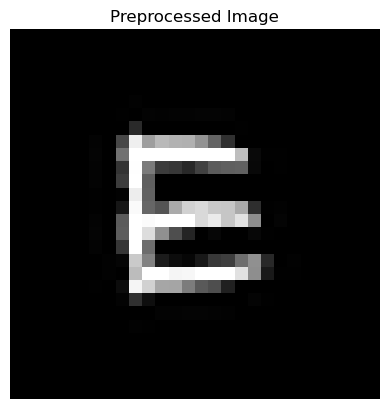

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_189.png to E_0b58061f-6fe7-4b5a-9046-8ffcb68bcdb2.png
Processing 99/239: char_19.png


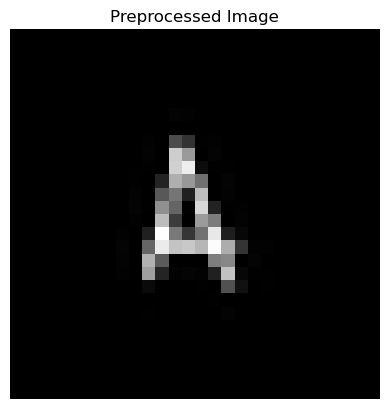

Prediction: A, Confidence: 0.9691
Top 3 predictions:
  1. A: 0.9691
  2. D: 0.0091
  3. O: 0.0049
Moved char_19.png to A_5f2059eb-a75e-4f8a-9ca5-aa18b8503c68.png
Processing 100/239: char_190.png


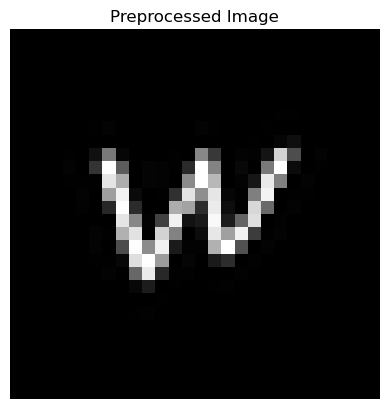

Prediction: W, Confidence: 1.0000
Top 3 predictions:
  1. W: 1.0000
  2. N: 0.0000
  3. H: 0.0000
Moved char_190.png to W_01813377-c31a-4d4f-ac98-e9d6bb7f32b3.png
Processing 101/239: char_191.png


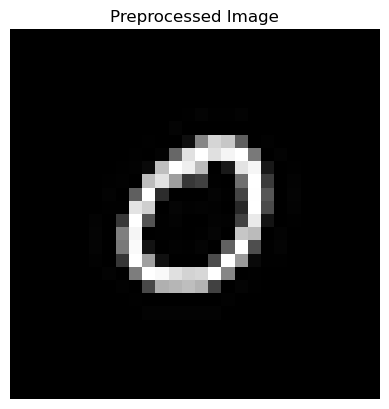

Prediction: 0, Confidence: 0.9906
Top 3 predictions:
  1. 0: 0.9906
  2. O: 0.0081
  3. 8: 0.0010
Moved char_191.png to 0_1c9f4c2d-5566-4c29-842c-73e2471fe40f.png
Processing 102/239: char_192.png


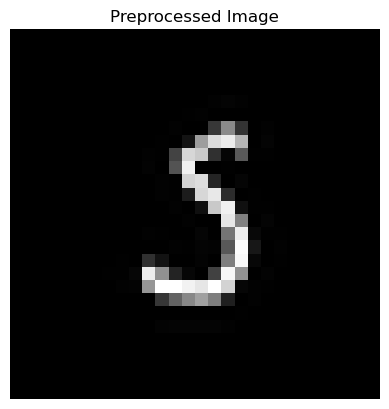

Prediction: 5, Confidence: 0.7017
Top 3 predictions:
  1. 5: 0.7017
  2. S: 0.2956
  3. 3: 0.0023
Moved char_192.png to 5_5dd8aabc-e19f-4455-8656-cc67801297ae.png
Processing 103/239: char_193.png


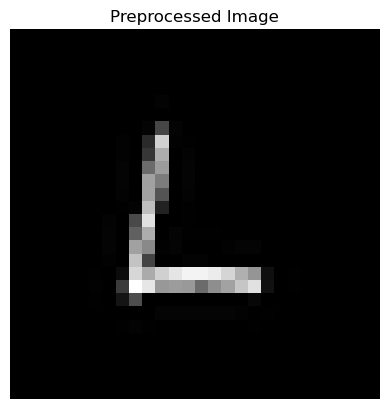

Prediction: L, Confidence: 1.0000
Top 3 predictions:
  1. L: 1.0000
  2. C: 0.0000
  3. U: 0.0000
Moved char_193.png to L_c293c3db-3d62-4790-ac94-6d87a8f8327b.png
Processing 104/239: char_194.png


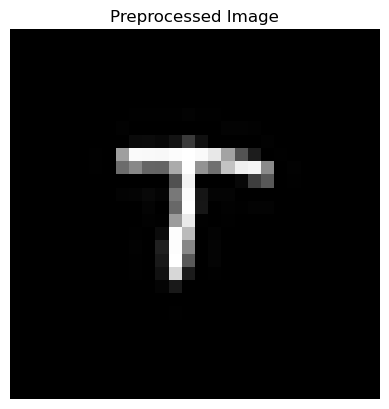

Prediction: T, Confidence: 0.9994
Top 3 predictions:
  1. T: 0.9994
  2. J: 0.0006
  3. U: 0.0000
Moved char_194.png to T_ec3ac4aa-d5a2-424a-9db0-41c9e0aa94db.png
Processing 105/239: char_195.png


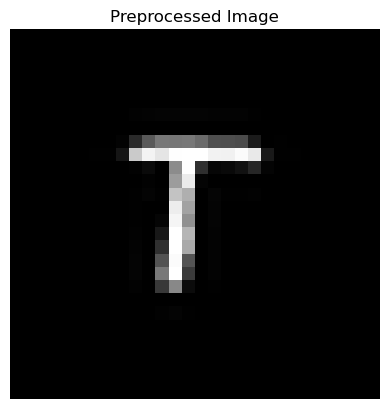

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_195.png to T_9d3f574e-eda9-4a93-b022-8d1032cc7529.png
Processing 106/239: char_196.png


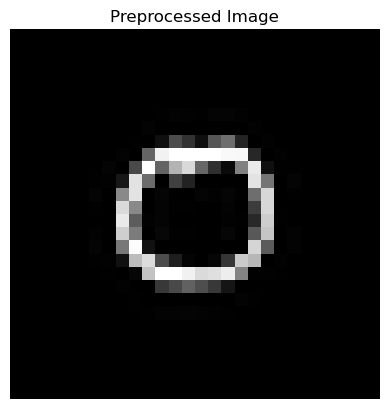

Prediction: 0, Confidence: 0.9100
Top 3 predictions:
  1. 0: 0.9100
  2. O: 0.0896
  3. 8: 0.0003
Moved char_196.png to 0_2304b6d6-1d2b-4d1c-ba63-29a1a847cccc.png
Processing 107/239: char_197.png


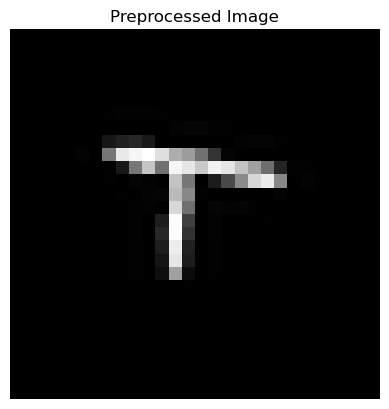

Prediction: T, Confidence: 0.9999
Top 3 predictions:
  1. T: 0.9999
  2. J: 0.0001
  3. O: 0.0000
Moved char_197.png to T_cb42516e-4b80-4e3f-9a04-bea28b452b62.png
Processing 108/239: char_198.png


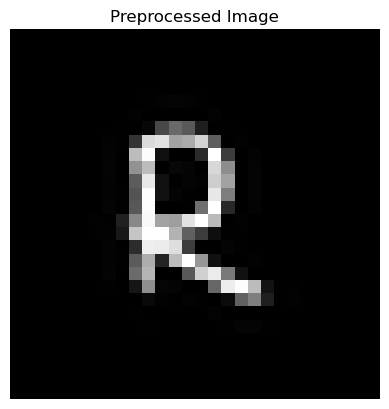

Prediction: R, Confidence: 1.0000
Top 3 predictions:
  1. R: 1.0000
  2. P: 0.0000
  3. B: 0.0000
Moved char_198.png to R_cf4432d6-7651-4b44-be89-2483de11855c.png
Processing 109/239: char_199.png


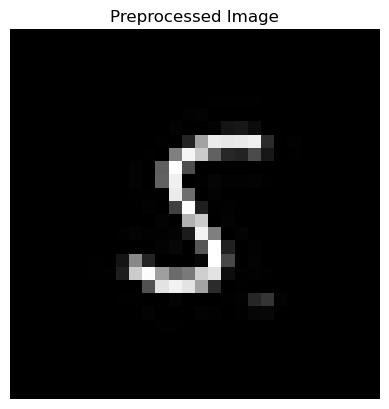

Prediction: 5, Confidence: 0.6827
Top 3 predictions:
  1. 5: 0.6827
  2. S: 0.3171
  3. 6: 0.0001
Moved char_199.png to 5_f29566de-c189-43a3-a486-d7705e26bca6.png
Processing 110/239: char_20.png


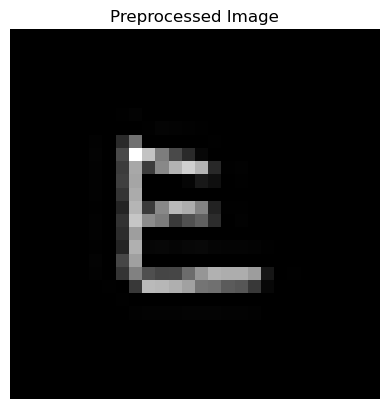

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. C: 0.0000
Moved char_20.png to E_1713b57e-b94e-441c-a95c-01a704815b30.png
Processing 111/239: char_200.png


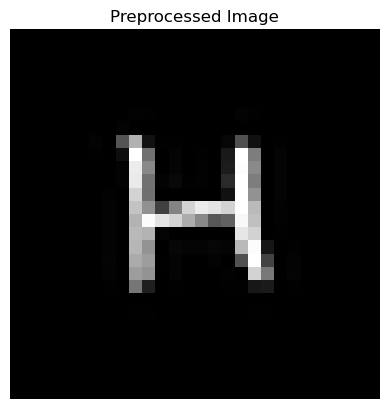

Prediction: H, Confidence: 0.6494
Top 3 predictions:
  1. H: 0.6494
  2. 4: 0.2791
  3. W: 0.0536
Moved char_200.png to H_18525391-6a13-4a14-9e3b-dd1da8374bed.png
Processing 112/239: char_201.png


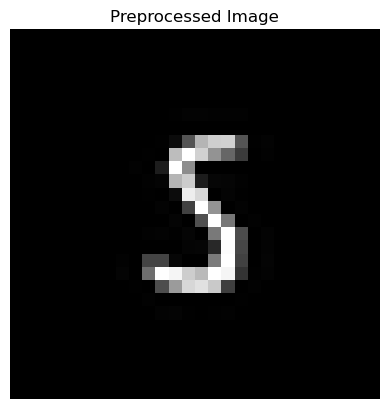

Prediction: S, Confidence: 0.8861
Top 3 predictions:
  1. S: 0.8861
  2. 5: 0.1114
  3. J: 0.0011
Moved char_201.png to S_e2968b8f-7552-47d2-807a-be57317b864e.png
Processing 113/239: char_202.png


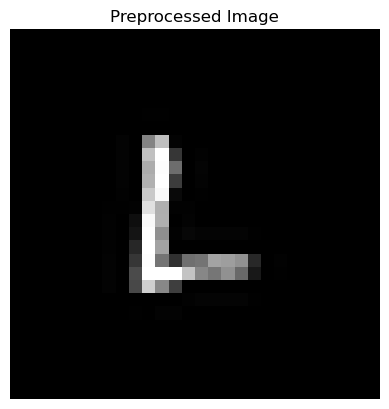

Prediction: L, Confidence: 0.9982
Top 3 predictions:
  1. L: 0.9982
  2. Z: 0.0009
  3. 2: 0.0003
Moved char_202.png to L_cb685795-bb3b-472b-a50e-0276c9e2428d.png
Processing 114/239: char_203.png


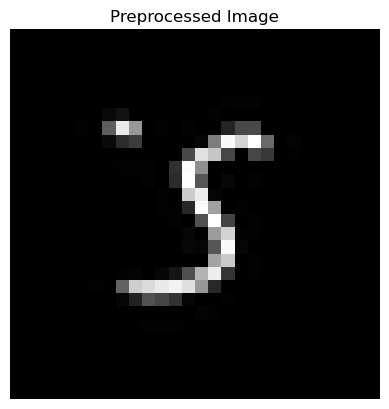

Prediction: 5, Confidence: 0.9738
Top 3 predictions:
  1. 5: 0.9738
  2. S: 0.0197
  3. 3: 0.0059
Moved char_203.png to 5_ccc8c815-44a9-48f2-b1f6-25240791270b.png
Processing 115/239: char_204.png


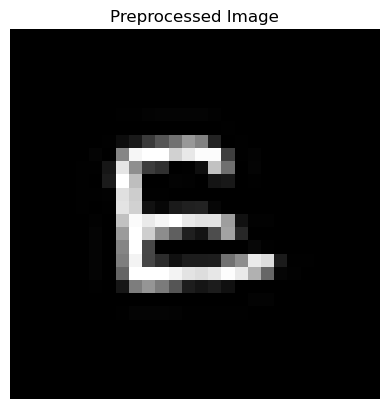

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. S: 0.0000
  3. B: 0.0000
Moved char_204.png to E_e45c15a9-8ae8-4daa-96f8-f62d319d1752.png
Processing 116/239: char_205.png


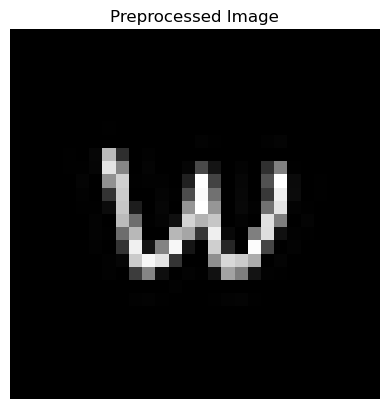

Prediction: W, Confidence: 1.0000
Top 3 predictions:
  1. W: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_205.png to W_c4db5a5e-1f05-4ef2-9fbb-2612ed8121dc.png
Processing 117/239: char_206.png


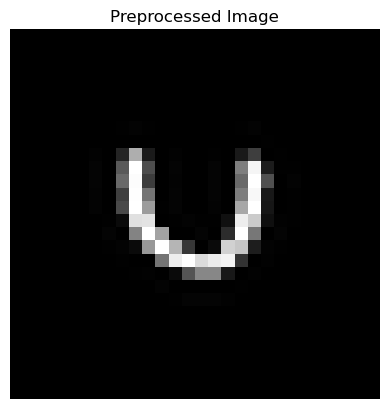

Prediction: 4, Confidence: 0.6090
Top 3 predictions:
  1. 4: 0.6090
  2. Y: 0.1153
  3. 2: 0.0830
Moved char_206.png to 4_2aa3177c-e68a-4662-b63f-5240d0773ce3.png
Processing 118/239: char_207.png


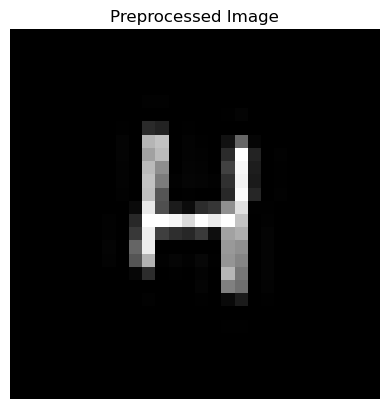

Prediction: 4, Confidence: 0.9959
Top 3 predictions:
  1. 4: 0.9959
  2. H: 0.0022
  3. Y: 0.0008
Moved char_207.png to 4_78483569-77c2-4f66-9ab9-1b5d80d24941.png
Processing 119/239: char_208.png


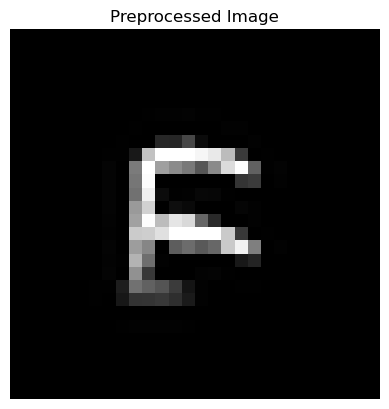

Prediction: E, Confidence: 0.9984
Top 3 predictions:
  1. E: 0.9984
  2. F: 0.0013
  3. B: 0.0001
Moved char_208.png to E_a978bc2c-c9f8-4331-b529-3ae3bff76e4f.png
Processing 120/239: char_209.png


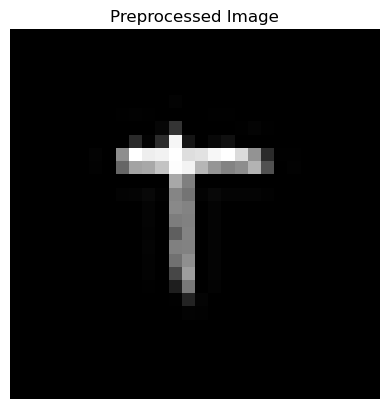

Prediction: T, Confidence: 0.9951
Top 3 predictions:
  1. T: 0.9951
  2. J: 0.0032
  3. O: 0.0011
Moved char_209.png to T_b160851e-d0d3-4831-92e6-46421f956694.png
Processing 121/239: char_21.png


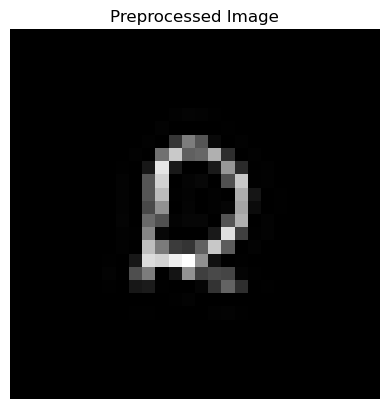

Prediction: P, Confidence: 0.4236
Top 3 predictions:
  1. P: 0.4236
  2. 8: 0.2843
  3. 0: 0.1077
Moved char_21.png to P_ba4cecde-c09e-405b-97ed-a1aa7911e6fb.png
Processing 122/239: char_210.png


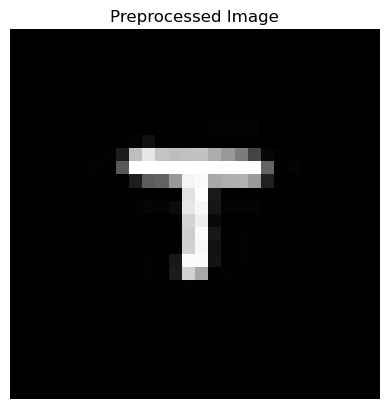

Prediction: T, Confidence: 0.9990
Top 3 predictions:
  1. T: 0.9990
  2. J: 0.0009
  3. O: 0.0000
Moved char_210.png to T_8c0fb5c8-3eb6-4289-9142-49e6edfd1c11.png
Processing 123/239: char_211.png


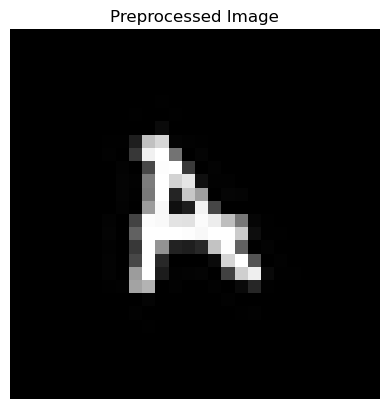

Prediction: A, Confidence: 0.9771
Top 3 predictions:
  1. A: 0.9771
  2. H: 0.0070
  3. M: 0.0057
Moved char_211.png to A_f200d562-1722-449e-ac11-7a1ea450990a.png
Processing 124/239: char_212.png


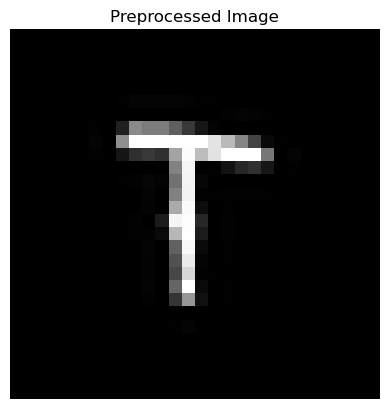

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_212.png to T_09d5e32f-c208-476b-8f33-bafffbd98755.png
Processing 125/239: char_213.png


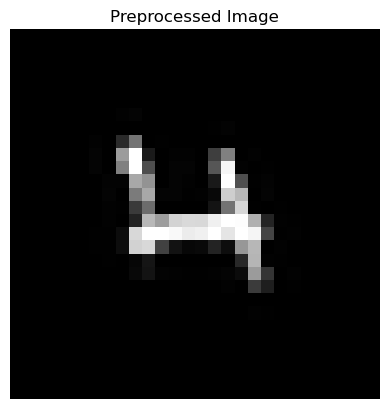

Prediction: 4, Confidence: 0.9953
Top 3 predictions:
  1. 4: 0.9953
  2. Y: 0.0027
  3. 9: 0.0007
Moved char_213.png to 4_0d475480-1183-4112-b51c-5402c4c9ecbe.png
Processing 126/239: char_214.png


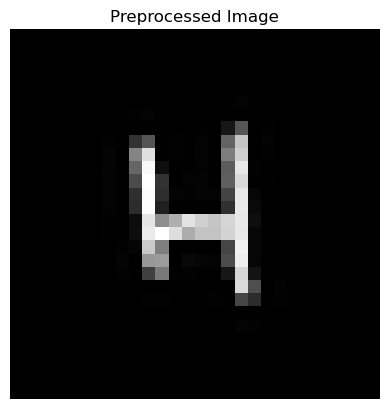

Prediction: 4, Confidence: 0.9517
Top 3 predictions:
  1. 4: 0.9517
  2. H: 0.0442
  3. Y: 0.0029
Moved char_214.png to 4_a0503531-5de2-4a89-8791-57b4af162773.png
Processing 127/239: char_215.png


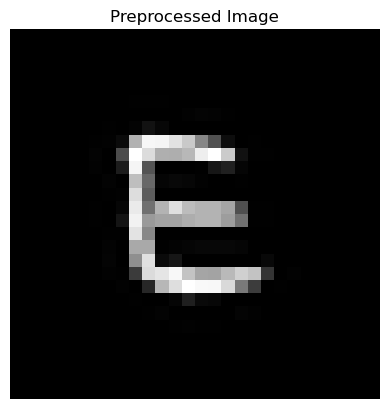

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_215.png to E_476f58b3-382a-4e21-8a0f-de52d6c41f48.png
Processing 128/239: char_216.png


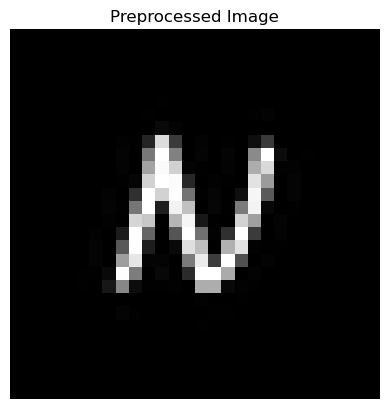

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. H: 0.0000
Moved char_216.png to N_395cd609-30d2-4b5b-b72c-dec89eaa01f0.png
Processing 129/239: char_217.png


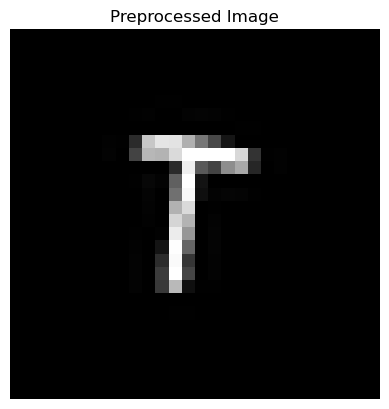

Prediction: T, Confidence: 0.9989
Top 3 predictions:
  1. T: 0.9989
  2. J: 0.0009
  3. O: 0.0001
Moved char_217.png to T_5e331528-1a24-4285-a648-0a92294e2e6b.png
Processing 130/239: char_218.png


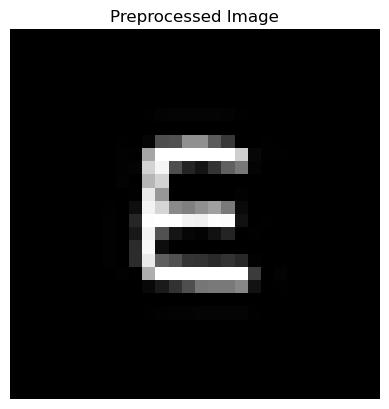

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_218.png to E_e396fbd5-0f95-4d16-89a6-7265a90cc419.png
Processing 131/239: char_219.png


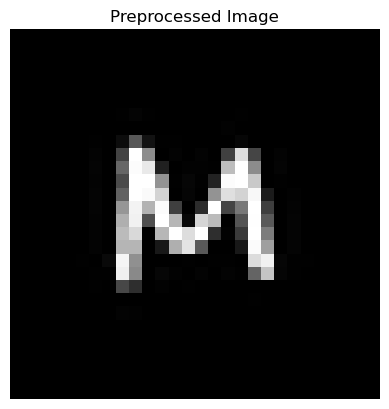

Prediction: M, Confidence: 1.0000
Top 3 predictions:
  1. M: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_219.png to M_c810097e-1c14-41c8-98f0-3148e112e825.png
Processing 132/239: char_22.png


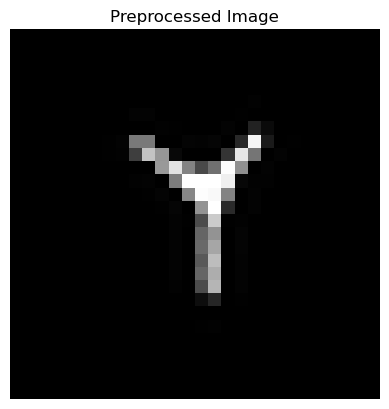

Prediction: Y, Confidence: 1.0000
Top 3 predictions:
  1. Y: 1.0000
  2. P: 0.0000
  3. X: 0.0000
Moved char_22.png to Y_9a2667cc-3076-4643-ac73-b069ada8af1f.png
Processing 133/239: char_220.png


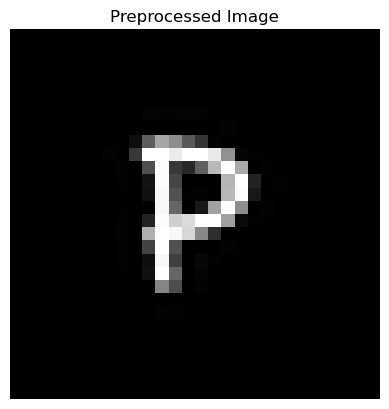

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. 8: 0.0000
  3. D: 0.0000
Moved char_220.png to P_58a7737f-7421-4221-9642-4351344b03c5.png
Processing 134/239: char_221.png


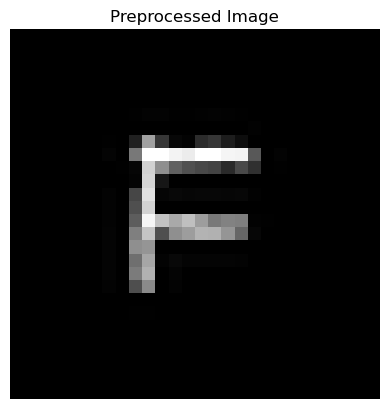

Prediction: E, Confidence: 0.9685
Top 3 predictions:
  1. E: 0.9685
  2. F: 0.0314
  3. S: 0.0000
Moved char_221.png to E_2e2ea4bc-8992-49ea-98f1-488349d8a78c.png
Processing 135/239: char_222.png


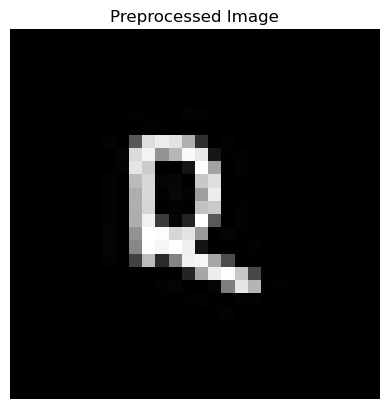

Prediction: R, Confidence: 0.9982
Top 3 predictions:
  1. R: 0.9982
  2. Q: 0.0007
  3. P: 0.0006
Moved char_222.png to R_616ed929-8593-4328-b922-d11ab747e5fb.png
Processing 136/239: char_223.png


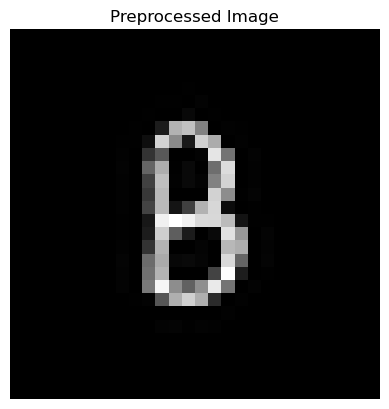

Prediction: B, Confidence: 0.9956
Top 3 predictions:
  1. B: 0.9956
  2. 8: 0.0037
  3. 3: 0.0006
Created directory: testing_data/data/B
Moved char_223.png to B_2a63268f-39a7-4f6b-afd6-465e5e05090d.png
Processing 137/239: char_224.png


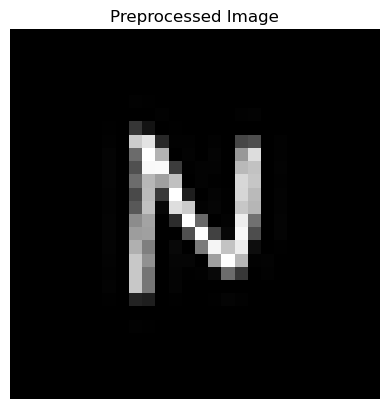

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. H: 0.0000
Moved char_224.png to N_c3192b23-06af-40ad-873a-a3e72a109908.png
Processing 138/239: char_225.png


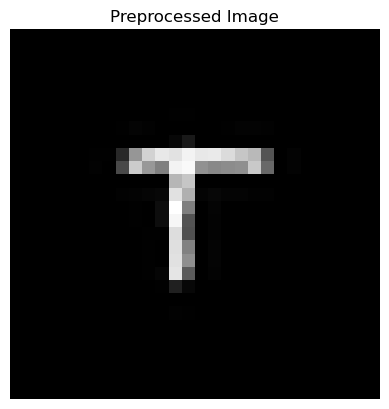

Prediction: T, Confidence: 0.9999
Top 3 predictions:
  1. T: 0.9999
  2. J: 0.0001
  3. U: 0.0000
Moved char_225.png to T_6075f3dd-5a8f-41f5-96b6-96ae1192ea83.png
Processing 139/239: char_226.png


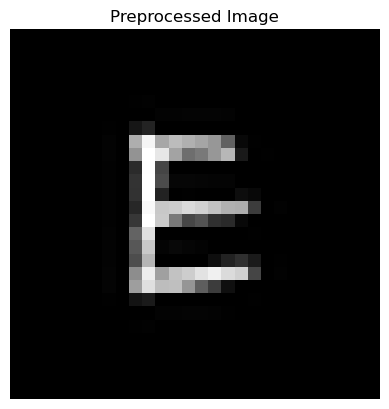

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_226.png to E_c615f709-7ddc-41f0-9663-309cfbc0c240.png
Processing 140/239: char_227.png


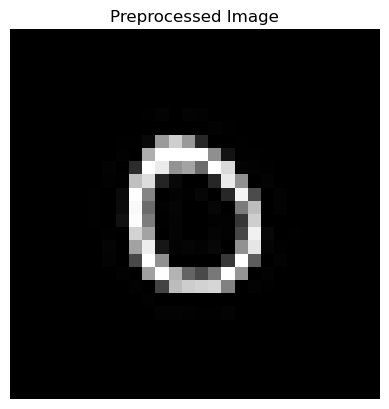

Prediction: 0, Confidence: 0.9856
Top 3 predictions:
  1. 0: 0.9856
  2. O: 0.0114
  3. 8: 0.0024
Moved char_227.png to 0_5a413f38-a06a-4c2f-a71c-f47bcc76d482.png
Processing 141/239: char_228.png


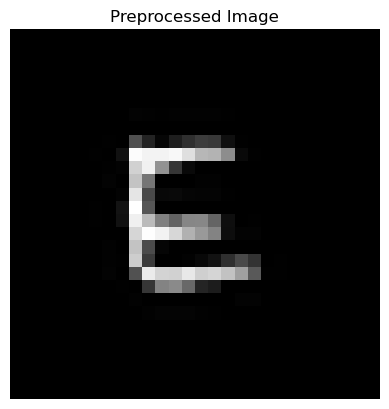

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. C: 0.0000
Moved char_228.png to E_ea071676-8c02-4504-b939-9da20b51a1e6.png
Processing 142/239: char_229.png


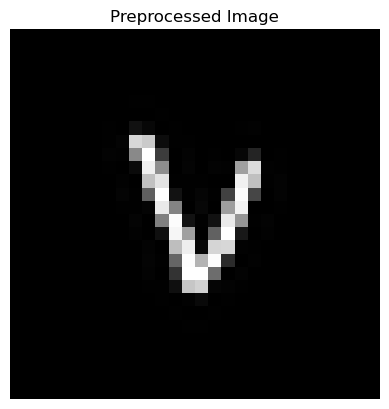

Prediction: Y, Confidence: 0.7313
Top 3 predictions:
  1. Y: 0.7313
  2. V: 0.0761
  3. W: 0.0707
Moved char_229.png to Y_2fffcd46-664e-4758-9dbd-bcd231e681d7.png
Processing 143/239: char_23.png


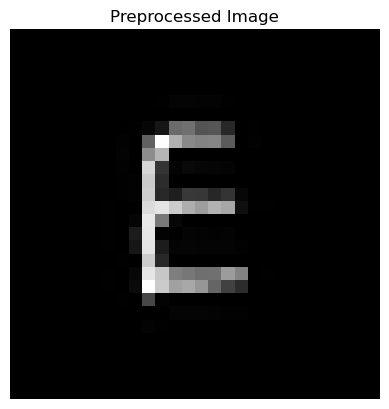

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_23.png to E_84b212a2-7309-43dc-aba6-fa1e49b490e9.png
Processing 144/239: char_230.png


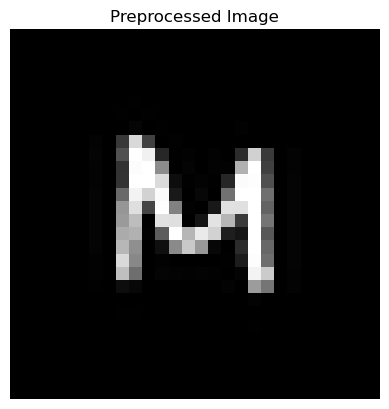

Prediction: M, Confidence: 1.0000
Top 3 predictions:
  1. M: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_230.png to M_a24b18f2-6cdb-4fa4-b00e-c6288acf3ad7.png
Processing 145/239: char_231.png


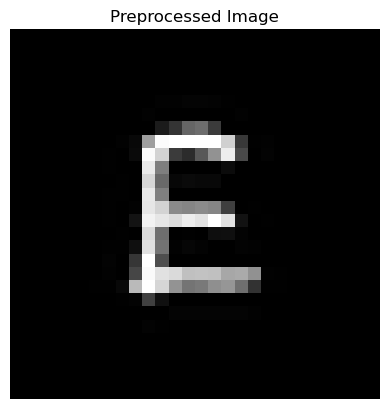

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_231.png to E_8f53b184-5dc4-4e2d-8bc3-16a9d8fb7193.png
Processing 146/239: char_232.png


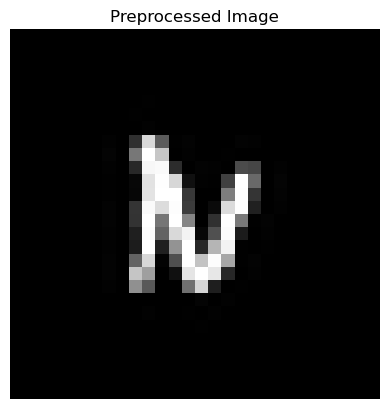

Prediction: N, Confidence: 0.9577
Top 3 predictions:
  1. N: 0.9577
  2. W: 0.0421
  3. H: 0.0001
Moved char_232.png to N_7b57e093-8d25-4411-9c4c-1c8930308e42.png
Processing 147/239: char_233.png


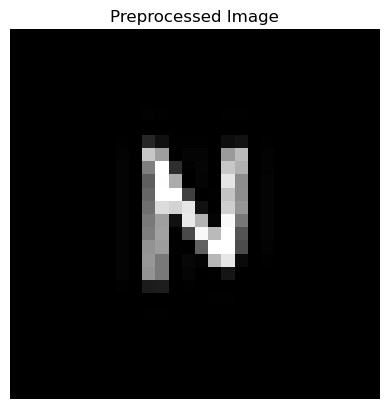

Prediction: N, Confidence: 0.9823
Top 3 predictions:
  1. N: 0.9823
  2. W: 0.0161
  3. M: 0.0009
Moved char_233.png to N_e6139a91-bdb5-4eb5-8b97-51fba0cf81e1.png
Processing 148/239: char_234.png


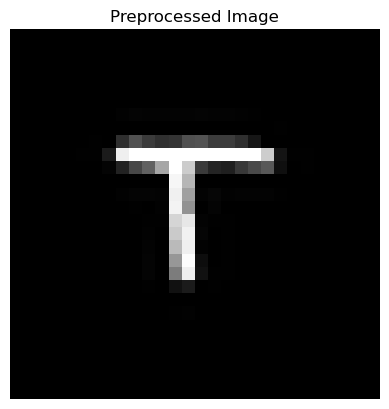

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_234.png to T_4b65293a-a8f4-4578-b641-a343d475651d.png
Processing 149/239: char_235.png


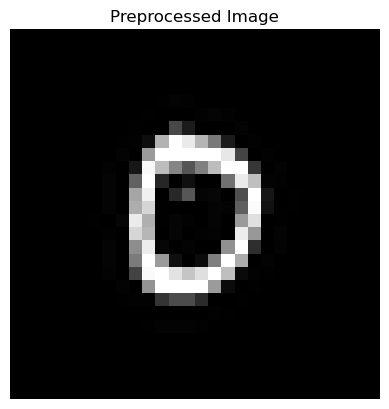

Prediction: 0, Confidence: 0.9577
Top 3 predictions:
  1. 0: 0.9577
  2. O: 0.0413
  3. 8: 0.0008
Moved char_235.png to 0_43f7740e-b8e2-4564-be47-44fc4e709bfa.png
Processing 150/239: char_236.png


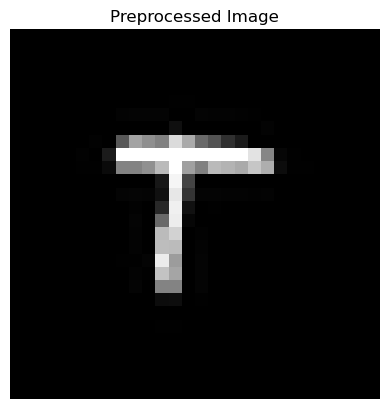

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_236.png to T_e1deba2c-4fd7-419d-9f0d-ce3619f913ab.png
Processing 151/239: char_237.png


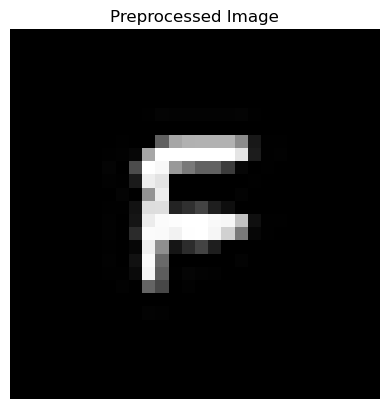

Prediction: E, Confidence: 0.9002
Top 3 predictions:
  1. E: 0.9002
  2. F: 0.0525
  3. 5: 0.0442
Moved char_237.png to E_9d7cbf6b-84ea-4e6c-80cc-e6d13d2f056a.png
Processing 152/239: char_238.png


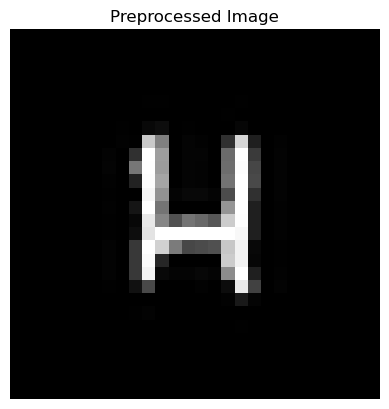

Prediction: 4, Confidence: 0.9708
Top 3 predictions:
  1. 4: 0.9708
  2. H: 0.0270
  3. W: 0.0009
Moved char_238.png to 4_bbc7c488-a4f1-42a5-b0c8-caf9fbbac7a6.png
Processing 153/239: char_239.png


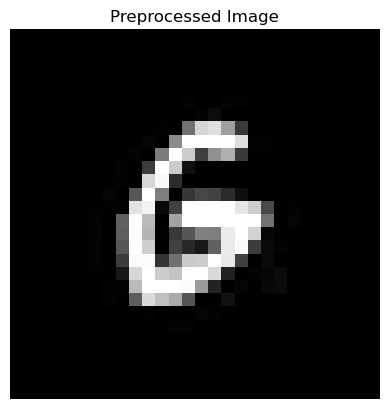

Prediction: 6, Confidence: 0.9980
Top 3 predictions:
  1. 6: 0.9980
  2. 5: 0.0008
  3. G: 0.0007
Moved char_239.png to 6_8e49ee19-f5ee-4c72-90c5-25832b003473.png
Processing 154/239: char_24.png


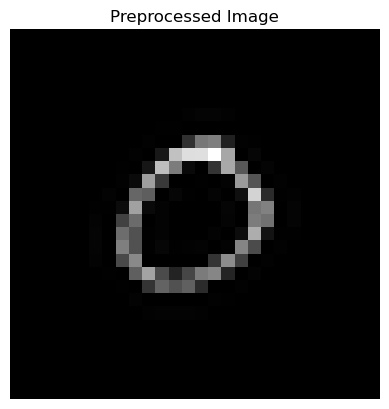

Prediction: O, Confidence: 0.9952
Top 3 predictions:
  1. O: 0.9952
  2. 0: 0.0046
  3. D: 0.0001
Moved char_24.png to O_6ea41ad3-88e3-4e59-86a9-743d19fb6dcc.png
Processing 155/239: char_240.png


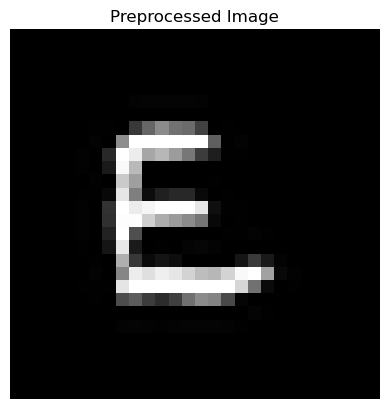

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. S: 0.0000
  3. B: 0.0000
Moved char_240.png to E_2b996316-41ff-4e17-bf13-2f92617d02b8.png
Processing 156/239: char_241.png


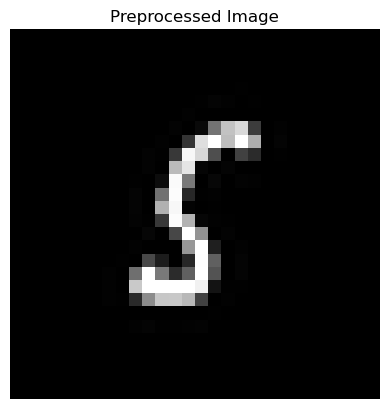

Prediction: S, Confidence: 0.8520
Top 3 predictions:
  1. S: 0.8520
  2. 5: 0.1479
  3. G: 0.0001
Moved char_241.png to S_bd539596-e586-4bef-ac9f-4c3e2af1d9cc.png
Processing 157/239: char_242.png


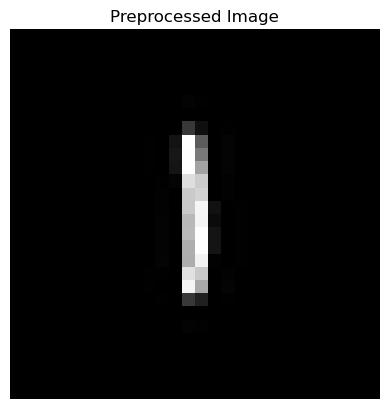

Prediction: 1, Confidence: 0.9972
Top 3 predictions:
  1. 1: 0.9972
  2. T: 0.0008
  3. J: 0.0006
Moved char_242.png to 1_c700e25c-583d-472c-b5df-fce5f4d78b81.png
Processing 158/239: char_243.png


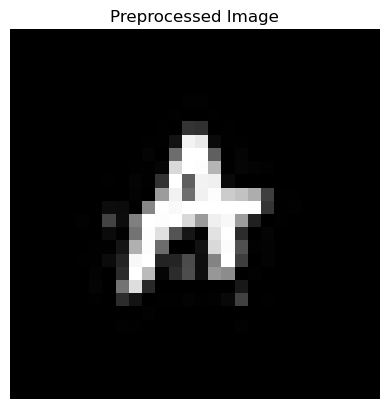

Prediction: A, Confidence: 0.9950
Top 3 predictions:
  1. A: 0.9950
  2. M: 0.0032
  3. H: 0.0015
Moved char_243.png to A_dcdf779e-c865-4798-a91b-74bb3ed5a143.png
Processing 159/239: char_244.png


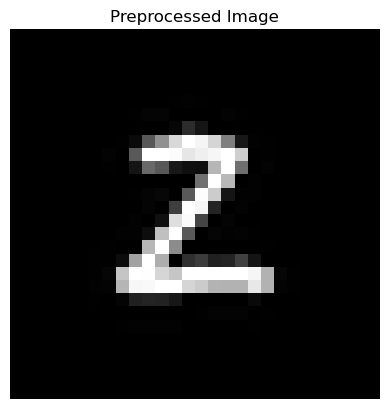

Prediction: 2, Confidence: 0.5087
Top 3 predictions:
  1. 2: 0.5087
  2. Z: 0.4902
  3. 3: 0.0007
Moved char_244.png to 2_492169ce-36e5-49b4-9f9f-6361f1476de6.png
Processing 160/239: char_245.png


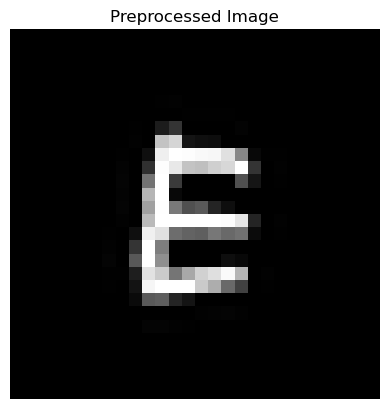

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_245.png to E_bb7d649d-9745-4f9e-8a43-4c985e0bf893.png
Processing 161/239: char_246.png


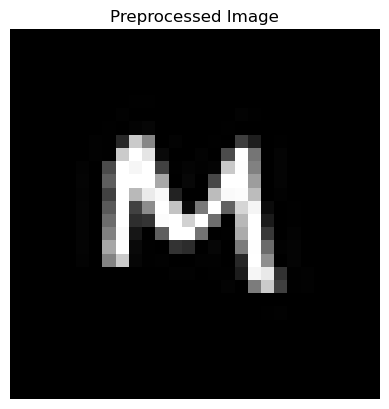

Prediction: M, Confidence: 1.0000
Top 3 predictions:
  1. M: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_246.png to M_c50eaefd-ccfe-4e0f-92d9-6a64093d5837.png
Processing 162/239: char_247.png


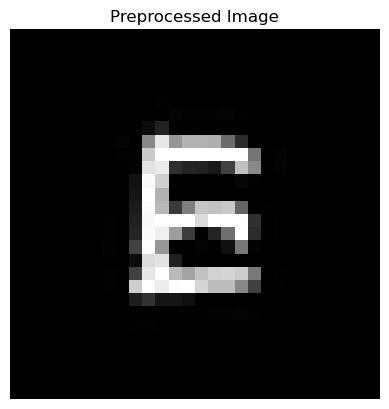

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_247.png to E_eb8a0a23-ef7a-4174-a9e5-35893d792905.png
Processing 163/239: char_248.png


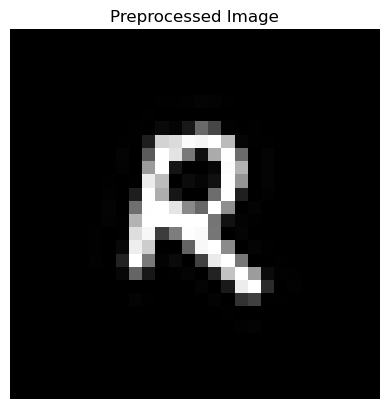

Prediction: R, Confidence: 1.0000
Top 3 predictions:
  1. R: 1.0000
  2. B: 0.0000
  3. A: 0.0000
Moved char_248.png to R_d28f2264-cf9b-407f-a5eb-30ad84440aa1.png
Processing 164/239: char_249.png


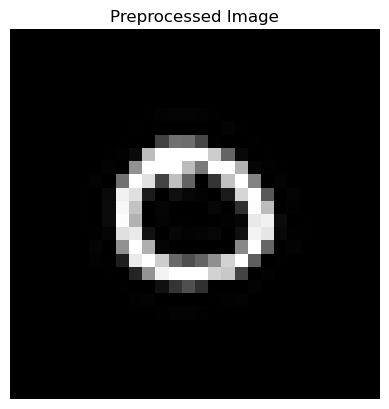

Prediction: 0, Confidence: 0.9934
Top 3 predictions:
  1. 0: 0.9934
  2. O: 0.0058
  3. 8: 0.0007
Moved char_249.png to 0_38d6bd62-1c28-46bb-bbbd-2c9f756839ae.png
Processing 165/239: char_25.png


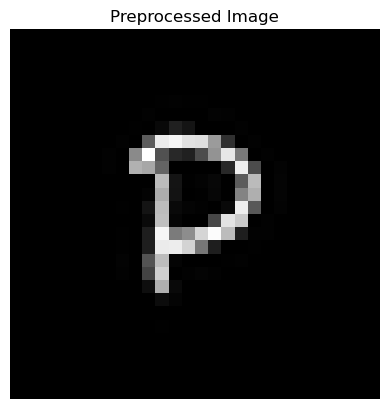

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. D: 0.0000
  3. B: 0.0000
Moved char_25.png to P_61d8b9d4-bfeb-4141-a868-2dbcb6b0f9d5.png
Processing 166/239: char_26.png


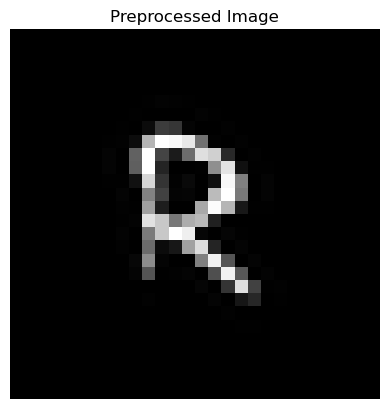

Prediction: R, Confidence: 0.9999
Top 3 predictions:
  1. R: 0.9999
  2. P: 0.0001
  3. B: 0.0000
Moved char_26.png to R_aa1d46bb-a339-4157-abd1-ea61de9a8dfd.png
Processing 167/239: char_27.png


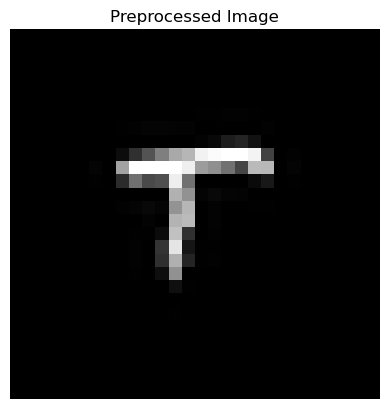

Prediction: T, Confidence: 0.9982
Top 3 predictions:
  1. T: 0.9982
  2. J: 0.0017
  3. O: 0.0001
Moved char_27.png to T_b411e2da-b509-42ef-bd3c-241db0090437.png
Processing 168/239: char_28.png


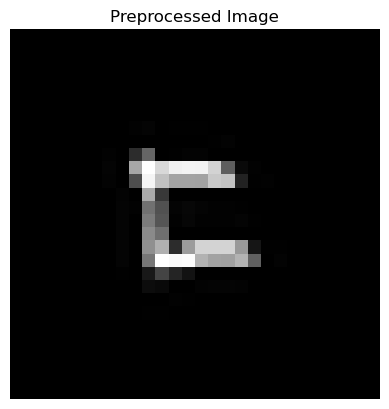

Prediction: E, Confidence: 0.9728
Top 3 predictions:
  1. E: 0.9728
  2. C: 0.0083
  3. B: 0.0070
Moved char_28.png to E_f0445ae0-868f-4559-8ede-582adef2a996.png
Processing 169/239: char_29.png


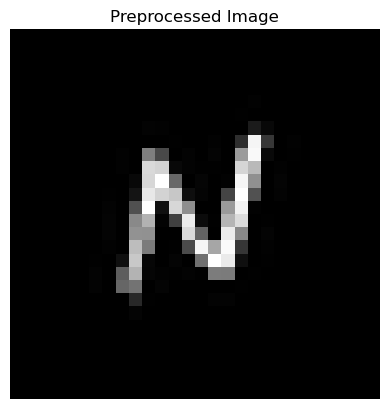

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. H: 0.0000
Moved char_29.png to N_bcea4638-2c11-4dd8-96aa-8133d38ed996.png
Processing 170/239: char_30.png


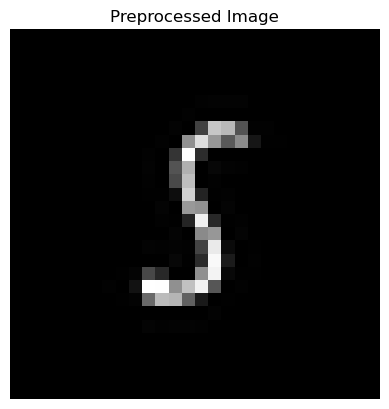

Prediction: 5, Confidence: 0.7023
Top 3 predictions:
  1. 5: 0.7023
  2. S: 0.2929
  3. 3: 0.0022
Moved char_30.png to 5_102d990d-fd11-412c-93f9-cd790b501da1.png
Processing 171/239: char_31.png


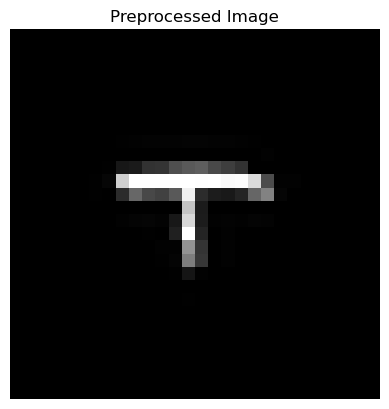

Prediction: T, Confidence: 0.9902
Top 3 predictions:
  1. T: 0.9902
  2. J: 0.0080
  3. O: 0.0010
Moved char_31.png to T_d0d87a2d-7a25-4fbc-a9c1-329529b59f9a.png
Processing 172/239: char_32.png


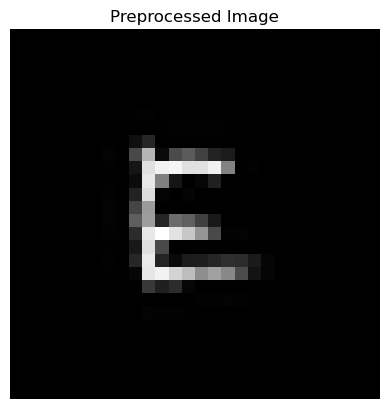

Prediction: E, Confidence: 0.9995
Top 3 predictions:
  1. E: 0.9995
  2. B: 0.0002
  3. 5: 0.0001
Moved char_32.png to E_9e55c615-103d-4200-a224-bb5f927a430c.png
Processing 173/239: char_33.png


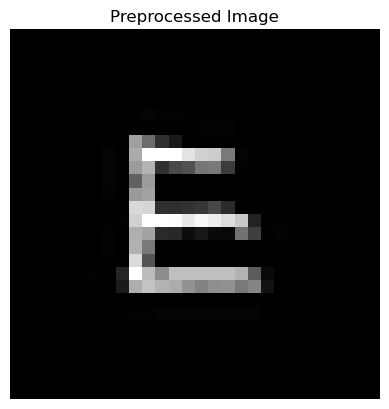

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_33.png to E_8b394d9d-1bdd-4e75-912c-b9d71fa7d71a.png
Processing 174/239: char_34.png


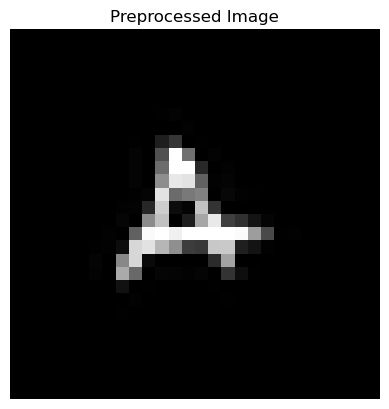

Prediction: A, Confidence: 0.9778
Top 3 predictions:
  1. A: 0.9778
  2. M: 0.0082
  3. H: 0.0064
Moved char_34.png to A_4ca201bb-1564-4c88-9e5c-176b681fdb29.png
Processing 175/239: char_35.png


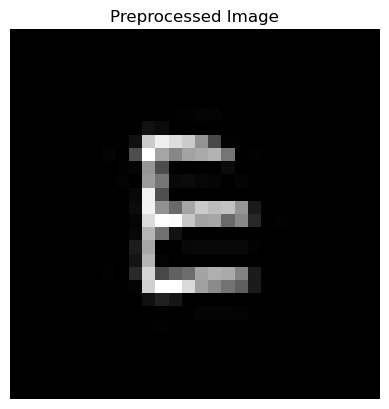

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_35.png to E_822dd069-7b2f-421f-b4c6-8329d5f6dde3.png
Processing 176/239: char_36.png


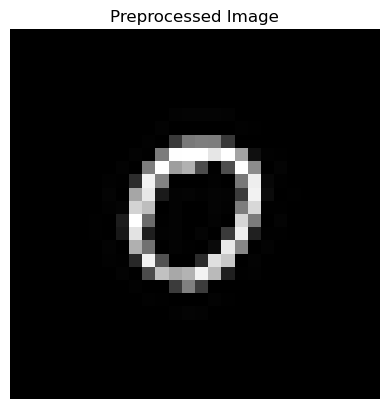

Prediction: 0, Confidence: 0.9623
Top 3 predictions:
  1. 0: 0.9623
  2. O: 0.0254
  3. 8: 0.0107
Moved char_36.png to 0_2625a412-7afd-437f-9dd5-3987fd873427.png
Processing 177/239: char_37.png


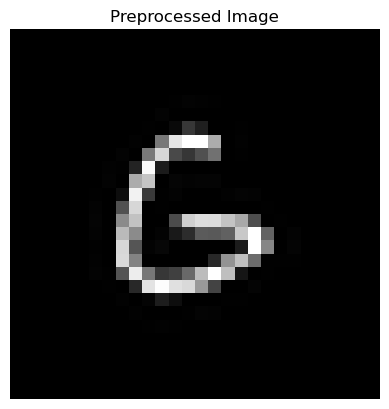

Prediction: 6, Confidence: 0.7360
Top 3 predictions:
  1. 6: 0.7360
  2. G: 0.2598
  3. 5: 0.0012
Moved char_37.png to 6_7997d768-a699-49b1-b94a-02f8e8e906d1.png
Processing 178/239: char_38.png


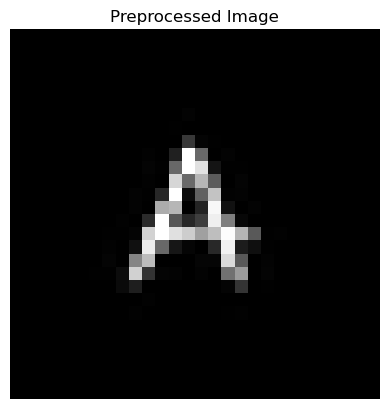

Prediction: A, Confidence: 0.9735
Top 3 predictions:
  1. A: 0.9735
  2. 4: 0.0111
  3. H: 0.0048
Moved char_38.png to A_e15d7cf3-fe93-4d3d-812c-dfce1bf60b70.png
Processing 179/239: char_39.png


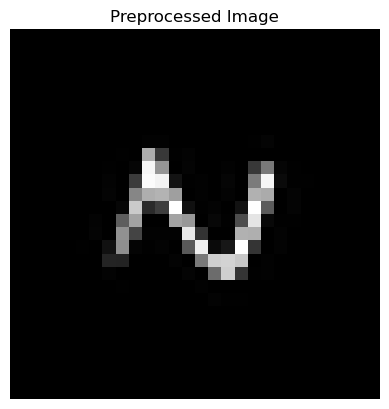

Prediction: N, Confidence: 0.9939
Top 3 predictions:
  1. N: 0.9939
  2. W: 0.0056
  3. H: 0.0004
Moved char_39.png to N_b73c0af5-bd5a-475e-bbc1-14b703a250ba.png
Processing 180/239: char_40.png


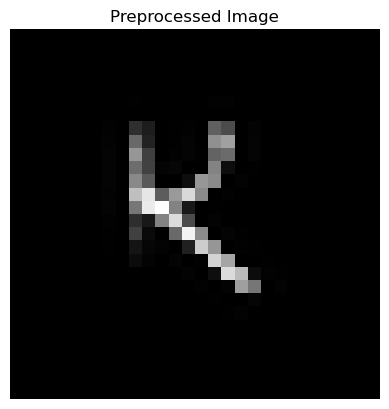

Prediction: K, Confidence: 0.9653
Top 3 predictions:
  1. K: 0.9653
  2. X: 0.0210
  3. Y: 0.0046
Moved char_40.png to K_d9a6dad3-afa6-4224-8d92-e494468a2b57.png
Processing 181/239: char_41.png


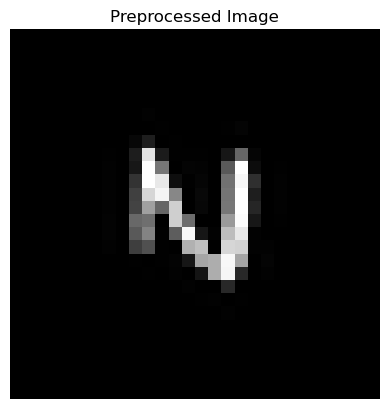

Prediction: N, Confidence: 0.7635
Top 3 predictions:
  1. N: 0.7635
  2. W: 0.2165
  3. H: 0.0117
Moved char_41.png to N_e6e4548a-b8f2-41af-81f2-af8a7fe47081.png
Processing 182/239: char_42.png


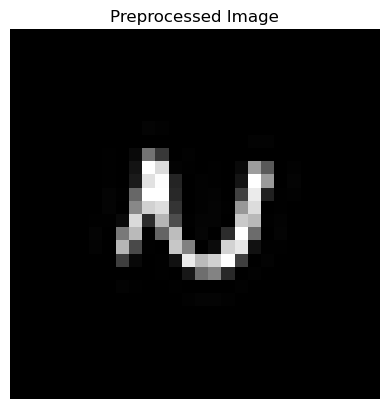

Prediction: N, Confidence: 0.9916
Top 3 predictions:
  1. N: 0.9916
  2. W: 0.0080
  3. H: 0.0004
Moved char_42.png to N_b395ffe7-6370-413d-b0a9-51113e78930e.png
Processing 183/239: char_43.png


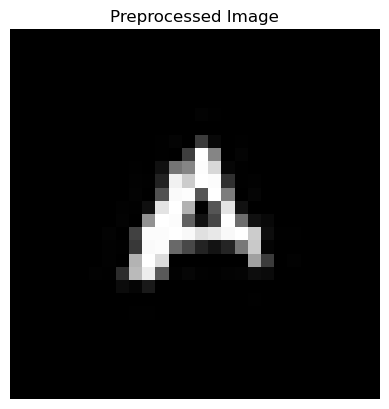

Prediction: A, Confidence: 0.9788
Top 3 predictions:
  1. A: 0.9788
  2. 4: 0.0166
  3. 1: 0.0015
Moved char_43.png to A_7bdd566d-b30c-4578-b7f0-2e84644546e9.png
Processing 184/239: char_44.png


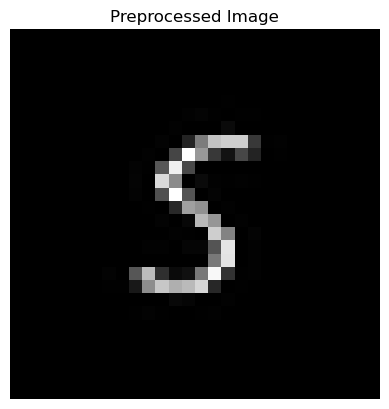

Prediction: 5, Confidence: 0.9495
Top 3 predictions:
  1. 5: 0.9495
  2. S: 0.0491
  3. 3: 0.0009
Moved char_44.png to 5_44b754b7-4175-49a9-a282-e2592f91f42b.png
Processing 185/239: char_45.png


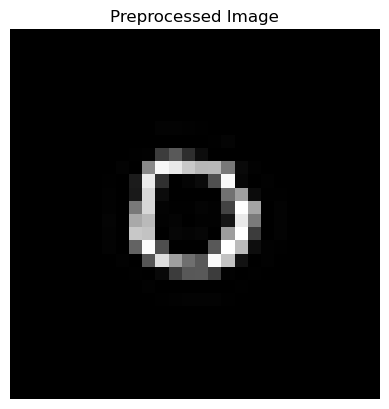

Prediction: 0, Confidence: 0.8687
Top 3 predictions:
  1. 0: 0.8687
  2. O: 0.0989
  3. 8: 0.0230
Moved char_45.png to 0_9e9c1c71-085f-4f2b-85f5-efd173346b33.png
Processing 186/239: char_46.png


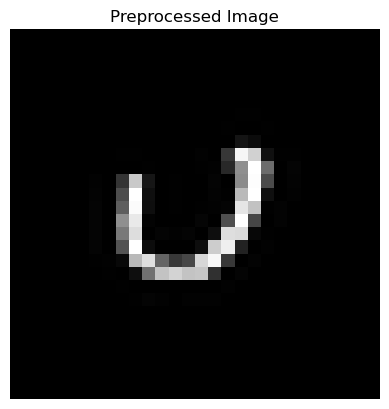

Prediction: U, Confidence: 0.3443
Top 3 predictions:
  1. U: 0.3443
  2. 0: 0.3416
  3. 5: 0.0692
Moved char_46.png to U_9e650c1e-92b3-493a-8ff5-c271923c5e6c.png
Processing 187/239: char_47.png


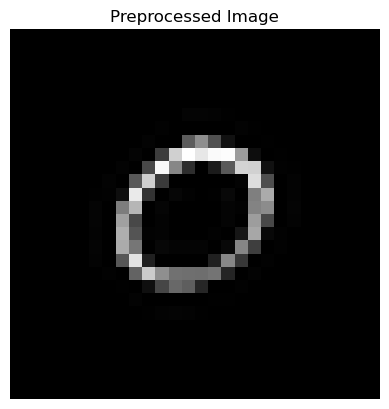

Prediction: O, Confidence: 0.9749
Top 3 predictions:
  1. O: 0.9749
  2. 0: 0.0248
  3. D: 0.0002
Moved char_47.png to O_2e315212-cec7-4456-9476-97a526920dab.png
Processing 188/239: char_48.png


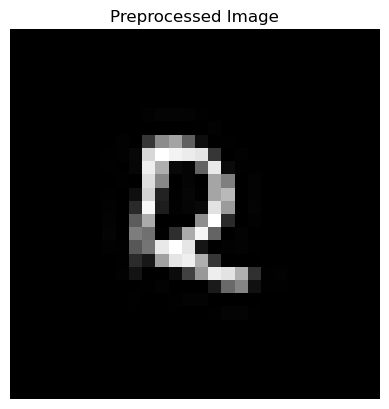

Prediction: R, Confidence: 0.9462
Top 3 predictions:
  1. R: 0.9462
  2. P: 0.0143
  3. 2: 0.0088
Moved char_48.png to R_bebffc40-4434-453c-b104-4611e2c6d014.png
Processing 189/239: char_49.png


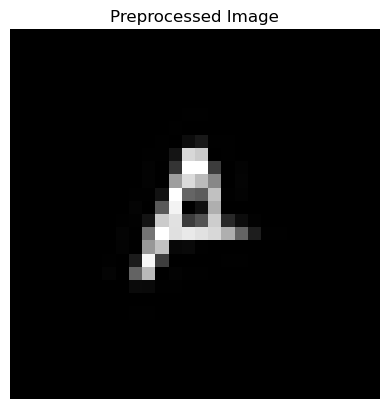

Prediction: 1, Confidence: 0.9137
Top 3 predictions:
  1. 1: 0.9137
  2. 4: 0.0309
  3. 7: 0.0149
Moved char_49.png to 1_af56a61e-96ff-46c6-b917-7eadbd3539a6.png
Processing 190/239: char_50.png


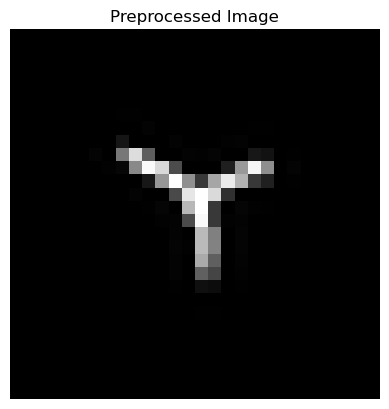

Prediction: Y, Confidence: 0.9773
Top 3 predictions:
  1. Y: 0.9773
  2. T: 0.0186
  3. P: 0.0011
Moved char_50.png to Y_598277ab-269d-4f15-babf-8e9c4af64e0a.png
Processing 191/239: char_51.png


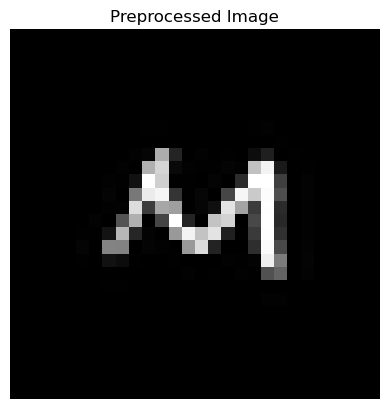

Prediction: M, Confidence: 1.0000
Top 3 predictions:
  1. M: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_51.png to M_92aac51a-648a-4055-919e-2f9a5e3d6540.png
Processing 192/239: char_52.png


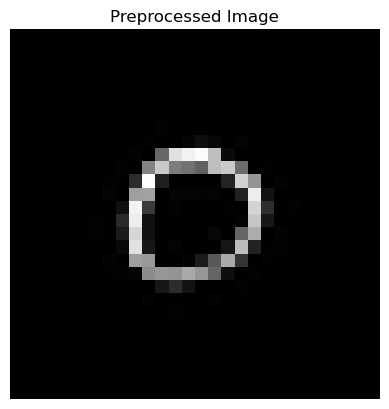

Prediction: 0, Confidence: 0.9917
Top 3 predictions:
  1. 0: 0.9917
  2. O: 0.0050
  3. 8: 0.0025
Moved char_52.png to 0_583587eb-6ec2-4c8f-8b2c-29bb3205c275.png
Processing 193/239: char_53.png


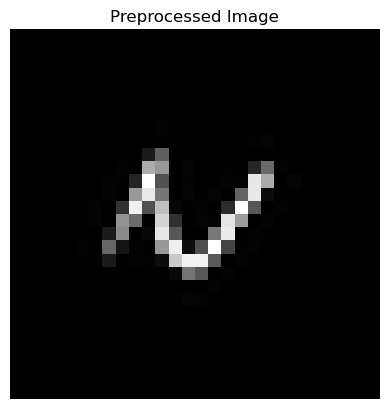

Prediction: N, Confidence: 0.7692
Top 3 predictions:
  1. N: 0.7692
  2. W: 0.2232
  3. H: 0.0054
Moved char_53.png to N_70dc30f6-eff4-4b4a-bb46-575d01d9f5b9.png
Processing 194/239: char_54.png


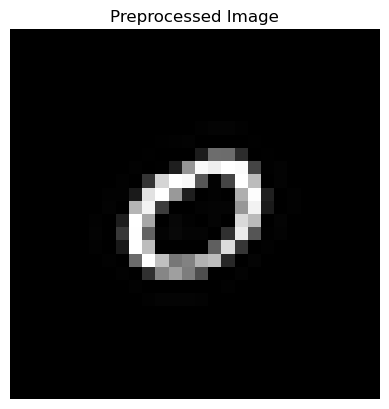

Prediction: 0, Confidence: 0.9530
Top 3 predictions:
  1. 0: 0.9530
  2. O: 0.0193
  3. 8: 0.0158
Moved char_54.png to 0_b3841eab-1896-43d5-87d2-cd2c6f7615f1.png
Processing 195/239: char_55.png


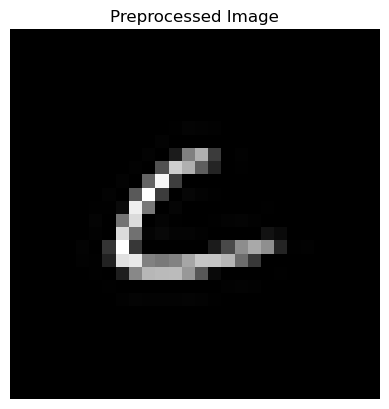

Prediction: 2, Confidence: 0.6990
Top 3 predictions:
  1. 2: 0.6990
  2. 6: 0.1547
  3. C: 0.0510
Moved char_55.png to 2_fc532526-0b3a-4cf9-91f3-e6080e53105a.png
Processing 196/239: char_56.png


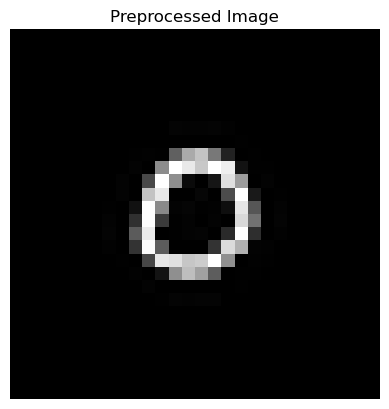

Prediction: 0, Confidence: 0.8633
Top 3 predictions:
  1. 0: 0.8633
  2. O: 0.0730
  3. 8: 0.0564
Moved char_56.png to 0_970ce6df-4af1-43f5-b7b4-17b522be82ac.png
Processing 197/239: char_57.png


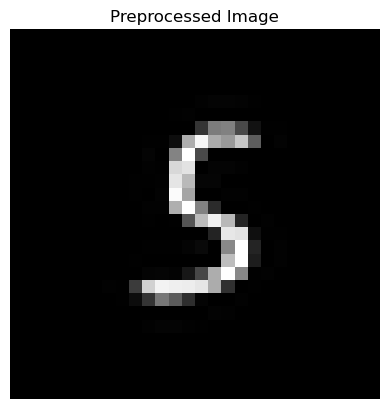

Prediction: 5, Confidence: 0.9938
Top 3 predictions:
  1. 5: 0.9938
  2. S: 0.0058
  3. 3: 0.0004
Moved char_57.png to 5_c13a15f0-58e0-4035-8cae-e3cd0b4c79ab.png
Processing 198/239: char_58.png


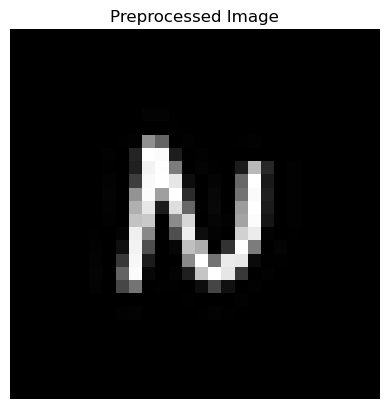

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. H: 0.0000
Moved char_58.png to N_c0904522-659f-4a42-8223-5c6e03b38666.png
Processing 199/239: char_59.png


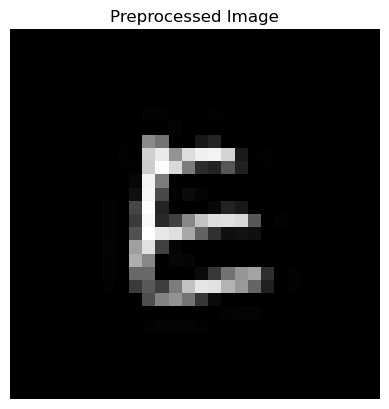

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_59.png to E_52110e1f-06d1-45a6-8083-3077a014f693.png
Processing 200/239: char_60.png


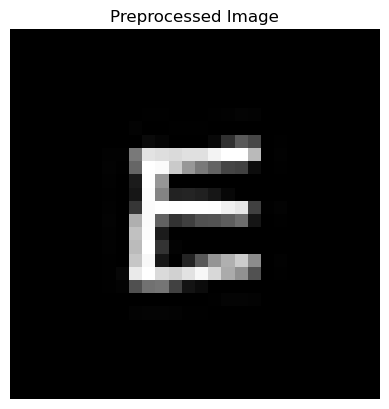

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_60.png to E_1ddc112a-9212-4c90-b53e-36886460eddc.png
Processing 201/239: char_61.png


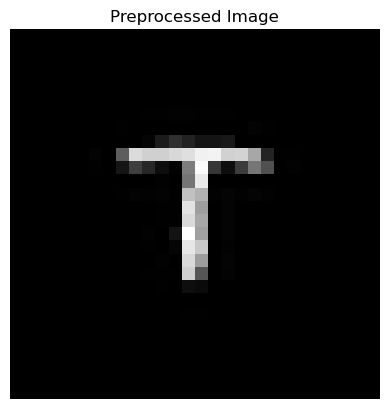

Prediction: T, Confidence: 0.9996
Top 3 predictions:
  1. T: 0.9996
  2. J: 0.0003
  3. U: 0.0001
Moved char_61.png to T_c0a19ea2-0c22-42ea-bb6e-c544d4025303.png
Processing 202/239: char_62.png


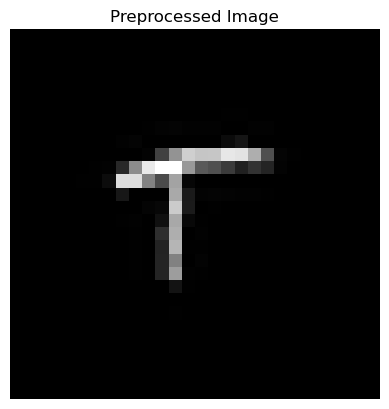

Prediction: T, Confidence: 0.9997
Top 3 predictions:
  1. T: 0.9997
  2. J: 0.0003
  3. O: 0.0000
Moved char_62.png to T_9cbe0892-fe05-40bb-861d-fd56aaeba32d.png
Processing 203/239: char_63.png


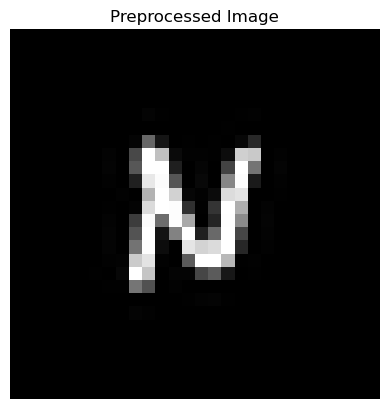

Prediction: N, Confidence: 0.9999
Top 3 predictions:
  1. N: 0.9999
  2. W: 0.0001
  3. H: 0.0000
Moved char_63.png to N_f0946348-7cd3-4ef4-ba7c-74b9bbaa4081.png
Processing 204/239: char_64.png


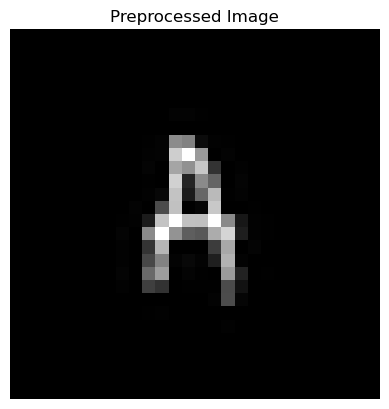

Prediction: A, Confidence: 0.9971
Top 3 predictions:
  1. A: 0.9971
  2. H: 0.0018
  3. 4: 0.0003
Moved char_64.png to A_4c900c53-341e-4716-bc85-c3b08575835d.png
Processing 205/239: char_65.png


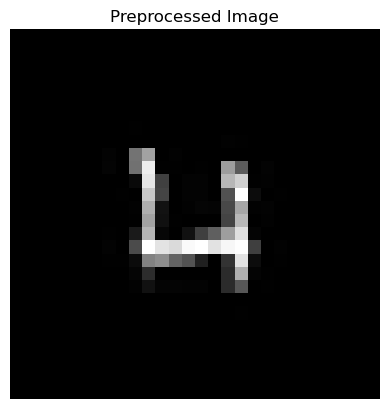

Prediction: 4, Confidence: 0.9897
Top 3 predictions:
  1. 4: 0.9897
  2. Y: 0.0044
  3. U: 0.0039
Moved char_65.png to 4_0d5f6551-ed7d-45ee-93c8-b6cd999cd7f0.png
Processing 206/239: char_66.png


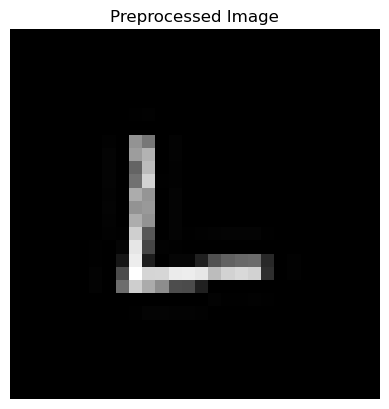

Prediction: L, Confidence: 0.9999
Top 3 predictions:
  1. L: 0.9999
  2. C: 0.0000
  3. Z: 0.0000
Moved char_66.png to L_4ddb984a-4a92-427e-ab7a-016ad6da139c.png
Processing 207/239: char_67.png


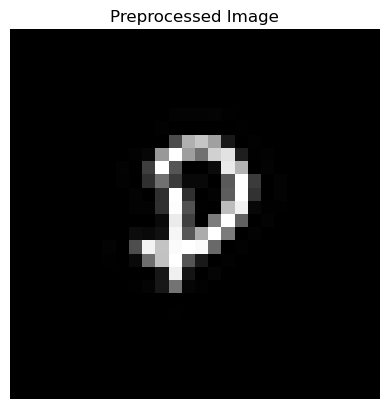

Prediction: P, Confidence: 0.9342
Top 3 predictions:
  1. P: 0.9342
  2. 8: 0.0655
  3. O: 0.0001
Moved char_67.png to P_db6fa9a7-44e3-4b27-a953-5c5eb176e940.png
Processing 208/239: char_68.png


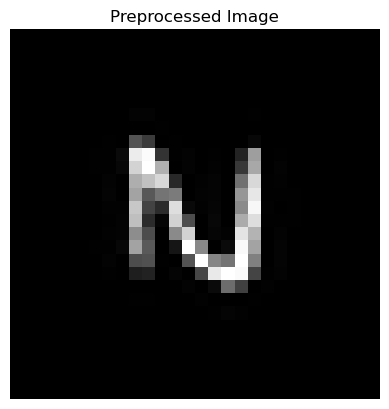

Prediction: N, Confidence: 0.9887
Top 3 predictions:
  1. N: 0.9887
  2. W: 0.0097
  3. H: 0.0012
Moved char_68.png to N_2eb64b1f-6bd5-4c87-99bf-63b61542cfaf.png
Processing 209/239: char_69.png


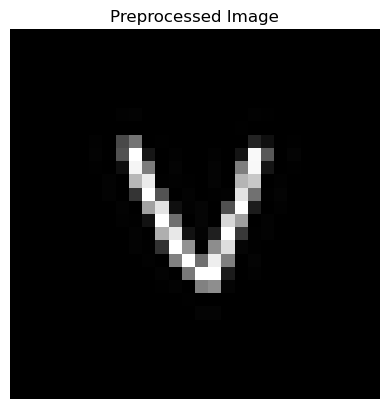

Prediction: Y, Confidence: 0.9061
Top 3 predictions:
  1. Y: 0.9061
  2. V: 0.0293
  3. X: 0.0241
Moved char_69.png to Y_f2abd141-5943-4da3-81d6-a6f54673feab.png
Processing 210/239: char_70.png


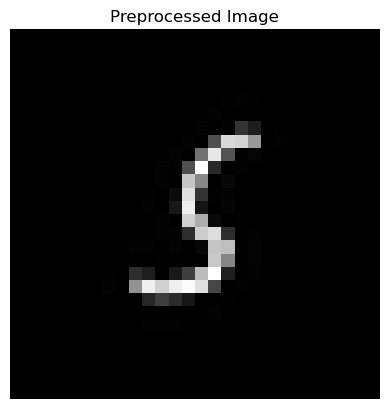

Prediction: 5, Confidence: 0.8489
Top 3 predictions:
  1. 5: 0.8489
  2. S: 0.1509
  3. 3: 0.0002
Moved char_70.png to 5_7348db61-307c-4d26-84d7-6d160f5911ff.png
Processing 211/239: char_71.png


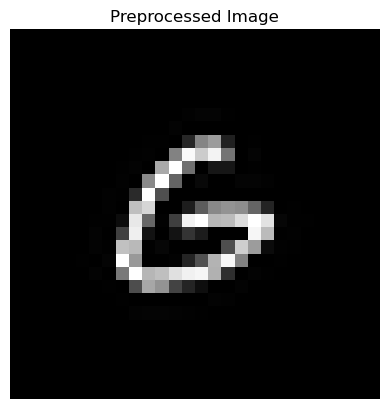

Prediction: 6, Confidence: 0.7717
Top 3 predictions:
  1. 6: 0.7717
  2. G: 0.2270
  3. 8: 0.0004
Moved char_71.png to 6_66fc50a0-eb37-4abe-8c36-6c3fb3813a06.png
Processing 212/239: char_72.png


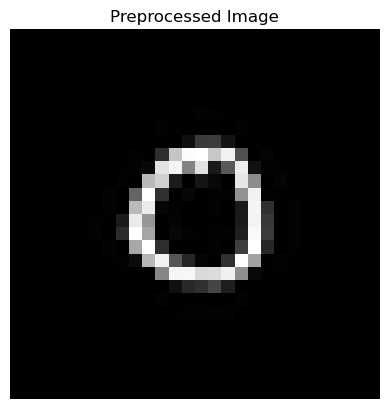

Prediction: 0, Confidence: 0.9975
Top 3 predictions:
  1. 0: 0.9975
  2. 6: 0.0014
  3. 8: 0.0006
Moved char_72.png to 0_2d3af78e-f87d-490b-9d69-2b9c598f3e3f.png
Processing 213/239: char_73.png


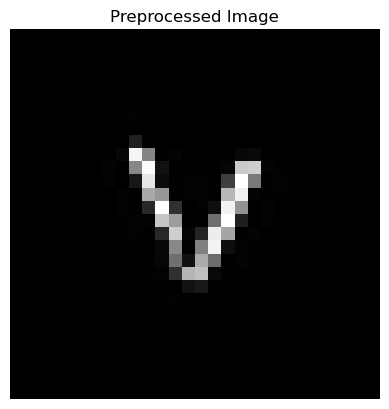

Prediction: Y, Confidence: 0.6092
Top 3 predictions:
  1. Y: 0.6092
  2. W: 0.1429
  3. 4: 0.1081
Moved char_73.png to Y_17b48fb4-d993-4301-b077-79c65cb6b365.png
Processing 214/239: char_74.png


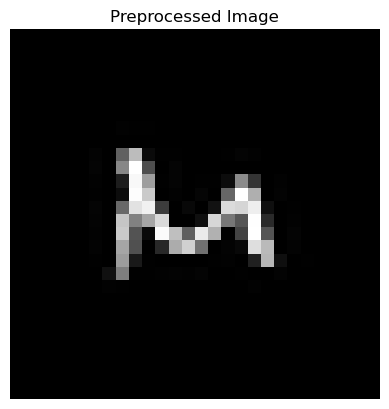

Prediction: M, Confidence: 1.0000
Top 3 predictions:
  1. M: 1.0000
  2. N: 0.0000
  3. H: 0.0000
Moved char_74.png to M_baeaf343-6efa-46ab-bf86-d3f8dd072b0e.png
Processing 215/239: char_75.png


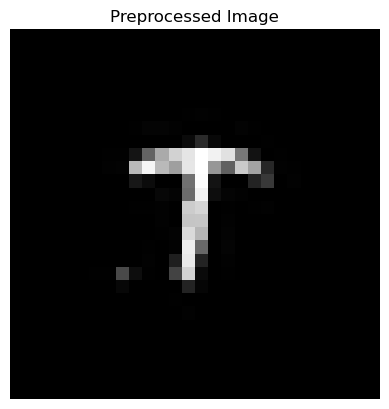

Prediction: T, Confidence: 0.5356
Top 3 predictions:
  1. T: 0.5356
  2. J: 0.4386
  3. 1: 0.0076
Moved char_75.png to T_99d1f100-79d6-4698-812b-032e71d2c0f8.png
Processing 216/239: char_76.png


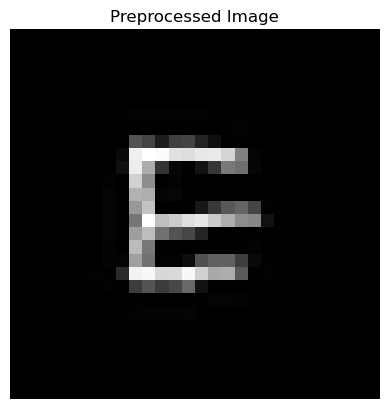

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_76.png to E_0c396f46-27ba-4cd4-b59d-6d391a00c166.png
Processing 217/239: char_77.png


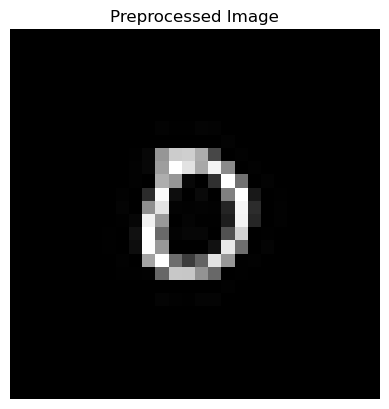

Prediction: 0, Confidence: 0.9376
Top 3 predictions:
  1. 0: 0.9376
  2. O: 0.0422
  3. 8: 0.0163
Moved char_77.png to 0_8ecdad63-f7ab-45f2-b6a3-ba1ef75ec3c7.png
Processing 218/239: char_78.png


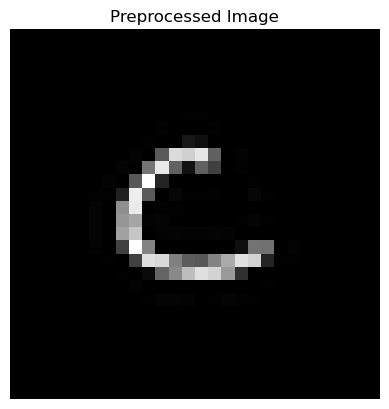

Prediction: C, Confidence: 0.9274
Top 3 predictions:
  1. C: 0.9274
  2. 6: 0.0136
  3. E: 0.0125
Moved char_78.png to C_8897150d-9b37-4b9f-870f-40b9611c22c9.png
Processing 219/239: char_79.png


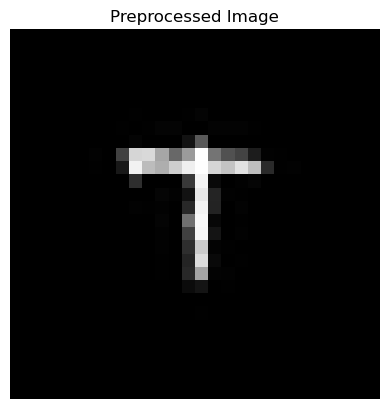

Prediction: T, Confidence: 0.9851
Top 3 predictions:
  1. T: 0.9851
  2. J: 0.0142
  3. O: 0.0003
Moved char_79.png to T_75bebbd6-8407-42c2-8c7d-2b6edc0f25a3.png
Processing 220/239: char_80.png


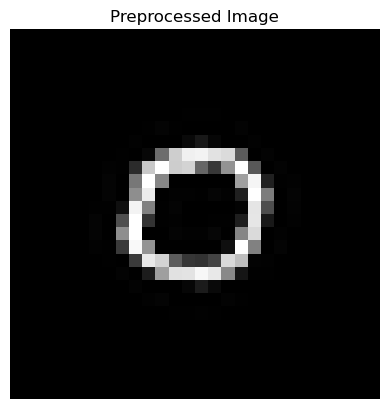

Prediction: 0, Confidence: 0.9952
Top 3 predictions:
  1. 0: 0.9952
  2. O: 0.0044
  3. 8: 0.0003
Moved char_80.png to 0_7a7f25bd-41c0-48b2-ad86-e2018a1f9a50.png
Processing 221/239: char_81.png


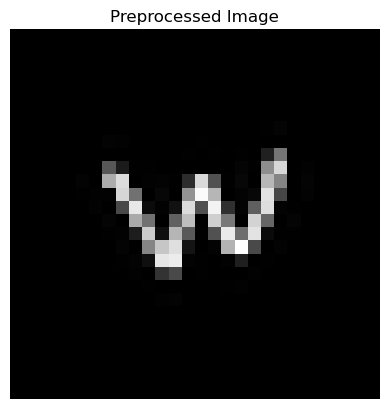

Prediction: W, Confidence: 0.9999
Top 3 predictions:
  1. W: 0.9999
  2. N: 0.0001
  3. H: 0.0000
Moved char_81.png to W_de637872-e32f-44f8-98ef-a964c963c775.png
Processing 222/239: char_82.png


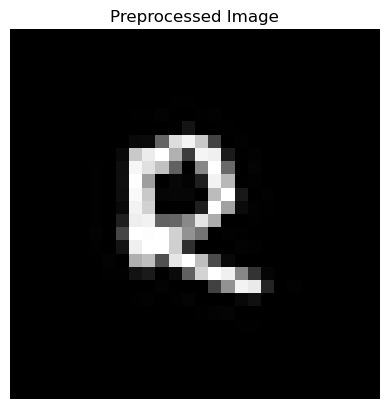

Prediction: R, Confidence: 0.9987
Top 3 predictions:
  1. R: 0.9987
  2. 2: 0.0006
  3. 8: 0.0002
Moved char_82.png to R_68aa58a2-90c2-4a21-be11-9b836fbcf8f0.png
Processing 223/239: char_83.png


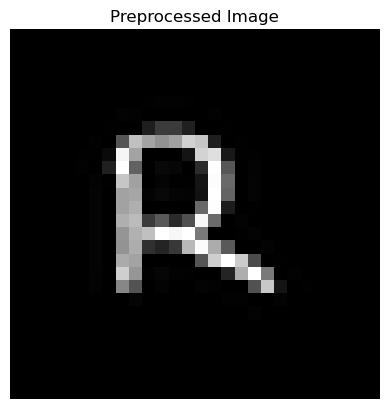

Prediction: R, Confidence: 1.0000
Top 3 predictions:
  1. R: 1.0000
  2. B: 0.0000
  3. P: 0.0000
Moved char_83.png to R_9a792f98-32a6-48db-b96a-4ee49cb54763.png
Processing 224/239: char_84.png


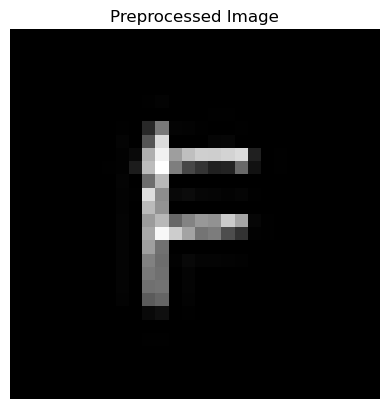

Prediction: E, Confidence: 0.6034
Top 3 predictions:
  1. E: 0.6034
  2. F: 0.3960
  3. S: 0.0002
Moved char_84.png to E_67de66be-511a-4c63-8fd0-9963659bf9a8.png
Processing 225/239: char_85.png


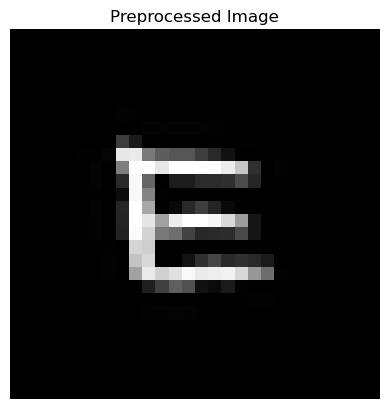

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. C: 0.0000
Moved char_85.png to E_162c2b1d-6399-4724-b7ec-2b5ca3859108.png
Processing 226/239: char_86.png


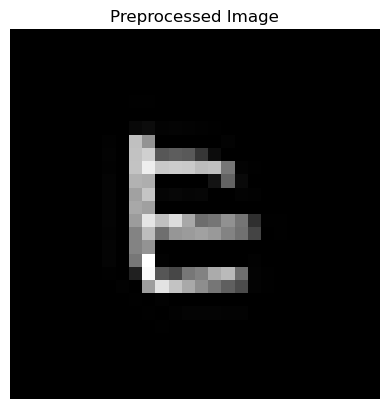

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. C: 0.0000
Moved char_86.png to E_0fbc9200-1b3d-4a75-ba5f-6f3893647716.png
Processing 227/239: char_87.png


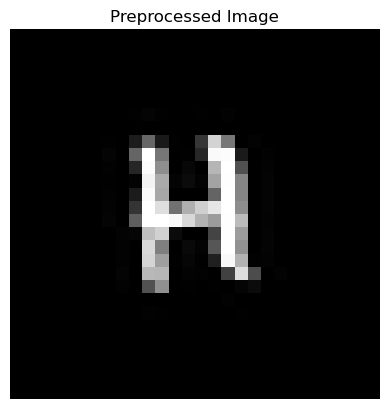

Prediction: H, Confidence: 0.8188
Top 3 predictions:
  1. H: 0.8188
  2. 4: 0.0836
  3. W: 0.0419
Moved char_87.png to H_1179b300-2f29-44f0-beb5-2f0e4d2f20e4.png
Processing 228/239: char_88.png


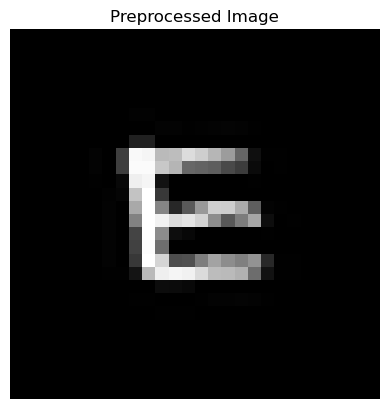

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_88.png to E_27e034ce-a8c5-4eea-bf84-e34a0da038d3.png
Processing 229/239: char_89.png


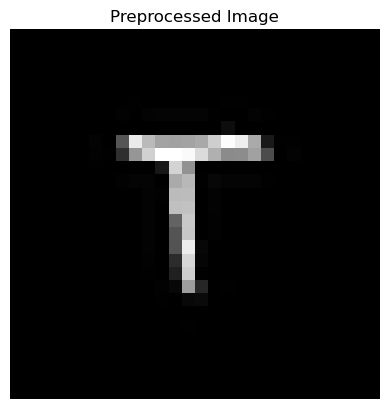

Prediction: T, Confidence: 0.9999
Top 3 predictions:
  1. T: 0.9999
  2. J: 0.0000
  3. U: 0.0000
Moved char_89.png to T_0c724482-afc9-4e6f-a574-6ff6de25fceb.png
Processing 230/239: char_90.png


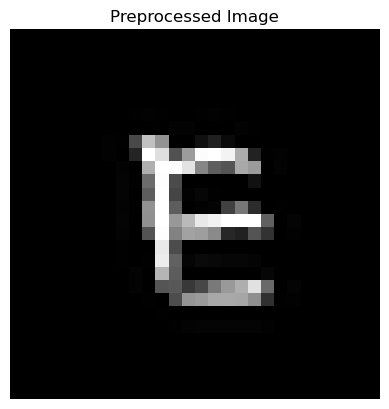

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. G: 0.0000
Moved char_90.png to E_ccc1e3b5-d591-4fd8-b02c-133dacdb0b6c.png
Processing 231/239: char_91.png


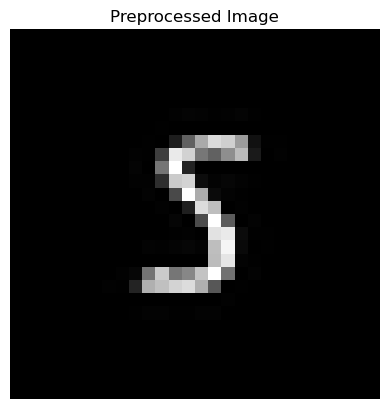

Prediction: S, Confidence: 0.5870
Top 3 predictions:
  1. S: 0.5870
  2. 5: 0.4087
  3. J: 0.0017
Moved char_91.png to S_69af99d6-58eb-4bd1-b0b0-81585e2fdd67.png
Processing 232/239: char_92.png


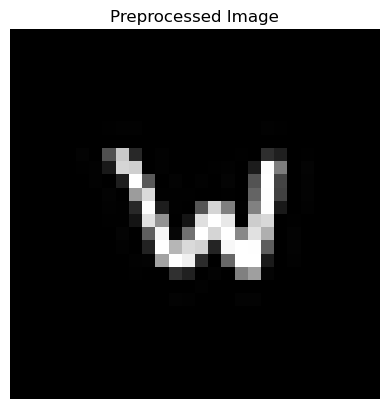

Prediction: W, Confidence: 1.0000
Top 3 predictions:
  1. W: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_92.png to W_e860848a-88d4-4ef4-9f46-c2cae22263f6.png
Processing 233/239: char_93.png


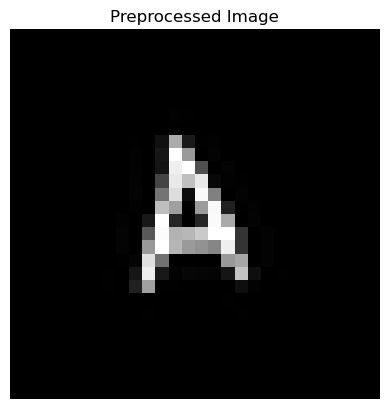

Prediction: A, Confidence: 0.9145
Top 3 predictions:
  1. A: 0.9145
  2. 1: 0.0142
  3. M: 0.0108
Moved char_93.png to A_263c1c8c-bc59-4b48-880f-40c74e314b3b.png
Processing 234/239: char_94.png


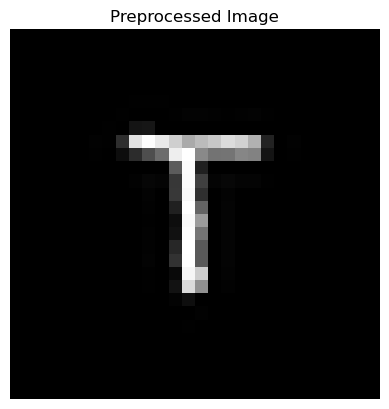

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_94.png to T_00cac14a-5824-46d8-8fee-9d04f6a2f032.png
Processing 235/239: char_95.png


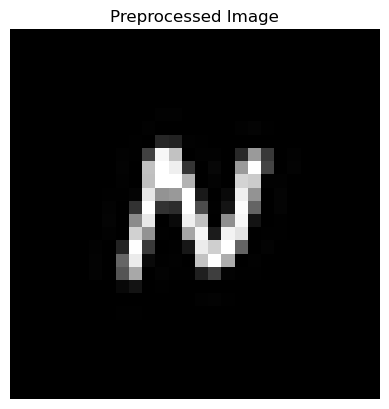

Prediction: N, Confidence: 0.9987
Top 3 predictions:
  1. N: 0.9987
  2. W: 0.0013
  3. H: 0.0000
Moved char_95.png to N_80aa7da6-745d-414d-9692-eaf4dec5fd71.png
Processing 236/239: char_96.png


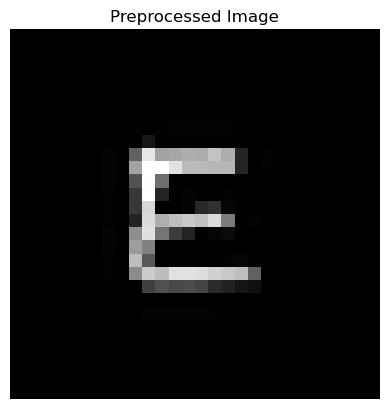

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_96.png to E_5b06f3b1-0055-4b33-b361-4d4f8021c15e.png
Processing 237/239: char_97.png


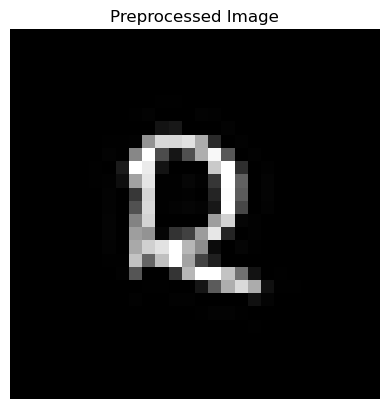

Prediction: R, Confidence: 0.9988
Top 3 predictions:
  1. R: 0.9988
  2. P: 0.0003
  3. C: 0.0002
Moved char_97.png to R_279e8bda-3f7a-432c-a075-8598474590aa.png
Processing 238/239: char_98.png


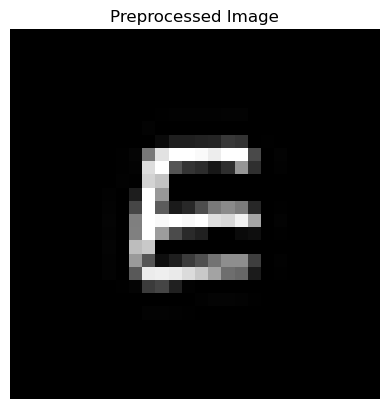

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_98.png to E_bbe6a62b-6b72-4e26-bf3f-49a6a182e4ed.png
Processing 239/239: char_99.png


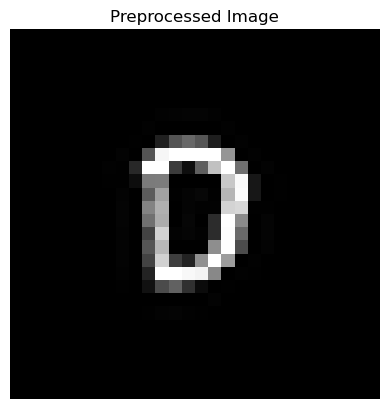

Prediction: 0, Confidence: 0.8259
Top 3 predictions:
  1. 0: 0.8259
  2. 2: 0.0785
  3. 8: 0.0611
Moved char_99.png to 0_64c7d27b-7b78-4d15-8bc5-8a01da17cd5d.png


In [62]:
sort_images_by_prediction(source_directory="testing_data/dniel", confidence_threshold=0.3)


Found 190 image files in 'testing_data/alpha'
Processing 1/190: char_0.png


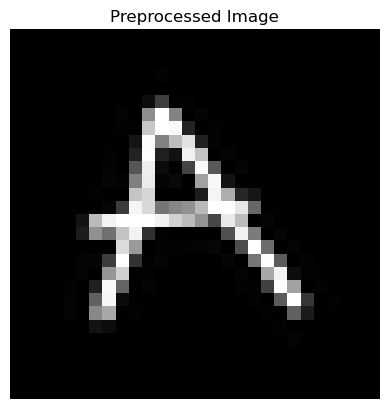

Prediction: A, Confidence: 1.0000
Top 3 predictions:
  1. A: 1.0000
  2. M: 0.0000
  3. R: 0.0000
Moved char_0.png to A_c7b67015-02b8-4056-ac76-53a00c41385b.png
Processing 2/190: char_1.png


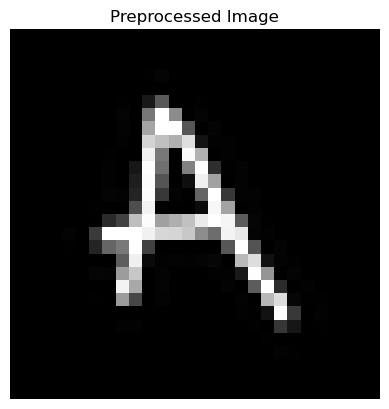

Prediction: A, Confidence: 1.0000
Top 3 predictions:
  1. A: 1.0000
  2. M: 0.0000
  3. H: 0.0000
Moved char_1.png to A_c649079d-ee2b-409d-b290-16a532edd703.png
Processing 3/190: char_10.png


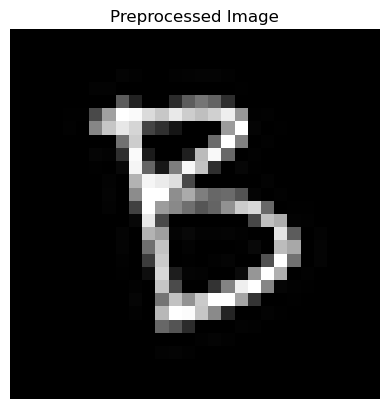

Prediction: B, Confidence: 1.0000
Top 3 predictions:
  1. B: 1.0000
  2. G: 0.0000
  3. 8: 0.0000
Moved char_10.png to B_47fb335f-7831-4c31-a826-21b2fb1c66ff.png
Processing 4/190: char_100.png


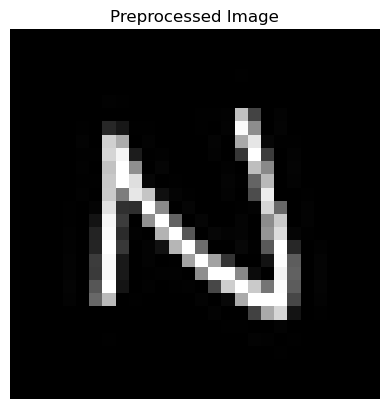

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. H: 0.0000
Moved char_100.png to N_194fd459-44f0-4ca0-8527-eb7d7a3340b5.png
Processing 5/190: char_101.png


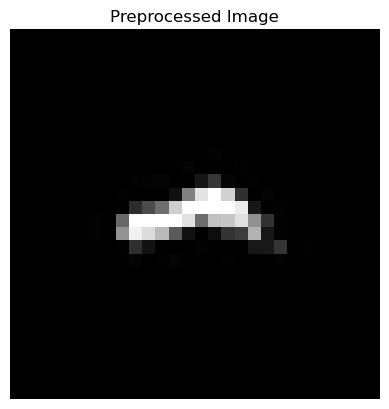

Prediction: T, Confidence: 0.2380
Top 3 predictions:
  1. T: 0.2380
  2. 1: 0.1752
  3. S: 0.0830
Skipping char_101.png - confidence 0.2380 below threshold 0.3
Processing 6/190: char_102.png


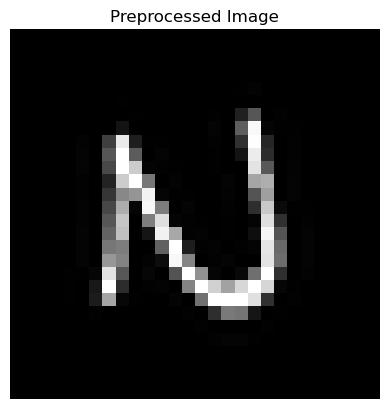

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. U: 0.0000
Moved char_102.png to N_41dc0fa4-6ca8-4393-98b3-356684cb0f21.png
Processing 7/190: char_103.png


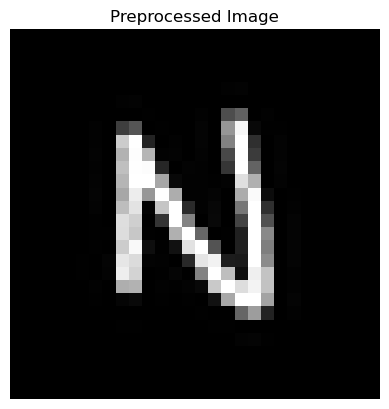

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. U: 0.0000
Moved char_103.png to N_0b3fe714-5f5b-473d-b10c-f7b00c36f864.png
Processing 8/190: char_104.png


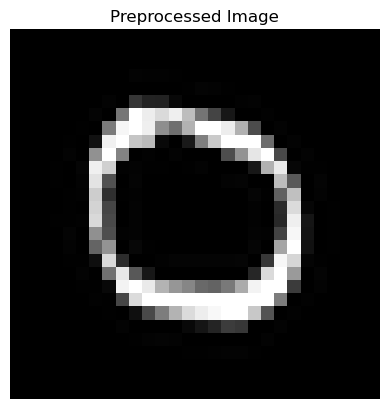

Prediction: 0, Confidence: 0.9999
Top 3 predictions:
  1. 0: 0.9999
  2. O: 0.0001
  3. 8: 0.0000
Moved char_104.png to 0_8febfffd-d76c-4b06-89cc-bbae65f2e150.png
Processing 9/190: char_105.png


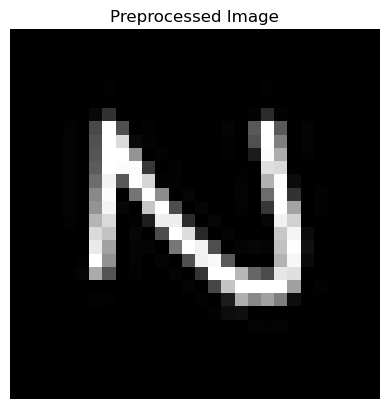

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. U: 0.0000
Moved char_105.png to N_6c1ff573-e30d-490a-b4d0-004d8819454c.png
Processing 10/190: char_106.png


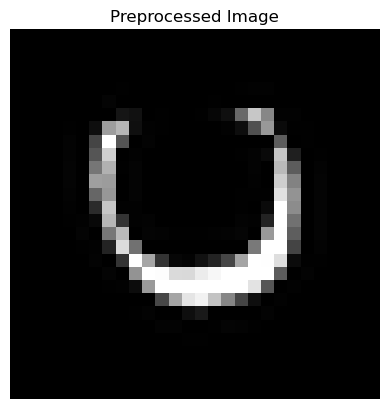

Prediction: 0, Confidence: 0.8200
Top 3 predictions:
  1. 0: 0.8200
  2. U: 0.0938
  3. 6: 0.0294
Moved char_106.png to 0_8109cfdb-590a-4ae1-9658-bcf6f5ee3bff.png
Processing 11/190: char_107.png


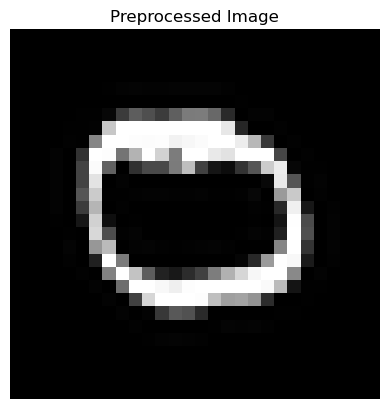

Prediction: 0, Confidence: 0.9999
Top 3 predictions:
  1. 0: 0.9999
  2. O: 0.0001
  3. 8: 0.0000
Moved char_107.png to 0_5f5b4b3a-70b8-4fe1-878c-7ace03f17d2e.png
Processing 12/190: char_108.png


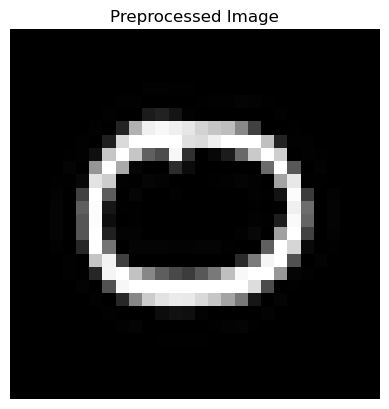

Prediction: 0, Confidence: 0.9999
Top 3 predictions:
  1. 0: 0.9999
  2. O: 0.0001
  3. 8: 0.0000
Moved char_108.png to 0_9b1e3456-38dd-4740-9908-a2b34e0967fb.png
Processing 13/190: char_109.png


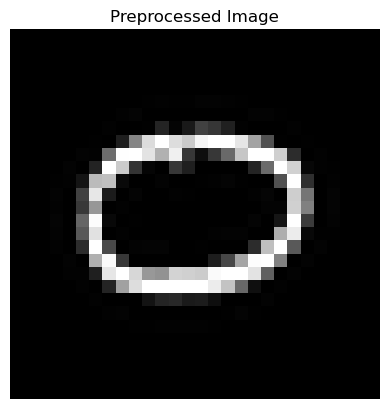

Prediction: 0, Confidence: 0.9977
Top 3 predictions:
  1. 0: 0.9977
  2. O: 0.0023
  3. 9: 0.0000
Moved char_109.png to 0_1d3df832-c7c6-4e4e-8754-14da069a06c0.png
Processing 14/190: char_11.png


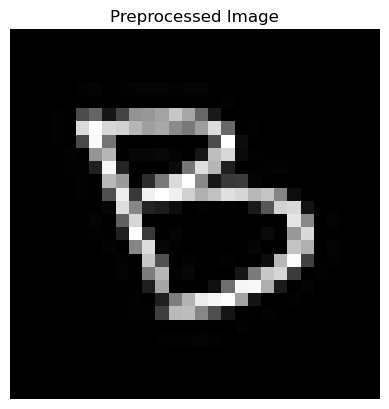

Prediction: B, Confidence: 1.0000
Top 3 predictions:
  1. B: 1.0000
  2. G: 0.0000
  3. 8: 0.0000
Moved char_11.png to B_d46a7263-44fe-4bc9-8083-3d1a23663cd5.png
Processing 15/190: char_110.png


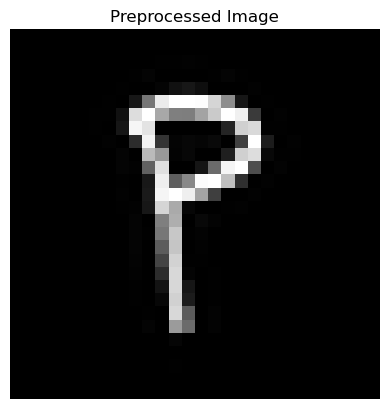

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. B: 0.0000
Moved char_110.png to P_c5620f4e-2a57-4c05-a6d5-4af7e279b363.png
Processing 16/190: char_111.png


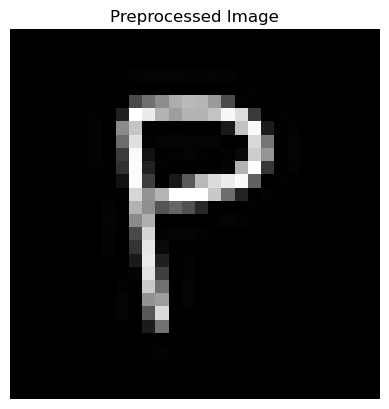

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. Q: 0.0000
Moved char_111.png to P_8be60e2d-7806-45db-a1eb-c01482a08c0f.png
Processing 17/190: char_112.png


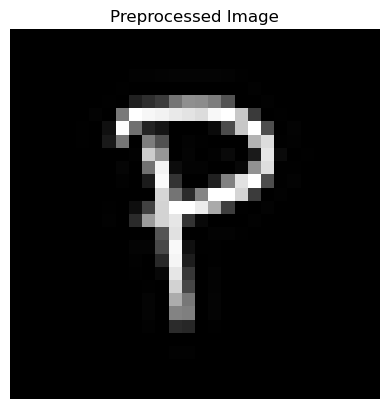

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. Q: 0.0000
Moved char_112.png to P_f5b2dcfe-5c30-4072-ae03-f0713e9b779c.png
Processing 18/190: char_113.png


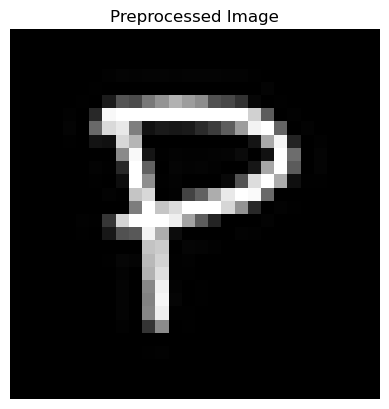

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. Q: 0.0000
Moved char_113.png to P_7c2b9e07-54ef-4deb-98d7-0f99b6275998.png
Processing 19/190: char_114.png


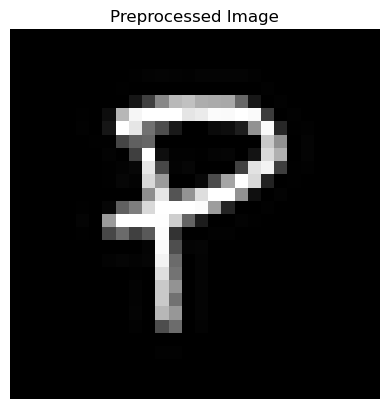

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. Q: 0.0000
Moved char_114.png to P_fceed84d-4574-4c10-ab9f-c664b119cacd.png
Processing 20/190: char_115.png


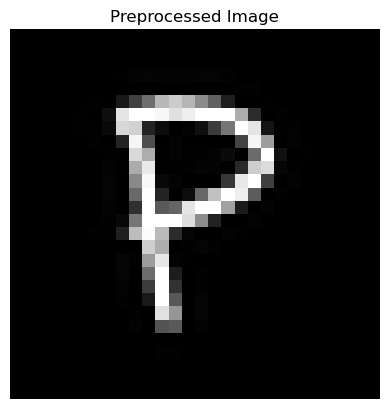

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. B: 0.0000
Moved char_115.png to P_605e31e4-4f76-4b84-b051-9997f0c2c63b.png
Processing 21/190: char_116.png


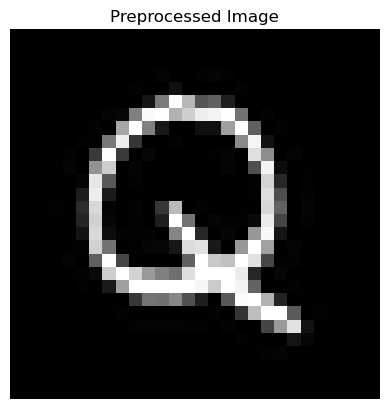

Prediction: Q, Confidence: 1.0000
Top 3 predictions:
  1. Q: 1.0000
  2. G: 0.0000
  3. O: 0.0000
Moved char_116.png to Q_de0d94bf-b74b-430d-aacd-fcaefaf38dd0.png
Processing 22/190: char_117.png


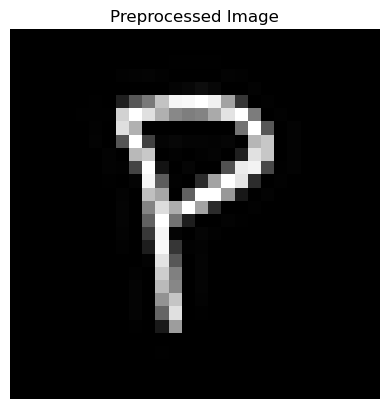

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. B: 0.0000
Moved char_117.png to P_f07ed09d-09b4-4c19-8c17-d6b1b43b1cd9.png
Processing 23/190: char_118.png


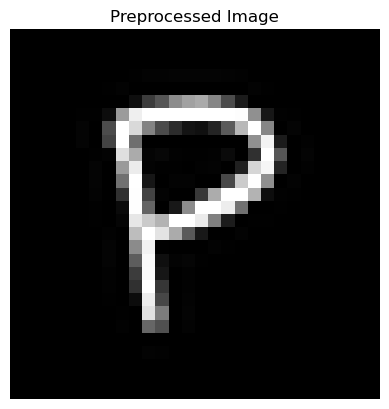

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. 8: 0.0000
Moved char_118.png to P_bf7bee2b-f6aa-4b69-8ccf-63970037209b.png
Processing 24/190: char_119.png


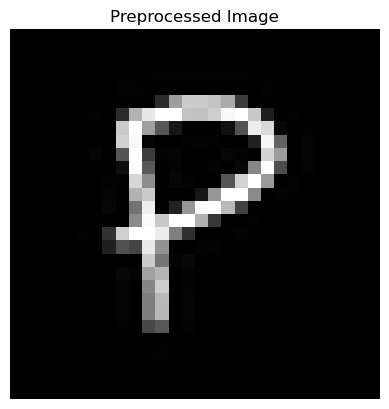

Prediction: P, Confidence: 1.0000
Top 3 predictions:
  1. P: 1.0000
  2. R: 0.0000
  3. 8: 0.0000
Moved char_119.png to P_7faa95f9-2c0a-4881-9565-272dbb7ba641.png
Processing 25/190: char_12.png


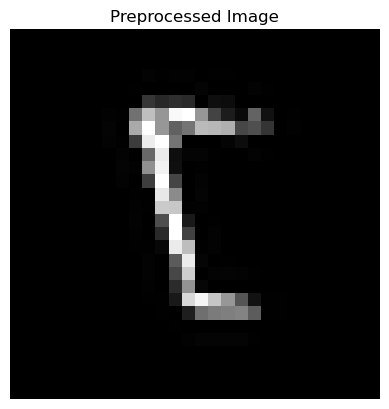

Prediction: C, Confidence: 0.6484
Top 3 predictions:
  1. C: 0.6484
  2. I: 0.1101
  3. E: 0.1026
Moved char_12.png to C_cb5d0870-8ab5-4799-870e-1645928acb16.png
Processing 26/190: char_120.png


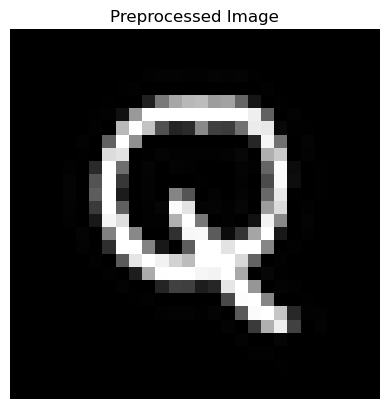

Prediction: Q, Confidence: 1.0000
Top 3 predictions:
  1. Q: 1.0000
  2. G: 0.0000
  3. 8: 0.0000
Moved char_120.png to Q_43c60d8c-0164-49b6-b0b2-3534f431dc93.png
Processing 27/190: char_121.png


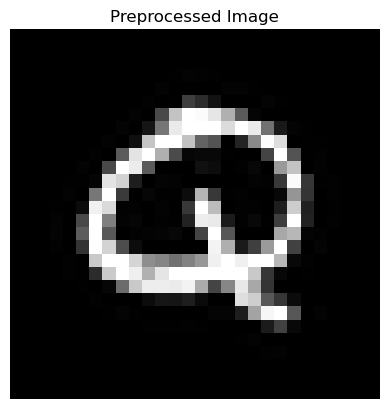

Prediction: Q, Confidence: 1.0000
Top 3 predictions:
  1. Q: 1.0000
  2. G: 0.0000
  3. 9: 0.0000
Moved char_121.png to Q_affcc31f-ec73-4ef2-94d3-f13f0a046e3d.png
Processing 28/190: char_122.png


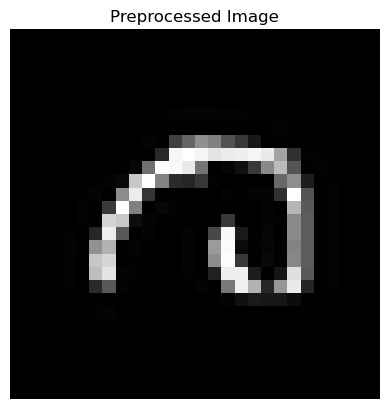

Prediction: 0, Confidence: 0.6156
Top 3 predictions:
  1. 0: 0.6156
  2. O: 0.1625
  3. Q: 0.1123
Moved char_122.png to 0_99b795b1-a86d-4419-afb9-909d37397332.png
Processing 29/190: char_123.png


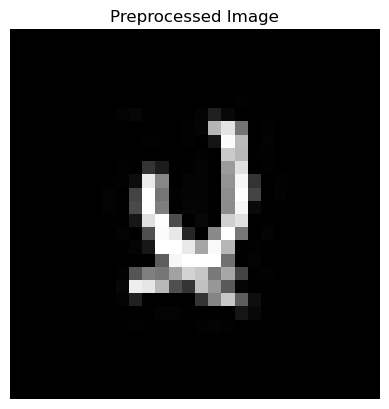

Prediction: 4, Confidence: 0.5118
Top 3 predictions:
  1. 4: 0.5118
  2. 8: 0.2764
  3. 2: 0.0624
Moved char_123.png to 4_dad86867-4ea6-4d55-9c2d-ab76130cf64a.png
Processing 30/190: char_124.png


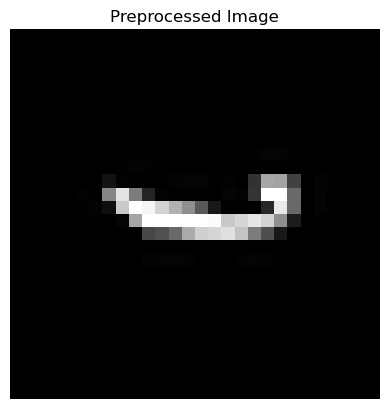

Prediction: 2, Confidence: 0.5459
Top 3 predictions:
  1. 2: 0.5459
  2. 1: 0.0687
  3. 7: 0.0536
Moved char_124.png to 2_84f2af26-3817-48e5-a315-2d881df5af05.png
Processing 31/190: char_125.png


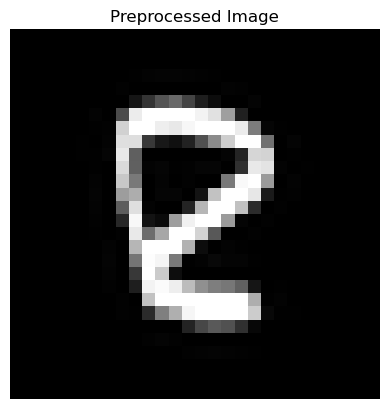

Prediction: 8, Confidence: 0.9696
Top 3 predictions:
  1. 8: 0.9696
  2. R: 0.0203
  3. 2: 0.0046
Moved char_125.png to 8_54e07cf7-429d-4284-a1c1-31408ba99bdb.png
Processing 32/190: char_126.png


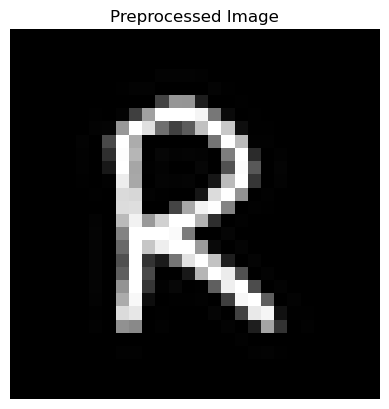

Prediction: R, Confidence: 1.0000
Top 3 predictions:
  1. R: 1.0000
  2. B: 0.0000
  3. K: 0.0000
Moved char_126.png to R_53f16bdd-7a03-483a-a7ce-6a74d775d54e.png
Processing 33/190: char_127.png


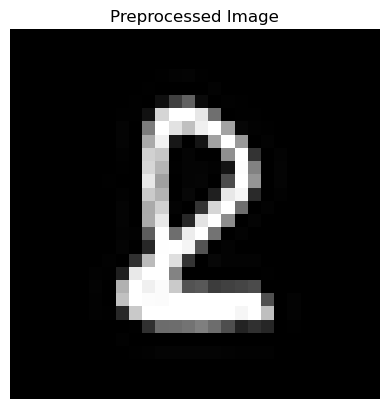

Prediction: 8, Confidence: 0.5134
Top 3 predictions:
  1. 8: 0.5134
  2. R: 0.3128
  3. 2: 0.1449
Moved char_127.png to 8_95e728c4-98ae-45c0-9ee2-f15e616d85e6.png
Processing 34/190: char_128.png


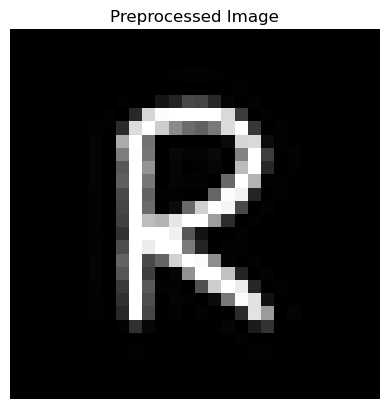

Prediction: R, Confidence: 1.0000
Top 3 predictions:
  1. R: 1.0000
  2. B: 0.0000
  3. P: 0.0000
Moved char_128.png to R_a2c16d3d-bb60-4e8f-93d0-e4b3fc23b7c7.png
Processing 35/190: char_129.png


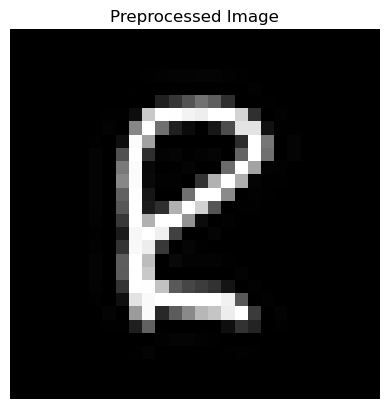

Prediction: R, Confidence: 0.9965
Top 3 predictions:
  1. R: 0.9965
  2. E: 0.0011
  3. 8: 0.0007
Moved char_129.png to R_decacd3a-05ad-4f27-b9c2-e261ff46c593.png
Processing 36/190: char_13.png


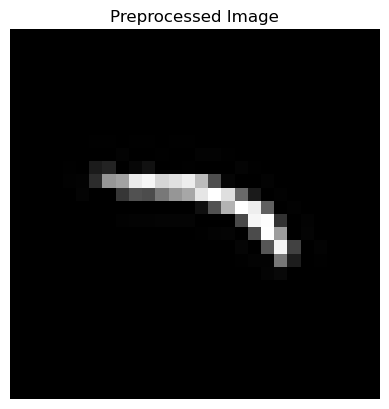

Prediction: 7, Confidence: 0.8632
Top 3 predictions:
  1. 7: 0.8632
  2. T: 0.1228
  3. 1: 0.0052
Created directory: testing_data/data/7
Moved char_13.png to 7_5876a522-5165-46a3-8c55-37487421f1e4.png
Processing 37/190: char_130.png


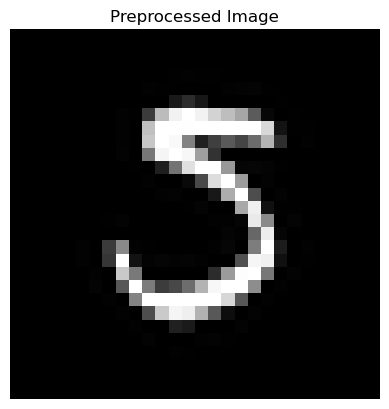

Prediction: 5, Confidence: 0.9998
Top 3 predictions:
  1. 5: 0.9998
  2. S: 0.0002
  3. 3: 0.0000
Moved char_130.png to 5_843babd6-ced3-40d8-9ab3-bc0e35432823.png
Processing 38/190: char_131.png


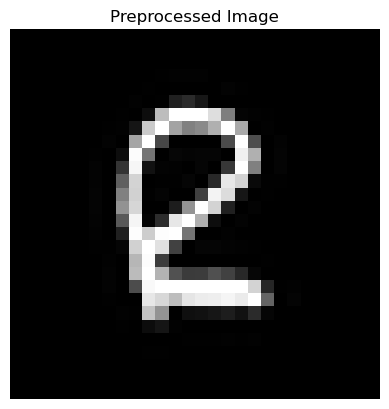

Prediction: R, Confidence: 0.9413
Top 3 predictions:
  1. R: 0.9413
  2. 8: 0.0452
  3. 2: 0.0049
Moved char_131.png to R_e67c7097-5a94-40a4-9461-99cbc5cecd71.png
Processing 39/190: char_132.png


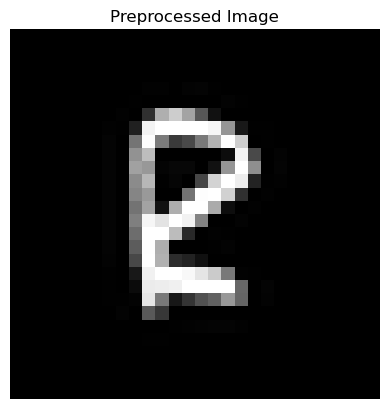

Prediction: R, Confidence: 0.9963
Top 3 predictions:
  1. R: 0.9963
  2. B: 0.0014
  3. P: 0.0008
Moved char_132.png to R_1874574f-e6b1-4ad2-a9ab-372e3cb09b29.png
Processing 40/190: char_133.png


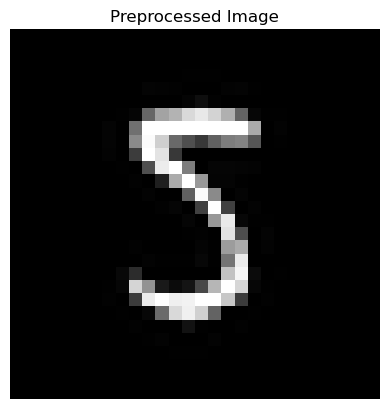

Prediction: S, Confidence: 0.6697
Top 3 predictions:
  1. S: 0.6697
  2. 5: 0.3303
  3. 8: 0.0000
Moved char_133.png to S_71617b85-c43e-40ac-914e-5b3b2e4a5452.png
Processing 41/190: char_134.png


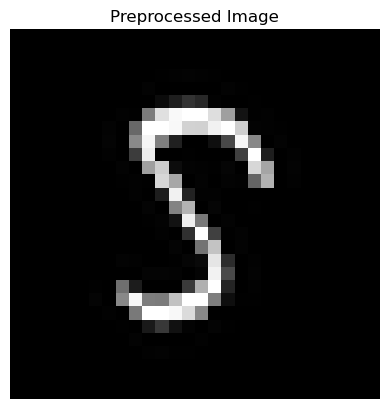

Prediction: S, Confidence: 0.9967
Top 3 predictions:
  1. S: 0.9967
  2. 5: 0.0033
  3. G: 0.0000
Moved char_134.png to S_6948262a-7905-4bdd-b28d-ee2cb27047da.png
Processing 42/190: char_135.png


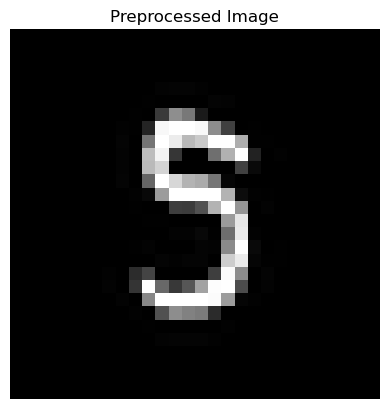

Prediction: 5, Confidence: 0.9575
Top 3 predictions:
  1. 5: 0.9575
  2. S: 0.0330
  3. 9: 0.0058
Moved char_135.png to 5_1ec11c9c-fd9f-4cd4-ac7a-3de39f7f6aa2.png
Processing 43/190: char_136.png


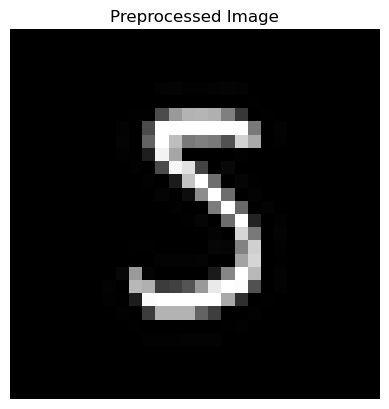

Prediction: S, Confidence: 0.6714
Top 3 predictions:
  1. S: 0.6714
  2. 5: 0.3285
  3. 3: 0.0000
Moved char_136.png to S_ead89e50-fa84-4f06-bbc0-cfe227d26d4d.png
Processing 44/190: char_137.png


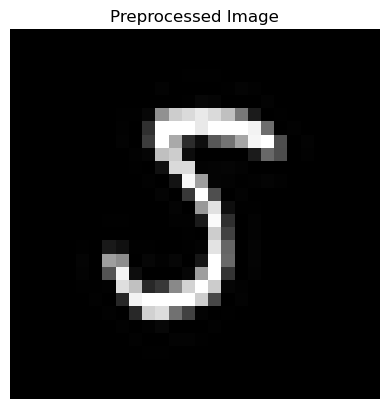

Prediction: S, Confidence: 0.9576
Top 3 predictions:
  1. S: 0.9576
  2. 5: 0.0423
  3. J: 0.0001
Moved char_137.png to S_56367b34-78e3-4e51-9536-d672e34d2c67.png
Processing 45/190: char_138.png


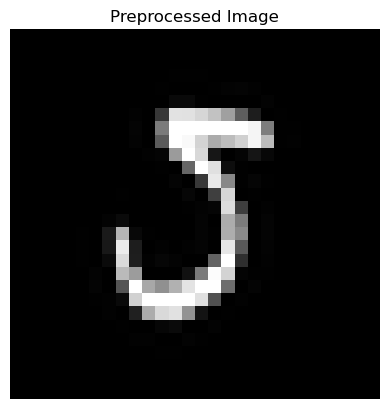

Prediction: 5, Confidence: 0.9907
Top 3 predictions:
  1. 5: 0.9907
  2. S: 0.0092
  3. 6: 0.0001
Moved char_138.png to 5_cc404f03-c264-411b-846d-0ec1f59bcd5e.png
Processing 46/190: char_139.png


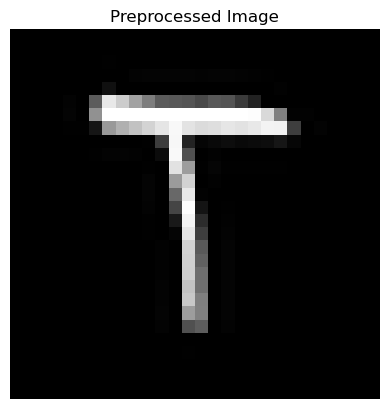

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. U: 0.0000
  3. J: 0.0000
Moved char_139.png to T_de3283d1-88ce-4cc2-a7c4-5faf18a7fcbc.png
Processing 47/190: char_14.png


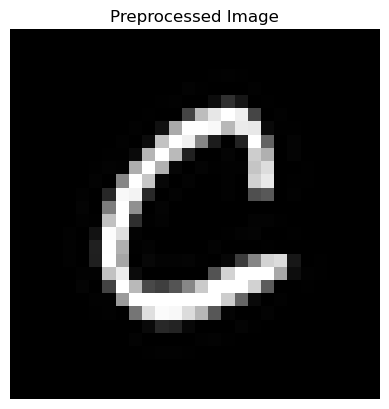

Prediction: C, Confidence: 0.9534
Top 3 predictions:
  1. C: 0.9534
  2. 6: 0.0453
  3. 0: 0.0010
Moved char_14.png to C_c1e08e94-797b-4818-b9e0-56627ae59ced.png
Processing 48/190: char_140.png


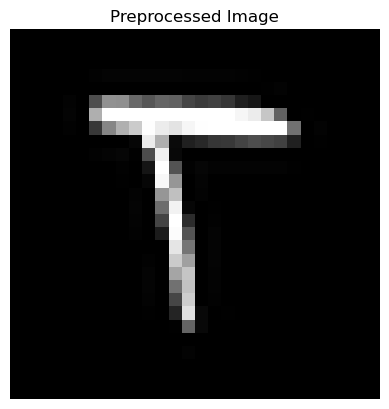

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. U: 0.0000
  3. J: 0.0000
Moved char_140.png to T_aef0721e-ab7b-4f43-8954-71d7fed2da93.png
Processing 49/190: char_141.png


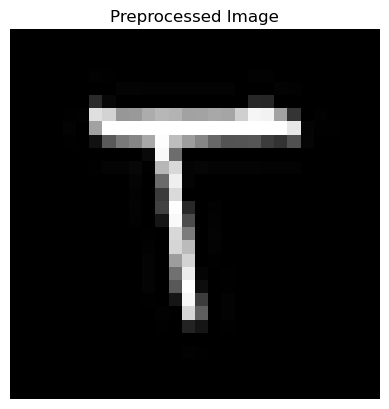

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. U: 0.0000
  3. J: 0.0000
Moved char_141.png to T_5391aa09-7c9d-467a-8340-031d53610329.png
Processing 50/190: char_142.png


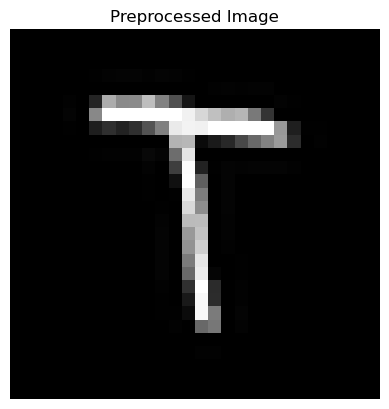

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. U: 0.0000
  3. J: 0.0000
Moved char_142.png to T_414376a4-1428-4208-a012-5df6bfa7de1e.png
Processing 51/190: char_143.png


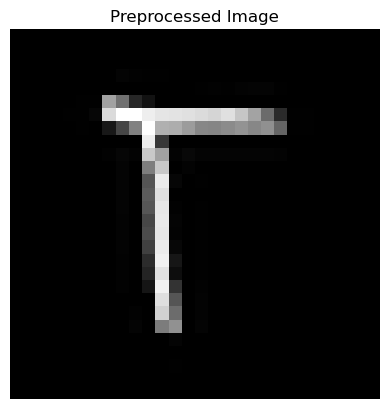

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. U: 0.0000
  3. J: 0.0000
Moved char_143.png to T_01f175b8-2e42-4475-ae62-b9024f32bf1c.png
Processing 52/190: char_144.png


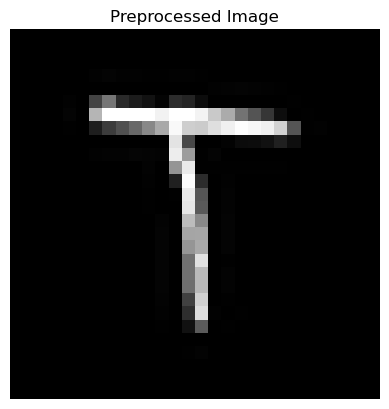

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. J: 0.0000
  3. U: 0.0000
Moved char_144.png to T_de3f5253-fbb2-4ff3-893c-22887e500f52.png
Processing 53/190: char_145.png


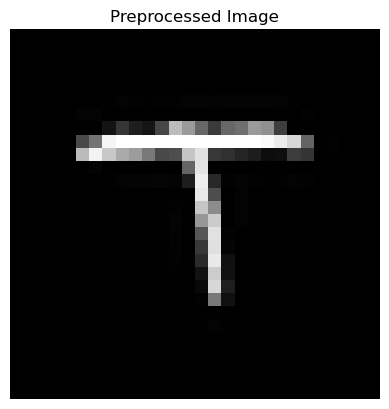

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. U: 0.0000
  3. J: 0.0000
Moved char_145.png to T_d1fc2566-8816-4add-ab1f-c26a6c73ec87.png
Processing 54/190: char_146.png


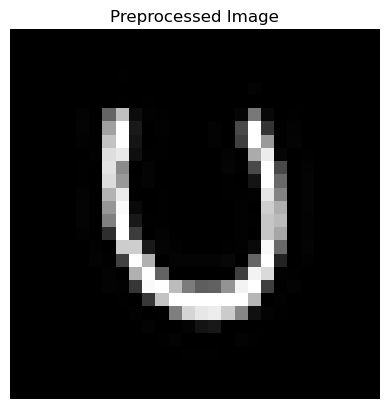

Prediction: U, Confidence: 0.9872
Top 3 predictions:
  1. U: 0.9872
  2. 0: 0.0120
  3. 4: 0.0003
Moved char_146.png to U_d111386e-94eb-4691-a931-df4e635ba6c2.png
Processing 55/190: char_147.png


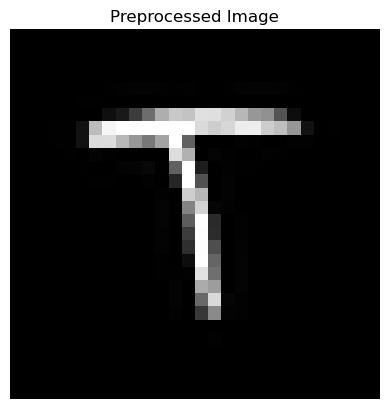

Prediction: T, Confidence: 1.0000
Top 3 predictions:
  1. T: 1.0000
  2. U: 0.0000
  3. J: 0.0000
Moved char_147.png to T_41a04015-4bd4-4d99-b6e2-06377a15cedd.png
Processing 56/190: char_148.png


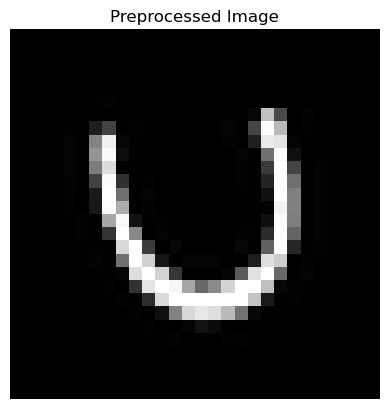

Prediction: U, Confidence: 0.9732
Top 3 predictions:
  1. U: 0.9732
  2. 0: 0.0260
  3. J: 0.0004
Moved char_148.png to U_3f5c5771-61f1-4eb5-a1ff-d64f0b1798db.png
Processing 57/190: char_149.png


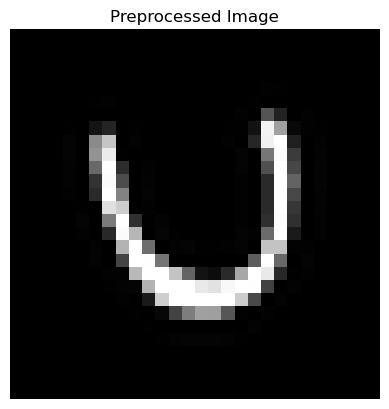

Prediction: U, Confidence: 0.9879
Top 3 predictions:
  1. U: 0.9879
  2. 0: 0.0071
  3. J: 0.0028
Moved char_149.png to U_dc7a55ec-45d9-4633-ad24-c45775ef6c58.png
Processing 58/190: char_15.png


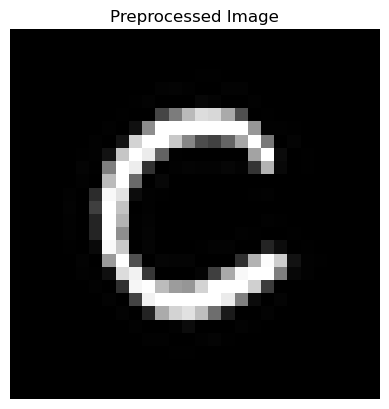

Prediction: C, Confidence: 0.9187
Top 3 predictions:
  1. C: 0.9187
  2. 6: 0.0752
  3. 0: 0.0055
Moved char_15.png to C_a7c14144-f6a0-4cd2-af2c-50aacdba539d.png
Processing 59/190: char_150.png


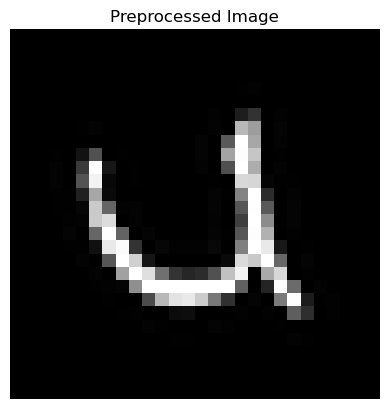

Prediction: U, Confidence: 0.9989
Top 3 predictions:
  1. U: 0.9989
  2. 4: 0.0011
  3. W: 0.0000
Moved char_150.png to U_17472d99-a5c1-4c05-8505-e954eafebfc7.png
Processing 60/190: char_151.png


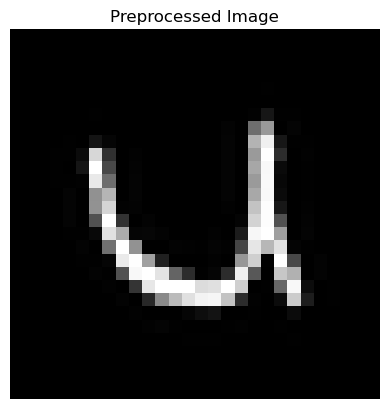

Prediction: U, Confidence: 0.9997
Top 3 predictions:
  1. U: 0.9997
  2. 4: 0.0002
  3. W: 0.0000
Moved char_151.png to U_c8388769-7179-4fdc-afc3-189dc335d2e1.png
Processing 61/190: char_152.png


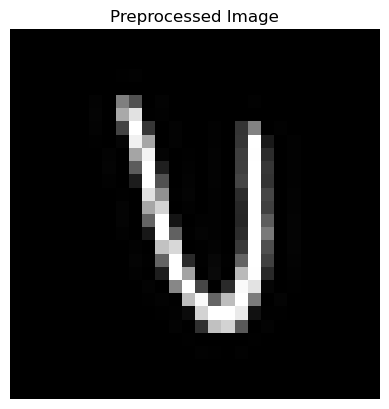

Prediction: U, Confidence: 0.7035
Top 3 predictions:
  1. U: 0.7035
  2. V: 0.1184
  3. J: 0.0349
Moved char_152.png to U_04b6c7a4-caa2-4922-b8f6-98d674066274.png
Processing 62/190: char_153.png


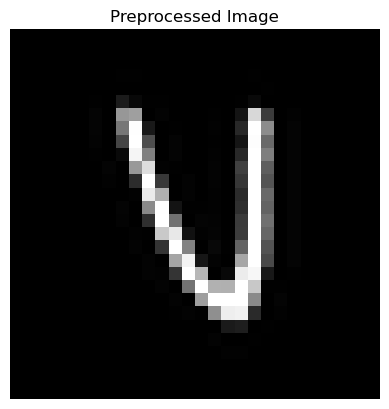

Prediction: U, Confidence: 0.5153
Top 3 predictions:
  1. U: 0.5153
  2. V: 0.2111
  3. N: 0.0738
Moved char_153.png to U_72150acd-d2f5-48f9-8ab6-17b04da45197.png
Processing 63/190: char_154.png


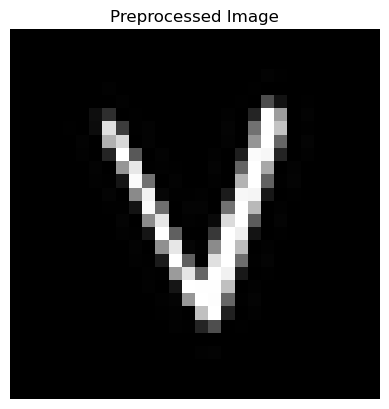

Prediction: Y, Confidence: 0.7694
Top 3 predictions:
  1. Y: 0.7694
  2. V: 0.1959
  3. X: 0.0158
Moved char_154.png to Y_ced1e92c-714c-4f8e-a8fa-375def0f4ec6.png
Processing 64/190: char_155.png


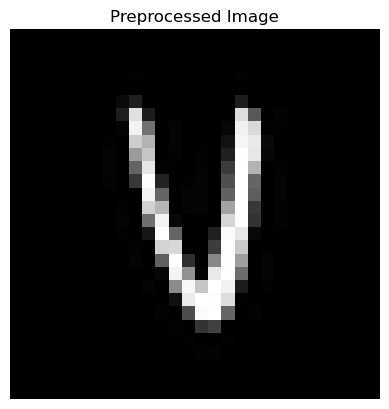

Prediction: U, Confidence: 0.3617
Top 3 predictions:
  1. U: 0.3617
  2. V: 0.1968
  3. 4: 0.1263
Moved char_155.png to U_b6835fc0-bf1b-4cab-a0ac-71b77766f4af.png
Processing 65/190: char_156.png


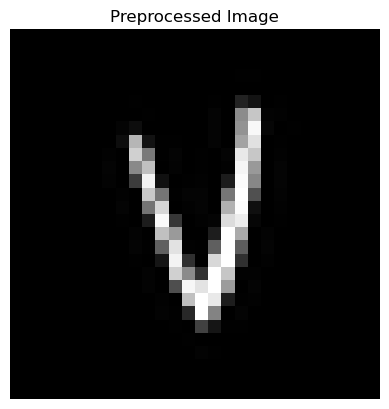

Prediction: V, Confidence: 0.3120
Top 3 predictions:
  1. V: 0.3120
  2. Y: 0.1743
  3. 4: 0.1587
Created directory: testing_data/data/V
Moved char_156.png to V_40e6a28e-e05e-4d9b-8cc9-ada0c7f6079f.png
Processing 66/190: char_157.png


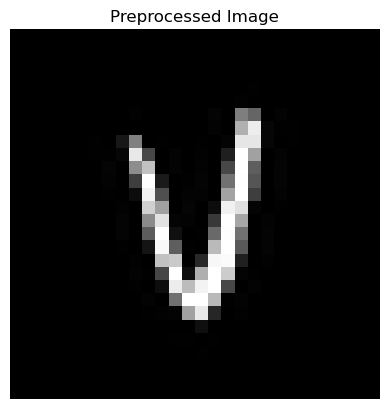

Prediction: 4, Confidence: 0.2252
Top 3 predictions:
  1. 4: 0.2252
  2. Y: 0.1670
  3. V: 0.1330
Skipping char_157.png - confidence 0.2252 below threshold 0.3
Processing 67/190: char_158.png


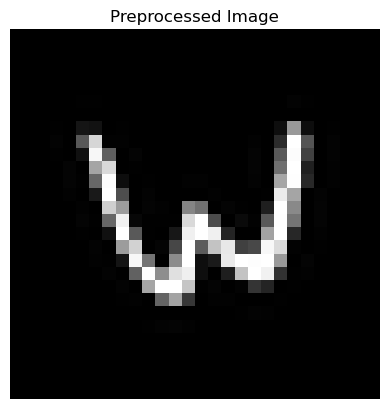

Prediction: W, Confidence: 1.0000
Top 3 predictions:
  1. W: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_158.png to W_79dbf1ee-6b69-4312-9f72-1be47ff925e7.png
Processing 68/190: char_159.png


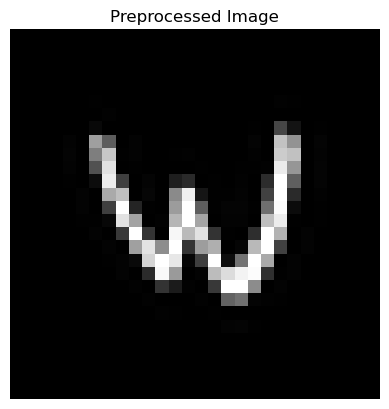

Prediction: W, Confidence: 1.0000
Top 3 predictions:
  1. W: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_159.png to W_c7f0c25b-bb07-405e-a8d8-19641e968e55.png
Processing 69/190: char_16.png


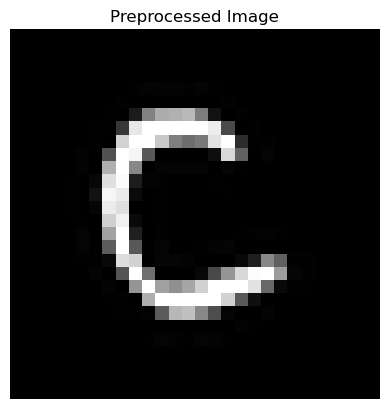

Prediction: C, Confidence: 1.0000
Top 3 predictions:
  1. C: 1.0000
  2. O: 0.0000
  3. S: 0.0000
Moved char_16.png to C_5f4621c7-f0ec-4691-bebb-4eb75c17e699.png
Processing 70/190: char_160.png


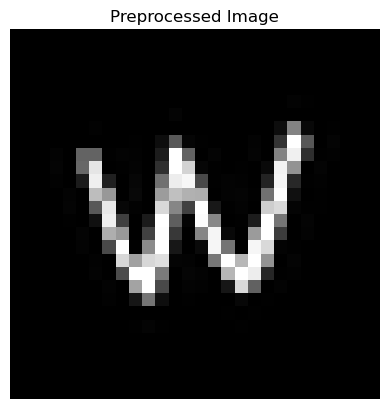

Prediction: W, Confidence: 1.0000
Top 3 predictions:
  1. W: 1.0000
  2. N: 0.0000
  3. H: 0.0000
Moved char_160.png to W_c267ccee-1037-4832-9695-b30e4cd47c98.png
Processing 71/190: char_161.png


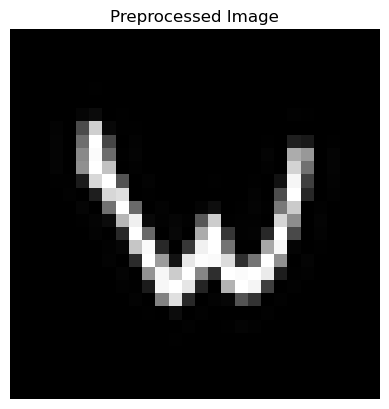

Prediction: W, Confidence: 1.0000
Top 3 predictions:
  1. W: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_161.png to W_a0e5a6fd-fd53-4e35-b4c3-6ccc1be7ab63.png
Processing 72/190: char_162.png


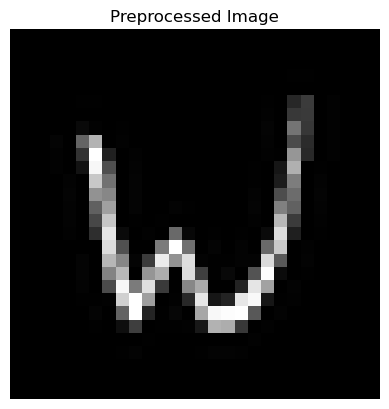

Prediction: W, Confidence: 1.0000
Top 3 predictions:
  1. W: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_162.png to W_9943adff-2732-428f-bb36-84b82349cfc6.png
Processing 73/190: char_163.png


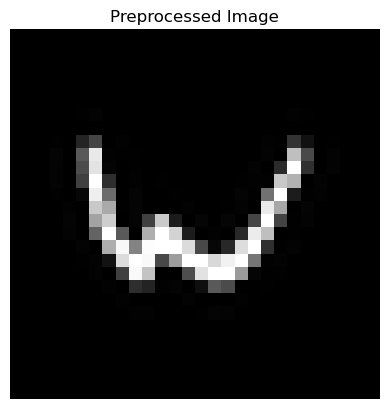

Prediction: W, Confidence: 1.0000
Top 3 predictions:
  1. W: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_163.png to W_f29328cd-34d6-49b1-9f73-48e57a3c31b0.png
Processing 74/190: char_164.png


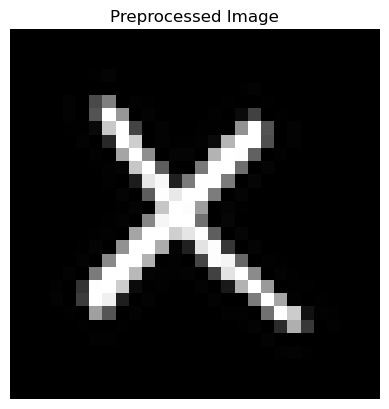

Prediction: X, Confidence: 1.0000
Top 3 predictions:
  1. X: 1.0000
  2. K: 0.0000
  3. Y: 0.0000
Moved char_164.png to X_8b6790c3-0213-4640-ae0e-47153377b763.png
Processing 75/190: char_165.png


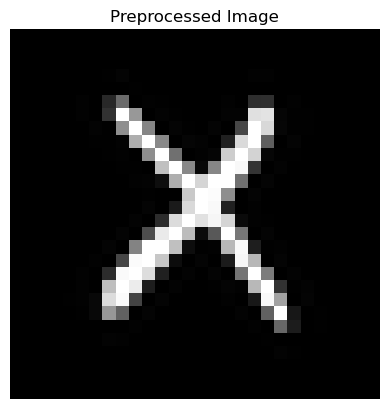

Prediction: X, Confidence: 1.0000
Top 3 predictions:
  1. X: 1.0000
  2. Y: 0.0000
  3. K: 0.0000
Moved char_165.png to X_fc2c357b-64b2-4fa8-91be-445d91e663d7.png
Processing 76/190: char_166.png


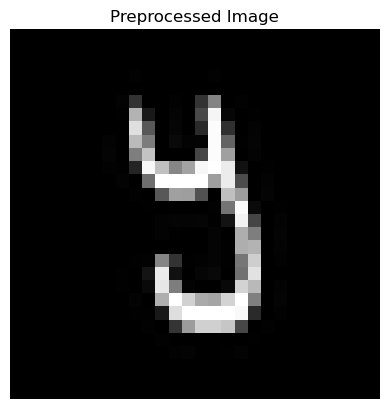

Prediction: Y, Confidence: 1.0000
Top 3 predictions:
  1. Y: 1.0000
  2. 4: 0.0000
  3. J: 0.0000
Moved char_166.png to Y_b368e01e-0386-468b-8e3b-5103ec7e54da.png
Processing 77/190: char_167.png


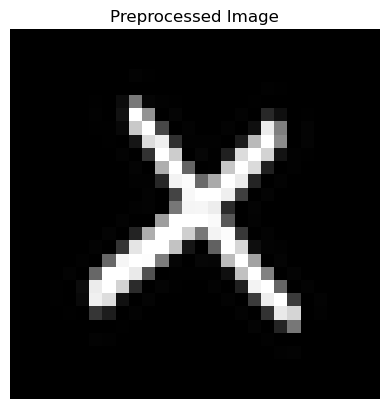

Prediction: X, Confidence: 1.0000
Top 3 predictions:
  1. X: 1.0000
  2. K: 0.0000
  3. Y: 0.0000
Moved char_167.png to X_bfa6b1be-4af2-4bcf-b6a8-fb32b957f561.png
Processing 78/190: char_168.png


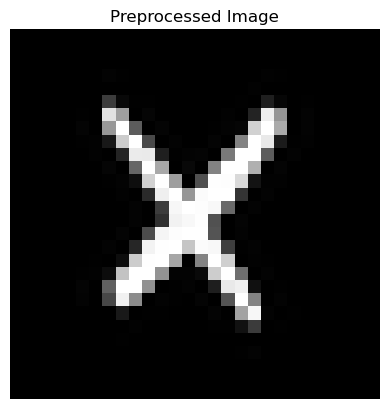

Prediction: X, Confidence: 1.0000
Top 3 predictions:
  1. X: 1.0000
  2. Y: 0.0000
  3. K: 0.0000
Moved char_168.png to X_a89a2314-acb6-4cfb-9e4b-e510b31f6bf1.png
Processing 79/190: char_169.png


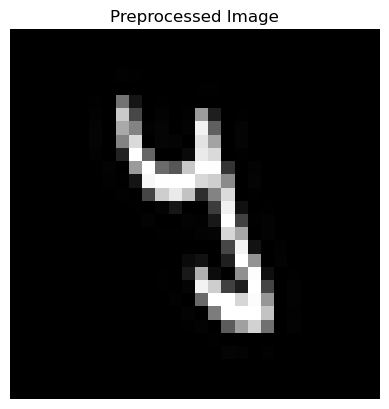

Prediction: Y, Confidence: 1.0000
Top 3 predictions:
  1. Y: 1.0000
  2. 4: 0.0000
  3. P: 0.0000
Moved char_169.png to Y_5d58eb56-3a94-4abf-b0f2-8a9046438434.png
Processing 80/190: char_17.png


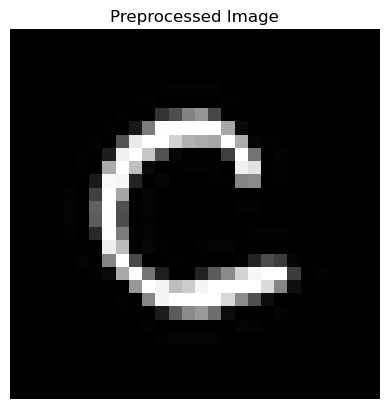

Prediction: C, Confidence: 1.0000
Top 3 predictions:
  1. C: 1.0000
  2. S: 0.0000
  3. O: 0.0000
Moved char_17.png to C_4bc15816-6b6d-441e-b206-06850f338475.png
Processing 81/190: char_170.png


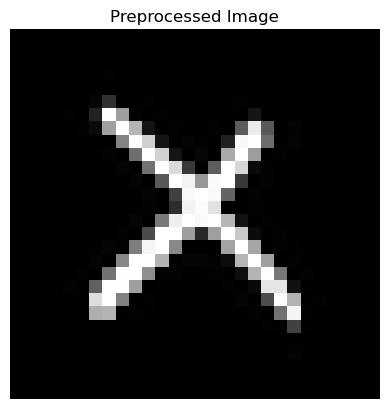

Prediction: X, Confidence: 1.0000
Top 3 predictions:
  1. X: 1.0000
  2. Y: 0.0000
  3. K: 0.0000
Moved char_170.png to X_33e66f10-57e5-4499-8d5b-ebf890ef65d0.png
Processing 82/190: char_171.png


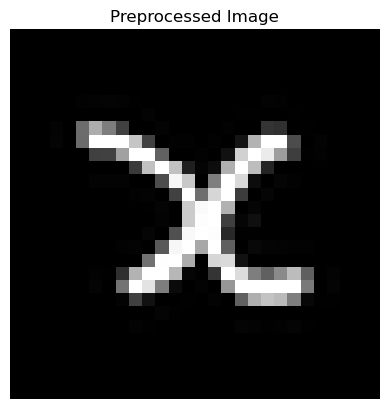

Prediction: X, Confidence: 1.0000
Top 3 predictions:
  1. X: 1.0000
  2. Y: 0.0000
  3. K: 0.0000
Moved char_171.png to X_8eeaf658-9b84-43c0-ad2e-354d548961ea.png
Processing 83/190: char_172.png


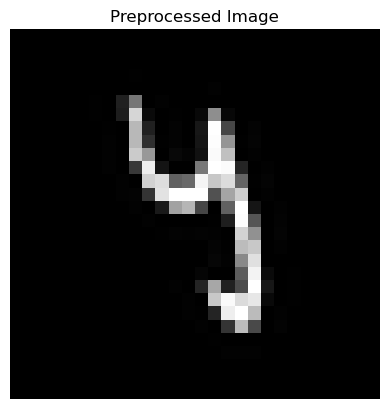

Prediction: Y, Confidence: 0.9996
Top 3 predictions:
  1. Y: 0.9996
  2. 4: 0.0003
  3. P: 0.0000
Moved char_172.png to Y_0b37da02-cc42-4bab-9ab5-3ce3fbfde30b.png
Processing 84/190: char_173.png


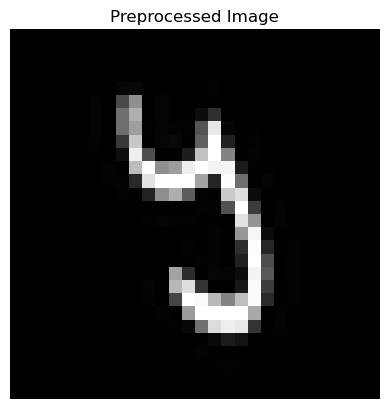

Prediction: Y, Confidence: 0.9965
Top 3 predictions:
  1. Y: 0.9965
  2. 4: 0.0021
  3. 9: 0.0005
Moved char_173.png to Y_7d2f1071-f271-4aa5-8e28-1caaddd8cdd9.png
Processing 85/190: char_174.png


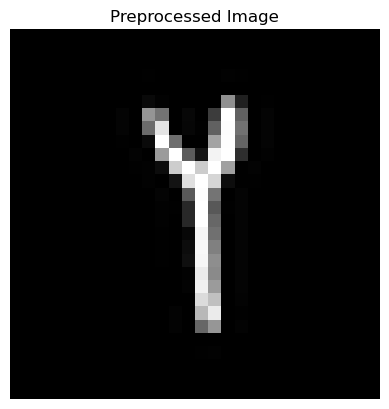

Prediction: Y, Confidence: 1.0000
Top 3 predictions:
  1. Y: 1.0000
  2. P: 0.0000
  3. X: 0.0000
Moved char_174.png to Y_1099bb33-86b2-46b7-bb9c-8ce54a2ef64b.png
Processing 86/190: char_175.png


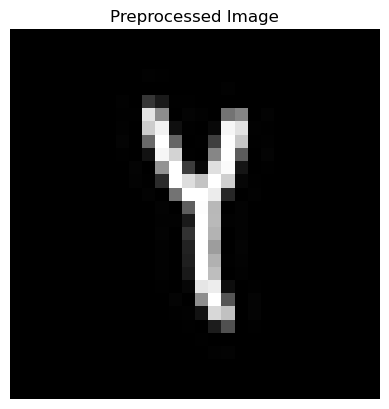

Prediction: Y, Confidence: 1.0000
Top 3 predictions:
  1. Y: 1.0000
  2. P: 0.0000
  3. X: 0.0000
Moved char_175.png to Y_78626730-2430-4c22-a7d9-e9e9ca5b95c3.png
Processing 87/190: char_176.png


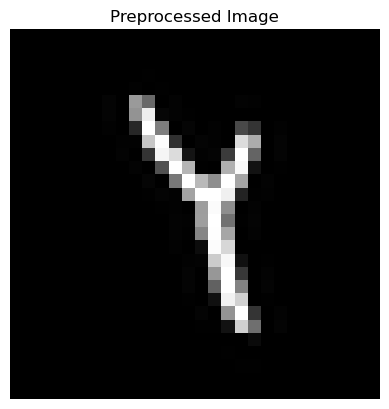

Prediction: Y, Confidence: 1.0000
Top 3 predictions:
  1. Y: 1.0000
  2. P: 0.0000
  3. X: 0.0000
Moved char_176.png to Y_8072cc94-9156-4709-9f5e-bd979c4bc30e.png
Processing 88/190: char_177.png


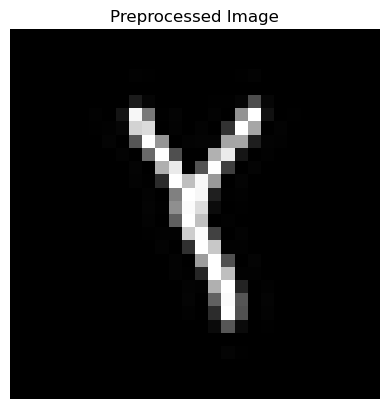

Prediction: Y, Confidence: 0.9999
Top 3 predictions:
  1. Y: 0.9999
  2. X: 0.0001
  3. V: 0.0000
Moved char_177.png to Y_58d72185-eb21-4691-9bb1-0306a3639bc0.png
Processing 89/190: char_178.png


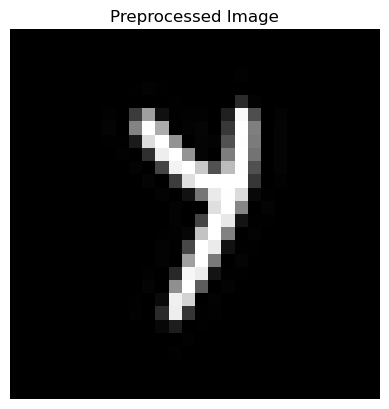

Prediction: Y, Confidence: 1.0000
Top 3 predictions:
  1. Y: 1.0000
  2. P: 0.0000
  3. 4: 0.0000
Moved char_178.png to Y_c4c1b708-6c34-417e-bdbe-71f4ec6aadfd.png
Processing 90/190: char_179.png


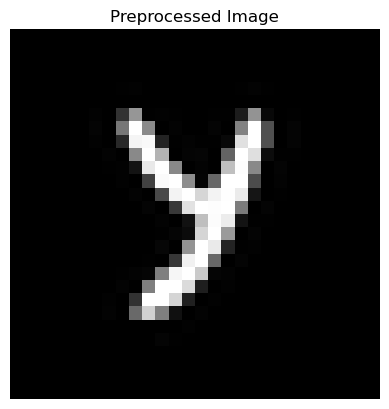

Prediction: Y, Confidence: 1.0000
Top 3 predictions:
  1. Y: 1.0000
  2. P: 0.0000
  3. 4: 0.0000
Moved char_179.png to Y_513c518a-ff24-4e39-a06e-2f15b833436c.png
Processing 91/190: char_18.png


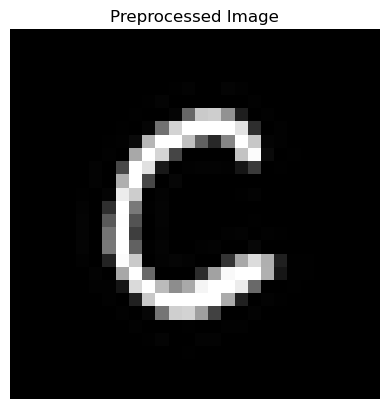

Prediction: C, Confidence: 0.9999
Top 3 predictions:
  1. C: 0.9999
  2. 6: 0.0000
  3. 0: 0.0000
Moved char_18.png to C_ce45f62b-b016-4432-95bd-c029e229b5cb.png
Processing 92/190: char_180.png


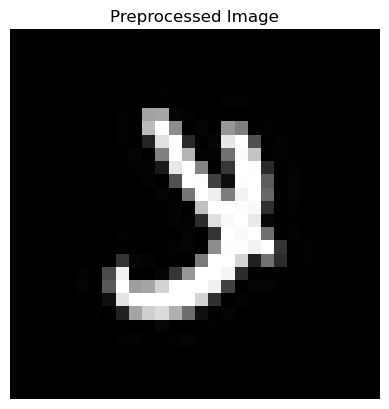

Prediction: 2, Confidence: 0.5508
Top 3 predictions:
  1. 2: 0.5508
  2. 3: 0.2042
  3. 1: 0.0537
Moved char_180.png to 2_17efa62c-22ab-475c-abb5-b82582a19dd9.png
Processing 93/190: char_181.png


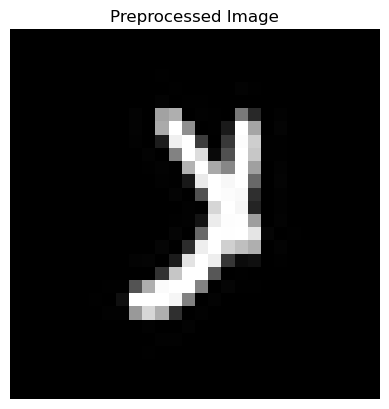

Prediction: Y, Confidence: 0.9938
Top 3 predictions:
  1. Y: 0.9938
  2. 4: 0.0030
  3. X: 0.0018
Moved char_181.png to Y_5af7d3a6-ca2f-4337-9577-77670c30c5b8.png
Processing 94/190: char_182.png


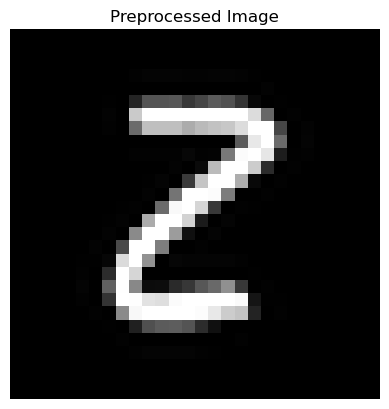

Prediction: 2, Confidence: 0.9646
Top 3 predictions:
  1. 2: 0.9646
  2. Z: 0.0327
  3. 3: 0.0017
Moved char_182.png to 2_2e917cd6-6fb3-434c-b59f-131f35e6ba08.png
Processing 95/190: char_183.png


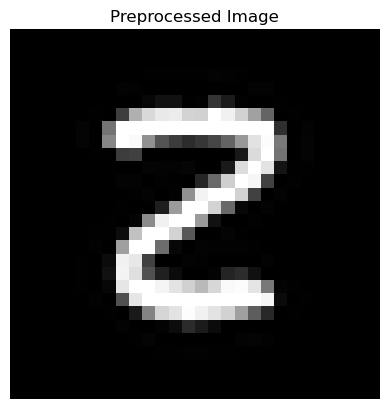

Prediction: 2, Confidence: 0.9981
Top 3 predictions:
  1. 2: 0.9981
  2. Z: 0.0017
  3. 3: 0.0001
Moved char_183.png to 2_28f582db-070b-4a1e-914e-eede82b5e7b0.png
Processing 96/190: char_184.png


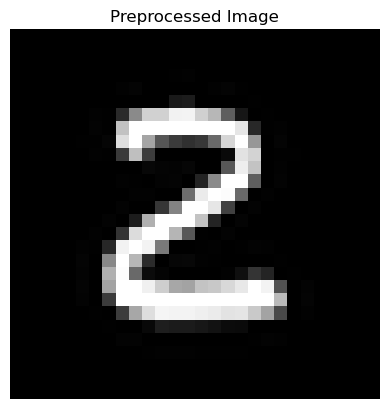

Prediction: 2, Confidence: 0.9902
Top 3 predictions:
  1. 2: 0.9902
  2. Z: 0.0097
  3. 3: 0.0001
Moved char_184.png to 2_df2207a9-c698-4e22-9c66-475718ff68f5.png
Processing 97/190: char_185.png


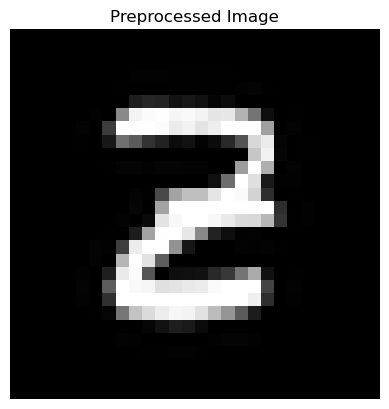

Prediction: 2, Confidence: 0.5811
Top 3 predictions:
  1. 2: 0.5811
  2. Z: 0.3820
  3. 3: 0.0356
Moved char_185.png to 2_35862581-f843-4626-bbef-93eab602fd62.png
Processing 98/190: char_186.png


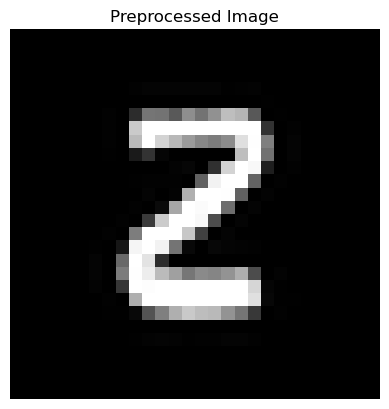

Prediction: 2, Confidence: 0.9865
Top 3 predictions:
  1. 2: 0.9865
  2. Z: 0.0132
  3. 3: 0.0003
Moved char_186.png to 2_2ae8d6f3-f55d-4b5e-a3b6-f813b94b71ff.png
Processing 99/190: char_187.png


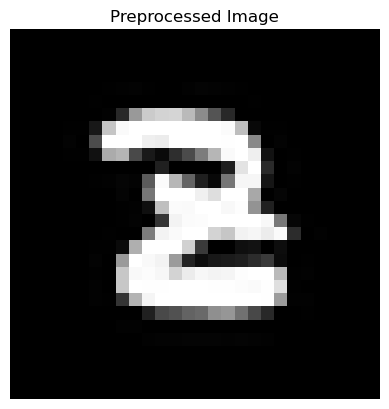

Prediction: 2, Confidence: 0.7350
Top 3 predictions:
  1. 2: 0.7350
  2. Z: 0.2606
  3. 3: 0.0034
Moved char_187.png to 2_a0fb9e43-1b8a-4362-b6ab-6c70c9732e6b.png
Processing 100/190: char_188.png


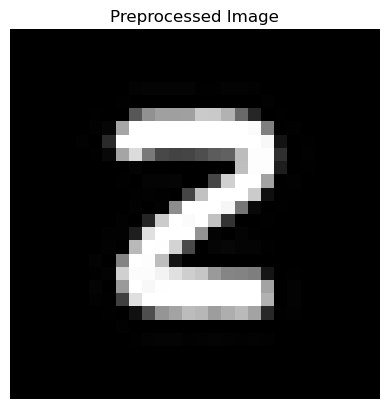

Prediction: 2, Confidence: 0.8304
Top 3 predictions:
  1. 2: 0.8304
  2. Z: 0.1694
  3. 3: 0.0001
Moved char_188.png to 2_16b69cae-e8dd-416d-bf0c-db8945275dba.png
Processing 101/190: char_189.png


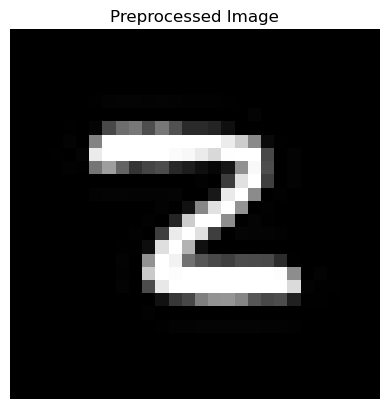

Prediction: 2, Confidence: 0.7832
Top 3 predictions:
  1. 2: 0.7832
  2. Z: 0.2166
  3. 3: 0.0001
Moved char_189.png to 2_9e0b3990-6638-496d-9823-a5a2a0037daa.png
Processing 102/190: char_19.png


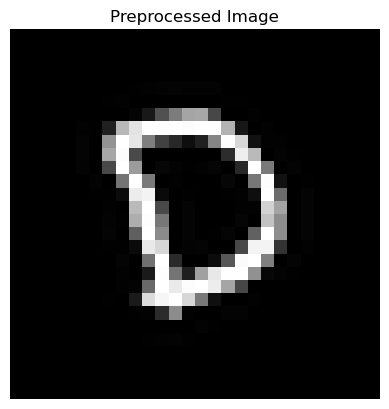

Prediction: D, Confidence: 0.9991
Top 3 predictions:
  1. D: 0.9991
  2. 0: 0.0006
  3. O: 0.0002
Moved char_19.png to D_609d459d-9e6c-493a-9b20-76973e920a1a.png
Processing 103/190: char_2.png


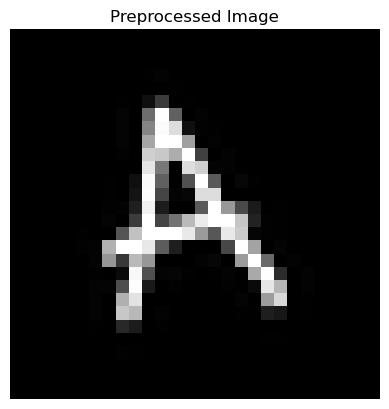

Prediction: A, Confidence: 1.0000
Top 3 predictions:
  1. A: 1.0000
  2. M: 0.0000
  3. H: 0.0000
Moved char_2.png to A_1f0c74f6-269a-496c-89a6-51ff4f265d64.png
Processing 104/190: char_20.png


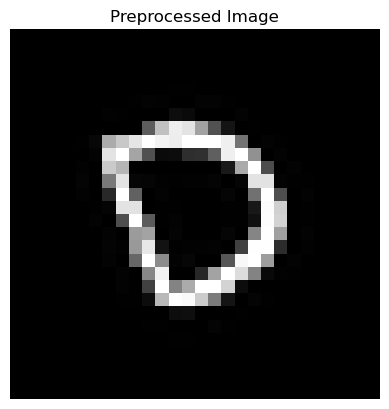

Prediction: 0, Confidence: 0.4789
Top 3 predictions:
  1. 0: 0.4789
  2. D: 0.3498
  3. O: 0.1688
Moved char_20.png to 0_b7ecde8b-8320-4015-bbe0-34522595ce7a.png
Processing 105/190: char_21.png


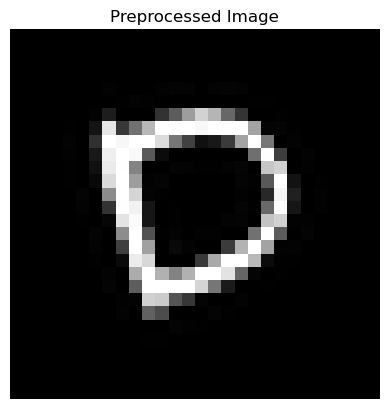

Prediction: D, Confidence: 0.9902
Top 3 predictions:
  1. D: 0.9902
  2. P: 0.0047
  3. O: 0.0029
Moved char_21.png to D_6b9f6677-22b2-491e-b11b-4d69a1066d69.png
Processing 106/190: char_22.png


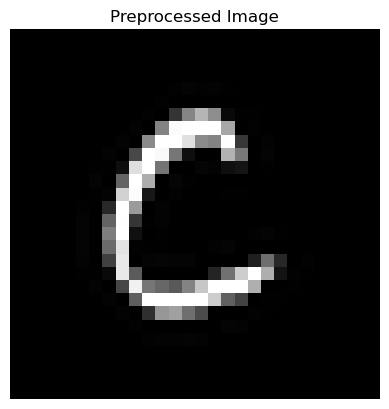

Prediction: C, Confidence: 0.9999
Top 3 predictions:
  1. C: 0.9999
  2. G: 0.0000
  3. O: 0.0000
Moved char_22.png to C_2de8fc3b-32d0-4cc6-b0f3-cab926966ab1.png
Processing 107/190: char_23.png


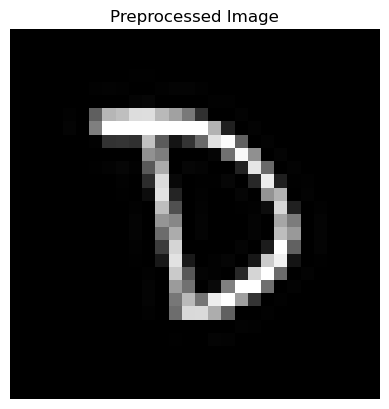

Prediction: D, Confidence: 1.0000
Top 3 predictions:
  1. D: 1.0000
  2. P: 0.0000
  3. O: 0.0000
Moved char_23.png to D_8df66259-5e4c-4ab2-b5db-a2e7c7da046d.png
Processing 108/190: char_24.png


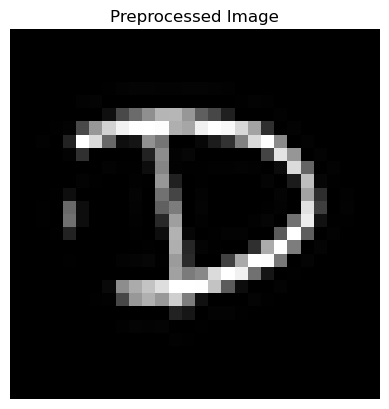

Prediction: D, Confidence: 1.0000
Top 3 predictions:
  1. D: 1.0000
  2. P: 0.0000
  3. O: 0.0000
Moved char_24.png to D_a652e58f-f2b1-4e58-bb1c-60f411ac1232.png
Processing 109/190: char_25.png


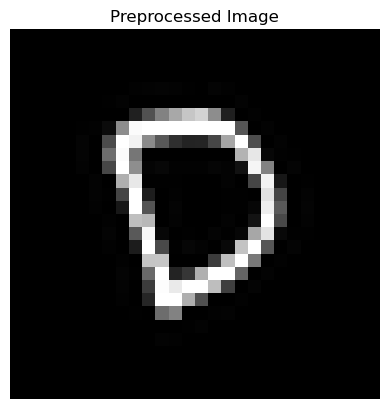

Prediction: D, Confidence: 0.4939
Top 3 predictions:
  1. D: 0.4939
  2. 0: 0.4807
  3. O: 0.0187
Moved char_25.png to D_988c64b2-09fe-4d26-a32a-6aa4cf3351b8.png
Processing 110/190: char_26.png


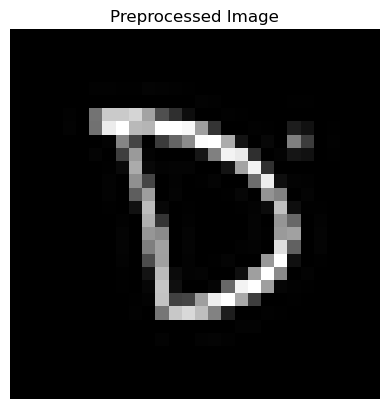

Prediction: D, Confidence: 1.0000
Top 3 predictions:
  1. D: 1.0000
  2. P: 0.0000
  3. O: 0.0000
Moved char_26.png to D_c55593a1-de3d-4aee-b8f7-4ef4576014f6.png
Processing 111/190: char_27.png


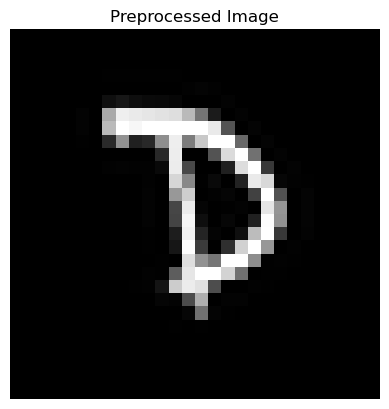

Prediction: D, Confidence: 0.7616
Top 3 predictions:
  1. D: 0.7616
  2. P: 0.2381
  3. O: 0.0002
Moved char_27.png to D_47acaf20-a0a1-4480-897e-173e6d23063b.png
Processing 112/190: char_28.png


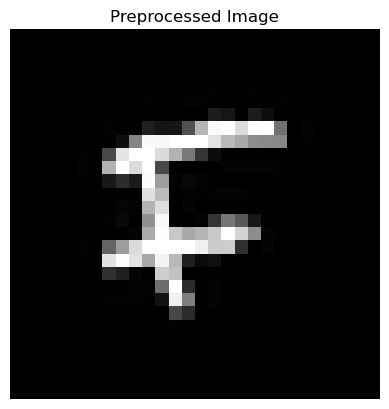

Prediction: F, Confidence: 0.9693
Top 3 predictions:
  1. F: 0.9693
  2. E: 0.0288
  3. A: 0.0005
Moved char_28.png to F_5845922d-dfd6-4fa8-a09e-bf2b1a4648e8.png
Processing 113/190: char_29.png


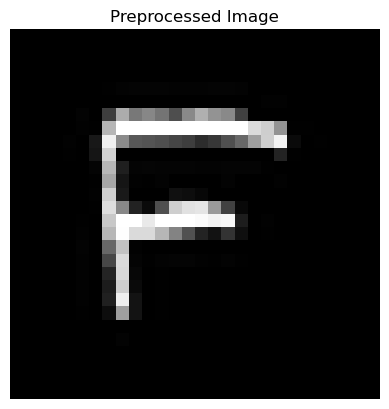

Prediction: F, Confidence: 0.9998
Top 3 predictions:
  1. F: 0.9998
  2. E: 0.0002
  3. P: 0.0000
Moved char_29.png to F_abf23ad7-b818-4ce6-8c7c-5e041296d1d5.png
Processing 114/190: char_3.png


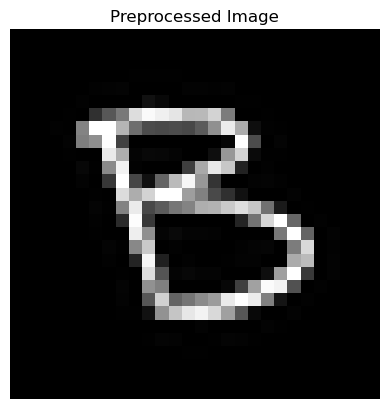

Prediction: B, Confidence: 1.0000
Top 3 predictions:
  1. B: 1.0000
  2. G: 0.0000
  3. 8: 0.0000
Moved char_3.png to B_23243009-9d16-43d3-9ae0-50a676c7487a.png
Processing 115/190: char_30.png


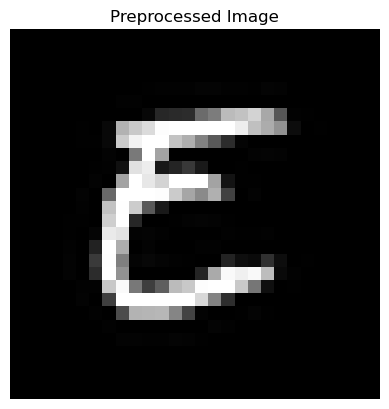

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. 5: 0.0000
  3. S: 0.0000
Moved char_30.png to E_80ebc2c6-ed53-4c5d-97cc-eb3ab916b889.png
Processing 116/190: char_31.png


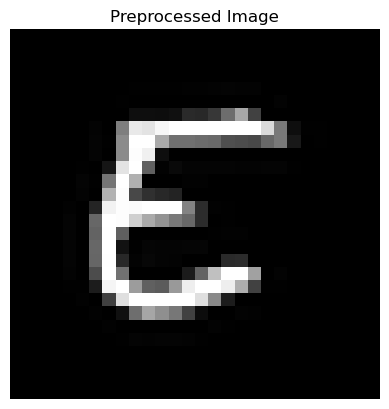

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. C: 0.0000
  3. S: 0.0000
Moved char_31.png to E_80ee1c71-1daf-45d4-a679-0701078b211a.png
Processing 117/190: char_32.png


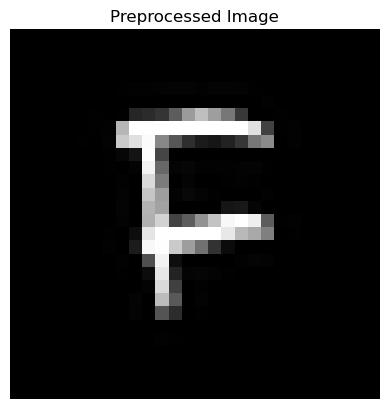

Prediction: F, Confidence: 0.9155
Top 3 predictions:
  1. F: 0.9155
  2. E: 0.0840
  3. T: 0.0001
Moved char_32.png to F_703dbf42-f32d-4dc6-afae-43c0164bca81.png
Processing 118/190: char_33.png


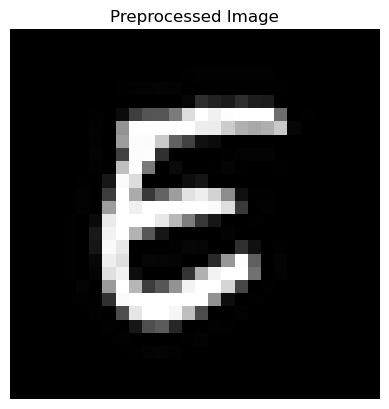

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. 5: 0.0000
  3. S: 0.0000
Moved char_33.png to E_7dc66549-07aa-4bb5-9fa9-57d10118819f.png
Processing 119/190: char_34.png


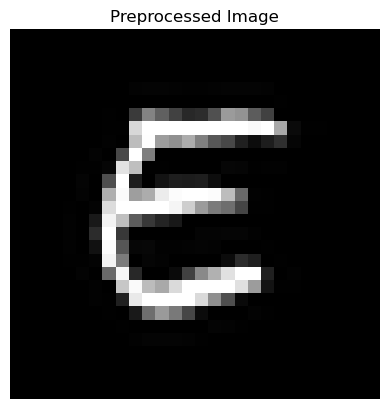

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. S: 0.0000
  3. C: 0.0000
Moved char_34.png to E_5a7eef56-490c-4dbc-9b82-2804bf2a0952.png
Processing 120/190: char_35.png


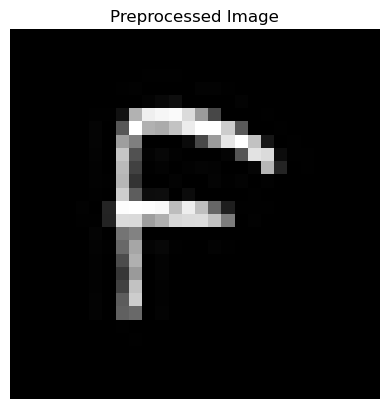

Prediction: F, Confidence: 0.9498
Top 3 predictions:
  1. F: 0.9498
  2. E: 0.0240
  3. P: 0.0208
Moved char_35.png to F_f9b5108b-07a8-4d9d-9922-a5c1c85fbcd7.png
Processing 121/190: char_36.png


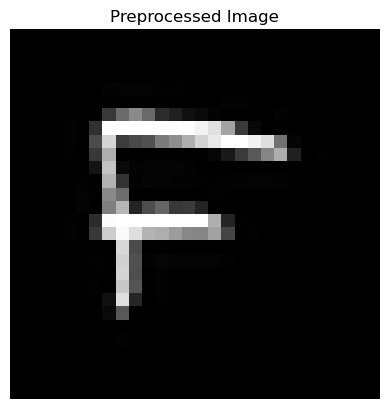

Prediction: F, Confidence: 0.9973
Top 3 predictions:
  1. F: 0.9973
  2. E: 0.0027
  3. T: 0.0000
Moved char_36.png to F_1d0f45e3-ba34-48fa-bfec-2098a8e55759.png
Processing 122/190: char_37.png


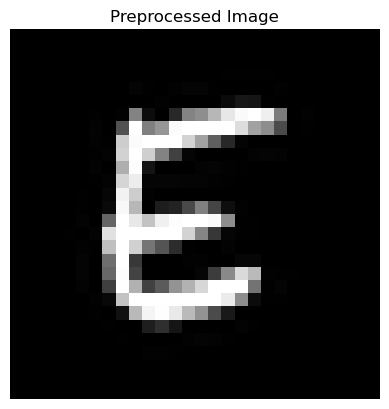

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. S: 0.0000
  3. C: 0.0000
Moved char_37.png to E_f48a9050-9b28-4e88-90a3-777e99cecc74.png
Processing 123/190: char_38.png


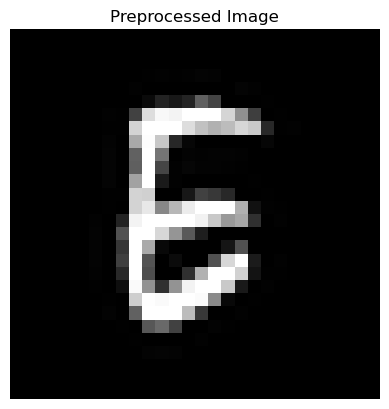

Prediction: E, Confidence: 1.0000
Top 3 predictions:
  1. E: 1.0000
  2. 5: 0.0000
  3. B: 0.0000
Moved char_38.png to E_6a37cde9-0a16-4f8a-b1ad-4462b123b732.png
Processing 124/190: char_39.png


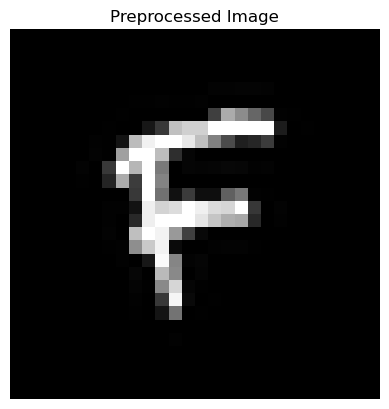

Prediction: F, Confidence: 0.9475
Top 3 predictions:
  1. F: 0.9475
  2. E: 0.0513
  3. A: 0.0003
Moved char_39.png to F_498ed0f6-c4dd-4603-8367-3ada21289175.png
Processing 125/190: char_4.png


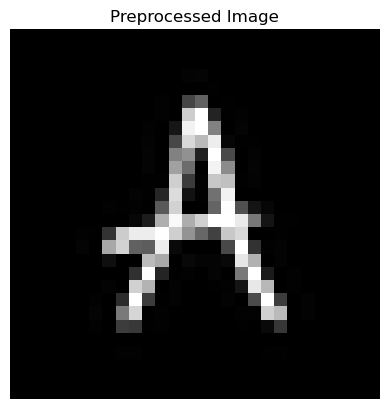

Prediction: A, Confidence: 1.0000
Top 3 predictions:
  1. A: 1.0000
  2. H: 0.0000
  3. M: 0.0000
Moved char_4.png to A_7cd3a316-9e22-4bb3-98fa-b9e54622c094.png
Processing 126/190: char_40.png


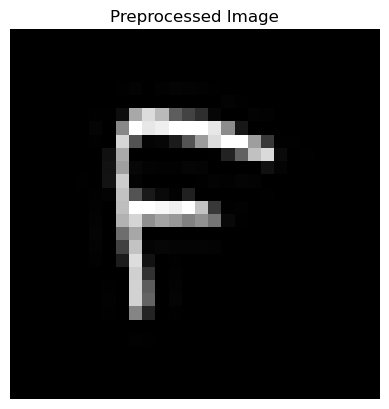

Prediction: F, Confidence: 0.9630
Top 3 predictions:
  1. F: 0.9630
  2. E: 0.0233
  3. P: 0.0068
Moved char_40.png to F_9b5eafeb-5212-499d-9a56-b8300d22548c.png
Processing 127/190: char_41.png


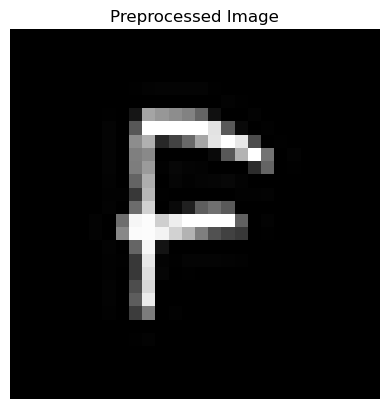

Prediction: F, Confidence: 0.9829
Top 3 predictions:
  1. F: 0.9829
  2. E: 0.0141
  3. P: 0.0025
Moved char_41.png to F_d232554c-b74b-47d6-a579-887d80b39998.png
Processing 128/190: char_42.png


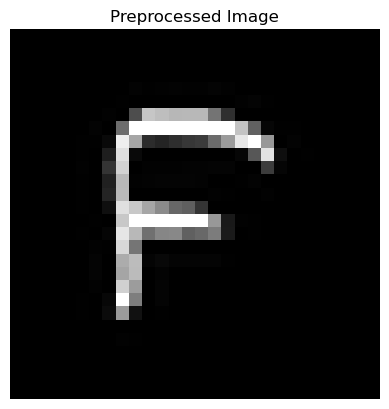

Prediction: F, Confidence: 0.9350
Top 3 predictions:
  1. F: 0.9350
  2. E: 0.0505
  3. P: 0.0076
Moved char_42.png to F_77cb9e6c-8670-4c1d-8043-4ad40b2eaf1f.png
Processing 129/190: char_43.png


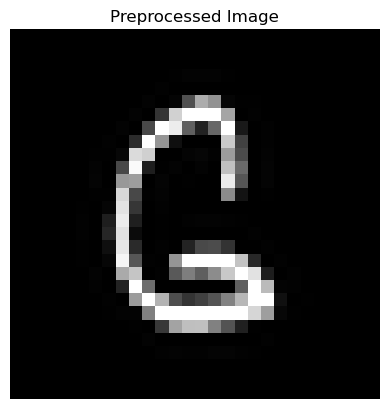

Prediction: G, Confidence: 0.9792
Top 3 predictions:
  1. G: 0.9792
  2. 6: 0.0208
  3. C: 0.0000
Moved char_43.png to G_d9d9e513-9ff4-432d-bf96-7bbfa563e36c.png
Processing 130/190: char_44.png


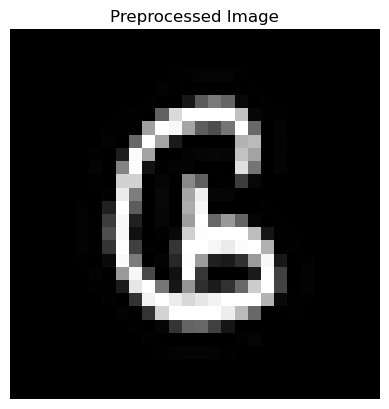

Prediction: 6, Confidence: 0.9994
Top 3 predictions:
  1. 6: 0.9994
  2. G: 0.0005
  3. 5: 0.0000
Moved char_44.png to 6_b884aeee-ea93-45b8-a246-c0935dfa6a43.png
Processing 131/190: char_45.png


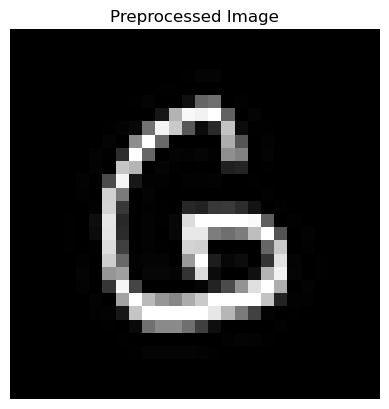

Prediction: G, Confidence: 0.6722
Top 3 predictions:
  1. G: 0.6722
  2. 6: 0.3278
  3. C: 0.0000
Moved char_45.png to G_b8475be4-e314-4466-952d-e2ae9f43d011.png
Processing 132/190: char_46.png


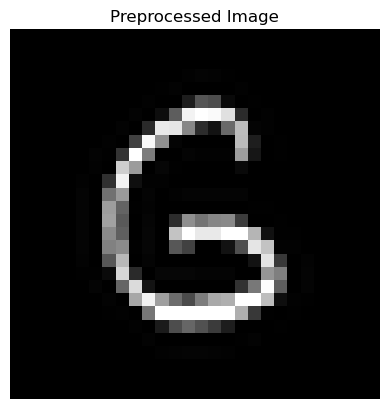

Prediction: G, Confidence: 0.9818
Top 3 predictions:
  1. G: 0.9818
  2. 6: 0.0182
  3. C: 0.0000
Moved char_46.png to G_f1408e94-7a12-4f32-8d99-fd5345e4e90f.png
Processing 133/190: char_47.png


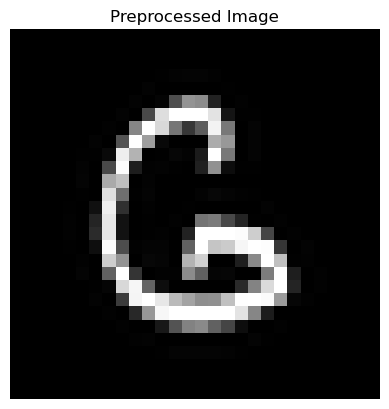

Prediction: 6, Confidence: 0.5803
Top 3 predictions:
  1. 6: 0.5803
  2. G: 0.4197
  3. C: 0.0000
Moved char_47.png to 6_a527ce99-3aa8-4472-8a90-8e076251b4e3.png
Processing 134/190: char_48.png


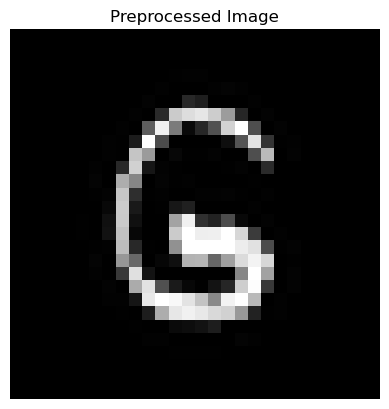

Prediction: G, Confidence: 0.9437
Top 3 predictions:
  1. G: 0.9437
  2. 6: 0.0563
  3. C: 0.0000
Moved char_48.png to G_562db2d4-f90b-4bf7-936a-d0dfcb284863.png
Processing 135/190: char_49.png


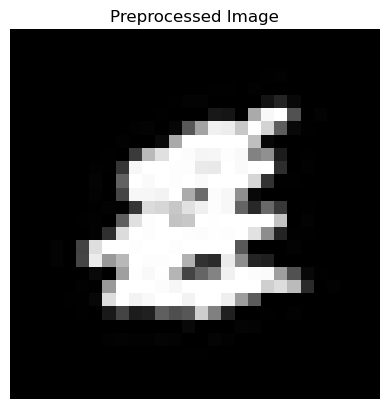

Prediction: E, Confidence: 0.9956
Top 3 predictions:
  1. E: 0.9956
  2. 8: 0.0037
  3. 5: 0.0005
Moved char_49.png to E_f8f31623-9b03-464a-93a2-6e1ced4b1099.png
Processing 136/190: char_5.png


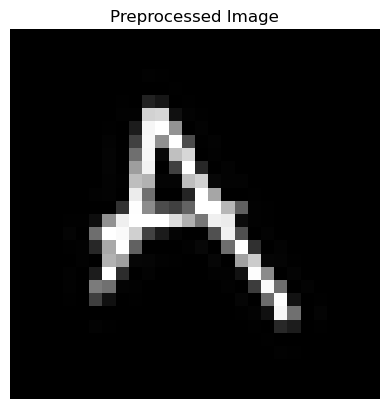

Prediction: A, Confidence: 1.0000
Top 3 predictions:
  1. A: 1.0000
  2. M: 0.0000
  3. R: 0.0000
Moved char_5.png to A_7f583156-3870-429d-a81b-743c5bf58a34.png
Processing 137/190: char_50.png


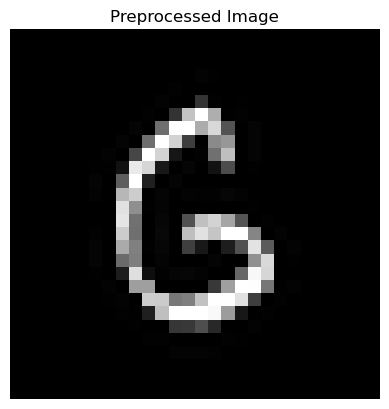

Prediction: G, Confidence: 0.9953
Top 3 predictions:
  1. G: 0.9953
  2. 6: 0.0047
  3. C: 0.0000
Moved char_50.png to G_22777851-c98e-44d8-82f9-eeea4383ddfa.png
Processing 138/190: char_51.png


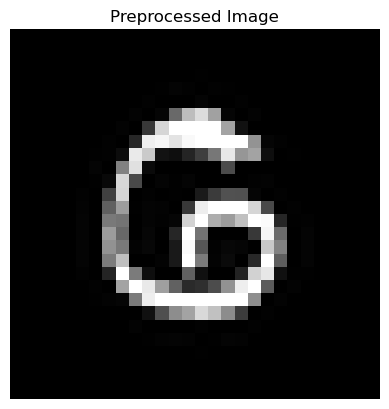

Prediction: G, Confidence: 0.6933
Top 3 predictions:
  1. G: 0.6933
  2. 6: 0.3065
  3. 0: 0.0001
Moved char_51.png to G_5e082fb2-0bb6-417c-912e-c4be32e8c145.png
Processing 139/190: char_52.png


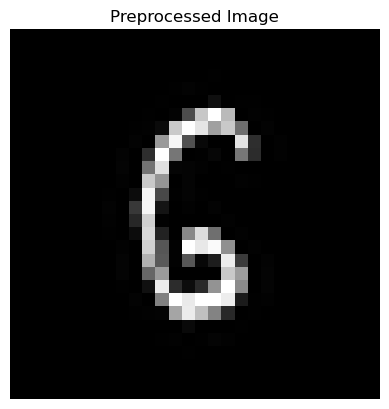

Prediction: 6, Confidence: 0.9832
Top 3 predictions:
  1. 6: 0.9832
  2. G: 0.0121
  3. 5: 0.0034
Moved char_52.png to 6_b5978689-c78d-45db-aa0d-ee9873944d11.png
Processing 140/190: char_53.png


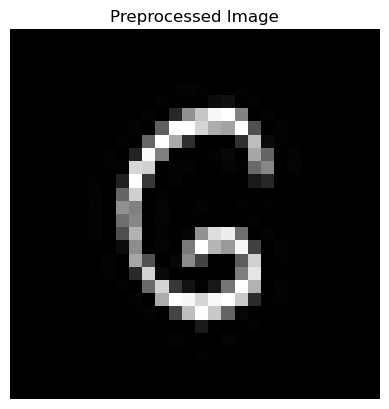

Prediction: G, Confidence: 0.9919
Top 3 predictions:
  1. G: 0.9919
  2. 6: 0.0081
  3. C: 0.0000
Moved char_53.png to G_6f74ca72-b81f-495f-b817-87f44d5aa14b.png
Processing 141/190: char_54.png


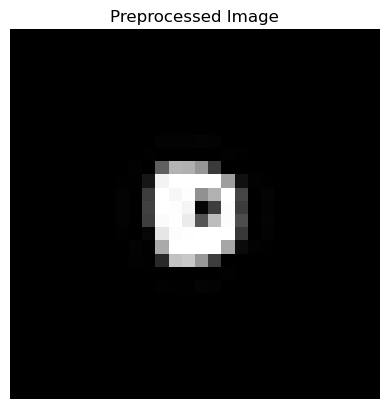

Prediction: 0, Confidence: 0.6239
Top 3 predictions:
  1. 0: 0.6239
  2. O: 0.2657
  3. P: 0.0431
Moved char_54.png to 0_e98a1cc2-1dff-4c0c-8b1d-d1b9abaa6199.png
Processing 142/190: char_55.png


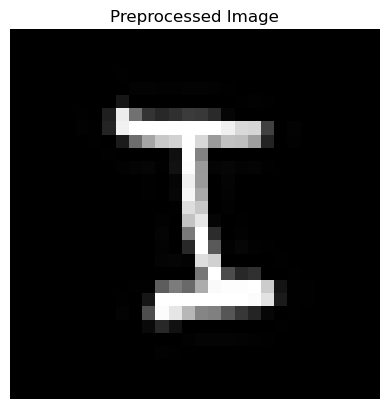

Prediction: I, Confidence: 0.5088
Top 3 predictions:
  1. I: 0.5088
  2. 1: 0.2437
  3. J: 0.2379
Created directory: testing_data/data/I
Moved char_55.png to I_a77173d9-73ef-4427-aaaa-695dad20928f.png
Processing 143/190: char_56.png


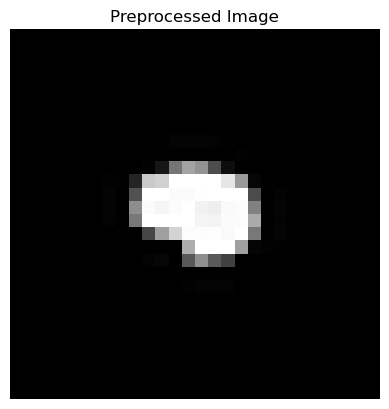

Prediction: 0, Confidence: 0.3850
Top 3 predictions:
  1. 0: 0.3850
  2. 9: 0.2121
  3. 2: 0.1719
Moved char_56.png to 0_e78d9ae0-f40a-457f-8d0f-1b6c299c97be.png
Processing 144/190: char_57.png


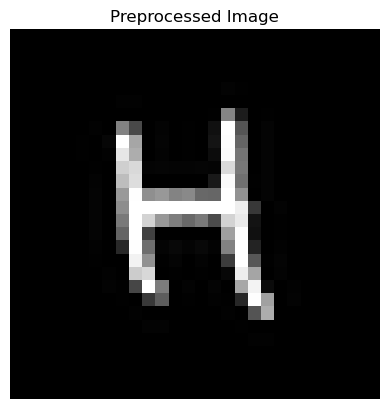

Prediction: H, Confidence: 0.9999
Top 3 predictions:
  1. H: 0.9999
  2. W: 0.0000
  3. N: 0.0000
Moved char_57.png to H_e31613d7-3816-426a-a417-f845a9d36c86.png
Processing 145/190: char_58.png


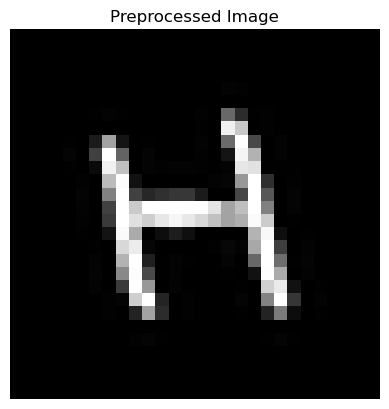

Prediction: H, Confidence: 1.0000
Top 3 predictions:
  1. H: 1.0000
  2. W: 0.0000
  3. 4: 0.0000
Moved char_58.png to H_ba84f923-686b-4801-9841-aa7dc1b8cce9.png
Processing 146/190: char_59.png


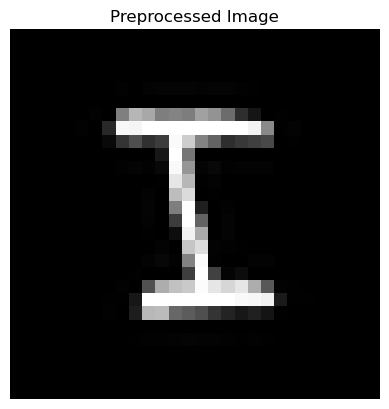

Prediction: I, Confidence: 0.9753
Top 3 predictions:
  1. I: 0.9753
  2. J: 0.0205
  3. T: 0.0021
Moved char_59.png to I_e67f50a0-012b-4a14-9f95-5ec1a7f4e383.png
Processing 147/190: char_6.png


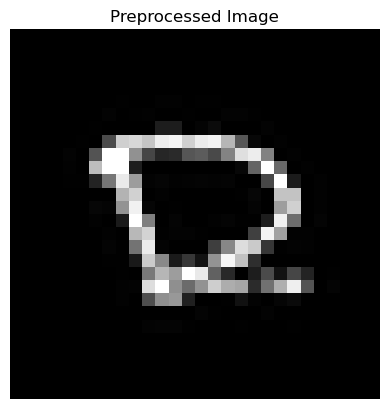

Prediction: D, Confidence: 0.2826
Top 3 predictions:
  1. D: 0.2826
  2. Q: 0.1818
  3. 2: 0.1621
Skipping char_6.png - confidence 0.2826 below threshold 0.3
Processing 148/190: char_60.png


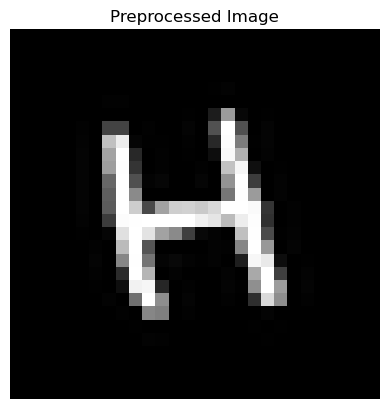

Prediction: H, Confidence: 1.0000
Top 3 predictions:
  1. H: 1.0000
  2. W: 0.0000
  3. N: 0.0000
Moved char_60.png to H_54775a23-4e8b-4872-8c34-b551df0e2cbd.png
Processing 149/190: char_61.png


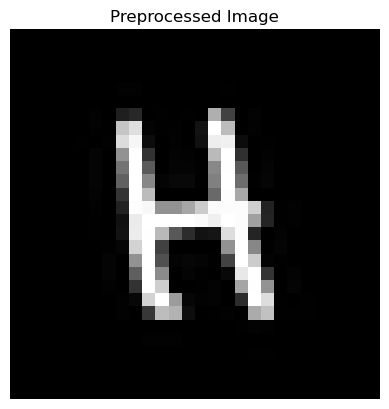

Prediction: H, Confidence: 1.0000
Top 3 predictions:
  1. H: 1.0000
  2. W: 0.0000
  3. 4: 0.0000
Moved char_61.png to H_57d1666d-af58-47a8-b9a6-37f524c23cb6.png
Processing 150/190: char_62.png


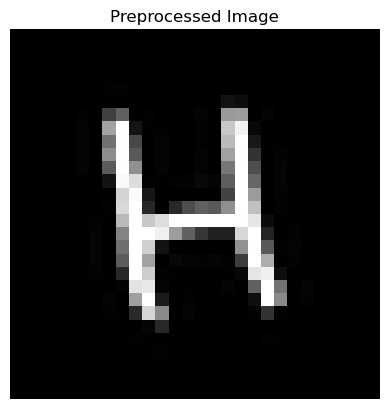

Prediction: H, Confidence: 1.0000
Top 3 predictions:
  1. H: 1.0000
  2. W: 0.0000
  3. 4: 0.0000
Moved char_62.png to H_5986e05e-32a7-454c-9f3d-020e8a90ccdd.png
Processing 151/190: char_63.png


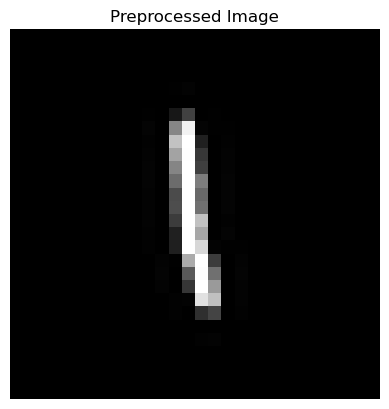

Prediction: 1, Confidence: 0.9989
Top 3 predictions:
  1. 1: 0.9989
  2. T: 0.0005
  3. C: 0.0001
Moved char_63.png to 1_ac8346bd-5d84-48d3-8f0b-8ddd9eacd074.png
Processing 152/190: char_64.png


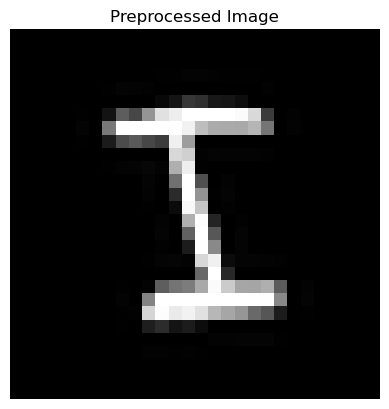

Prediction: I, Confidence: 0.8957
Top 3 predictions:
  1. I: 0.8957
  2. J: 0.0979
  3. T: 0.0042
Moved char_64.png to I_c410efd3-b229-425c-86c8-5dddfb219b70.png
Processing 153/190: char_65.png


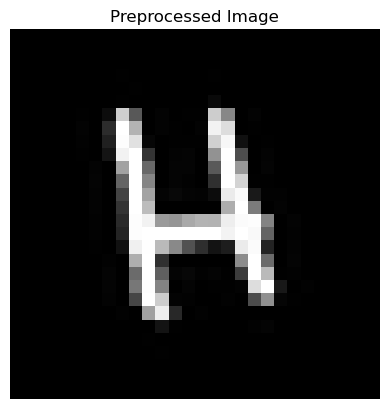

Prediction: H, Confidence: 1.0000
Top 3 predictions:
  1. H: 1.0000
  2. W: 0.0000
  3. 4: 0.0000
Moved char_65.png to H_a160de8c-ee0e-42fb-bf62-94bbe4b1bb1e.png
Processing 154/190: char_66.png


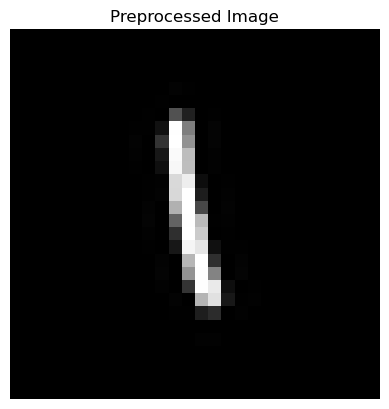

Prediction: 1, Confidence: 0.9996
Top 3 predictions:
  1. 1: 0.9996
  2. T: 0.0002
  3. C: 0.0000
Moved char_66.png to 1_0b6129ea-de36-4729-a806-12ab6c2400c7.png
Processing 155/190: char_67.png


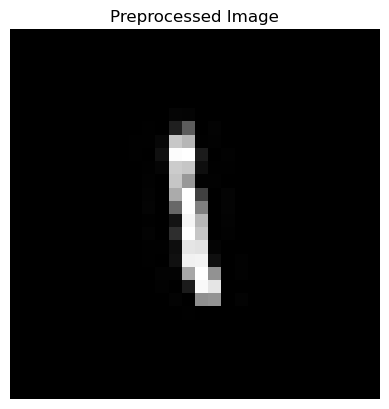

Prediction: 1, Confidence: 0.9977
Top 3 predictions:
  1. 1: 0.9977
  2. T: 0.0009
  3. J: 0.0004
Moved char_67.png to 1_d660f54d-db7d-4131-907e-83b44b2df430.png
Processing 156/190: char_68.png


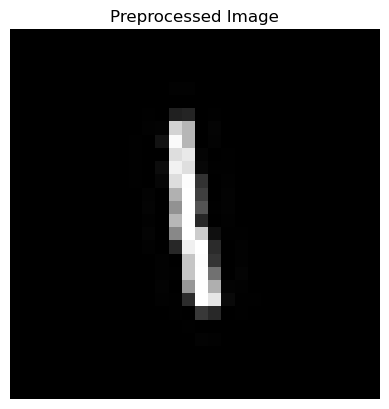

Prediction: 1, Confidence: 0.9996
Top 3 predictions:
  1. 1: 0.9996
  2. T: 0.0002
  3. C: 0.0001
Moved char_68.png to 1_59ad3ccd-276c-4b54-8478-3878516d79c5.png
Processing 157/190: char_69.png


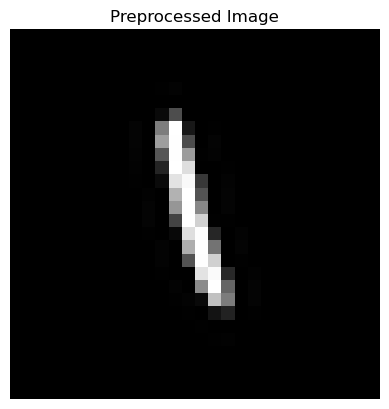

Prediction: 1, Confidence: 0.9833
Top 3 predictions:
  1. 1: 0.9833
  2. T: 0.0055
  3. Y: 0.0034
Moved char_69.png to 1_e63bdab0-412c-4033-b14e-e5c2f6df0c55.png
Processing 158/190: char_7.png


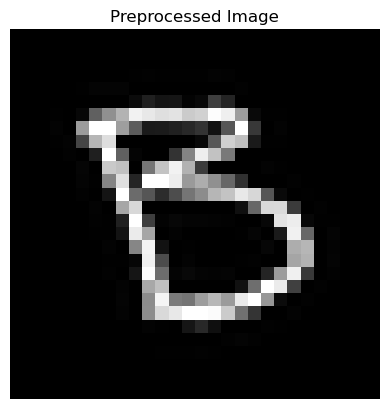

Prediction: B, Confidence: 1.0000
Top 3 predictions:
  1. B: 1.0000
  2. 8: 0.0000
  3. G: 0.0000
Moved char_7.png to B_bdb23209-fd84-4108-863f-410cb7eb5a7c.png
Processing 159/190: char_70.png


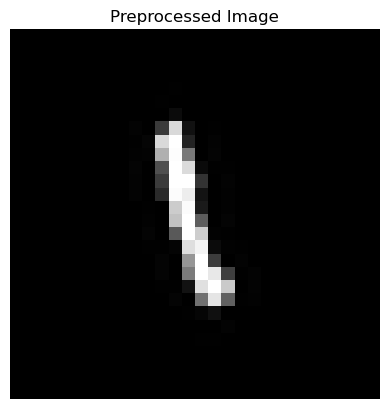

Prediction: 1, Confidence: 0.9866
Top 3 predictions:
  1. 1: 0.9866
  2. T: 0.0040
  3. L: 0.0018
Moved char_70.png to 1_f252a9f7-8da5-43f8-8d02-830bd618bff1.png
Processing 160/190: char_71.png


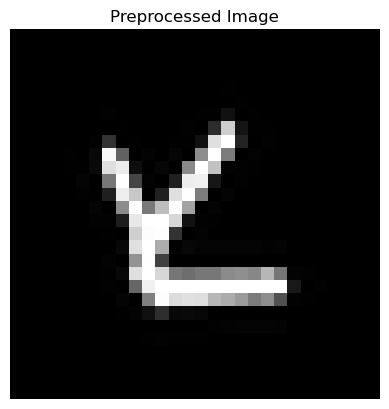

Prediction: X, Confidence: 0.4415
Top 3 predictions:
  1. X: 0.4415
  2. K: 0.4335
  3. L: 0.0330
Moved char_71.png to X_462b7de4-f04f-49ba-80ad-26ecc09f9eca.png
Processing 161/190: char_72.png


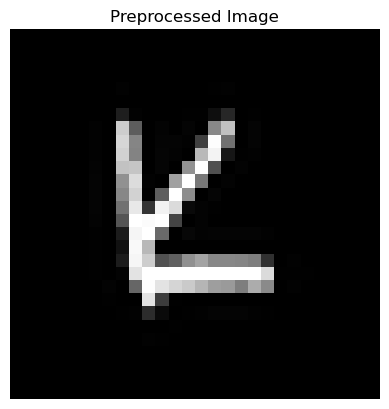

Prediction: K, Confidence: 0.9548
Top 3 predictions:
  1. K: 0.9548
  2. X: 0.0324
  3. L: 0.0050
Moved char_72.png to K_71321378-ef2a-4601-8e34-36b07e16120a.png
Processing 162/190: char_73.png


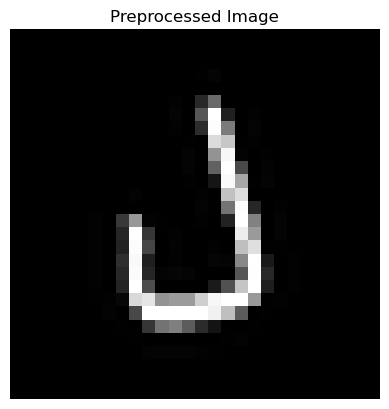

Prediction: J, Confidence: 0.9863
Top 3 predictions:
  1. J: 0.9863
  2. 5: 0.0132
  3. S: 0.0003
Moved char_73.png to J_42e42ae0-a432-4022-ba1d-8e786a1e7b8f.png
Processing 163/190: char_74.png


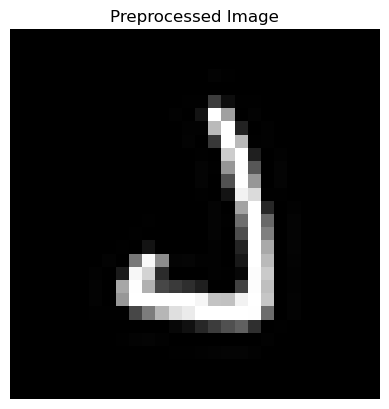

Prediction: J, Confidence: 1.0000
Top 3 predictions:
  1. J: 1.0000
  2. S: 0.0000
  3. U: 0.0000
Moved char_74.png to J_dd63a885-428c-4c79-9899-6cc9c1099bbd.png
Processing 164/190: char_75.png


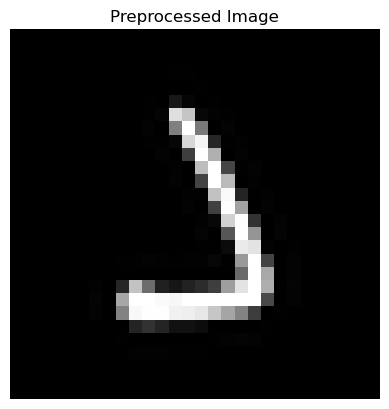

Prediction: J, Confidence: 0.9668
Top 3 predictions:
  1. J: 0.9668
  2. 1: 0.0261
  3. 3: 0.0030
Moved char_75.png to J_dc6563df-42fc-4588-ba7e-d7849a5c1f49.png
Processing 165/190: char_76.png


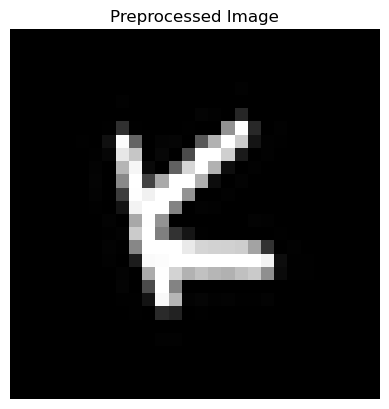

Prediction: K, Confidence: 0.9995
Top 3 predictions:
  1. K: 0.9995
  2. X: 0.0003
  3. E: 0.0000
Moved char_76.png to K_566ea423-2210-4f58-a499-66f56c037365.png
Processing 166/190: char_77.png


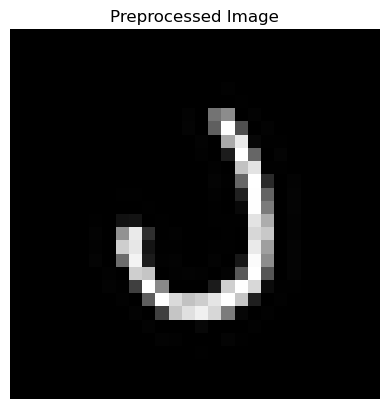

Prediction: J, Confidence: 0.9952
Top 3 predictions:
  1. J: 0.9952
  2. 5: 0.0041
  3. S: 0.0003
Moved char_77.png to J_557f8ad7-dfc8-48b8-8d7f-5a5c43885c16.png
Processing 167/190: char_78.png


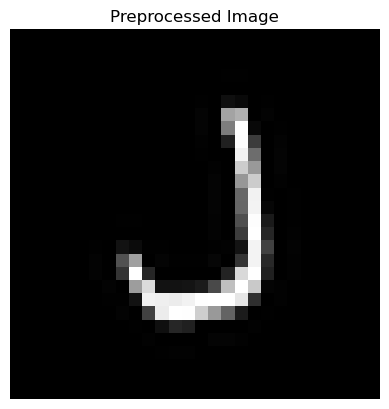

Prediction: J, Confidence: 0.9906
Top 3 predictions:
  1. J: 0.9906
  2. 5: 0.0092
  3. 3: 0.0001
Moved char_78.png to J_de072729-0040-4b57-9be6-97054447e19c.png
Processing 168/190: char_79.png


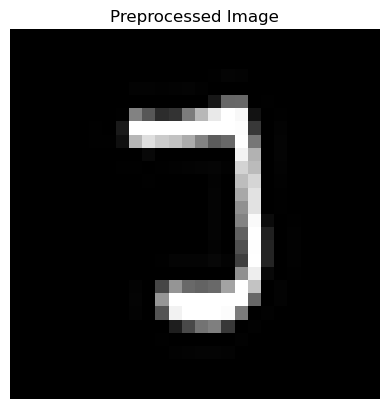

Prediction: J, Confidence: 0.9751
Top 3 predictions:
  1. J: 0.9751
  2. 3: 0.0179
  3. 7: 0.0019
Moved char_79.png to J_63742ea6-e93a-463d-89e5-cba56a76cedd.png
Processing 169/190: char_8.png


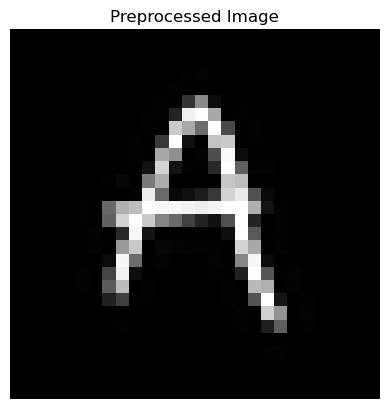

Prediction: A, Confidence: 1.0000
Top 3 predictions:
  1. A: 1.0000
  2. H: 0.0000
  3. M: 0.0000
Moved char_8.png to A_b1b4410c-d052-42ab-96fa-1c99a06bace4.png
Processing 170/190: char_80.png


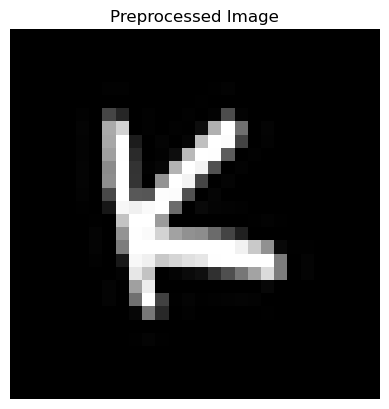

Prediction: K, Confidence: 0.9997
Top 3 predictions:
  1. K: 0.9997
  2. X: 0.0002
  3. L: 0.0000
Moved char_80.png to K_7f49ed2e-43a0-4e20-a18d-5eafa5e08eb4.png
Processing 171/190: char_81.png


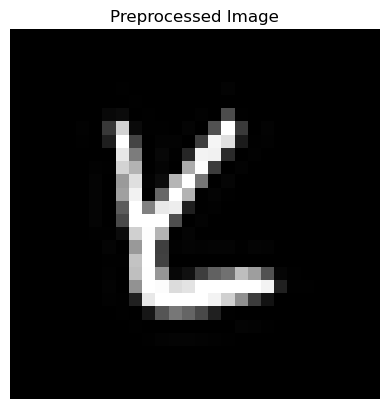

Prediction: K, Confidence: 0.7920
Top 3 predictions:
  1. K: 0.7920
  2. X: 0.1485
  3. E: 0.0276
Moved char_81.png to K_1d3272ce-a36c-4efd-b2e8-ee4d1eeca728.png
Processing 172/190: char_82.png


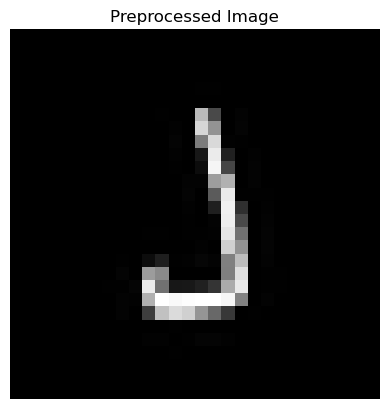

Prediction: J, Confidence: 0.9999
Top 3 predictions:
  1. J: 0.9999
  2. S: 0.0001
  3. T: 0.0000
Moved char_82.png to J_fc9555b6-a8d3-420d-8b60-8a41923cd2ce.png
Processing 173/190: char_83.png


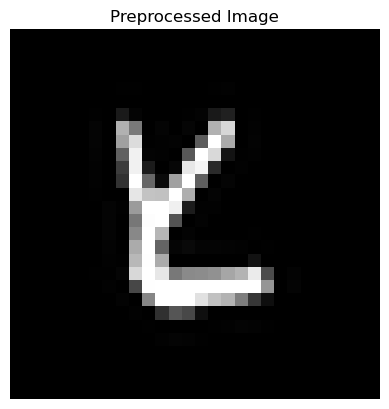

Prediction: K, Confidence: 0.6543
Top 3 predictions:
  1. K: 0.6543
  2. X: 0.2990
  3. L: 0.0126
Moved char_83.png to K_e15b7fa0-fd8b-4f63-9a60-6d75b6aeb9bd.png
Processing 174/190: char_84.png


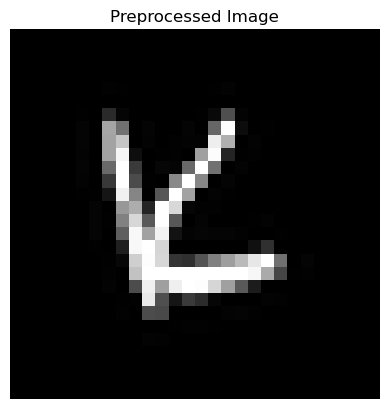

Prediction: K, Confidence: 0.9243
Top 3 predictions:
  1. K: 0.9243
  2. X: 0.0662
  3. E: 0.0030
Moved char_84.png to K_fadf10d7-8069-4f59-814e-b88e90badb25.png
Processing 175/190: char_85.png


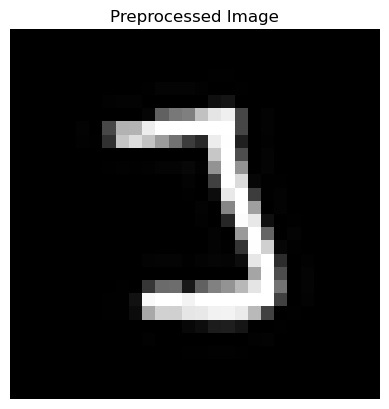

Prediction: 3, Confidence: 0.6557
Top 3 predictions:
  1. 3: 0.6557
  2. 1: 0.1845
  3. J: 0.0952
Moved char_85.png to 3_19e7d9c7-6617-48fa-b4a3-6fd0d10d28eb.png
Processing 176/190: char_86.png


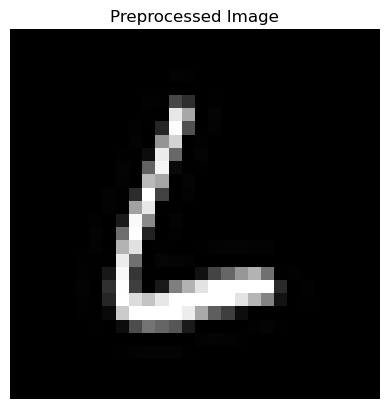

Prediction: L, Confidence: 0.9997
Top 3 predictions:
  1. L: 0.9997
  2. C: 0.0003
  3. U: 0.0000
Moved char_86.png to L_b71c25fd-5f28-4c2e-b4d7-ccaed4cfb475.png
Processing 177/190: char_87.png


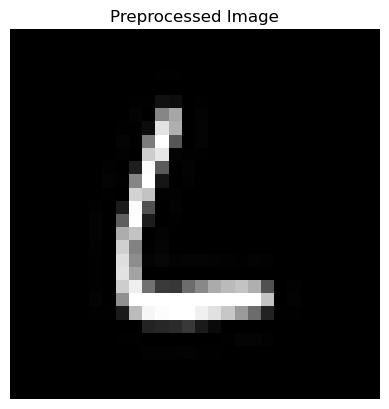

Prediction: L, Confidence: 0.9962
Top 3 predictions:
  1. L: 0.9962
  2. C: 0.0038
  3. G: 0.0000
Moved char_87.png to L_09341f20-574f-4c21-9815-b4cfdae5b8b5.png
Processing 178/190: char_88.png


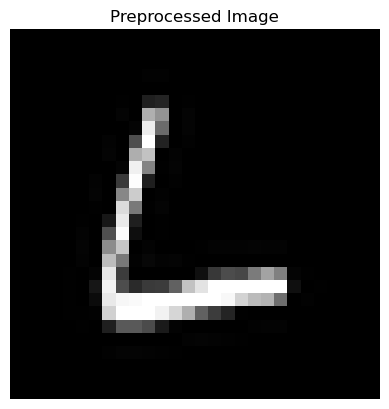

Prediction: L, Confidence: 1.0000
Top 3 predictions:
  1. L: 1.0000
  2. C: 0.0000
  3. U: 0.0000
Moved char_88.png to L_71b0c32c-6376-48c8-9687-4177ef39403b.png
Processing 179/190: char_89.png


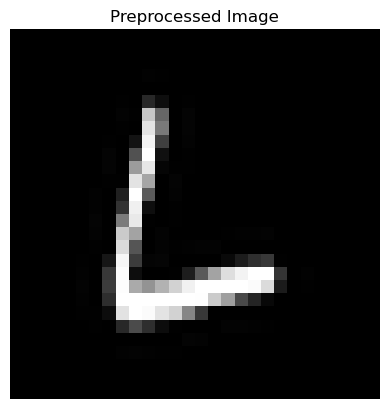

Prediction: L, Confidence: 1.0000
Top 3 predictions:
  1. L: 1.0000
  2. C: 0.0000
  3. U: 0.0000
Moved char_89.png to L_23c45393-bc0d-4844-b4c9-07626a0b349f.png
Processing 180/190: char_9.png


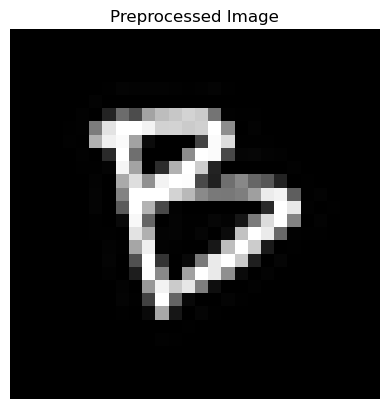

Prediction: B, Confidence: 0.9999
Top 3 predictions:
  1. B: 0.9999
  2. P: 0.0001
  3. D: 0.0000
Moved char_9.png to B_f9083edd-31d1-46ae-a44c-c7baff8e3335.png
Processing 181/190: char_90.png


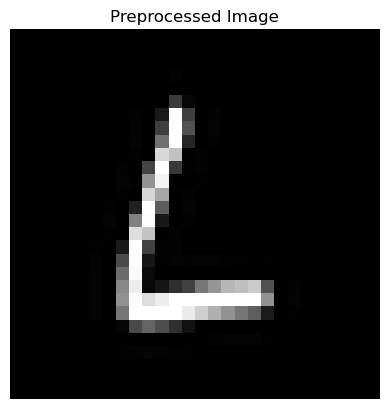

Prediction: L, Confidence: 1.0000
Top 3 predictions:
  1. L: 1.0000
  2. C: 0.0000
  3. U: 0.0000
Moved char_90.png to L_a172aad9-9594-44e7-816d-6c5477e37ef4.png
Processing 182/190: char_91.png


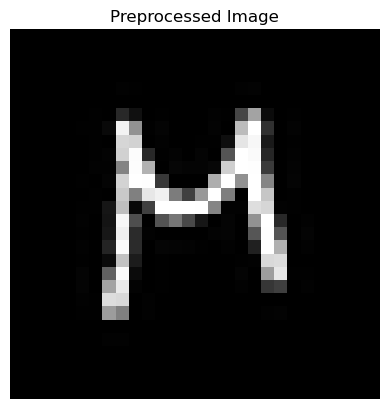

Prediction: M, Confidence: 1.0000
Top 3 predictions:
  1. M: 1.0000
  2. N: 0.0000
  3. H: 0.0000
Moved char_91.png to M_833b53e7-353f-4fbd-8f1e-fbbfdf63179a.png
Processing 183/190: char_92.png


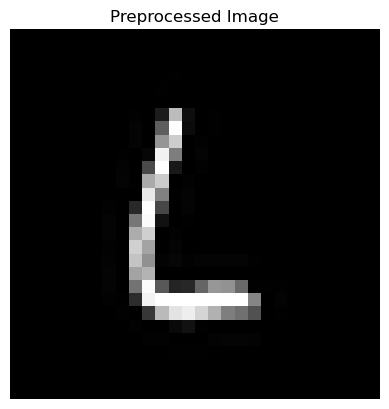

Prediction: L, Confidence: 0.9918
Top 3 predictions:
  1. L: 0.9918
  2. C: 0.0081
  3. G: 0.0000
Moved char_92.png to L_551d9054-6a9d-4cdd-bffd-854231a3a011.png
Processing 184/190: char_93.png


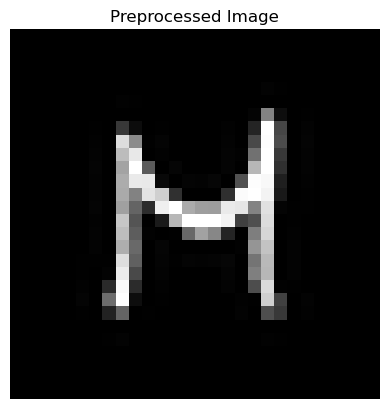

Prediction: M, Confidence: 1.0000
Top 3 predictions:
  1. M: 1.0000
  2. H: 0.0000
  3. N: 0.0000
Moved char_93.png to M_2a086c63-dfff-478d-9329-3cce503ed16f.png
Processing 185/190: char_94.png


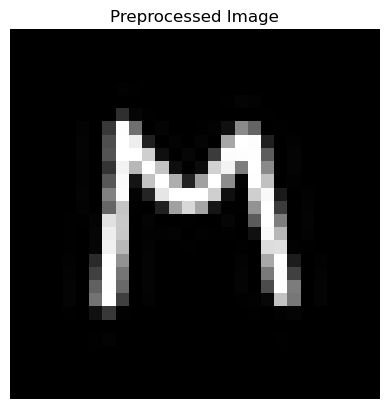

Prediction: M, Confidence: 1.0000
Top 3 predictions:
  1. M: 1.0000
  2. N: 0.0000
  3. H: 0.0000
Moved char_94.png to M_93e58951-a970-4188-baae-c38ffc1e14c9.png
Processing 186/190: char_95.png


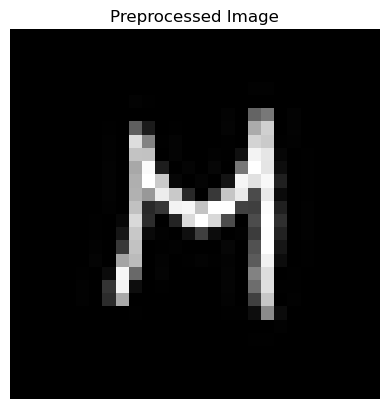

Prediction: M, Confidence: 0.9997
Top 3 predictions:
  1. M: 0.9997
  2. N: 0.0002
  3. H: 0.0001
Moved char_95.png to M_41ff2103-bdc7-4ee7-ac91-16ca4b76d024.png
Processing 187/190: char_96.png


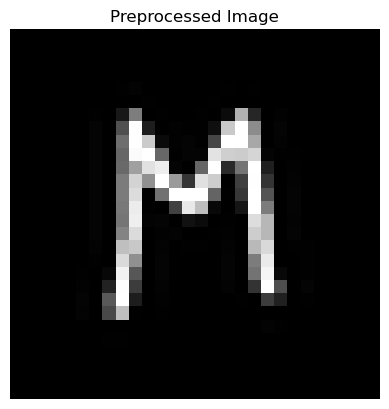

Prediction: M, Confidence: 1.0000
Top 3 predictions:
  1. M: 1.0000
  2. N: 0.0000
  3. H: 0.0000
Moved char_96.png to M_b9044866-2f52-4b6f-ac32-1597b0ccba2a.png
Processing 188/190: char_97.png


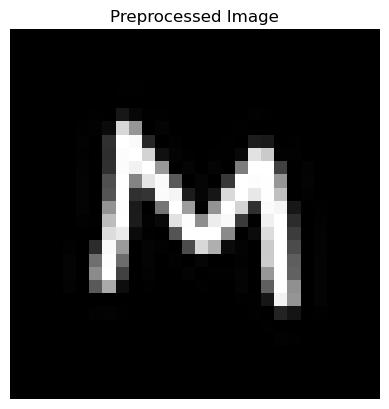

Prediction: M, Confidence: 1.0000
Top 3 predictions:
  1. M: 1.0000
  2. N: 0.0000
  3. U: 0.0000
Moved char_97.png to M_0229bc6a-aa02-4a06-b8c7-e9d931ab3157.png
Processing 189/190: char_98.png


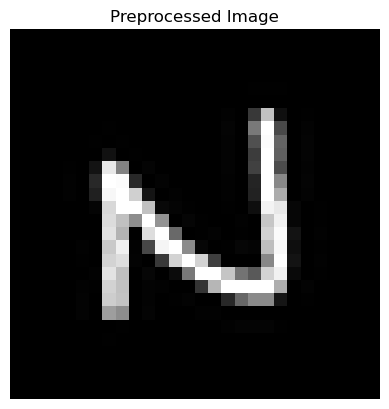

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. H: 0.0000
Moved char_98.png to N_0998baf5-47a7-480e-9b1c-3fb1d96ed3f2.png
Processing 190/190: char_99.png


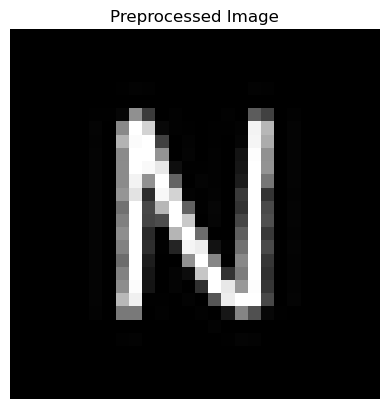

Prediction: N, Confidence: 1.0000
Top 3 predictions:
  1. N: 1.0000
  2. W: 0.0000
  3. H: 0.0000
Moved char_99.png to N_42eab02a-e80f-487f-adf2-88abae41fcc2.png
Found 102 image files in 'testing_data/digits'
Processing 1/102: char_0.png


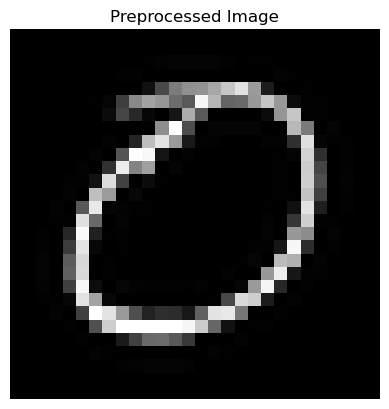

Prediction: 0, Confidence: 0.9990
Top 3 predictions:
  1. 0: 0.9990
  2. O: 0.0010
  3. 6: 0.0000
Moved char_0.png to 0_20ec4b61-1392-4a6c-8b43-4b3140248ed8.png
Processing 2/102: char_1.png


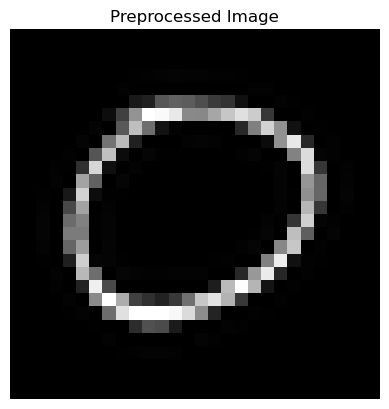

Prediction: 0, Confidence: 0.9958
Top 3 predictions:
  1. 0: 0.9958
  2. O: 0.0042
  3. 8: 0.0000
Moved char_1.png to 0_cce3f805-760c-4b5a-8cd7-cd2a9c78be96.png
Processing 3/102: char_10.png


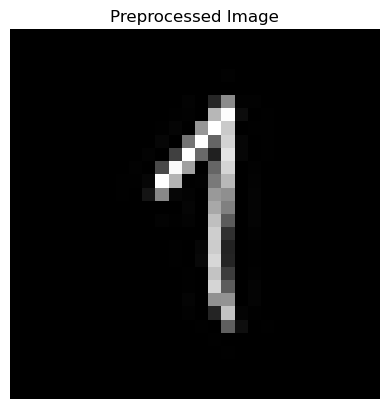

Prediction: 1, Confidence: 0.9954
Top 3 predictions:
  1. 1: 0.9954
  2. 7: 0.0022
  3. T: 0.0015
Moved char_10.png to 1_4ec4ffb3-4620-4cd3-8564-8356d504518d.png
Processing 4/102: char_100.png


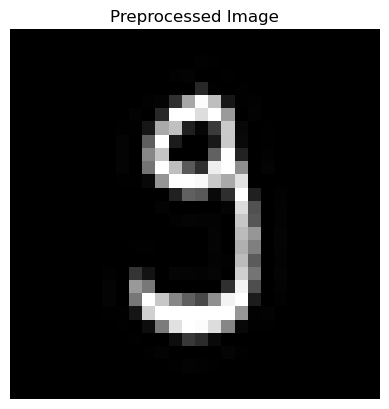

Prediction: 9, Confidence: 0.9900
Top 3 predictions:
  1. 9: 0.9900
  2. 3: 0.0059
  3. S: 0.0024
Moved char_100.png to 9_70dc0cf0-521f-45ba-80ad-220f853e96d3.png
Processing 5/102: char_101.png


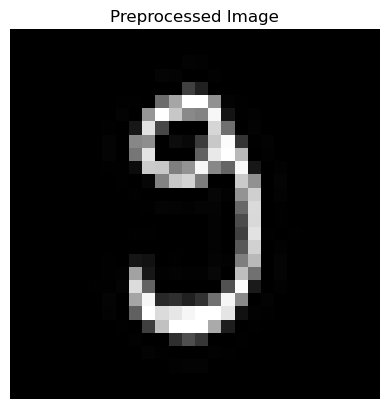

Prediction: 9, Confidence: 0.9531
Top 3 predictions:
  1. 9: 0.9531
  2. S: 0.0370
  3. 3: 0.0049
Moved char_101.png to 9_ec7de7ea-5b8d-45f4-8510-35f8e55d53be.png
Processing 6/102: char_103.png


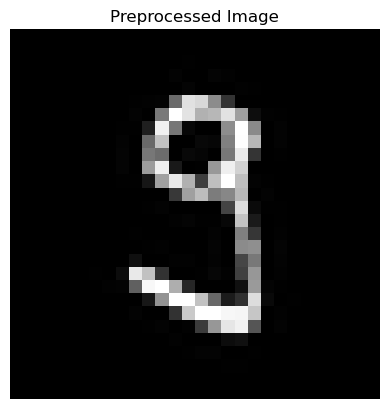

Prediction: 9, Confidence: 0.9871
Top 3 predictions:
  1. 9: 0.9871
  2. 3: 0.0073
  3. S: 0.0035
Moved char_103.png to 9_9a60aafc-e17f-49e6-9eae-5cbe6d91a5d3.png
Processing 7/102: char_11.png


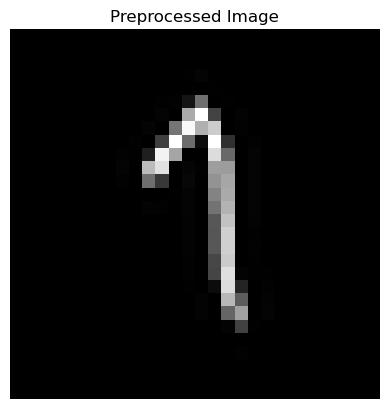

Prediction: 1, Confidence: 0.7186
Top 3 predictions:
  1. 1: 0.7186
  2. T: 0.1709
  3. 7: 0.0502
Moved char_11.png to 1_e129663a-daf6-4562-a22f-d2eb1049f344.png
Processing 8/102: char_12.png


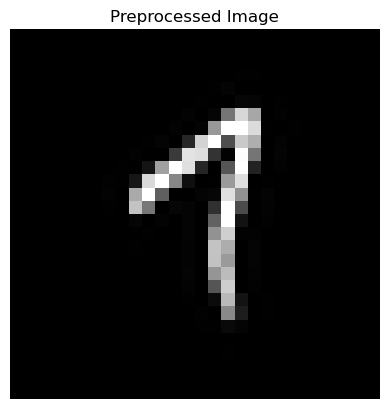

Prediction: 1, Confidence: 0.7960
Top 3 predictions:
  1. 1: 0.7960
  2. T: 0.0867
  3. 7: 0.0796
Moved char_12.png to 1_772fabd8-3964-4ea9-935c-8efe2763a8d4.png
Processing 9/102: char_13.png


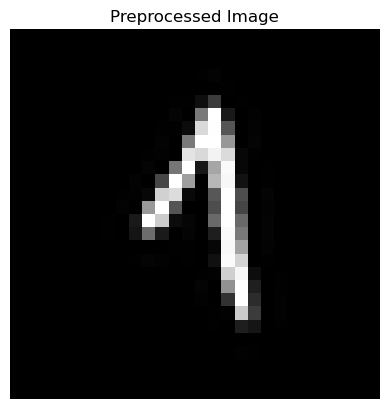

Prediction: 1, Confidence: 0.9430
Top 3 predictions:
  1. 1: 0.9430
  2. 7: 0.0189
  3. T: 0.0134
Moved char_13.png to 1_5fe50109-0121-4115-97de-b23157ba5522.png
Processing 10/102: char_14.png


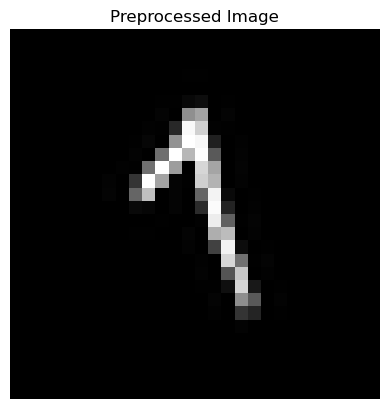

Prediction: 1, Confidence: 0.9154
Top 3 predictions:
  1. 1: 0.9154
  2. T: 0.0335
  3. 7: 0.0199
Moved char_14.png to 1_3d2b61dd-f64e-474a-8c67-b05016d328aa.png
Processing 11/102: char_15.png


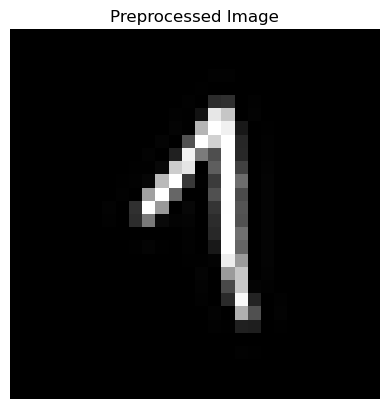

Prediction: 1, Confidence: 0.9609
Top 3 predictions:
  1. 1: 0.9609
  2. 7: 0.0193
  3. T: 0.0094
Moved char_15.png to 1_15400a3d-cdd7-4db0-a869-28c3569f9b59.png
Processing 12/102: char_16.png


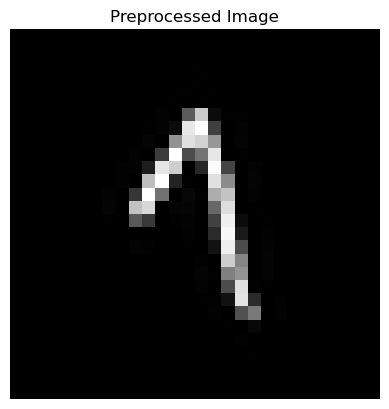

Prediction: 1, Confidence: 0.5269
Top 3 predictions:
  1. 1: 0.5269
  2. T: 0.1922
  3. M: 0.0646
Moved char_16.png to 1_f179fc7f-012e-4c04-9722-12018ed6cf8a.png
Processing 13/102: char_17.png


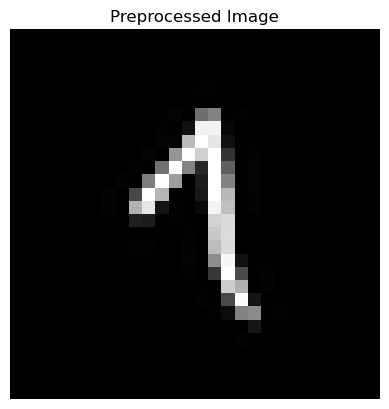

Prediction: 1, Confidence: 0.9164
Top 3 predictions:
  1. 1: 0.9164
  2. T: 0.0398
  3. 7: 0.0151
Moved char_17.png to 1_d1759d15-484f-472b-9467-d7fd3280bdff.png
Processing 14/102: char_18.png


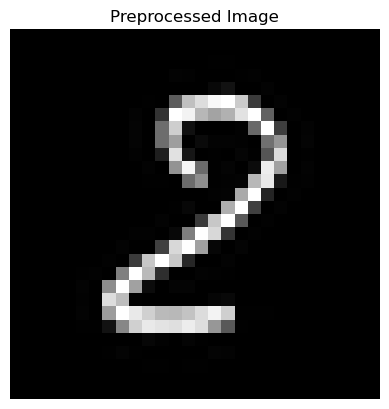

Prediction: 2, Confidence: 0.8717
Top 3 predictions:
  1. 2: 0.8717
  2. 8: 0.1221
  3. Z: 0.0053
Moved char_18.png to 2_575270d3-1b68-49a8-a54e-0a98764ff5f2.png
Processing 15/102: char_19.png


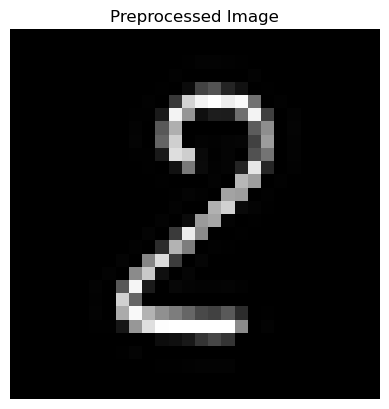

Prediction: 2, Confidence: 0.9978
Top 3 predictions:
  1. 2: 0.9978
  2. Z: 0.0016
  3. 8: 0.0006
Moved char_19.png to 2_e833fccd-3633-4cb0-abff-84c12d9d5b3c.png
Processing 16/102: char_2.png


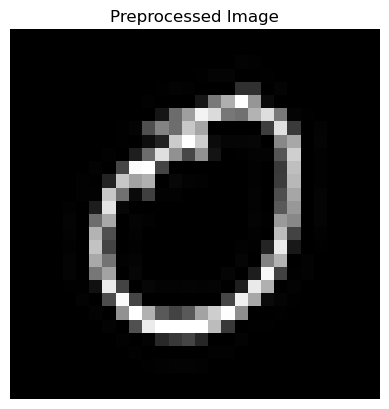

Prediction: 0, Confidence: 0.9998
Top 3 predictions:
  1. 0: 0.9998
  2. O: 0.0002
  3. 8: 0.0000
Moved char_2.png to 0_bfaec5ea-30b2-4776-aedb-18d2b6bf8b18.png
Processing 17/102: char_20.png


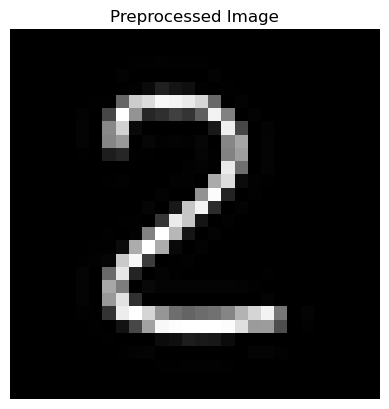

Prediction: 2, Confidence: 0.8968
Top 3 predictions:
  1. 2: 0.8968
  2. Z: 0.1031
  3. R: 0.0001
Moved char_20.png to 2_72e2e99f-00c2-4090-bf8b-fb2947097ab8.png
Processing 18/102: char_21.png


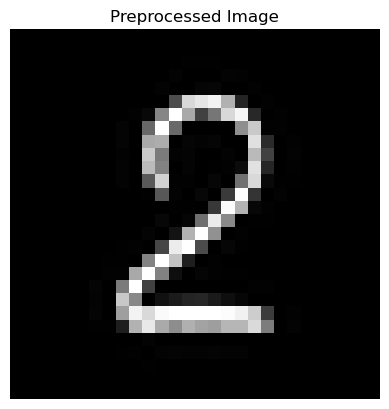

Prediction: 2, Confidence: 0.9993
Top 3 predictions:
  1. 2: 0.9993
  2. Z: 0.0006
  3. 8: 0.0000
Moved char_21.png to 2_fe4b54f4-1cef-4b19-b74c-31d880d6c54d.png
Processing 19/102: char_22.png


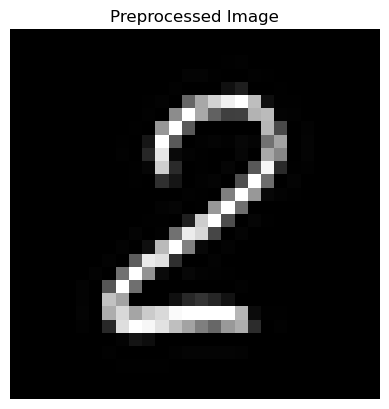

Prediction: 2, Confidence: 0.9991
Top 3 predictions:
  1. 2: 0.9991
  2. Z: 0.0008
  3. 8: 0.0001
Moved char_22.png to 2_6e3992da-2637-475c-9515-39e6d2dab104.png
Processing 20/102: char_23.png


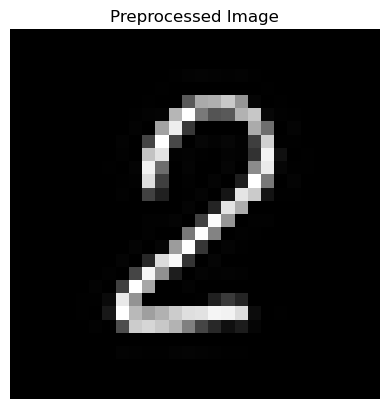

Prediction: 2, Confidence: 0.9999
Top 3 predictions:
  1. 2: 0.9999
  2. Z: 0.0001
  3. 8: 0.0000
Moved char_23.png to 2_4adbde46-96ef-41e6-b177-0f59d205ce04.png
Processing 21/102: char_24.png


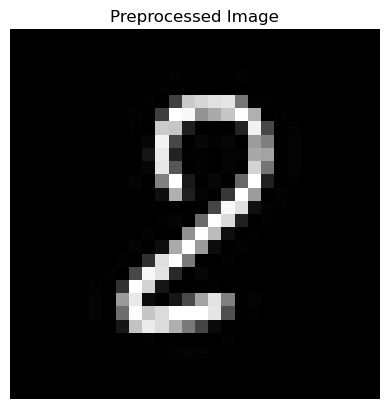

Prediction: 2, Confidence: 0.9726
Top 3 predictions:
  1. 2: 0.9726
  2. 8: 0.0273
  3. Z: 0.0000
Moved char_24.png to 2_b24221ac-8748-4564-8d9c-2b15bdc4bb1a.png
Processing 22/102: char_25.png


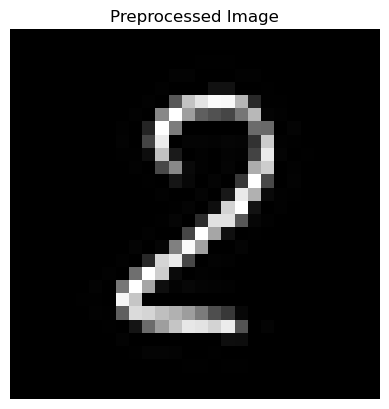

Prediction: 2, Confidence: 0.9991
Top 3 predictions:
  1. 2: 0.9991
  2. Z: 0.0009
  3. 8: 0.0000
Moved char_25.png to 2_f8d0a68f-a393-468d-a816-a83908c14a6a.png
Processing 23/102: char_26.png


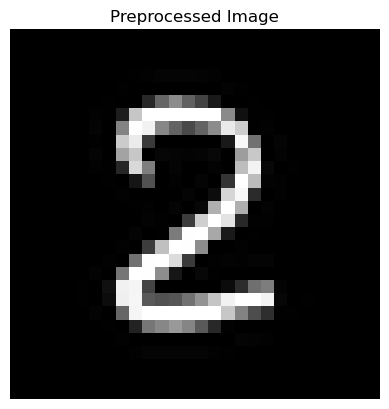

Prediction: 2, Confidence: 0.9999
Top 3 predictions:
  1. 2: 0.9999
  2. Z: 0.0001
  3. 3: 0.0000
Moved char_26.png to 2_f8583938-a832-4a85-9169-c522d8ff54b5.png
Processing 24/102: char_27.png


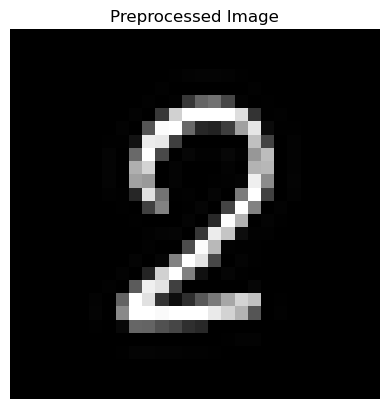

Prediction: 2, Confidence: 0.9983
Top 3 predictions:
  1. 2: 0.9983
  2. Z: 0.0016
  3. 8: 0.0001
Moved char_27.png to 2_7bee26bf-7ace-478f-8a69-c87b8bbeb441.png
Processing 25/102: char_28.png


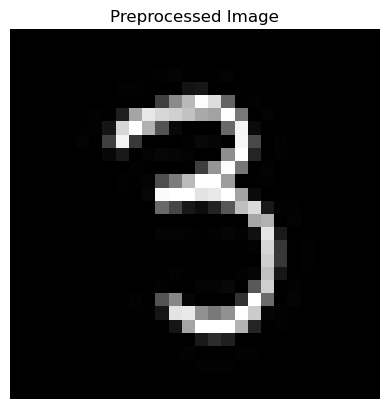

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_28.png to 3_f74331fa-6936-45ac-a02e-881eca9aeb05.png
Processing 26/102: char_29.png


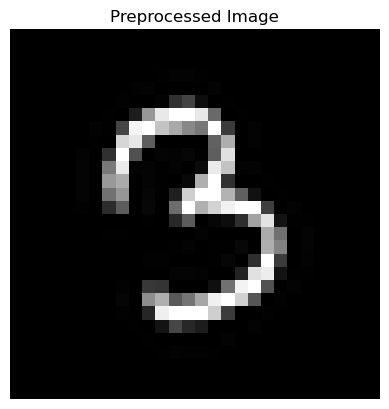

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_29.png to 3_9657f34f-f1a1-4b09-b932-63f505cc8105.png
Processing 27/102: char_3.png


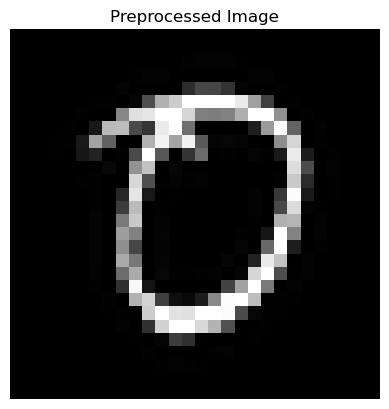

Prediction: 0, Confidence: 0.9987
Top 3 predictions:
  1. 0: 0.9987
  2. O: 0.0013
  3. 8: 0.0000
Moved char_3.png to 0_5de0a631-1806-4306-951d-4a1d19f27d8a.png
Processing 28/102: char_30.png


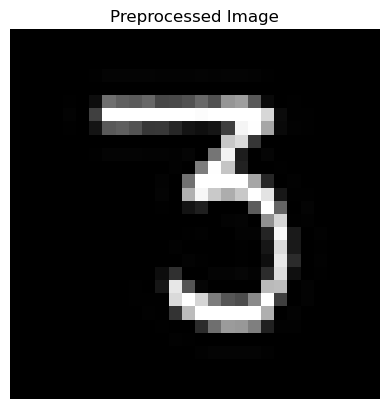

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. B: 0.0000
  3. Z: 0.0000
Moved char_30.png to 3_3f7766ab-d105-43bf-aee3-6ae80052ec24.png
Processing 29/102: char_31.png


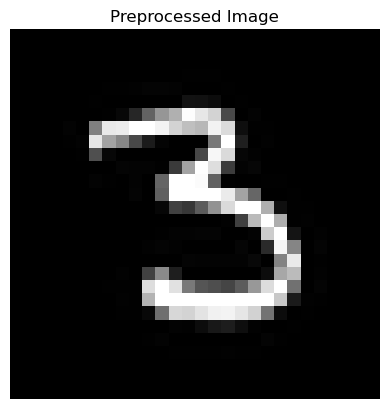

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. B: 0.0000
  3. S: 0.0000
Moved char_31.png to 3_1472f963-9683-42b7-97c6-f41e38aa7842.png
Processing 30/102: char_32.png


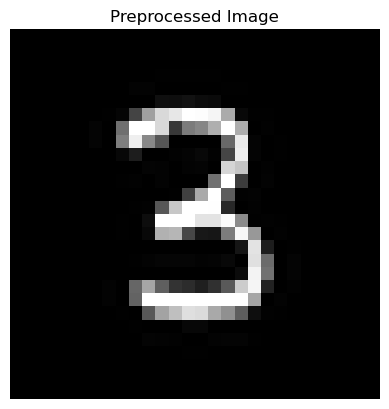

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. 5: 0.0000
  3. B: 0.0000
Moved char_32.png to 3_bf5dcc26-aaa6-490b-8df6-ae8e90ea3c5f.png
Processing 31/102: char_33.png


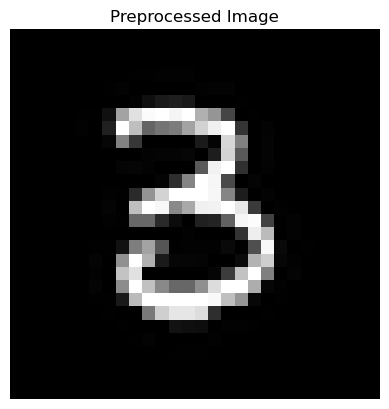

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_33.png to 3_06644f0e-2bae-443e-8196-4e6193ebfe87.png
Processing 32/102: char_34.png


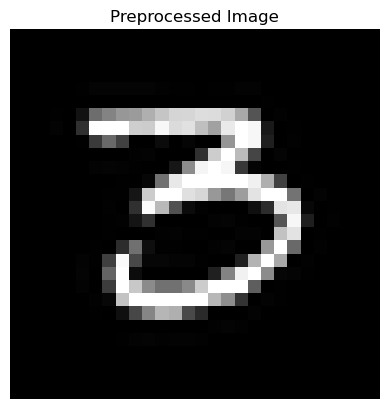

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_34.png to 3_7496f171-1bbf-4ade-9c51-2844b293b5e1.png
Processing 33/102: char_35.png


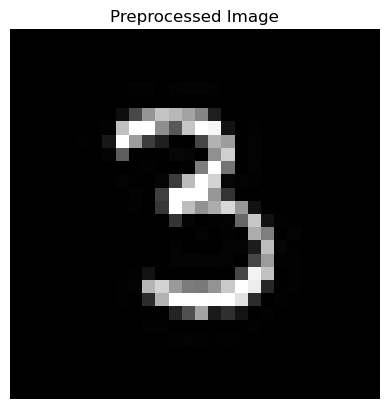

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_35.png to 3_34695415-cab8-4c1e-99f6-e341b05bbd0f.png
Processing 34/102: char_36.png


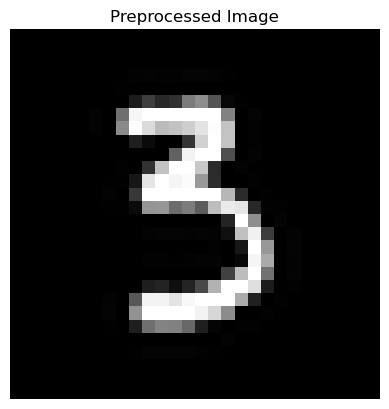

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_36.png to 3_6369dd36-6f70-4a0c-b679-45afcaf34efd.png
Processing 35/102: char_37.png


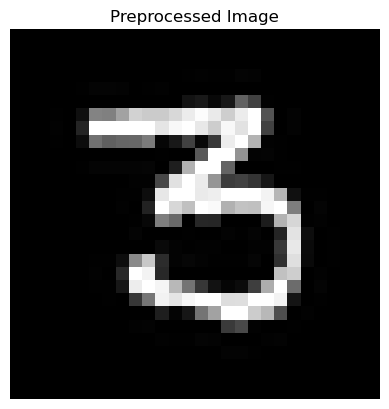

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_37.png to 3_0d0e74d0-56e5-468a-a979-28ef83a2368e.png
Processing 36/102: char_38.png


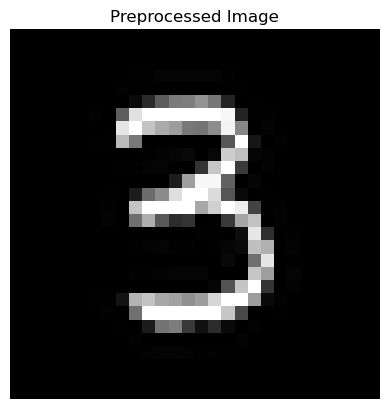

Prediction: 3, Confidence: 1.0000
Top 3 predictions:
  1. 3: 1.0000
  2. B: 0.0000
  3. 5: 0.0000
Moved char_38.png to 3_d27aa1f8-285f-4b84-8941-a8d6d7531de8.png
Processing 37/102: char_39.png


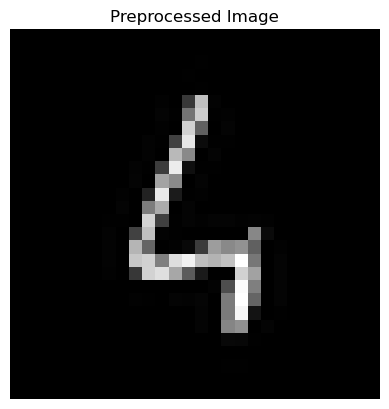

Prediction: 4, Confidence: 0.9645
Top 3 predictions:
  1. 4: 0.9645
  2. 6: 0.0082
  3. Y: 0.0066
Moved char_39.png to 4_f8839f17-c366-43e4-b726-23525933be63.png
Processing 38/102: char_4.png


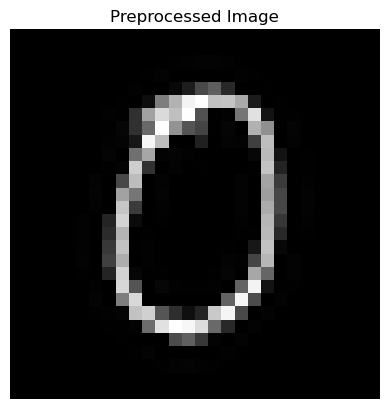

Prediction: 0, Confidence: 0.9196
Top 3 predictions:
  1. 0: 0.9196
  2. O: 0.0804
  3. 8: 0.0000
Moved char_4.png to 0_d8ed9595-3b84-4ea0-8222-bd6c34a5e4e1.png
Processing 39/102: char_40.png


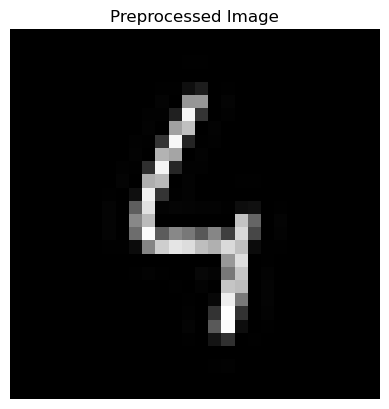

Prediction: 4, Confidence: 0.9962
Top 3 predictions:
  1. 4: 0.9962
  2. 9: 0.0022
  3. Y: 0.0013
Moved char_40.png to 4_a4222190-0def-4f02-bb51-4d678f24174d.png
Processing 40/102: char_41.png


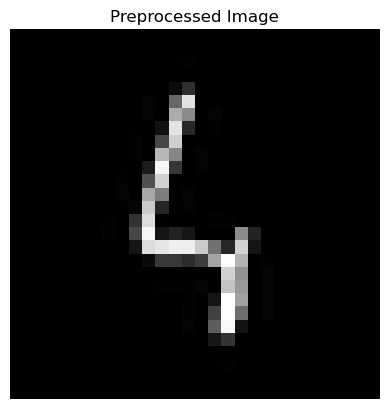

Prediction: 4, Confidence: 0.9913
Top 3 predictions:
  1. 4: 0.9913
  2. Y: 0.0035
  3. 9: 0.0022
Moved char_41.png to 4_7853a323-7d5a-4c29-a224-67088b00b919.png
Processing 41/102: char_42.png


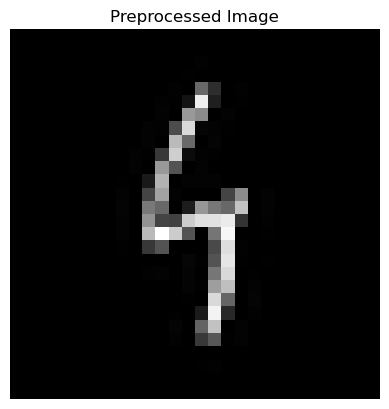

Prediction: 4, Confidence: 0.9893
Top 3 predictions:
  1. 4: 0.9893
  2. Y: 0.0061
  3. 9: 0.0038
Moved char_42.png to 4_0c72d981-6079-4c01-9be1-47bcf6028717.png
Processing 42/102: char_43.png


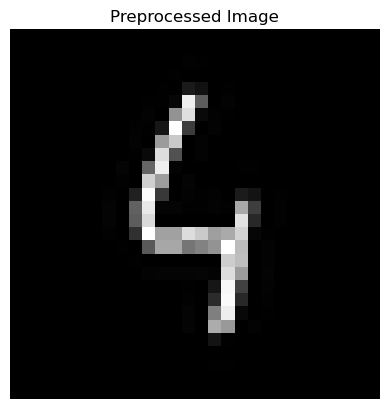

Prediction: 4, Confidence: 0.9996
Top 3 predictions:
  1. 4: 0.9996
  2. 9: 0.0003
  3. Y: 0.0001
Moved char_43.png to 4_a96b3700-c9ff-4b88-9ea9-962817bf08e3.png
Processing 43/102: char_44.png


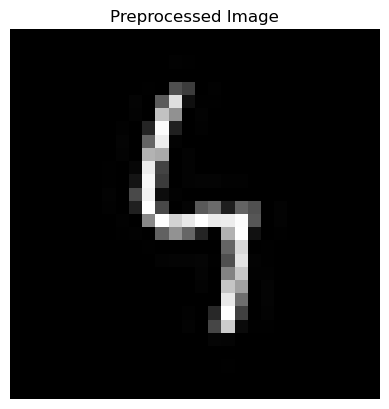

Prediction: 4, Confidence: 0.9895
Top 3 predictions:
  1. 4: 0.9895
  2. Y: 0.0077
  3. 9: 0.0021
Moved char_44.png to 4_781c2093-bc27-4f56-8677-d8c7a409e37b.png
Processing 44/102: char_45.png


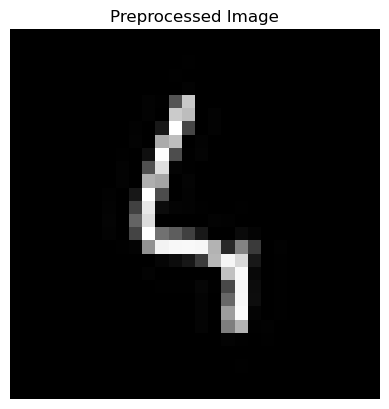

Prediction: 4, Confidence: 0.4282
Top 3 predictions:
  1. 4: 0.4282
  2. 5: 0.1539
  3. 6: 0.0650
Moved char_45.png to 4_6d13744c-7e55-412a-84b4-3bf324637788.png
Processing 45/102: char_46.png


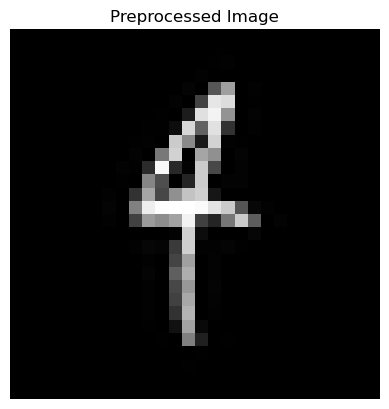

Prediction: T, Confidence: 0.3078
Top 3 predictions:
  1. T: 0.3078
  2. P: 0.1572
  3. Y: 0.0743
Moved char_46.png to T_8e0c32da-a049-4e7c-8871-c456c0915e36.png
Processing 46/102: char_47.png


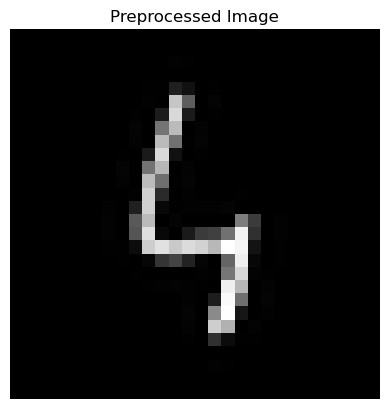

Prediction: 4, Confidence: 0.9831
Top 3 predictions:
  1. 4: 0.9831
  2. Y: 0.0103
  3. 9: 0.0039
Moved char_47.png to 4_2b466c64-8801-4340-950a-5909b90763f6.png
Processing 47/102: char_48.png


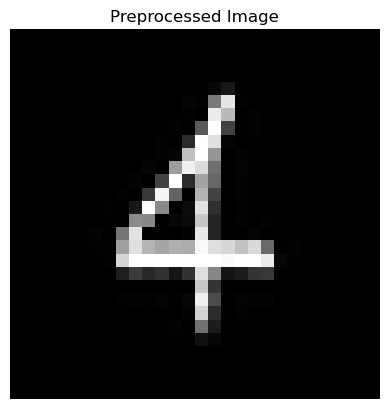

Prediction: 4, Confidence: 1.0000
Top 3 predictions:
  1. 4: 1.0000
  2. 9: 0.0000
  3. A: 0.0000
Moved char_48.png to 4_c3b41b18-a280-4ae6-9a1b-4ef05d40ca7d.png
Processing 48/102: char_49.png


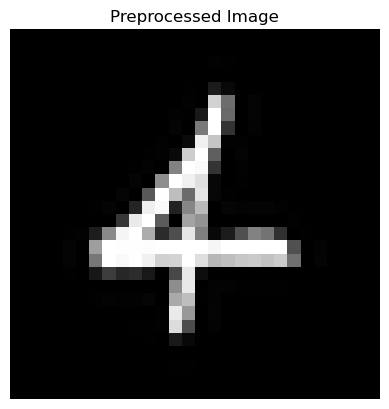

Prediction: 4, Confidence: 0.9993
Top 3 predictions:
  1. 4: 0.9993
  2. A: 0.0007
  3. 9: 0.0000
Moved char_49.png to 4_a603bedf-52d3-455d-ae09-f4433ade22a6.png
Processing 49/102: char_5.png


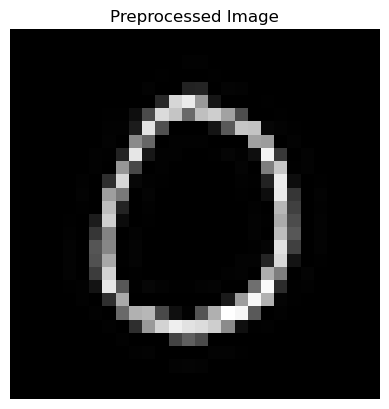

Prediction: 0, Confidence: 0.9999
Top 3 predictions:
  1. 0: 0.9999
  2. O: 0.0001
  3. 8: 0.0000
Moved char_5.png to 0_375dedf7-04bc-422b-8746-37d588c88cee.png
Processing 50/102: char_50.png


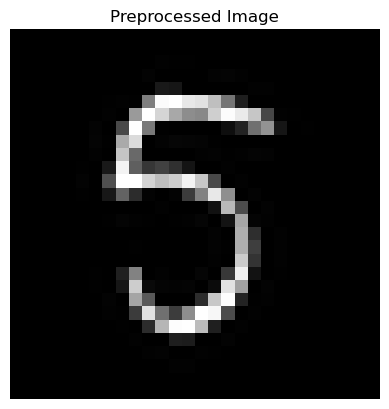

Prediction: 5, Confidence: 0.9998
Top 3 predictions:
  1. 5: 0.9998
  2. S: 0.0002
  3. 3: 0.0000
Moved char_50.png to 5_c015fab3-b1ef-4b13-b8c0-13be283c1c7e.png
Processing 51/102: char_51.png


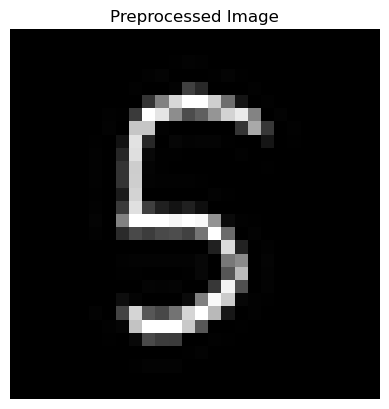

Prediction: 5, Confidence: 0.9998
Top 3 predictions:
  1. 5: 0.9998
  2. S: 0.0002
  3. 3: 0.0000
Moved char_51.png to 5_4d7a3bcf-cd5a-4089-9548-25b8457a353e.png
Processing 52/102: char_52.png


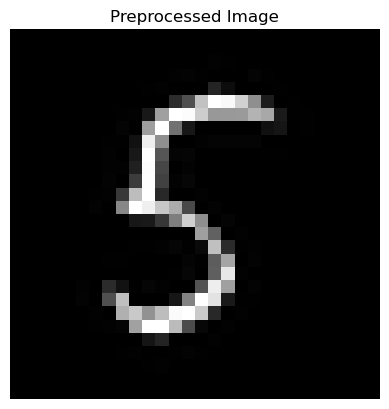

Prediction: 5, Confidence: 0.9997
Top 3 predictions:
  1. 5: 0.9997
  2. S: 0.0003
  3. 3: 0.0000
Moved char_52.png to 5_9ad1ba70-8b3e-4d09-9e2b-dea754654939.png
Processing 53/102: char_53.png


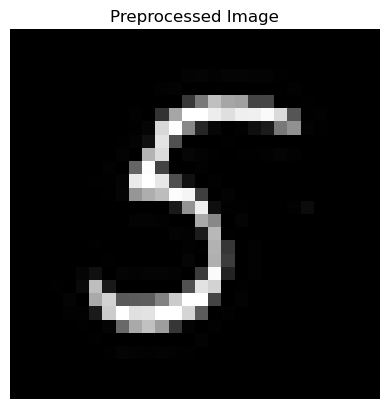

Prediction: 5, Confidence: 0.9989
Top 3 predictions:
  1. 5: 0.9989
  2. S: 0.0011
  3. 3: 0.0000
Moved char_53.png to 5_fcc55ee8-6c34-4891-ac20-77132679b7bb.png
Processing 54/102: char_54.png


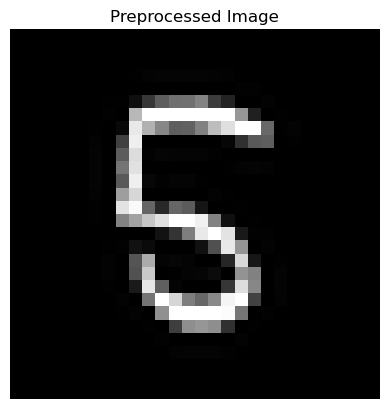

Prediction: 5, Confidence: 0.9979
Top 3 predictions:
  1. 5: 0.9979
  2. S: 0.0021
  3. 3: 0.0000
Moved char_54.png to 5_bb6f9814-ee21-478f-b31c-2f4c25eb0ead.png
Processing 55/102: char_55.png


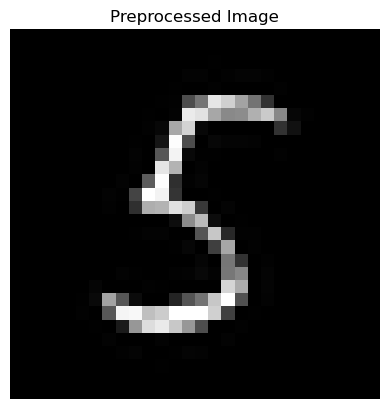

Prediction: 5, Confidence: 1.0000
Top 3 predictions:
  1. 5: 1.0000
  2. S: 0.0000
  3. 6: 0.0000
Moved char_55.png to 5_18714e8a-c6af-4c60-81a5-5b419a117796.png
Processing 56/102: char_56.png


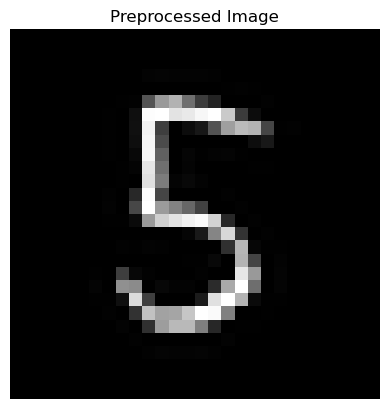

Prediction: 5, Confidence: 1.0000
Top 3 predictions:
  1. 5: 1.0000
  2. S: 0.0000
  3. 3: 0.0000
Moved char_56.png to 5_84699e50-e172-417f-b537-b929699a584a.png
Processing 57/102: char_57.png


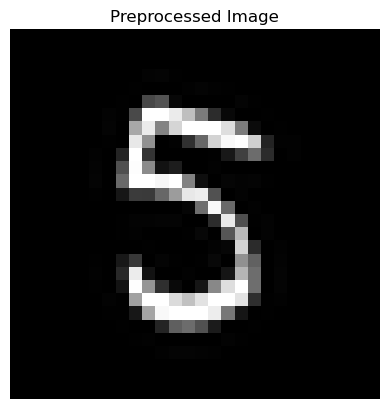

Prediction: 5, Confidence: 0.9999
Top 3 predictions:
  1. 5: 0.9999
  2. S: 0.0001
  3. 3: 0.0000
Moved char_57.png to 5_a6863be4-b2d4-4f93-93f9-bdca7ec48c29.png
Processing 58/102: char_58.png


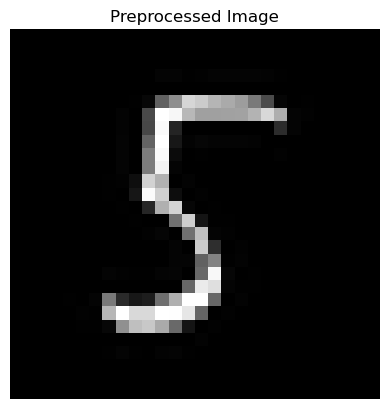

Prediction: 5, Confidence: 0.9971
Top 3 predictions:
  1. 5: 0.9971
  2. S: 0.0029
  3. 3: 0.0000
Moved char_58.png to 5_426e268e-2e5d-4b94-a664-be8e2b4c2234.png
Processing 59/102: char_59.png


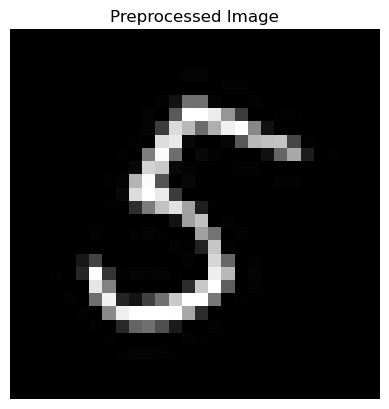

Prediction: 5, Confidence: 1.0000
Top 3 predictions:
  1. 5: 1.0000
  2. S: 0.0000
  3. 6: 0.0000
Moved char_59.png to 5_0c6b6e42-662d-4cfd-b4d3-ceff5c46d88e.png
Processing 60/102: char_6.png


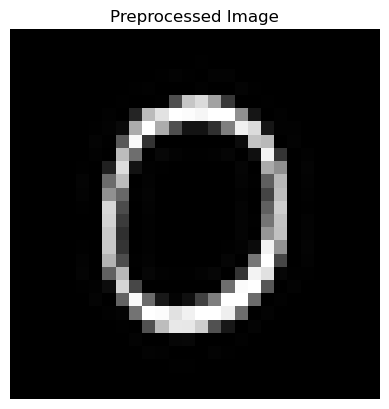

Prediction: 0, Confidence: 0.9757
Top 3 predictions:
  1. 0: 0.9757
  2. O: 0.0243
  3. 8: 0.0000
Moved char_6.png to 0_242e6de2-4132-404b-89d3-b1367f54bee8.png
Processing 61/102: char_60.png


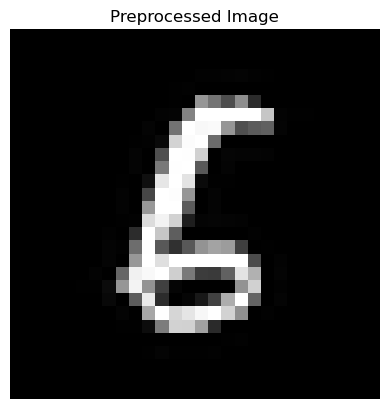

Prediction: 6, Confidence: 0.9960
Top 3 predictions:
  1. 6: 0.9960
  2. 5: 0.0037
  3. 8: 0.0001
Moved char_60.png to 6_de975aee-6799-42de-a32b-4acfcb8f1ba4.png
Processing 62/102: char_61.png


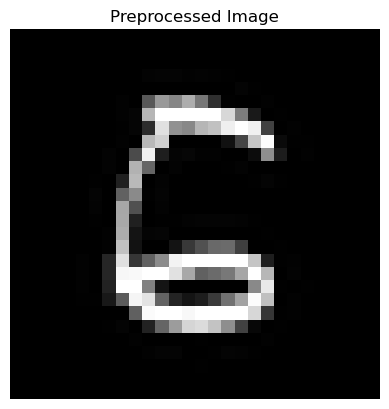

Prediction: 6, Confidence: 0.8592
Top 3 predictions:
  1. 6: 0.8592
  2. 5: 0.1391
  3. G: 0.0011
Moved char_61.png to 6_e07b83a1-e856-4967-9e2c-7358d07faf39.png
Processing 63/102: char_62.png


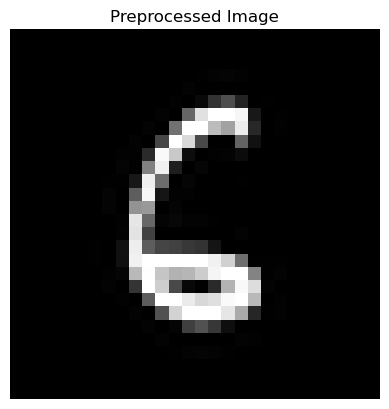

Prediction: 6, Confidence: 0.9989
Top 3 predictions:
  1. 6: 0.9989
  2. G: 0.0008
  3. 5: 0.0003
Moved char_62.png to 6_a2cd1eea-5a3c-4f79-8da4-014eec7b8a20.png
Processing 64/102: char_63.png


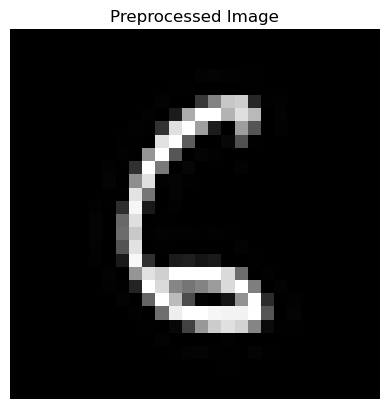

Prediction: 6, Confidence: 0.9980
Top 3 predictions:
  1. 6: 0.9980
  2. 5: 0.0012
  3. G: 0.0004
Moved char_63.png to 6_eb20239b-b4f6-48d5-a838-03ffd5558ce4.png
Processing 65/102: char_64.png


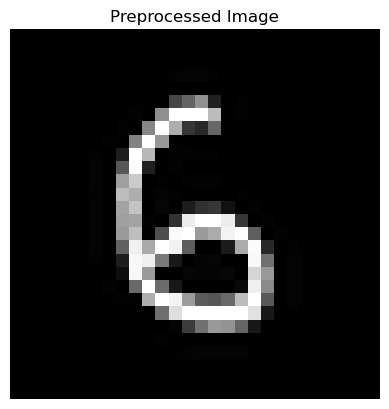

Prediction: 6, Confidence: 0.9906
Top 3 predictions:
  1. 6: 0.9906
  2. G: 0.0081
  3. 5: 0.0012
Moved char_64.png to 6_117974b7-2b09-43c1-b714-6675a2947da8.png
Processing 66/102: char_65.png


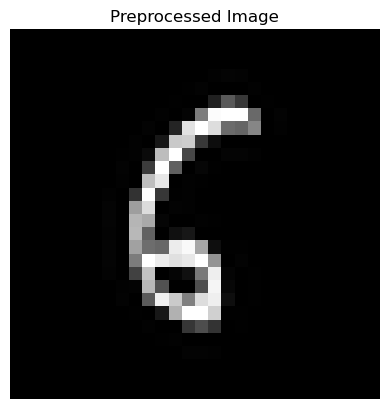

Prediction: 6, Confidence: 0.7149
Top 3 predictions:
  1. 6: 0.7149
  2. G: 0.2830
  3. 5: 0.0009
Moved char_65.png to 6_71748ff1-8f8a-4d82-a7c6-47b1b5018b95.png
Processing 67/102: char_66.png


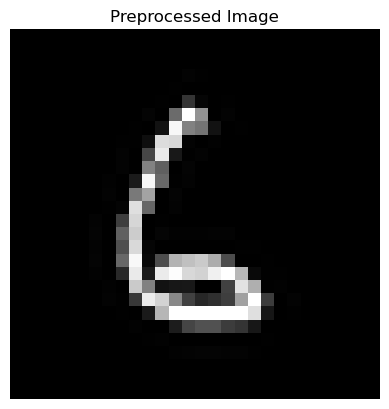

Prediction: 6, Confidence: 0.9854
Top 3 predictions:
  1. 6: 0.9854
  2. G: 0.0145
  3. 5: 0.0001
Moved char_66.png to 6_01050a11-a1ba-49df-8d21-e360801453b6.png
Processing 68/102: char_67.png


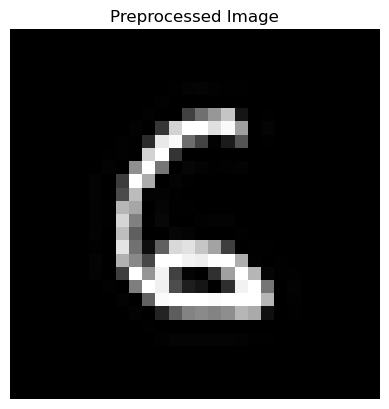

Prediction: G, Confidence: 0.9875
Top 3 predictions:
  1. G: 0.9875
  2. 6: 0.0125
  3. C: 0.0000
Moved char_67.png to G_d73db2d5-8fa5-428e-ad58-6fb7ba50a3be.png
Processing 69/102: char_68.png


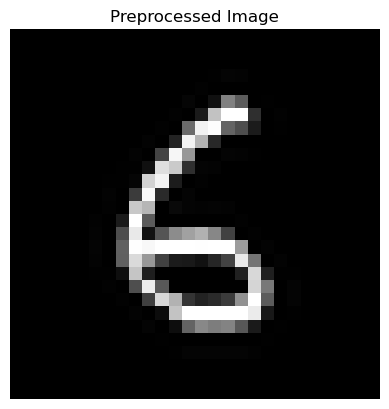

Prediction: 6, Confidence: 0.9998
Top 3 predictions:
  1. 6: 0.9998
  2. 5: 0.0001
  3. G: 0.0001
Moved char_68.png to 6_4369e803-ff7a-45c5-9396-ba684f9895e6.png
Processing 70/102: char_69.png


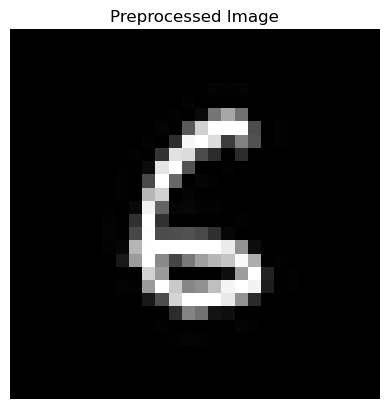

Prediction: 6, Confidence: 0.9995
Top 3 predictions:
  1. 6: 0.9995
  2. G: 0.0002
  3. 5: 0.0002
Moved char_69.png to 6_bb56ac9a-946c-494e-9b9d-661bda2dd7c5.png
Processing 71/102: char_7.png


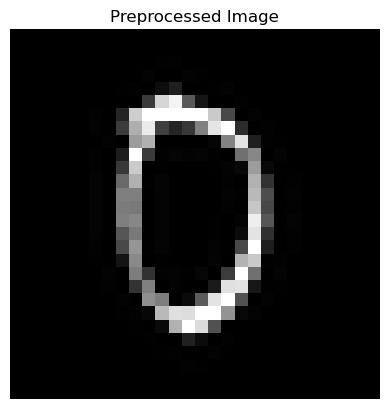

Prediction: O, Confidence: 0.8928
Top 3 predictions:
  1. O: 0.8928
  2. 0: 0.0544
  3. D: 0.0527
Moved char_7.png to O_a7d5649d-0c0b-4e04-b3ac-f81cd77b3110.png
Processing 72/102: char_70.png


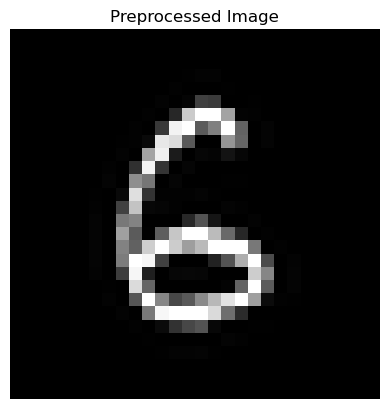

Prediction: 6, Confidence: 0.9980
Top 3 predictions:
  1. 6: 0.9980
  2. G: 0.0019
  3. 5: 0.0000
Moved char_70.png to 6_83b3acf3-e6b7-4c87-be54-5230a988c51b.png
Processing 73/102: char_71.png


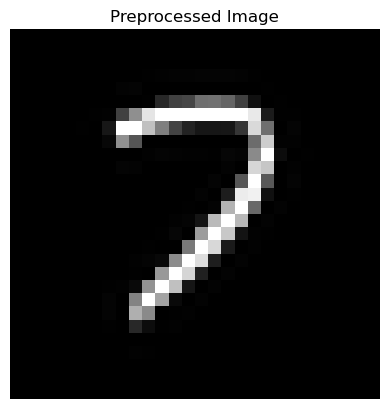

Prediction: 7, Confidence: 0.9652
Top 3 predictions:
  1. 7: 0.9652
  2. 2: 0.0223
  3. T: 0.0058
Moved char_71.png to 7_8a64f569-d693-4f9d-a297-4b06865d09cb.png
Processing 74/102: char_72.png


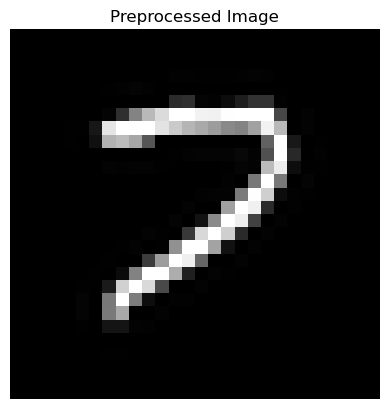

Prediction: 7, Confidence: 0.9621
Top 3 predictions:
  1. 7: 0.9621
  2. T: 0.0195
  3. 2: 0.0127
Moved char_72.png to 7_09fec982-69fc-49b7-96b0-5169f999f2e8.png
Processing 75/102: char_73.png


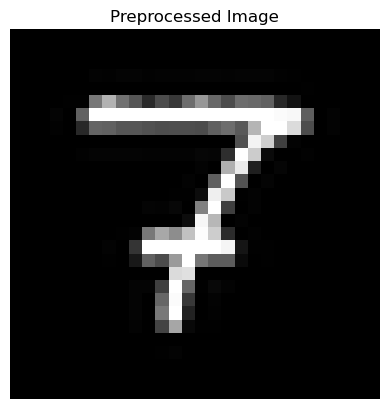

Prediction: 7, Confidence: 0.7340
Top 3 predictions:
  1. 7: 0.7340
  2. T: 0.2501
  3. Z: 0.0147
Moved char_73.png to 7_de642728-3d1e-46e8-a804-a01596806967.png
Processing 76/102: char_74.png


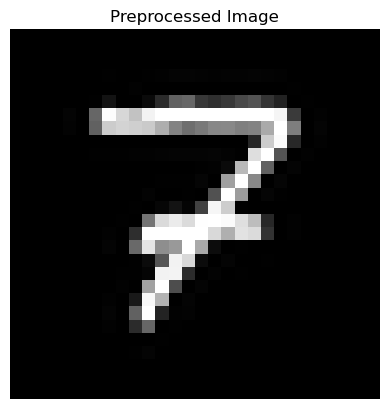

Prediction: 7, Confidence: 0.9960
Top 3 predictions:
  1. 7: 0.9960
  2. T: 0.0029
  3. Z: 0.0011
Moved char_74.png to 7_a54fc463-90c6-4c16-8535-cd1494ea0350.png
Processing 77/102: char_75.png


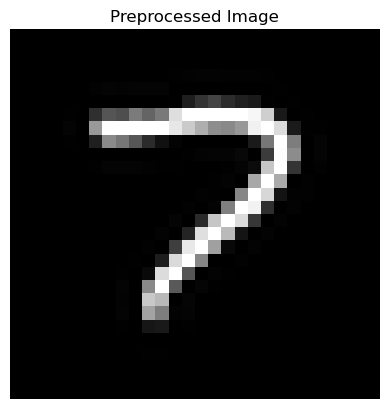

Prediction: T, Confidence: 0.6161
Top 3 predictions:
  1. T: 0.6161
  2. 7: 0.3447
  3. J: 0.0129
Moved char_75.png to T_1311c87b-f273-4474-8e8e-14ab4df8bcd7.png
Processing 78/102: char_76.png


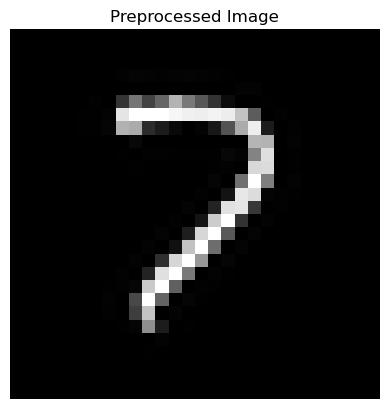

Prediction: 7, Confidence: 0.7478
Top 3 predictions:
  1. 7: 0.7478
  2. 2: 0.1730
  3. T: 0.0395
Moved char_76.png to 7_9d2ebf76-171a-4c50-aaec-84459b1c2ce0.png
Processing 79/102: char_77.png


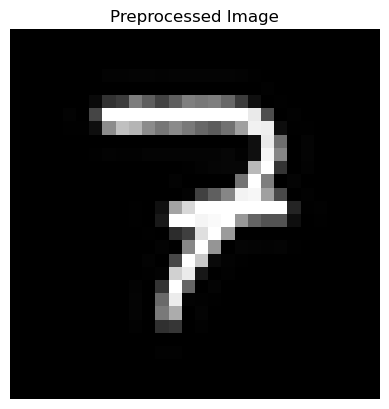

Prediction: 7, Confidence: 0.9719
Top 3 predictions:
  1. 7: 0.9719
  2. T: 0.0140
  3. Z: 0.0115
Moved char_77.png to 7_39c7f108-3ee5-4eb5-8423-ceb9bdea43ca.png
Processing 80/102: char_78.png


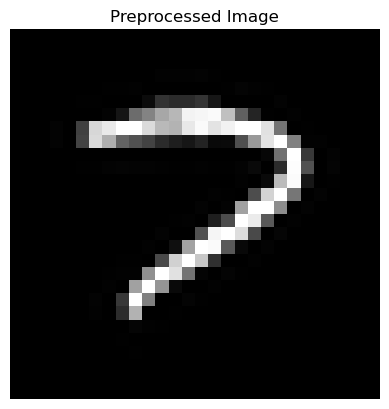

Prediction: 7, Confidence: 0.9580
Top 3 predictions:
  1. 7: 0.9580
  2. T: 0.0211
  3. 2: 0.0153
Moved char_78.png to 7_b9c57f96-9ce2-4379-87d7-f6a9476a3ff2.png
Processing 81/102: char_79.png


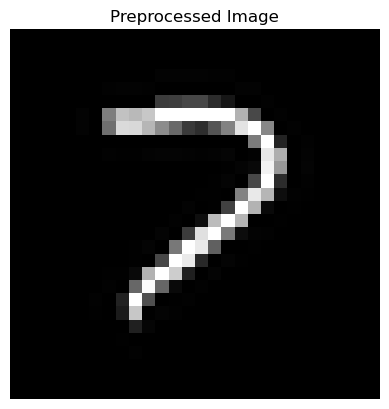

Prediction: 7, Confidence: 0.9416
Top 3 predictions:
  1. 7: 0.9416
  2. T: 0.0382
  3. 2: 0.0112
Moved char_79.png to 7_ab7af397-703f-484a-be39-dbc1df9ce5ff.png
Processing 82/102: char_8.png


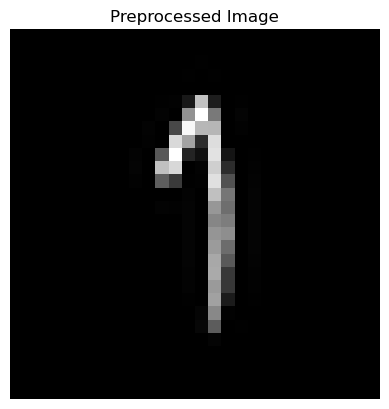

Prediction: 1, Confidence: 0.8724
Top 3 predictions:
  1. 1: 0.8724
  2. Y: 0.0591
  3. T: 0.0440
Moved char_8.png to 1_d1c01617-9601-4605-8bb1-57bb0a42c7f3.png
Processing 83/102: char_80.png


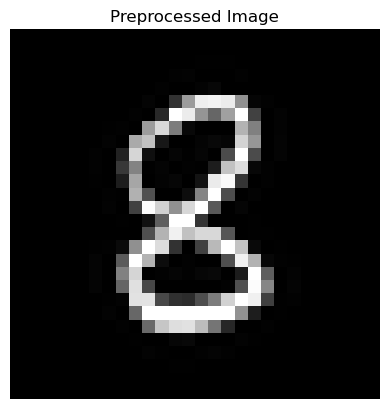

Prediction: 8, Confidence: 1.0000
Top 3 predictions:
  1. 8: 1.0000
  2. 5: 0.0000
  3. S: 0.0000
Moved char_80.png to 8_ffe48f92-dda3-4d4e-b2c2-ce1d48cbbf75.png
Processing 84/102: char_81.png


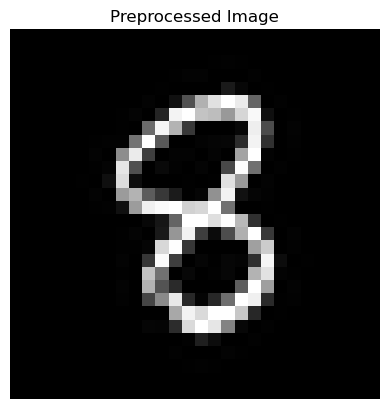

Prediction: 8, Confidence: 1.0000
Top 3 predictions:
  1. 8: 1.0000
  2. 3: 0.0000
  3. 5: 0.0000
Moved char_81.png to 8_4cdfc8b3-6dcb-4d47-a34f-d08905aa526c.png
Processing 85/102: char_82.png


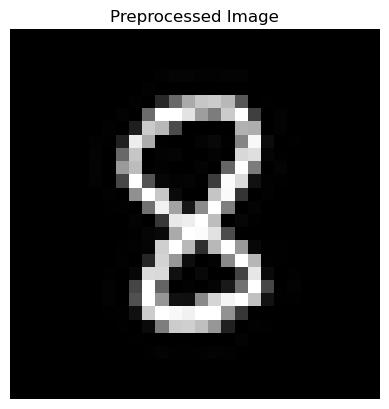

Prediction: 8, Confidence: 1.0000
Top 3 predictions:
  1. 8: 1.0000
  2. S: 0.0000
  3. 5: 0.0000
Moved char_82.png to 8_7e4265c7-856f-4ee3-b0e2-09466c78c857.png
Processing 86/102: char_83.png


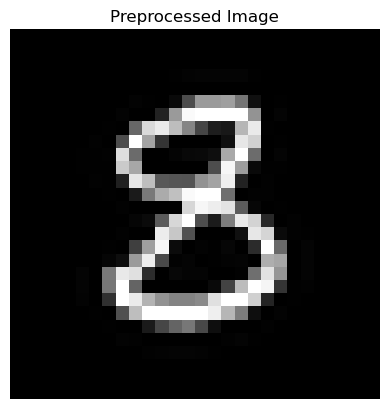

Prediction: 8, Confidence: 1.0000
Top 3 predictions:
  1. 8: 1.0000
  2. 3: 0.0000
  3. 5: 0.0000
Moved char_83.png to 8_22e5a152-ad0e-452a-bedc-0c77068bc856.png
Processing 87/102: char_84.png


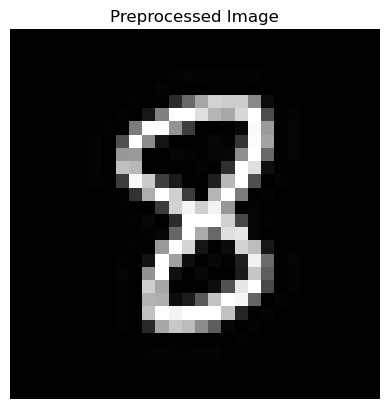

Prediction: 8, Confidence: 1.0000
Top 3 predictions:
  1. 8: 1.0000
  2. S: 0.0000
  3. B: 0.0000
Moved char_84.png to 8_05aa0a0c-5aaa-497d-b464-773105fe035b.png
Processing 88/102: char_85.png


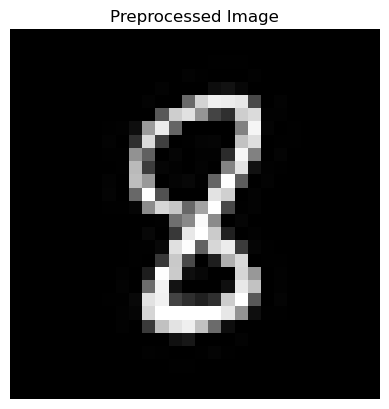

Prediction: 8, Confidence: 1.0000
Top 3 predictions:
  1. 8: 1.0000
  2. S: 0.0000
  3. 5: 0.0000
Moved char_85.png to 8_75f9b929-2b6e-41b8-b68e-8a1bae6c5b10.png
Processing 89/102: char_86.png


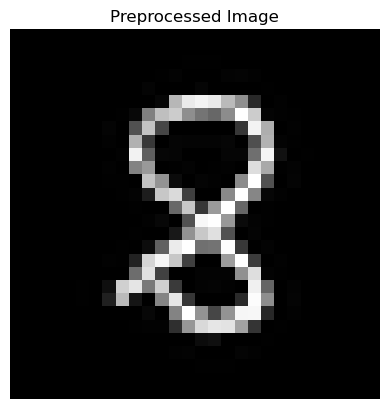

Prediction: 8, Confidence: 1.0000
Top 3 predictions:
  1. 8: 1.0000
  2. S: 0.0000
  3. 5: 0.0000
Moved char_86.png to 8_e98bbe72-f3ca-4db6-9ef6-a20e4e226815.png
Processing 90/102: char_87.png


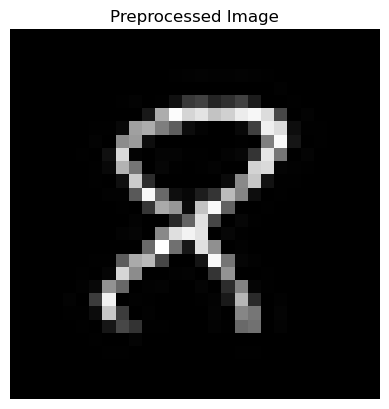

Prediction: 8, Confidence: 0.9996
Top 3 predictions:
  1. 8: 0.9996
  2. 2: 0.0003
  3. S: 0.0001
Moved char_87.png to 8_1b489f48-49ff-4a2b-81ca-64c2f24c0f28.png
Processing 91/102: char_88.png


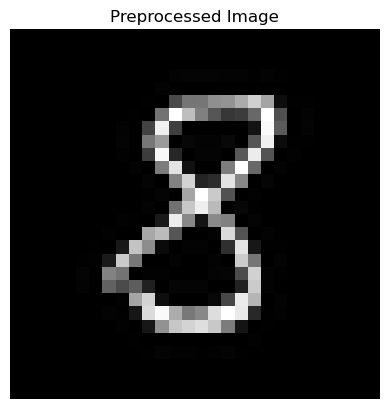

Prediction: 8, Confidence: 1.0000
Top 3 predictions:
  1. 8: 1.0000
  2. S: 0.0000
  3. 3: 0.0000
Moved char_88.png to 8_c9e074b0-c215-4fcd-a559-ff0229e96ed6.png
Processing 92/102: char_89.png


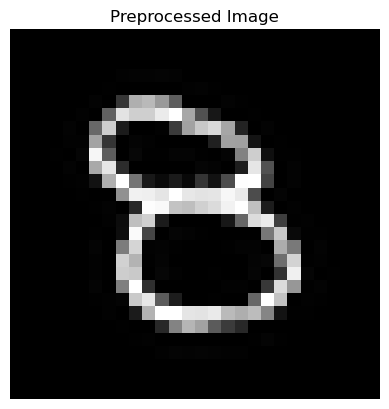

Prediction: 8, Confidence: 0.9995
Top 3 predictions:
  1. 8: 0.9995
  2. B: 0.0004
  3. 3: 0.0001
Moved char_89.png to 8_bb41b903-2540-45b1-95b3-87361b253be9.png
Processing 93/102: char_9.png


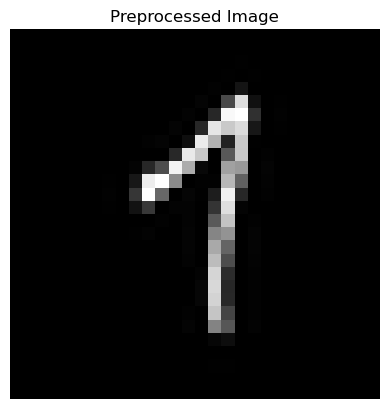

Prediction: 1, Confidence: 0.9571
Top 3 predictions:
  1. 1: 0.9571
  2. 7: 0.0223
  3. T: 0.0153
Moved char_9.png to 1_5944a56e-1cdb-4ca4-9f8d-d65e61a6bf3a.png
Processing 94/102: char_90.png


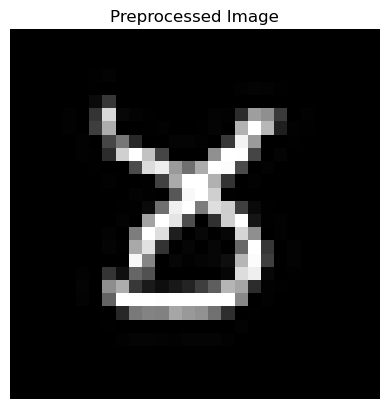

Prediction: 8, Confidence: 0.9338
Top 3 predictions:
  1. 8: 0.9338
  2. 3: 0.0419
  3. 5: 0.0140
Moved char_90.png to 8_376177c3-4976-492b-a033-3efb8929747b.png
Processing 95/102: char_92.png


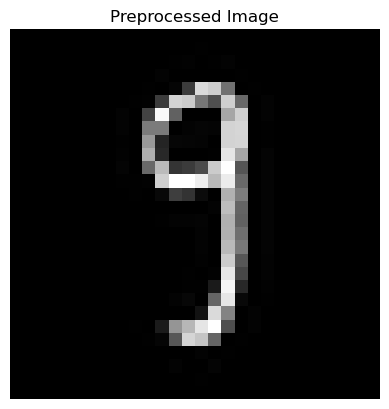

Prediction: 9, Confidence: 0.4482
Top 3 predictions:
  1. 9: 0.4482
  2. Y: 0.4455
  3. S: 0.0562
Moved char_92.png to 9_915f54ff-71d0-4fab-a97b-e441c23ea788.png
Processing 96/102: char_93.png


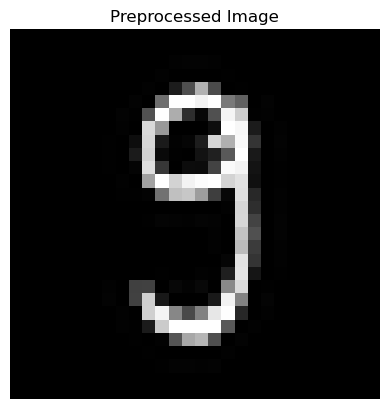

Prediction: 9, Confidence: 0.9917
Top 3 predictions:
  1. 9: 0.9917
  2. S: 0.0031
  3. 3: 0.0030
Moved char_93.png to 9_4051b3d4-d237-42da-9e33-56d91e87eb69.png
Processing 97/102: char_94.png


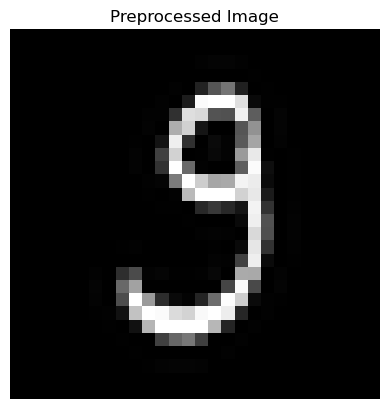

Prediction: 9, Confidence: 0.9926
Top 3 predictions:
  1. 9: 0.9926
  2. 3: 0.0055
  3. 5: 0.0006
Moved char_94.png to 9_db143be5-7897-40bf-9af2-1a79e241dea9.png
Processing 98/102: char_95.png


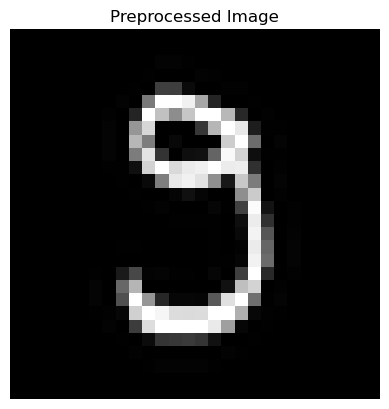

Prediction: 9, Confidence: 0.9835
Top 3 predictions:
  1. 9: 0.9835
  2. 3: 0.0145
  3. 5: 0.0013
Moved char_95.png to 9_c559473e-7387-4297-92f0-95e1ae0059e2.png
Processing 99/102: char_96.png


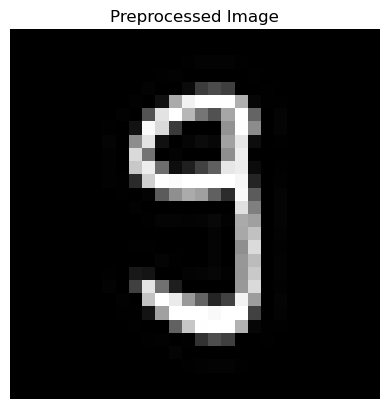

Prediction: 9, Confidence: 0.9796
Top 3 predictions:
  1. 9: 0.9796
  2. S: 0.0133
  3. 3: 0.0051
Moved char_96.png to 9_db73f5f7-192e-47df-8590-c1f7c4717418.png
Processing 100/102: char_97.png


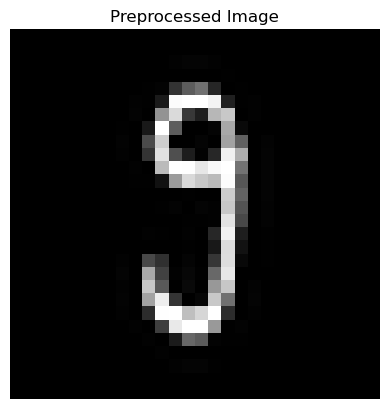

Prediction: 9, Confidence: 0.9596
Top 3 predictions:
  1. 9: 0.9596
  2. S: 0.0228
  3. 3: 0.0082
Moved char_97.png to 9_dea8ff7e-2ca3-429b-a803-ce30926c295c.png
Processing 101/102: char_98.png


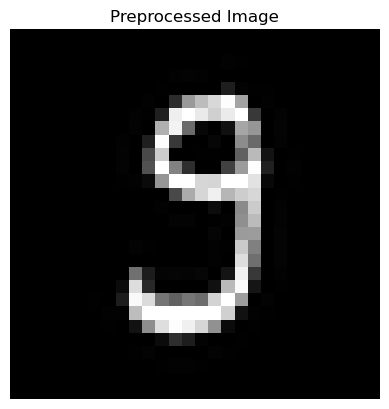

Prediction: 9, Confidence: 0.9975
Top 3 predictions:
  1. 9: 0.9975
  2. 3: 0.0017
  3. 5: 0.0004
Moved char_98.png to 9_681ef161-f360-478b-a51b-25617a10d7aa.png
Processing 102/102: char_99.png


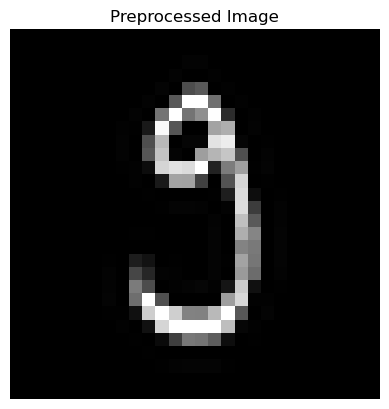

Prediction: 9, Confidence: 0.9436
Top 3 predictions:
  1. 9: 0.9436
  2. S: 0.0280
  3. 3: 0.0111
Moved char_99.png to 9_625cbb98-fbe9-4818-8dc0-cdaf066b7f80.png


In [66]:
sort_images_by_prediction(source_directory="testing_data/alpha", confidence_threshold=0.3)
sort_images_by_prediction(source_directory="testing_data/digits", confidence_threshold=0.3)


### WITHOUT FALSE POSITIVES

In [23]:

def benchmark_model(test_data_directory="testing_data/benchmark1"):
    """
    Benchmark the model by testing it on sorted data and calculating accuracy
    
    Args:
        test_data_directory: Directory containing sorted character folders
    """
    
    if not os.path.exists(test_data_directory):
        print(f"Error: Test data directory '{test_data_directory}' not found!")
        return
    
    # Get all character folders
    character_folders = [f for f in os.listdir(test_data_directory) 
                        if os.path.isdir(os.path.join(test_data_directory, f))]
    
    if not character_folders:
        print("No character folders found in test directory!")
        return
    
    character_folders.sort()
    
    total_correct = 0
    total_images = 0
    overall_results = {}
    
    print(f"Benchmarking model on {len(character_folders)} character classes...")
    print("="*60)
    
    for true_char in character_folders:
        folder_path = os.path.join(test_data_directory, true_char)
        
        # Get all image files in this character folder
        image_files = []
        
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                image_files.append(filename)
        
        if not image_files:
            print(f"No images found in folder '{true_char}'")
            continue
        
        print(f"\nTesting character '{true_char}' ({len(image_files)} images):")
        
        # Dictionary to count predictions for this character
        prediction_counts = {}
        correct_predictions = 0
        
        for filename in image_files:
            image_path = os.path.join(folder_path, filename)
            preprocessed_image = preprocess_image_for_cnn(image_path)
            
            if preprocessed_image is not None:
                # Get prediction
                prediction_proba = cnn_model.predict(preprocessed_image, verbose=0)
                predicted_class_id = np.argmax(prediction_proba[0])
                predicted_char = class_to_char(predicted_class_id)
                confidence = np.max(prediction_proba[0])
                
                # Count predictions
                if predicted_char in prediction_counts:
                    prediction_counts[predicted_char] += 1
                else:
                    prediction_counts[predicted_char] = 1
                
                # Check if prediction is correct
                if predicted_char == true_char:
                    correct_predictions += 1
                
                total_images += 1
        
        # Calculate accuracy for this character
        folder_accuracy = (correct_predictions / len(image_files)) * 100 if image_files else 0
        total_correct += correct_predictions
        
        # Display results for this character
        print(f"Predictions for '{true_char}':")
        sorted_predictions = sorted(prediction_counts.items(), key=lambda x: x[1], reverse=True)
        for pred_char, count in sorted_predictions:
            percentage = (count / len(image_files)) * 100
            marker = "✓" if pred_char == true_char else "✗"
            print(f"  {marker} {pred_char}: {count} times ({percentage:.1f}%)")
        
        print(f"Accuracy for '{true_char}': {correct_predictions}/{len(image_files)} ({folder_accuracy:.1f}%)")
        
        # Store overall results
        overall_results[true_char] = {
            'total_images': len(image_files),
            'correct_predictions': correct_predictions,
            'accuracy': folder_accuracy,
            'predictions': prediction_counts
        }
    
    # Calculate and display overall accuracy
    overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
    
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY")
    print("="*60)
    print(f"Total images tested: {total_images}")
    print(f"Total correct predictions: {total_correct}")
    print(f"Overall accuracy: {overall_accuracy:.2f}%")
    
    # Display per-character summary
    print("\nPer-character accuracy:")
    for char, results in overall_results.items():
        print(f"  {char}: {results['accuracy']:.1f}% ({results['correct_predictions']}/{results['total_images']})")
    
    # Find best and worst performing characters
    if overall_results:
        best_char = max(overall_results.items(), key=lambda x: x[1]['accuracy'])
        worst_char = min(overall_results.items(), key=lambda x: x[1]['accuracy'])
        
        print(f"\nBest performing: '{best_char[0]}' ({best_char[1]['accuracy']:.1f}%)")
        print(f"Worst performing: '{worst_char[0]}' ({worst_char[1]['accuracy']:.1f}%)")
    
    return overall_results

In [25]:
benchmark_model()

Benchmarking model on 36 character classes...

Testing character '0' (153 images):
Predictions for '0':
  ✓ 0: 148 times (96.7%)
  ✗ 9: 3 times (2.0%)
  ✗ 6: 2 times (1.3%)
Accuracy for '0': 148/153 (96.7%)

Testing character '1' (129 images):
Predictions for '1':
  ✓ 1: 126 times (97.7%)
  ✗ N: 3 times (2.3%)
Accuracy for '1': 126/129 (97.7%)

Testing character '2' (128 images):
Predictions for '2':
  ✓ 2: 127 times (99.2%)
  ✗ 8: 1 times (0.8%)
Accuracy for '2': 127/128 (99.2%)

Testing character '3' (108 images):
Predictions for '3':
  ✓ 3: 108 times (100.0%)
Accuracy for '3': 108/108 (100.0%)

Testing character '4' (93 images):
Predictions for '4':
  ✓ 4: 90 times (96.8%)
  ✗ 9: 2 times (2.2%)
  ✗ T: 1 times (1.1%)
Accuracy for '4': 90/93 (96.8%)

Testing character '5' (134 images):
Predictions for '5':
  ✓ 5: 134 times (100.0%)
Accuracy for '5': 134/134 (100.0%)

Testing character '6' (64 images):
Predictions for '6':
  ✓ 6: 62 times (96.9%)
  ✗ G: 1 times (1.6%)
  ✗ 5: 1 times (1

{'0': {'total_images': 153,
  'correct_predictions': 148,
  'accuracy': 96.73202614379085,
  'predictions': {'0': 148, '9': 3, '6': 2}},
 '1': {'total_images': 129,
  'correct_predictions': 126,
  'accuracy': 97.67441860465115,
  'predictions': {'1': 126, 'N': 3}},
 '2': {'total_images': 128,
  'correct_predictions': 127,
  'accuracy': 99.21875,
  'predictions': {'2': 127, '8': 1}},
 '3': {'total_images': 108,
  'correct_predictions': 108,
  'accuracy': 100.0,
  'predictions': {'3': 108}},
 '4': {'total_images': 93,
  'correct_predictions': 90,
  'accuracy': 96.7741935483871,
  'predictions': {'4': 90, '9': 2, 'T': 1}},
 '5': {'total_images': 134,
  'correct_predictions': 134,
  'accuracy': 100.0,
  'predictions': {'5': 134}},
 '6': {'total_images': 64,
  'correct_predictions': 62,
  'accuracy': 96.875,
  'predictions': {'6': 62, 'G': 1, '5': 1}},
 '7': {'total_images': 45,
  'correct_predictions': 41,
  'accuracy': 91.11111111111111,
  'predictions': {'7': 41, 'A': 3, 'T': 1}},
 '8': 

### FALSE POSITIVES

In [27]:
def benchmark_model(test_data_directory="testing_data/benchmark1"):
    """
    Benchmark the model by testing it on sorted data and calculating accuracy and
    false positives per class.
    
    Args:
        test_data_directory: Directory containing sorted character folders
    """
    import os
    import numpy as np
    # NOTE: cnn_model, preprocess_image_for_cnn, and class_to_char must be defined globally
    # or passed as arguments for this function to run.
    
    if not os.path.exists(test_data_directory):
        print(f"Error: Test data directory '{test_data_directory}' not found!")
        return
    
    # Get all character folders
    character_folders = [f for f in os.listdir(test_data_directory) 
                         if os.path.isdir(os.path.join(test_data_directory, f))]
    
    if not character_folders:
        print("No character folders found in test directory!")
        return
    
    character_folders.sort()
    
    total_correct = 0
    total_images = 0
    overall_results = {}
    
    # Initialize a dictionary to track False Positives across ALL classes
    false_positives = {char: 0 for char in character_folders}
    
    print(f"Benchmarking model on {len(character_folders)} character classes...")
    print("="*60)
    
    for true_char in character_folders:
        folder_path = os.path.join(test_data_directory, true_char)
        
        # Get all image files in this character folder
        image_files = []
        
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                image_files.append(filename)
        
        if not image_files:
            print(f"No images found in folder '{true_char}'")
            continue
        
        print(f"\nTesting character '{true_char}' ({len(image_files)} images):")
        
        # Dictionary to count predictions for this character
        prediction_counts = {}
        correct_predictions = 0
        
        for filename in image_files:
            image_path = os.path.join(folder_path, filename)
            preprocessed_image = preprocess_image_for_cnn(image_path)
            
            if preprocessed_image is not None:
                # Get prediction
                prediction_proba = cnn_model.predict(preprocessed_image, verbose=0)
                predicted_class_id = np.argmax(prediction_proba[0])
                predicted_char = class_to_char(predicted_class_id)
                confidence = np.max(prediction_proba[0])
                
                # Count predictions
                if predicted_char in prediction_counts:
                    prediction_counts[predicted_char] += 1
                else:
                    prediction_counts[predicted_char] = 1
                
                # Check if prediction is correct
                if predicted_char == true_char:
                    correct_predictions += 1
                else:
                    # Increment False Positive count for the PREDICTED character
                    false_positives[predicted_char] += 1
                
                total_images += 1
        
        # Calculate accuracy for this character
        folder_accuracy = (correct_predictions / len(image_files)) * 100 if image_files else 0
        total_correct += correct_predictions
        
        # Display results for this character
        print(f"Predictions for '{true_char}':")
        sorted_predictions = sorted(prediction_counts.items(), key=lambda x: x[1], reverse=True)
        for pred_char, count in sorted_predictions:
            percentage = (count / len(image_files)) * 100
            marker = "✓" if pred_char == true_char else "✗"
            print(f"  {marker} {pred_char}: {count} times ({percentage:.1f}%)")
        
        print(f"Accuracy for '{true_char}': {correct_predictions}/{len(image_files)} ({folder_accuracy:.1f}%)")
        
        # Store overall results
        overall_results[true_char] = {
            'total_images': len(image_files),
            'correct_predictions': correct_predictions,
            'accuracy': folder_accuracy,
            'predictions': prediction_counts
        }
    
    # Calculate and display overall accuracy
    overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
    
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY")
    print("="*60)
    print(f"Total images tested: {total_images}")
    print(f"Total correct predictions: {total_correct}")
    print(f"Overall accuracy: {overall_accuracy:.2f}%")
    
    # Display per-character summary
    print("\nPer-character summary:")
    for char in character_folders:
        results = overall_results.get(char, {'accuracy': 0.0, 'correct_predictions': 0, 'total_images': 0})
        fp_count = false_positives.get(char, 0)
        
        print(f"  {char}: Acc={results['accuracy']:.1f}% ({results['correct_predictions']}/{results['total_images']}), FP={fp_count}")
        
        # Store False Positives in the results structure
        overall_results[char]['false_positives'] = fp_count
        
    
    # Find best and worst performing characters (unchanged)
    if overall_results:
        best_char = max(overall_results.items(), key=lambda x: x[1]['accuracy'])
        worst_char = min(overall_results.items(), key=lambda x: x[1]['accuracy'])
        
        print(f"\nBest performing: '{best_char[0]}' ({best_char[1]['accuracy']:.1f}%)")
        print(f"Worst performing: '{worst_char[0]}' ({worst_char[1]['accuracy']:.1f}%)")
    
    return overall_results

In [29]:
benchmark_model()

Benchmarking model on 36 character classes...

Testing character '0' (153 images):
Predictions for '0':
  ✓ 0: 148 times (96.7%)
  ✗ 9: 3 times (2.0%)
  ✗ 6: 2 times (1.3%)
Accuracy for '0': 148/153 (96.7%)

Testing character '1' (129 images):
Predictions for '1':
  ✓ 1: 126 times (97.7%)
  ✗ N: 3 times (2.3%)
Accuracy for '1': 126/129 (97.7%)

Testing character '2' (128 images):
Predictions for '2':
  ✓ 2: 127 times (99.2%)
  ✗ 8: 1 times (0.8%)
Accuracy for '2': 127/128 (99.2%)

Testing character '3' (108 images):
Predictions for '3':
  ✓ 3: 108 times (100.0%)
Accuracy for '3': 108/108 (100.0%)

Testing character '4' (93 images):
Predictions for '4':
  ✓ 4: 90 times (96.8%)
  ✗ 9: 2 times (2.2%)
  ✗ T: 1 times (1.1%)
Accuracy for '4': 90/93 (96.8%)

Testing character '5' (134 images):
Predictions for '5':
  ✓ 5: 134 times (100.0%)
Accuracy for '5': 134/134 (100.0%)

Testing character '6' (64 images):
Predictions for '6':
  ✓ 6: 62 times (96.9%)
  ✗ G: 1 times (1.6%)
  ✗ 5: 1 times (1

{'0': {'total_images': 153,
  'correct_predictions': 148,
  'accuracy': 96.73202614379085,
  'predictions': {'0': 148, '9': 3, '6': 2},
  'false_positives': 34},
 '1': {'total_images': 129,
  'correct_predictions': 126,
  'accuracy': 97.67441860465115,
  'predictions': {'1': 126, 'N': 3},
  'false_positives': 1},
 '2': {'total_images': 128,
  'correct_predictions': 127,
  'accuracy': 99.21875,
  'predictions': {'2': 127, '8': 1},
  'false_positives': 44},
 '3': {'total_images': 108,
  'correct_predictions': 108,
  'accuracy': 100.0,
  'predictions': {'3': 108},
  'false_positives': 10},
 '4': {'total_images': 93,
  'correct_predictions': 90,
  'accuracy': 96.7741935483871,
  'predictions': {'4': 90, '9': 2, 'T': 1},
  'false_positives': 29},
 '5': {'total_images': 134,
  'correct_predictions': 134,
  'accuracy': 100.0,
  'predictions': {'5': 134},
  'false_positives': 96},
 '6': {'total_images': 64,
  'correct_predictions': 62,
  'accuracy': 96.875,
  'predictions': {'6': 62, 'G': 1, '

### FALSE POSITIVES WITH DETAILS

In [13]:
import cv2

def benchmark_model(test_data_directory="testing_data/benchmark1"):
    """
    Benchmark the model by testing it on sorted data and calculating accuracy and
    detailed false positives per class.
    
    Args:
        test_data_directory: Directory containing sorted character folders
    """
    import os
    import numpy as np
    # NOTE: cnn_model, preprocess_image_for_cnn, and class_to_char must be defined globally
    # or passed as arguments for this function to run.
    
    if not os.path.exists(test_data_directory):
        print(f"Error: Test data directory '{test_data_directory}' not found!")
        return
    
    # Get all character folders
    character_folders = [f for f in os.listdir(test_data_directory) 
                         if os.path.isdir(os.path.join(test_data_directory, f))]
    
    if not character_folders:
        print("No character folders found in test directory!")
        return
    
    character_folders.sort()
    
    total_correct = 0
    total_images = 0
    overall_results = {}
    
    # NEW: Initialize a dictionary to track False Positives in detail.
    # Structure: {predicted_char: {true_char: count, ...}, ...}
    detailed_false_positives = {char: {} for char in character_folders}
    
    print(f"Benchmarking model on {len(character_folders)} character classes...")
    print("="*60)
    
    for true_char in character_folders:
        folder_path = os.path.join(test_data_directory, true_char)
        
        # Get all image files in this character folder
        image_files = []
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                image_files.append(filename)
        
        if not image_files:
            print(f"No images found in folder '{true_char}'")
            continue
        
        print(f"\nTesting character '{true_char}' ({len(image_files)} images):")
        
        # Dictionary to count predictions for this character (True Positive + False Negatives)
        prediction_counts = {}
        correct_predictions = 0
        
        for filename in image_files:
            image_path = os.path.join(folder_path, filename)
            preprocessed_image = preprocess_image_for_cnn3(image_path)
            
            if preprocessed_image is not None:
                # Get prediction
                prediction_proba = cnn_model.predict(preprocessed_image, verbose=0)
                predicted_class_id = np.argmax(prediction_proba[0])
                predicted_char = class_to_char(predicted_class_id)
                confidence = np.max(prediction_proba[0])
                
                # Count predictions
                prediction_counts[predicted_char] = prediction_counts.get(predicted_char, 0) + 1
                
                # Check if prediction is correct
                if predicted_char == true_char:
                    correct_predictions += 1
                else:
                    # NEW: Update the detailed False Positive tracker
                    # The model predicted 'predicted_char' when the true label was 'true_char'
                    if true_char in detailed_false_positives[predicted_char]:
                        detailed_false_positives[predicted_char][true_char] += 1
                    else:
                        detailed_false_positives[predicted_char][true_char] = 1
                
                total_images += 1
        
        # Calculate accuracy for this character
        folder_accuracy = (correct_predictions / len(image_files)) * 100 if image_files else 0
        total_correct += correct_predictions
        
        # Display results for this character
        print(f"Predictions for '{true_char}':")
        sorted_predictions = sorted(prediction_counts.items(), key=lambda x: x[1], reverse=True)
        for pred_char, count in sorted_predictions:
            percentage = (count / len(image_files)) * 100
            marker = "✓" if pred_char == true_char else "✗"
            print(f"  {marker} {pred_char}: {count} times ({percentage:.1f}%)")
        
        print(f"Accuracy for '{true_char}': {correct_predictions}/{len(image_files)} ({folder_accuracy:.1f}%)")
        
        # Store results
        overall_results[true_char] = {
            'total_images': len(image_files),
            'correct_predictions': correct_predictions,
            'accuracy': folder_accuracy,
            'predictions': prediction_counts
        }
    
    # Calculate and display overall accuracy
    overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
    
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY")
    print("="*60)
    print(f"Total images tested: {total_images}")
    print(f"Total correct predictions: {total_correct}")
    print(f"Overall accuracy: {overall_accuracy:.2f}%")
    
    # Display per-character summary including detailed FPs
    print("\nPer-character summary (Accuracy & Confusion):")
    for char in character_folders:
        results = overall_results.get(char, {'accuracy': 0.0, 'correct_predictions': 0, 'total_images': 0})
        fp_details = detailed_false_positives.get(char, {})
        
        # Calculate total False Positives for this character (how many times it was predicted incorrectly)
        total_fp = sum(fp_details.values())
        
        # Format the detailed FP string (e.g., "4-Y, 2-U")
        fp_list = []
        if total_fp > 0:
            # Sort by count descending for readability
            sorted_fp = sorted(fp_details.items(), key=lambda x: x[1], reverse=True)
            fp_list = [f"{count}-{true_char}" for true_char, count in sorted_fp]
            
        fp_str = ", ".join(fp_list) if fp_list else "None"
        
        print(f"  {char}: Acc={results['accuracy']:.1f}% ({results['correct_predictions']}/{results['total_images']})")
        print(f"      FP ({total_fp}): {fp_str}")
        
        # Store False Positives in the results structure
        overall_results[char]['false_positives_total'] = total_fp
        overall_results[char]['false_positives_details'] = fp_details
    
    # Find best and worst performing characters (unchanged)
    if overall_results:
        best_char = max(overall_results.items(), key=lambda x: x[1]['accuracy'])
        worst_char = min(overall_results.items(), key=lambda x: x[1]['accuracy'])
        
        print(f"\nBest performing: '{best_char[0]}' ({best_char[1]['accuracy']:.1f}%)")
        print(f"Worst performing: '{worst_char[0]}' ({worst_char[1]['accuracy']:.1f}%)")
    overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
    
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY")
    print("="*60)
    print(f"Total images tested: {total_images}")
    print(f"Total correct predictions: {total_correct}")
    print(f"Overall accuracy: {overall_accuracy:.2f}%") # <-- THIS IS THE FINAL METRIC
    
    return overall_results

In [15]:
benchmark_model()

Benchmarking model on 36 character classes...

Testing character '0' (153 images):
Predictions for '0':
  ✗ O: 139 times (90.8%)
  ✓ 0: 12 times (7.8%)
  ✗ Q: 2 times (1.3%)
Accuracy for '0': 12/153 (7.8%)

Testing character '1' (129 images):


KeyError: 'd'

### EMNIST

In [13]:
import cv2

def benchmark_model_emnist(test_data_directory="testing_data/benchmark1"):
    """
    Benchmark the model by testing it on sorted data and calculating accuracy and
    detailed false positives per class.
    
    Args:
        test_data_directory: Directory containing sorted character folders
    """
    import os
    import numpy as np
    # NOTE: cnn_model, preprocess_image_for_cnn, and class_to_char must be defined globally
    # or passed as arguments for this function to run.
    
    if not os.path.exists(test_data_directory):
        print(f"Error: Test data directory '{test_data_directory}' not found!")
        return
    
    # Get all character folders
    character_folders = [f for f in os.listdir(test_data_directory) 
                         if os.path.isdir(os.path.join(test_data_directory, f))]
    
    if not character_folders:
        print("No character folders found in test directory!")
        return
    
    character_folders.sort()
    
    total_correct = 0
    total_images = 0
    overall_results = {}
    
    # Get all possible predicted characters from EMNIST (including lowercase)
    # This assumes class_to_char can return all possible characters
    all_possible_chars = set(character_folders)  # Start with folders that exist
    
    # We'll dynamically add predicted characters as we encounter them
    detailed_false_positives = {}
    
    print(f"Benchmarking model on {len(character_folders)} character classes...")
    print("="*60)
    
    for true_char in character_folders:
        folder_path = os.path.join(test_data_directory, true_char)
        
        # Get all image files in this character folder
        image_files = []
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                image_files.append(filename)
        
        if not image_files:
            print(f"No images found in folder '{true_char}'")
            continue
        
        print(f"\nTesting character '{true_char}' ({len(image_files)} images):")
        
        # Dictionary to count predictions for this character (True Positive + False Negatives)
        prediction_counts = {}
        correct_predictions = 0
        
        for filename in image_files:
            image_path = os.path.join(folder_path, filename)
            preprocessed_image = preprocess_image_for_cnn3(image_path)
            
            if preprocessed_image is not None:
                # Get prediction
                prediction_proba = cnn_model.predict(preprocessed_image, verbose=0)
                predicted_class_id = np.argmax(prediction_proba[0])
                predicted_char = class_to_char_emnist_bymerge(predicted_class_id)
                confidence = np.max(prediction_proba[0])
                
                # Count predictions
                prediction_counts[predicted_char] = prediction_counts.get(predicted_char, 0) + 1
                
                # Check if prediction is correct
                if predicted_char == true_char:
                    correct_predictions += 1
                else:
                    # Initialize the predicted_char entry if it doesn't exist
                    if predicted_char not in detailed_false_positives:
                        detailed_false_positives[predicted_char] = {}
                    
                    # Update the detailed False Positive tracker
                    if true_char in detailed_false_positives[predicted_char]:
                        detailed_false_positives[predicted_char][true_char] += 1
                    else:
                        detailed_false_positives[predicted_char][true_char] = 1
                
                total_images += 1
        
        # Calculate accuracy for this character
        folder_accuracy = (correct_predictions / len(image_files)) * 100 if image_files else 0
        total_correct += correct_predictions
        
        # Display results for this character
        print(f"Predictions for '{true_char}':")
        sorted_predictions = sorted(prediction_counts.items(), key=lambda x: x[1], reverse=True)
        for pred_char, count in sorted_predictions:
            percentage = (count / len(image_files)) * 100
            marker = "✓" if pred_char == true_char else "✗"
            print(f"  {marker} {pred_char}: {count} times ({percentage:.1f}%)")
        
        print(f"Accuracy for '{true_char}': {correct_predictions}/{len(image_files)} ({folder_accuracy:.1f}%)")
        
        # Store results
        overall_results[true_char] = {
            'total_images': len(image_files),
            'correct_predictions': correct_predictions,
            'accuracy': folder_accuracy,
            'predictions': prediction_counts
        }
    
    # Calculate and display overall accuracy
    overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
    
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY")
    print("="*60)
    print(f"Total images tested: {total_images}")
    print(f"Total correct predictions: {total_correct}")
    print(f"Overall accuracy: {overall_accuracy:.2f}%")
    
    # Display per-character summary including detailed FPs
    print("\nPer-character summary (Accuracy & Confusion):")
    print("Note: Only showing characters that exist in test folders")
    for char in character_folders:
        results = overall_results.get(char, {'accuracy': 0.0, 'correct_predictions': 0, 'total_images': 0})
        fp_details = detailed_false_positives.get(char, {})
        
        # Calculate total False Positives for this character (how many times it was predicted incorrectly)
        total_fp = sum(fp_details.values())
        
        # Format the detailed FP string (e.g., "4-Y, 2-U")
        fp_list = []
        if total_fp > 0:
            # Sort by count descending for readability
            sorted_fp = sorted(fp_details.items(), key=lambda x: x[1], reverse=True)
            fp_list = [f"{count}-{true_char}" for true_char, count in sorted_fp]
            
        fp_str = ", ".join(fp_list) if fp_list else "None"
        
        print(f"  {char}: Acc={results['accuracy']:.1f}% ({results['correct_predictions']}/{results['total_images']})")
        print(f"      FP ({total_fp}): {fp_str}")
        
        # Store False Positives in the results structure
        overall_results[char]['false_positives_total'] = total_fp
        overall_results[char]['false_positives_details'] = fp_details
    
    # Find best and worst performing characters
    if overall_results:
        best_char = max(overall_results.items(), key=lambda x: x[1]['accuracy'])
        worst_char = min(overall_results.items(), key=lambda x: x[1]['accuracy'])
        
        print(f"\nBest performing: '{best_char[0]}' ({best_char[1]['accuracy']:.1f}%)")
        print(f"Worst performing: '{worst_char[0]}' ({worst_char[1]['accuracy']:.1f}%)")
    
    # Show any lowercase predictions that were made but don't have folders
    print("\n" + "="*60)
    print("PREDICTED LOWERCASE CHARACTERS (no test folders):")
    print("="*60)
    lowercase_predictions = {char: fp_details for char, fp_details in detailed_false_positives.items() 
                            if char not in character_folders and char.islower()}
    
    if lowercase_predictions:
        for pred_char, true_char_dict in sorted(lowercase_predictions.items()):
            total = sum(true_char_dict.values())
            confused_with = ", ".join([f"{count}-{tc}" for tc, count in sorted(true_char_dict.items(), key=lambda x: x[1], reverse=True)])
            print(f"  '{pred_char}' was predicted {total} times")
            print(f"      Confused with: {confused_with}")
    else:
        print("  No lowercase predictions detected")
    
    return overall_results

In [15]:
a = benchmark_model_emnist()

Benchmarking model on 46 character classes...

Testing character '0' (153 images):
Predictions for '0':
  ✗ E: 151 times (98.7%)
  ✗ G: 2 times (1.3%)
Accuracy for '0': 0/153 (0.0%)

Testing character '1' (156 images):


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x71a872f14fe0>
Traceback (most recent call last):
  File "/home/laki/anaconda3/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


Predictions for '1':
  ✗ J: 130 times (83.3%)
  ✗ B: 7 times (4.5%)
  ✗ 2: 6 times (3.8%)
  ✗ 5: 3 times (1.9%)
  ✗ A: 3 times (1.9%)
  ✗ 4: 2 times (1.3%)
  ✗ 7: 2 times (1.3%)
  ✗ 0: 2 times (1.3%)
  ✗ P: 1 times (0.6%)
Accuracy for '1': 0/156 (0.0%)

Testing character '2' (128 images):


KeyboardInterrupt: 

### ALPHA

In [24]:
import cv2

def benchmark_alpha(test_data_directory="testing_data/benchmark1"):
    """
    Benchmark the alpha model by testing it on sorted data and calculating accuracy and
    detailed false positives per class. Only processes alphabetic character folders.
    
    Args:
        test_data_directory: Directory containing sorted character folders
    """
    import os
    import numpy as np
    # NOTE: cnn_model_alpha, preprocess_image_for_cnn, and class_to_char_alpha must be defined globally
    # or passed as arguments for this function to run.
    
    if not os.path.exists(test_data_directory):
        print(f"Error: Test data directory '{test_data_directory}' not found!")
        return
    
    # Get all character folders - ONLY ALPHA CHARACTERS
    all_folders = [f for f in os.listdir(test_data_directory) 
                   if os.path.isdir(os.path.join(test_data_directory, f))]
    
    # Filter to only alphabetic characters
    character_folders = [f for f in all_folders if f.isalpha() and len(f) == 1]
    
    if not character_folders:
        print("No alpha character folders found in test directory!")
        return
    
    character_folders.sort()
    
    total_correct = 0
    total_images = 0
    overall_results = {}
    
    # NEW: Initialize a dictionary to track False Positives in detail.
    # Structure: {predicted_char: {true_char: count, ...}, ...}
    detailed_false_positives = {char: {} for char in character_folders}
    
    print(f"Benchmarking alpha model on {len(character_folders)} alphabetic character classes...")
    print("="*60)
    
    for true_char in character_folders:
        folder_path = os.path.join(test_data_directory, true_char)
        
        # Get all image files in this character folder
        image_files = []
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                image_files.append(filename)
        
        if not image_files:
            print(f"No images found in folder '{true_char}'")
            continue
        
        print(f"\nTesting character '{true_char}' ({len(image_files)} images):")
        
        # Dictionary to count predictions for this character (True Positive + False Negatives)
        prediction_counts = {}
        correct_predictions = 0
        
        for filename in image_files:
            image_path = os.path.join(folder_path, filename)
            preprocessed_image = preprocess_image_for_cnn(image_path)
            
            if preprocessed_image is not None:
                # Get prediction using alpha model                
                print(f"Preprocessed image shape: {preprocessed_image.shape}")

                prediction_proba = cnn_model.predict(preprocessed_image, verbose=0)
                predicted_class_id = np.argmax(prediction_proba[0])
                predicted_char = class_to_char_alpha(predicted_class_id)
                confidence = np.max(prediction_proba[0])
                
                # Count predictions
                prediction_counts[predicted_char] = prediction_counts.get(predicted_char, 0) + 1
                
                # Check if prediction is correct
                if predicted_char == true_char:
                    correct_predictions += 1
                else:
                    # NEW: Update the detailed False Positive tracker
                    # The model predicted 'predicted_char' when the true label was 'true_char'
                    if true_char in detailed_false_positives[predicted_char]:
                        detailed_false_positives[predicted_char][true_char] += 1
                    else:
                        detailed_false_positives[predicted_char][true_char] = 1
                
                total_images += 1
        
        # Calculate accuracy for this character
        folder_accuracy = (correct_predictions / len(image_files)) * 100 if image_files else 0
        total_correct += correct_predictions
        
        # Display results for this character
        print(f"Predictions for '{true_char}':")
        sorted_predictions = sorted(prediction_counts.items(), key=lambda x: x[1], reverse=True)
        for pred_char, count in sorted_predictions:
            percentage = (count / len(image_files)) * 100
            marker = "✓" if pred_char == true_char else "✗"
            print(f"  {marker} {pred_char}: {count} times ({percentage:.1f}%)")
        
        print(f"Accuracy for '{true_char}': {correct_predictions}/{len(image_files)} ({folder_accuracy:.1f}%)")
        
        # Store results
        overall_results[true_char] = {
            'total_images': len(image_files),
            'correct_predictions': correct_predictions,
            'accuracy': folder_accuracy,
            'predictions': prediction_counts
        }
    
    # Calculate and display overall accuracy
    overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
    
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY (ALPHA MODEL)")
    print("="*60)
    print(f"Total images tested: {total_images}")
    print(f"Total correct predictions: {total_correct}")
    print(f"Overall accuracy: {overall_accuracy:.2f}%")
    
    # Display per-character summary including detailed FPs
    print("\nPer-character summary (Accuracy & Confusion):")
    for char in character_folders:
        results = overall_results.get(char, {'accuracy': 0.0, 'correct_predictions': 0, 'total_images': 0})
        fp_details = detailed_false_positives.get(char, {})
        
        # Calculate total False Positives for this character (how many times it was predicted incorrectly)
        total_fp = sum(fp_details.values())
        
        # Format the detailed FP string (e.g., "4-Y, 2-U")
        fp_list = []
        if total_fp > 0:
            # Sort by count descending for readability
            sorted_fp = sorted(fp_details.items(), key=lambda x: x[1], reverse=True)
            fp_list = [f"{count}-{true_char}" for true_char, count in sorted_fp]
            
        fp_str = ", ".join(fp_list) if fp_list else "None"
        
        print(f"  {char}: Acc={results['accuracy']:.1f}% ({results['correct_predictions']}/{results['total_images']})")
        print(f"      FP ({total_fp}): {fp_str}")
        
        # Store False Positives in the results structure
        overall_results[char]['false_positives_total'] = total_fp
        overall_results[char]['false_positives_details'] = fp_details
    
    # Find best and worst performing characters
    if overall_results:
        best_char = max(overall_results.items(), key=lambda x: x[1]['accuracy'])
        worst_char = min(overall_results.items(), key=lambda x: x[1]['accuracy'])
        
        print(f"\nBest performing: '{best_char[0]}' ({best_char[1]['accuracy']:.1f}%)")
        print(f"Worst performing: '{worst_char[0]}' ({worst_char[1]['accuracy']:.1f}%)")
    
    overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
    
    print("\n" + "="*60)
    print("BENCHMARK SUMMARY (ALPHA MODEL)")
    print("="*60)
    print(f"Total images tested: {total_images}")
    print(f"Total correct predictions: {total_correct}")
    print(f"Overall accuracy: {overall_accuracy:.2f}%") # <-- THIS IS THE FINAL METRIC
    

In [26]:
benchmark_alpha()

Benchmarking alpha model on 26 alphabetic character classes...

Testing character 'A' (174 images):
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1)
Preprocessed image shape: (1, 28, 28, 1

KeyboardInterrupt: 